<a href="https://colab.research.google.com/github/ykitaguchi77/GO_AI_project/blob/main/Hertel_YOLOv5_MobileNetv3_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Hertel estimation YOLOv5-MobileNetv3 pipeline**

Train YOLOv5

```
Olympia dataset
Dlibで目が2つ検出されるものを抜き出す
YOLOv5を用いて左右とバウンディングボックスを認識させる
抜き出した画像についてMobileNetV3で回帰（5-fold ensemble）を行う
スマホに実装
```

Output as CoreML

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys
import torch
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow


import glob
import random
from PIL import Image
%matplotlib inline

# #サポートパッチのインポート
# from google.colab.patches import cv2_imshow
# import cv2

plt.ion()   # interactive mode
!nvidia-smi
print(torch.cuda.is_available())


Fri Nov 10 07:27:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 11.14

#Google colabをマウント

In [2]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#親フォルダ
parent_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5'

#元画像フォルダ
dataset_dir = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset'

#元画像をコピー
orig_dir = f"{parent_dir}/dataset_orig"

#切りぬいた画像を保存するフォルダ
out_dir = f"{parent_dir}/dataset_uni"

#トレーニングされたYOLOv5で切り抜いた画像を保存するフォルダ
cropped_dir = f"{parent_dir}/dataset_yolo_cropped"

#CSVファイルのフォルダ
csv_hertel_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel.csv"
csv_coordinate_path = f"{parent_dir}/coordinate_uni_for_YOLO5.csv"
csv_integrated_path = f"{parent_dir}/integrated_uni_for_YOLO5.csv"

In [ ]:
"""
###################################
# Refresh folder (内容が削除されるので注意！！) #
###################################
"""
"""

# parent_dirがあれば削除する
if os.path.exists(parent_dir):
    shutil.rmtree(parent_dir)

# 新しくparent_dirを作成する
os.makedirs(parent_dir)

# orig_dir, out_dirを新規に作成する
os.makedirs(orig_dir)
os.makedirs(out_dir)
os.makedirs(cropped_dir)

# orig_dirにdataset_dir直下のファイルをすべてコピーする
file_list = os.listdir(dataset_dir)
for filename in tqdm(file_list, desc="Copying files", unit="file"):
    src_path = os.path.join(dataset_dir, filename)
    dst_path = os.path.join(orig_dir, filename)
    shutil.copy(src_path, dst_path)

print("処理が完了しました。")
"""

Copying files: 100%|██████████| 1016/1016 [00:33<00:00, 30.43file/s]

処理が完了しました。


#**HaarCascadeを用いて目を検出**

In [ ]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#**目が2つ以上検出されたものを抜き出す**

dlibで検出されたものから、上下左右に0.1倍ずつ拡大した範囲を抜き出している

In [ ]:
with open(csv_coordinate_path, 'w', newline='') as f:
        #fieldnames = ['Number', 'Folder', 'FileName']
        writer = csv.writer(f)
        writer.writerow(['id','img_path', 'side R/L', 'ex', 'ey', 'ew', 'eh'])  #header

        files = os.listdir(orig_dir)

        k=0
        for file in files:  #フォルダ数の分だけ
              file_path = f"{orig_dir}/{file}"
              id = os.path.splitext(os.path.basename(file_path))[0]

              img = cv2.imread(file_path)
              img2 = img.copy()

              # 画像グレースケール化
              grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

              #300pix以上のもので目に見えるものを抽出
              eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))

              # 眼検出判定
              if len(eye_list) >= 1:
                  print('目が' + str(len(eye_list)) +'個検出されました')
              else:
                  print("eye detection error")

              #画像の切り抜きと保存（2個以上検出の時に限る）
              if len(eye_list) >= 2:
                  for (ex, ey, ew, eh) in eye_list:
                      print(f"img_width: {img2.shape[1]}")
                      print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
                      cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
                      img_cropped = img[int(ey-0.1*eh): int(ey+1.1*eh), int(ex-0.1*ew): int(ex+1.1*ew)] #本来の切り抜きより幅の0.1倍ずつ水増しする
                      #img_cropped = img[int(ey): int(ey+eh), int(ex): int(ex+ew)]


                      if ex+eh*0.5 <= img2.shape[1]/2:
                          side = "R" #横幅の半分より左にあるのは右眼
                      else:
                          side = "L" #横幅の半分よりより右にあるのは左眼

                      print(f"side: {side}")
                      print("")

                      # Check if coordinates are within the image bounds
                      ey_start = max(int(ey - 0.1 * eh), 0)
                      ey_end = min(int(ey + 1.1 * eh), img.shape[0])
                      ex_start = max(int(ex - 0.1 * ew), 0)
                      ex_end = min(int(ex + 1.1 * ew), img.shape[1])

                      # Ensure we have a valid crop area
                      if ex_start < ex_end and ey_start < ey_end:
                          img_cropped = img[ey_start: ey_end, ex_start: ex_end]

                          # Now do the checks for the right/left side, write image and row
                          # ...

                          cv2.imwrite(f"{out_dir}/{id}_{side}.png", img_cropped)

                      #対応表の作成
                      writer.writerow([id, file_path, side, ex-round(ew*0.1), ey-round(eh*0.1), round(ew*1.2), round(eh*1.2)])

                      #cv2_imshow(img_cropped)
                  else:
                      pass


##**ここで、目以外が誤検出されているものを手動で抜き出して削除する**

```
coordinate_uni_for_YOLO5.csvから、削除して画像のパスが存在しなくなっている行を削除する

```

In [ ]:
import os
import pandas as pd

# DataFrameを読み込む
coordinates_df = pd.read_csv(csv_coordinate_path)

# 存在しない画像パスをチェックし、そのリストを保持する
nonexistent_paths = coordinates_df[~coordinates_df['img_path'].apply(os.path.exists)]

# 存在しない画像パスを表示
print("Nonexistent image paths:")
print(nonexistent_paths['img_path'])

# # 存在しない画像パスの行を削除
# coordinates_df = coordinates_df[coordinates_df['img_path'].apply(os.path.exists)]

# # 更新されたDataFrameを保存する
# coordinates_df.to_csv('coordinate_uni_for_YOLO5.csv', index=False)


Nonexistent image paths:
Series([], Name: img_path, dtype: object)


##**Dataframeの整理**

・ hertel_dfを参照して、coordinates_dfにヘルテル値を記入する

・idが"16_R, 16_L"という形式になるようにデータフレームを整理する

In [ ]:
import pandas as pd

# Assuming csv_coordinate_path and csv_hertel_path are defined paths to the CSV files
coordinates_df = pd.read_csv(csv_coordinate_path)
hertel_df = pd.read_csv(csv_hertel_path)

coordinates_df['Hertel'] = None

def get_hertel_value(row, hertel_df):
    id = row['id']
    side = row['side R/L']
    hertel_value = hertel_df.loc[hertel_df['number'] == id, side].values
    return hertel_value[0] if len(hertel_value) > 0 else None

# Use .copy() to ensure that you're working with a copy and not a view
coordinates_df['Hertel'] = coordinates_df.apply(lambda row: get_hertel_value(row, hertel_df), axis=1)

id_counts = coordinates_df.groupby('id')['side R/L'].value_counts().unstack()
valid_ids = id_counts[(id_counts['R'] == 1) & (id_counts['L'] == 1)].index

# Filter the DataFrame to only include these ids
# Use .copy() to avoid SettingWithCopyWarning when modifying this DataFrame later
coordinates_filtered_df = coordinates_df[coordinates_df['id'].isin(valid_ids)].copy()
coordinates_filtered_df.reset_index(drop=True, inplace=True)

coordinates_filtered_df.to_csv(csv_integrated_path, index=False)
coordinates_filtered_df.head()

id                                           img_path side R/L    ex   ey  \
0  19  /content/drive/MyDrive/Deep_learning/Olympia_d...        R   107  557   
1  19  /content/drive/MyDrive/Deep_learning/Olympia_d...        L  1513  547   
2  20  /content/drive/MyDrive/Deep_learning/Olympia_d...        R    74  483   
3  20  /content/drive/MyDrive/Deep_learning/Olympia_d...        L  1488  486   
4  21  /content/drive/MyDrive/Deep_learning/Olympia_d...        R   147  555   

    ew   eh  Hertel  
0  835  835    15.0  
1  850  850    16.0  
2  942  942    18.0  
3  978  978    18.0  
4  868  868    19.0

In [ ]:
'''
画像パスの抽出（RLともに揃っているもの）
'''
coordinates_filtered_df = coordinates_filtered_df.drop_duplicates(subset='id', keep='first')
img_path_list = coordinates_filtered_df['img_path'].tolist()


'''
画像の分割 train:valid = 8:2
'''
random.seed(42)  # For reproducibility
random.shuffle(img_path_list)

split_index = int(0.8 * len(img_path_list))
train_img_paths = img_path_list[:split_index]
valid_img_paths = img_path_list[split_index:]

if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir)

'''
フォルダの作成
'''
folders = ['train/images', 'train/labels', 'valid/images', 'valid/labels']
for folder in folders:
    os.makedirs(os.path.join(out_dir, folder))


'''
画像のコピー
'''
# Define paths for images directories
train_images_dir = os.path.join(out_dir, 'train/images')
valid_images_dir = os.path.join(out_dir, 'valid/images')

# Copy training images
for img_path in tqdm(train_img_paths, desc='Copying train images'):
    shutil.copy(img_path, train_images_dir)

# Copy validation images
for img_path in tqdm(valid_img_paths, desc='Copying valid images'):
    shutil.copy(img_path, valid_images_dir)

Copying valid images: 100%|██████████| 190/190 [00:02<00:00, 67.28it/s]


In [ ]:
import os
import pandas as pd
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

def convert_to_yolo_format(ex, ey, ew, eh, img_width, img_height):
    cx = (ex + (ew / 2)) / img_width
    cy = (ey + (eh / 2)) / img_height
    w = ew / img_width
    h = eh / img_height
    return cx, cy, w, h

def create_label_files(image_dir, label_dir, df):
    image_files = os.listdir(image_dir)
    for image_file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(image_dir, image_file)
        img_width, img_height = get_image_dimensions(image_path)

        base_name = os.path.splitext(image_file)[0]
        matched_rows = df[df['id'] == int(base_name)]

        if matched_rows.empty:
            raise ValueError(f"No matching id found for image {image_file}")

        label_file_path = os.path.join(label_dir, f"{base_name}.txt")
        with open(label_file_path, 'w') as label_file:
            for _, row in matched_rows.iterrows():
                ex = row['ex']
                ey = row['ey']
                ew = row['ew']
                eh = row['eh']
                cx, cy, w, h = convert_to_yolo_format(ex, ey, ew, eh, img_width, img_height)
                side = 0 if row['side R/L'] == 'R' else 1
                label_file.write(f" {side} {cx} {cy} {w} {h}\n")
                #label_file.write(f"{ex} {ey} {ew} {eh} {side}\n")

# CSVファイルの読み込み
csv_integrated_df = pd.read_csv(csv_integrated_path)

# trainとvalidのディレクトリパス
train_images_dir = os.path.join(out_dir, "train/images")
train_labels_dir = os.path.join(out_dir, "train/labels")
valid_images_dir = os.path.join(out_dir, "valid/images")
valid_labels_dir = os.path.join(out_dir, "valid/labels")

# trainディレクトリでラベルファイルを生成
create_label_files(train_images_dir, train_labels_dir, csv_integrated_df)

# validディレクトリでラベルファイルを生成
create_label_files(valid_images_dir, valid_labels_dir, csv_integrated_df)


Processing images: 100%|██████████| 190/190 [00:01<00:00, 142.43it/s]


In [ ]:
##############################
## バウンディングボックスのサンプル描画 ##
## (これは実行しなくて良い)            ##
##############################

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# バウンディングボックスを描画する関数
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

def draw_bounding_boxes(image_path, bboxes):
    with Image.open(image_path) as img:
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        for bbox in bboxes:
            class_id, cx, cy, bw, bh = bbox
            x = (cx - bw / 2) * img_width
            y = (cy - bh / 2) * img_height
            width = bw * img_width
            height = bh * img_height
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()

# ラベルファイルからバウンディングボックスのリストを取得する関数
def get_bboxes_from_label_file(label_path, img_width, img_height):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            cx, cy, bw, bh, class_id = map(float, line.split())
            bboxes.append((cx, cy, bw, bh, class_id))
    return bboxes

# 画像パスとラベルファイルパス
image_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/images/10.JPG"
label_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/labels/10.txt"

# 画像のサイズを取得
img_width, img_height = get_image_dimensions(image_path)

# ラベルファイルからバウンディングボックスのリストを取得
bboxes = get_bboxes_from_label_file(label_path, img_width, img_height)


# バウンディングボックスを描画
print(f"img_width: {img_width}, img_height: {img_height}")
print(f"bboxes: {bboxes}")
draw_bounding_boxes(image_path, bboxes)


In [ ]:
%cd $out_dir

In [ ]:
%%writefile dataset.yaml
train: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/train/images
val: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/valid/images

nc: 2
names: ['right', 'left']

Writing dataset.yaml


#**Setup YOLOv5**

In [ ]:
# # YOLOv5_iFish --> train_batchの精度が低いので一旦却下とした
# %cd $out_dir
# !git clone https://github.com/ykitaguchi77/yolov5-iFish.git #iFish augmentationを実装したバージョン
# %cd yolov5-iFish
# %pip install -qr requirements.txt

# import torch
# import utils
# display = utils.notebook_init()

In [ ]:
# YOLOv5
%cd $out_dir
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 27.0/166.8 GB disk)


#**Train YOLOv5**

In [ ]:
# Train
!python train.py --img 640 --batch 16 --epochs 300 --data $out_dir/dataset.yaml --weights yolov5n.pt

In [ ]:
# 途中から
!python train.py --img 640 --batch 16 --epochs 300 --data $out_dir/data.yaml --resume $out_dir/yolov5/runs/train/exp/weights/last.pt

In [ ]:
# best.pyをrenameしてgdriveに移動しておく
orig_pt = f"{out_dir}/yolov5/runs/train/exp/weights/best.pt"
dst_pt = f"{out_dir}/eyecrop-yolov5n-300epoch.pt"
shutil.copy(orig_pt, dst_pt)

dst_pt = f"/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5_backup/eyecrop-yolov5n-300epoch.pt"
shutil.copy(orig_pt, dst_pt)

'/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5_backup/eyecrop-yolov5n-300epoch.pt'

#**Inference original dataset**

In [11]:
%cd $out_dir/yolov5

import torch
import utils
%pip install -qr requirements.txt
display = utils.notebook_init()

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 28.3/166.8 GB disk)


In [12]:
# YOLOv5
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5-iFish/runs/train/exp2/weights/best.pt"
#weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"
weight = f"{out_dir}/dataset_uni/eyecrop-yolov5n-iFish_169epoch.pt"
weight = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_uni/eyecrop-yolov5n-300epoch.pt"

# もともとのデータセット
orig_dir = orig_dir #元画像
cropped_dir = cropped_dir #YOLOv5で切り抜いた画像用

if os.path.exists(cropped_dir):
    shutil.rmtree(cropped_dir)
os.makedirs(cropped_dir)


In [13]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def inference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred


def make_letterbox_image(cv2_image): #letterbox_image作成、リサイズ
    # 元の画像のサイズを取得
    height, width = cv2_image.shape[:2]

    # 正方形のサイズを決定（元の画像の長辺に合わせる）
    square_size = max(width, height)

    # 正方形のキャンバスを作成（背景は黒）
    letterbox_img = np.zeros((square_size, square_size, 3), dtype=np.uint8)

    # 元の画像を正方形の画像の中央に配置するための開始点（x,y）を計算
    x_center = (square_size - width) // 2
    y_center = (square_size - height) // 2

    # 元の画像を正方形のキャンバスにコピーする
    letterbox_img[y_center:y_center+height, x_center:x_center+width] = cv2_image

    letterbox_img_resized = cv2.resize(letterbox_img,(250,250))

    # 変換した画像を保存
    return letterbox_img_resized

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[373.99402, 180.63806, 623.73431, 430.99927,   0.93071,   1.00000],
        [  7.82450, 191.22992, 257.81631, 445.30865,   0.90791,   0.00000]])]
診断は left、確率は93.1%です。
img_height: 426, img_width: 640
x1: 374.0, y1: 74.0, x2: 624.0, y2: 324.0


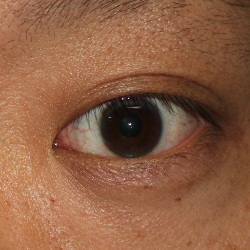

診断は right、確率は90.8%です。
img_height: 426, img_width: 640
x1: 8.0, y1: 84.0, x2: 258.0, y2: 338.0


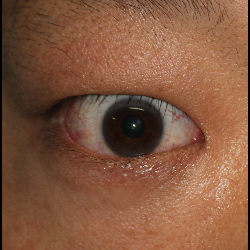

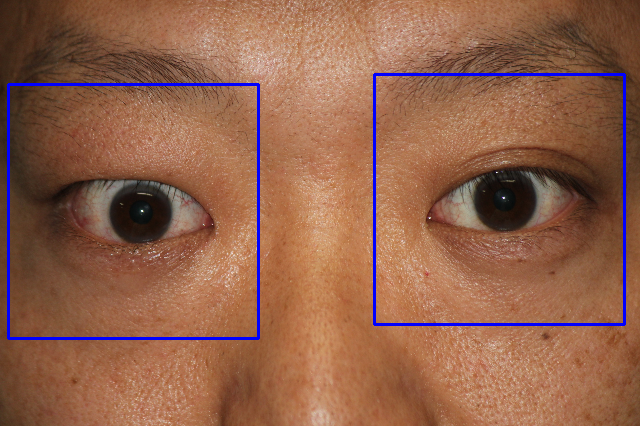

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[364.44312, 221.19670, 614.88452, 468.66077,   0.94960,   1.00000],
        [ 11.64102, 217.32635, 256.98755, 467.57898,   0.94853,   0.00000]])]
診断は left、確率は95.0%です。
img_height: 426, img_width: 640
x1: 364.0, y1: 114.0, x2: 615.0, y2: 362.0


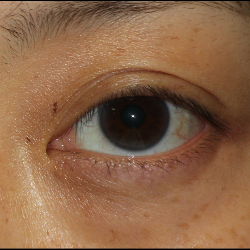

診断は right、確率は94.9%です。
img_height: 426, img_width: 640
x1: 12.0, y1: 110.0, x2: 257.0, y2: 361.0


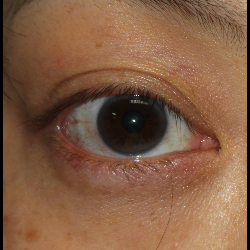

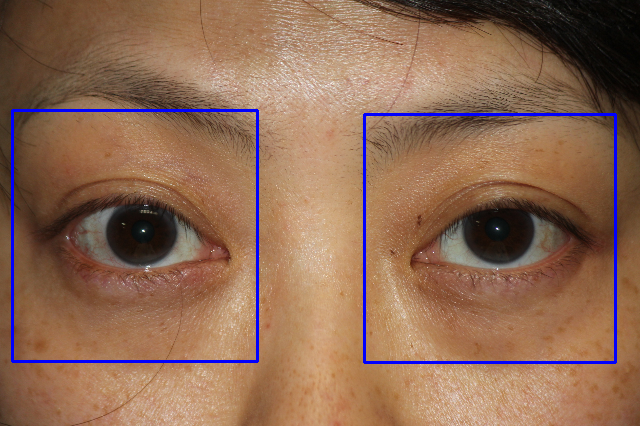

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[356.97629, 192.55211, 595.43823, 432.07135,   0.93754,   1.00000],
        [ 16.90784, 194.51901, 253.55548, 430.33432,   0.92621,   0.00000]])]
診断は left、確率は93.8%です。
img_height: 426, img_width: 640
x1: 357.0, y1: 86.0, x2: 595.0, y2: 325.0


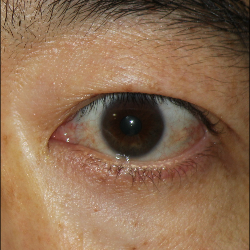

診断は right、確率は92.6%です。
img_height: 426, img_width: 640
x1: 17.0, y1: 88.0, x2: 254.0, y2: 323.0


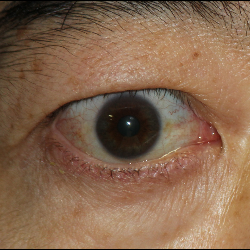

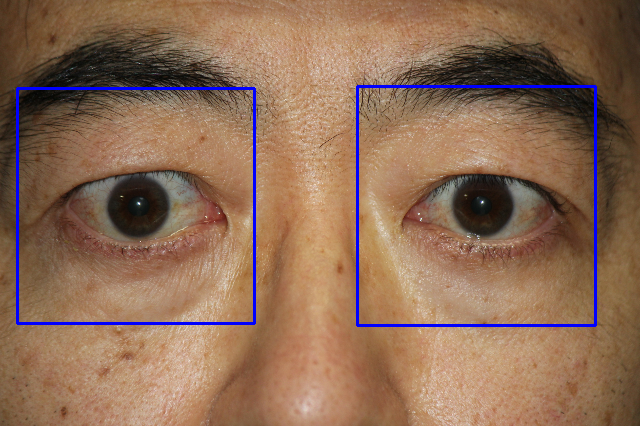

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[404.71640, 224.47751, 639.43146, 468.30148,   0.94826,   1.00000],
        [  7.00619, 228.47958, 230.31451, 455.08652,   0.91466,   0.00000]])]
診断は left、確率は94.8%です。
img_height: 426, img_width: 640
x1: 405.0, y1: 117.0, x2: 639.0, y2: 361.0


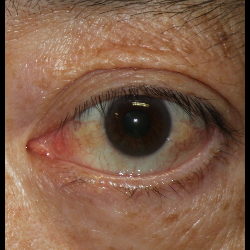

診断は right、確率は91.5%です。
img_height: 426, img_width: 640
x1: 7.0, y1: 121.0, x2: 230.0, y2: 348.0


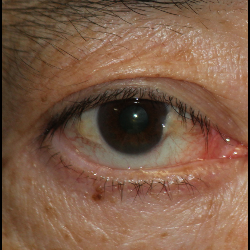

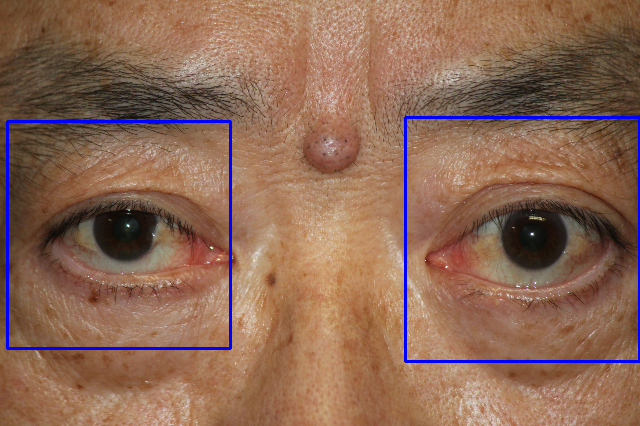

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[360.74091, 227.75598, 615.77472, 484.50977,   0.88652,   1.00000],
        [ 40.82198, 237.98489, 274.19965, 471.16159,   0.86034,   0.00000]])]
診断は left、確率は88.7%です。
img_height: 426, img_width: 640
x1: 361.0, y1: 121.0, x2: 616.0, y2: 378.0


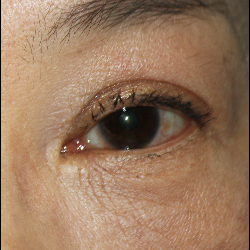

診断は right、確率は86.0%です。
img_height: 426, img_width: 640
x1: 41.0, y1: 131.0, x2: 274.0, y2: 364.0


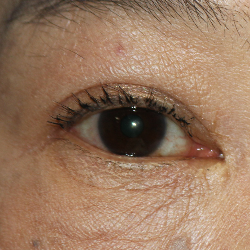

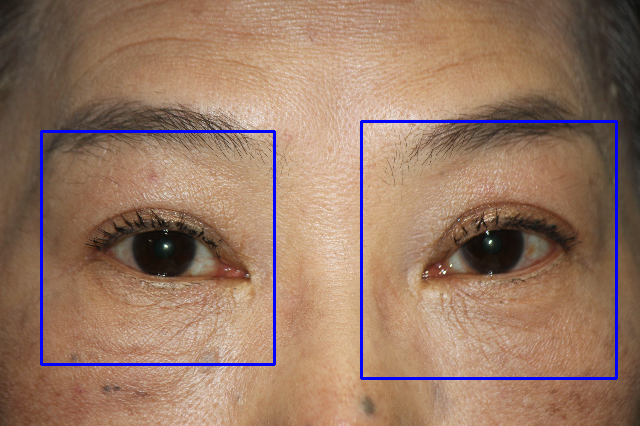

In [14]:
###############################
## バウンディングボックス&切り抜き demo ##
###############################
"""
Letterbox & 250px正方形にリサイズ
"""
import cv2
from google.colab.patches import cv2_imshow
import glob

image_path = glob.glob(f"{orig_dir}/*")
start_index = 1
end_index = 5

class_names = {0: "right", 1: "left"}

for i in range(start_index, end_index + 1):
    img = image_path[i]
    pred = inference(img, weight)  # Ensure this function is defined

    img_cv2 = cv2.imread(img)
    # Assume the inference function requires a certain image size; resize if needed.
    # Replace (640, 640) with the input size expected by your network.
    img_cv2_resized = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    for bbox in pred[0]:
        x1, y1, x2, y2, prob, class_num = torch.round(bbox[:6])

        prob = bbox[4].item()
        class_name = class_names[bbox[5].item()]

        print(f"診断は {class_name}、確率は{prob * 100:.1f}%です。")

        # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
        img_height, img_width, _ = img_cv2_resized.shape[:3]
        print(f"img_height: {img_height}, img_width: {img_width}")
        padding_x = (img_height - min(img_width, img_height)) / 2
        padding_y = (img_width - min(img_width, img_height)) / 2
        x1 = x1 - padding_x
        y1 = y1 - padding_y
        x2 = x2 - padding_x
        y2 = y2 - padding_y
        print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

        # Draw bounding box
        cv2.rectangle(img_cv2_resized, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

        # Crop and save the image
        mag = 640 / img_cv2.shape[1]

        cropped_img = img_cv2[int(y1/mag):int(y2/mag), int(x1/mag):int(x2/mag)] #バウンディングボックスで切り抜き
        letterbox_img = make_letterbox_image(cropped_img)
        cv2_imshow(letterbox_img)

    # After all boxes are drawn, show and save the final image
    cv2_imshow(img_cv2_resized)


In [ ]:
# #################
# ## 切り抜き + 保存 ##
# #################
# """
# Letterbox & 250px正方形にリサイズ
# cropped_dirに保存
# """

# import cv2
# from google.colab.patches import cv2_imshow
# import glob

# image_path = glob.glob(f"{orig_dir}/*")
# start_index = 0
# end_index = len(os.listdir(orig_dir))

# class_names = {0: "R", 1: "L"}

# for i in range(start_index, end_index):
#     img = image_path[i]
#     pred = inference(img, weight)  # Ensure this function is defined

#     img_cv2 = cv2.imread(img)
#     img_cv2_resized = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

#     for bbox in pred[0]:
#         x1, y1, x2, y2, prob, class_num = torch.round(bbox[:6])

#         prob = bbox[4].item()
#         class_name = class_names[bbox[5].item()]

#         #print(f"診断は {class_name}、確率は{prob * 100:.1f}%です。")

#         # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
#         img_height, img_width, _ = img_cv2_resized.shape[:3]
#         #print(f"img_height: {img_height}, img_width: {img_width}")
#         padding_x = (img_height - min(img_width, img_height)) / 2
#         padding_y = (img_width - min(img_width, img_height)) / 2
#         x1 = x1 - padding_x
#         y1 = y1 - padding_y
#         x2 = x2 - padding_x
#         y2 = y2 - padding_y
#         #print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

#         # Crop and save the image
#         mag = 640 / img_cv2.shape[1]
#         cropped_img = img_cv2[int(y1/mag):int(y2/mag), int(x1/mag):int(x2/mag)] #バウンディングボックスで切り抜き
#         letterbox_img = make_letterbox_image(cropped_img)
#         #cv2_imshow(letterbox_img)

#         base_name = os.path.splitext(os.path.basename(img))[0]
#         cropped_img_path = os.path.join(f"{cropped_dir}/cropped_images", f"{base_name}_{class_name}.png")
#         cv2.imwrite(cropped_img_path, letterbox_img)
#         print(f"succefully saved, image {i}: {cropped_img_path}")


In [15]:
import cv2
import glob
import os
import torch

# Load image paths
image_paths = glob.glob(f"{orig_dir}/*")
start_index = 0
end_index = len(image_paths)

# Define class names
class_names = {0: "R", 1: "L"}

# List to hold images with incorrect detections
incorrect_detections = []

# Iterate over images
for i in range(start_index, end_index):
    img_path = image_paths[i]
    pred = inference(img_path, weight)  # Ensure this function is defined and weight is loaded

    img_cv2 = cv2.imread(img_path)
    img_cv2_resized = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # Resize width to 640px

    # Check if the detections are not equal to 2
    if len(pred[0]) != 2:
        incorrect_detections.append((img_path, len(pred[0])))
        continue  # Skip the rest of the loop and do not process this image

    for bbox in pred[0]:
        x1, y1, x2, y2, prob, class_num = torch.round(bbox[:6]).tolist()

        img_height, img_width, _ = img_cv2_resized.shape[:3]
        print(f"img_height: {img_height}, img_width: {img_width}")
        padding_x = (img_height - min(img_width, img_height)) / 2
        padding_y = (img_width - min(img_width, img_height)) / 2
        x1 = x1 - padding_x
        y1 = y1 - padding_y
        x2 = x2 - padding_x
        y2 = y2 - padding_y
        print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
        if x1<0: #バウンディングボックスが左に切れる場合の対処
            x1 = 0
        if y2>img_width: #バウンディングボックスが右に切れる場合の対処
            x2 = img_width

        # Crop and resize logic (assuming make_letterbox_image is defined)
        mag = 640 / img_cv2.shape[1]
        cropped_img = img_cv2[int(y1/mag):int(y2/mag), int(x1/mag):int(x2/mag)]
        letterbox_img = make_letterbox_image(cropped_img)  # Ensure this function is defined

        # Save the cropped image
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        class_name = class_names[class_num]
        cropped_img_path = os.path.join(f"{cropped_dir}", f"{base_name}_{class_name}.png")
        cv2.imwrite(cropped_img_path, letterbox_img)
        print(f"Successfully saved, image {i}: {cropped_img_path}")

# Output images with incorrect detections
print("Images with incorrect detections:")
for img_path, num_detections in incorrect_detections:
    print(f"{img_path} - Number of detections: {num_detections}")
incorrect_paths = [path for path, _ in incorrect_detections]

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.31854, 243.82805, 577.44067, 456.89911,   0.91336,   1.00000],
        [ 39.51377, 234.83932, 263.43124, 463.82101,   0.91219,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 137.0, x2: 577.0, y2: 350.0
Successfully saved, image 0: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/35_L.png
img_height: 426, img_width: 640
x1: 40.0, y1: 128.0, x2: 263.0, y2: 357.0
Successfully saved, image 0: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/35_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.99402, 180.63806, 623.73431, 430.99927,   0.93071,   1.00000],
        [  7.82450, 191.22992, 257.81631, 445.30865,   0.90791,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 74.0, x2: 624.0, y2: 324.0
Successfully saved, image 1: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/36_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 84.0, x2: 258.0, y2: 338.0
Successfully saved, image 1: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/36_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.44312, 221.19670, 614.88452, 468.66077,   0.94960,   1.00000],
        [ 11.64102, 217.32635, 256.98755, 467.57898,   0.94853,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 114.0, x2: 615.0, y2: 362.0
Successfully saved, image 2: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/37_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 110.0, x2: 257.0, y2: 361.0
Successfully saved, image 2: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/37_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.97629, 192.55211, 595.43823, 432.07135,   0.93754,   1.00000],
        [ 16.90784, 194.51901, 253.55548, 430.33432,   0.92621,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 86.0, x2: 595.0, y2: 325.0
Successfully saved, image 3: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/38_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 88.0, x2: 254.0, y2: 323.0
Successfully saved, image 3: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/38_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[404.71640, 224.47751, 639.43146, 468.30148,   0.94826,   1.00000],
        [  7.00619, 228.47958, 230.31451, 455.08652,   0.91466,   0.00000]])]
img_height: 426, img_width: 640
x1: 405.0, y1: 117.0, x2: 639.0, y2: 361.0
Successfully saved, image 4: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/39_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 121.0, x2: 230.0, y2: 348.0
Successfully saved, image 4: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/39_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.74091, 227.75598, 615.77472, 484.50977,   0.88652,   1.00000],
        [ 40.82198, 237.98489, 274.19965, 471.16159,   0.86034,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 121.0, x2: 616.0, y2: 378.0
Successfully saved, image 5: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/40_L.png
img_height: 426, img_width: 640
x1: 41.0, y1: 131.0, x2: 274.0, y2: 364.0
Successfully saved, image 5: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/40_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[381.94641, 196.07820, 638.07880, 461.38055,   0.93894,   1.00000],
        [  7.25984, 197.23970, 265.59778, 456.36066,   0.93753,   0.00000]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 89.0, x2: 638.0, y2: 354.0
Successfully saved, image 6: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/42_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 90.0, x2: 266.0, y2: 349.0
Successfully saved, image 6: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/42_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[366.80179, 209.37323, 606.81775, 450.17004,   0.92789,   1.00000],
        [ 34.83965, 213.99765, 254.03542, 432.98166,   0.92614,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 102.0, x2: 607.0, y2: 343.0
Successfully saved, image 7: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/43_L.png
img_height: 426, img_width: 640
x1: 35.0, y1: 107.0, x2: 254.0, y2: 326.0
Successfully saved, image 7: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/43_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.48423, 204.82735, 223.68982, 418.47626,   0.91045,   0.00000],
        [370.95258, 181.77571, 613.04645, 420.61224,   0.88907,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 98.0, x2: 224.0, y2: 311.0
Successfully saved, image 8: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/44_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 75.0, x2: 613.0, y2: 314.0
Successfully saved, image 8: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/44_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 24.20222, 253.82840, 243.96814, 475.94565,   0.94503,   0.00000],
        [364.32294, 255.52719, 583.11096, 474.43277,   0.93602,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 147.0, x2: 244.0, y2: 369.0
Successfully saved, image 9: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/41_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 149.0, x2: 583.0, y2: 367.0
Successfully saved, image 9: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/41_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[383.24152, 208.71368, 602.95544, 427.47797,   0.94901,   1.00000],
        [ 17.13750, 202.86185, 252.40430, 439.10910,   0.92961,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 102.0, x2: 603.0, y2: 320.0
Successfully saved, image 10: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/45_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 96.0, x2: 252.0, y2: 332.0
Successfully saved, image 10: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/45_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[355.88177, 182.39447, 607.50635, 432.23138,   0.92650,   1.00000],
        [ 21.12861, 190.83572, 261.26617, 430.14963,   0.92516,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 75.0, x2: 608.0, y2: 325.0
Successfully saved, image 11: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/47_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 84.0, x2: 261.0, y2: 323.0
Successfully saved, image 11: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/47_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.18929, 229.90552, 260.23431, 474.23584,   0.91934,   0.00000],
        [373.77435, 217.93561, 632.42780, 476.73834,   0.90173,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 123.0, x2: 260.0, y2: 367.0
Successfully saved, image 12: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/46_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 111.0, x2: 632.0, y2: 370.0
Successfully saved, image 12: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/46_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.04292, 208.94980, 269.01447, 470.78757,   0.94242,   0.00000],
        [360.80243, 210.49419, 624.26294, 472.16302,   0.93521,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 102.0, x2: 269.0, y2: 364.0
Successfully saved, image 13: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/48_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 103.0, x2: 624.0, y2: 365.0
Successfully saved, image 13: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/48_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.55951, 211.84306, 624.75574, 471.24078,   0.94318,   1.00000],
        [ 11.80060, 215.24940, 262.02246, 465.66229,   0.93835,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 105.0, x2: 625.0, y2: 364.0
Successfully saved, image 14: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/49_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 108.0, x2: 262.0, y2: 359.0
Successfully saved, image 14: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/49_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.41099, 219.76373, 256.97919, 442.70099,   0.90152,   0.00000],
        [361.32657, 208.99937, 593.28638, 440.49927,   0.88394,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 113.0, x2: 257.0, y2: 336.0
Successfully saved, image 15: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/50_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 102.0, x2: 593.0, y2: 333.0
Successfully saved, image 15: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/50_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.08890, 218.33005, 254.15054, 446.40378,   0.89983,   0.00000],
        [344.99460, 219.80896, 587.97278, 455.64264,   0.82153,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 111.0, x2: 254.0, y2: 339.0
Successfully saved, image 16: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/51_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 113.0, x2: 588.0, y2: 349.0
Successfully saved, image 16: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/51_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.16325, 230.95178, 250.53102, 462.54382,   0.93788,   0.00000],
        [380.08200, 231.26804, 616.02637, 466.36581,   0.92763,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 124.0, x2: 251.0, y2: 356.0
Successfully saved, image 17: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/52_R.png
img_height: 426, img_width: 640
x1: 380.0, y1: 124.0, x2: 616.0, y2: 359.0
Successfully saved, image 17: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/52_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.72744, 216.65417, 246.35220, 461.01013,   0.94441,   0.00000],
        [360.84131, 222.05058, 611.36572, 471.35101,   0.94094,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 110.0, x2: 246.0, y2: 354.0
Successfully saved, image 18: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/53_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 115.0, x2: 611.0, y2: 364.0
Successfully saved, image 18: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/53_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[337.16006, 202.12215, 611.09631, 477.59412,   0.94068,   1.00000],
        [ 14.58560, 197.79109, 274.31924, 461.25366,   0.93846,   0.00000]])]
img_height: 426, img_width: 640
x1: 337.0, y1: 95.0, x2: 611.0, y2: 371.0
Successfully saved, image 19: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/54_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 91.0, x2: 274.0, y2: 354.0
Successfully saved, image 19: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/54_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.27603, 221.49890, 611.33679, 473.49042,   0.94128,   1.00000],
        [  6.69403, 209.83881, 249.69684, 454.32935,   0.93304,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 114.0, x2: 611.0, y2: 366.0
Successfully saved, image 20: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/55_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 103.0, x2: 250.0, y2: 347.0
Successfully saved, image 20: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/55_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.80725, 205.24019, 272.62842, 461.98340,   0.92893,   0.00000],
        [367.33954, 202.10851, 615.65741, 453.72455,   0.92637,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 98.0, x2: 273.0, y2: 355.0
Successfully saved, image 21: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/56_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 95.0, x2: 616.0, y2: 347.0
Successfully saved, image 21: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/56_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 36.74514, 196.77176, 259.54556, 418.63303,   0.90754,   0.00000],
        [393.68741, 200.91382, 619.23627, 427.45398,   0.89006,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 90.0, x2: 260.0, y2: 312.0
Successfully saved, image 22: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/57_R.png
img_height: 426, img_width: 640
x1: 394.0, y1: 94.0, x2: 619.0, y2: 320.0
Successfully saved, image 22: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/57_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[399.00085, 236.28560, 634.87329, 477.92194,   0.90500,   1.00000],
        [ 22.00404, 224.37550, 253.99062, 458.01556,   0.88676,   0.00000]])]
img_height: 426, img_width: 640
x1: 399.0, y1: 129.0, x2: 635.0, y2: 371.0
Successfully saved, image 23: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/59_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 117.0, x2: 254.0, y2: 351.0
Successfully saved, image 23: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/59_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.83922, 211.32248, 243.42479, 443.20187,   0.87736,   0.00000],
        [368.49515, 208.70168, 626.44177, 477.74921,   0.85673,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 104.0, x2: 243.0, y2: 336.0
Successfully saved, image 24: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/58_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 102.0, x2: 626.0, y2: 371.0
Successfully saved, image 24: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/58_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.95883, 205.09358, 609.18756, 443.55170,   0.92456,   1.00000],
        [ 22.73508, 196.57474, 253.19275, 428.55411,   0.90536,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 98.0, x2: 609.0, y2: 337.0
Successfully saved, image 25: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/60_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 90.0, x2: 253.0, y2: 322.0
Successfully saved, image 25: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/60_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.70169, 191.81458, 603.83588, 440.97070,   0.91701,   1.00000],
        [ 11.61143, 204.49985, 246.11444, 437.38663,   0.74428,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 85.0, x2: 604.0, y2: 334.0
Successfully saved, image 26: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/61_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 97.0, x2: 246.0, y2: 330.0
Successfully saved, image 26: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/61_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.12515, 234.90414, 603.72931, 470.77444,   0.93320,   1.00000],
        [ 35.49576, 213.42511, 277.06943, 456.65363,   0.92268,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 128.0, x2: 604.0, y2: 364.0
Successfully saved, image 27: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/62_L.png
img_height: 426, img_width: 640
x1: 35.0, y1: 106.0, x2: 277.0, y2: 350.0
Successfully saved, image 27: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/62_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[330.36172, 232.98447, 555.97833, 458.06149,   0.92899,   1.00000],
        [ 23.17297, 225.41623, 251.19543, 456.30118,   0.92478,   0.00000]])]
img_height: 426, img_width: 640
x1: 330.0, y1: 126.0, x2: 556.0, y2: 351.0
Successfully saved, image 28: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/63_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 118.0, x2: 251.0, y2: 349.0
Successfully saved, image 28: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/63_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.14647, 250.99815, 240.12593, 468.57159,   0.92173,   0.00000],
        [378.31064, 255.75874, 615.73114, 492.32745,   0.90622,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 144.0, x2: 240.0, y2: 362.0
Successfully saved, image 29: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/64_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 149.0, x2: 616.0, y2: 385.0
Successfully saved, image 29: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/64_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.52997, 226.18481, 229.59802, 461.58124,   0.92898,   0.00000],
        [367.50284, 231.05840, 597.23706, 460.47156,   0.90916,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 119.0, x2: 230.0, y2: 355.0
Successfully saved, image 30: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/65_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 124.0, x2: 597.0, y2: 353.0
Successfully saved, image 30: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/65_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.38239, 224.58670, 612.01685, 472.83212,   0.94212,   1.00000],
        [ 11.06414, 224.10916, 250.30865, 463.13309,   0.93218,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 118.0, x2: 612.0, y2: 366.0
Successfully saved, image 31: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/66_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 117.0, x2: 250.0, y2: 356.0
Successfully saved, image 31: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/66_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.59006, 212.93620, 265.71854, 462.33856,   0.93605,   0.00000],
        [358.36804, 223.07330, 607.91016, 470.90900,   0.93217,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 106.0, x2: 266.0, y2: 355.0
Successfully saved, image 32: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/67_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 116.0, x2: 608.0, y2: 364.0
Successfully saved, image 32: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/67_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[382.85880, 207.43723, 633.42090, 460.76956,   0.93604,   1.00000],
        [ 34.79652, 203.36127, 282.27881, 450.73853,   0.93231,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 100.0, x2: 633.0, y2: 354.0
Successfully saved, image 33: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/68_L.png
img_height: 426, img_width: 640
x1: 35.0, y1: 96.0, x2: 282.0, y2: 344.0
Successfully saved, image 33: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/68_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.19314, 240.46033, 265.26898, 494.99677,   0.93205,   0.00000],
        [364.17422, 222.41098, 621.19714, 480.01804,   0.92409,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 133.0, x2: 265.0, y2: 388.0
Successfully saved, image 34: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/69_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 115.0, x2: 621.0, y2: 373.0
Successfully saved, image 34: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/69_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.45019, 254.60530, 242.84485, 462.00244,   0.92195,   0.00000],
        [370.20901, 235.76784, 579.88538, 444.77881,   0.91827,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 148.0, x2: 243.0, y2: 355.0
Successfully saved, image 35: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/70_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 129.0, x2: 580.0, y2: 338.0
Successfully saved, image 35: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/70_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.33679, 222.00398, 616.05945, 464.10480,   0.93914,   1.00000],
        [ 19.85266, 224.60712, 259.31656, 463.64972,   0.92754,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 115.0, x2: 616.0, y2: 357.0
Successfully saved, image 36: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/71_L.png
img_height: 426, img_width: 640
x1: 20.0, y1: 118.0, x2: 259.0, y2: 357.0
Successfully saved, image 36: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/71_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.91269, 208.96268, 610.18182, 460.80630,   0.93995,   1.00000],
        [ 10.94939, 223.16943, 259.77158, 470.62451,   0.93243,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 102.0, x2: 610.0, y2: 354.0
Successfully saved, image 37: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/72_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 116.0, x2: 260.0, y2: 364.0
Successfully saved, image 37: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/72_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.65032, 190.14720, 267.20264, 435.89001,   0.93525,   0.00000],
        [361.69385, 183.59494, 604.70459, 427.47476,   0.93202,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 83.0, x2: 267.0, y2: 329.0
Successfully saved, image 38: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/73_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 77.0, x2: 605.0, y2: 320.0
Successfully saved, image 38: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/73_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.89722, 211.62396, 613.74805, 466.79700,   0.94475,   1.00000],
        [ 21.27120, 211.25977, 265.28751, 455.64178,   0.94028,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 105.0, x2: 614.0, y2: 360.0
Successfully saved, image 39: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/74_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 104.0, x2: 265.0, y2: 349.0
Successfully saved, image 39: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/74_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.19019, 172.17174, 625.85956, 427.07135,   0.91119,   1.00000],
        [  9.85874, 176.94609, 248.56152, 419.28082,   0.90846,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 65.0, x2: 626.0, y2: 320.0
Successfully saved, image 40: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/75_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 70.0, x2: 249.0, y2: 312.0
Successfully saved, image 40: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/75_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.64238, 206.44901, 248.54469, 425.91794,   0.93162,   0.00000],
        [360.90356, 202.33456, 600.71588, 439.36728,   0.78027,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 99.0, x2: 249.0, y2: 319.0
Successfully saved, image 41: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/76_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 95.0, x2: 601.0, y2: 332.0
Successfully saved, image 41: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/76_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.35643, 179.06012, 245.56502, 423.32727,   0.94044,   0.00000],
        [349.55914, 159.89189, 621.45428, 429.26331,   0.93798,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 72.0, x2: 246.0, y2: 316.0
Successfully saved, image 42: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/77_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 53.0, x2: 621.0, y2: 322.0
Successfully saved, image 42: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/77_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 34.07610, 214.28085, 263.02521, 445.28146,   0.92611,   0.00000],
        [363.35126, 202.76025, 606.98187, 444.28638,   0.89446,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 107.0, x2: 263.0, y2: 338.0
Successfully saved, image 43: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/78_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 96.0, x2: 607.0, y2: 337.0
Successfully saved, image 43: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/78_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.65848, 230.89142, 597.54431, 456.40619,   0.91109,   1.00000],
        [ 39.81180, 229.69553, 249.13342, 441.81003,   0.90716,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 124.0, x2: 598.0, y2: 349.0
Successfully saved, image 44: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/79_L.png
img_height: 426, img_width: 640
x1: 40.0, y1: 123.0, x2: 249.0, y2: 335.0
Successfully saved, image 44: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/79_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.67261, 189.52722, 613.29193, 439.70264,   0.92077,   1.00000],
        [ 13.28017, 185.33392, 276.07410, 455.02808,   0.91932,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 83.0, x2: 613.0, y2: 333.0
Successfully saved, image 45: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/80_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 78.0, x2: 276.0, y2: 348.0
Successfully saved, image 45: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/80_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[367.76041, 223.75443, 599.71375, 452.25259,   0.93039,   1.00000],
        [ 41.30944, 213.44409, 270.02747, 441.10980,   0.92841,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 117.0, x2: 600.0, y2: 345.0
Successfully saved, image 46: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/81_L.png
img_height: 426, img_width: 640
x1: 41.0, y1: 106.0, x2: 270.0, y2: 334.0
Successfully saved, image 46: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/81_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.94544, 194.82791, 239.12646, 428.69302,   0.91839,   0.00000],
        [357.02026, 193.11548, 607.99799, 439.02344,   0.90846,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 88.0, x2: 239.0, y2: 322.0
Successfully saved, image 47: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/82_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 86.0, x2: 608.0, y2: 332.0
Successfully saved, image 47: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/82_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 40.31548, 261.92499, 264.49664, 488.58484,   0.93388,   0.00000],
        [372.59070, 253.51413, 607.68005, 487.48770,   0.92120,   1.00000]])]
img_height: 426, img_width: 640
x1: 40.0, y1: 155.0, x2: 264.0, y2: 382.0
Successfully saved, image 48: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/83_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 147.0, x2: 608.0, y2: 380.0
Successfully saved, image 48: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/83_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.46179, 239.74794, 605.76367, 470.84601,   0.94506,   1.00000],
        [ 27.62105, 226.73413, 260.68152, 461.68884,   0.93740,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 133.0, x2: 606.0, y2: 364.0
Successfully saved, image 49: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/84_L.png
img_height: 426, img_width: 640
x1: 28.0, y1: 120.0, x2: 261.0, y2: 355.0
Successfully saved, image 49: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/84_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.09542, 226.13535, 217.62686, 444.40463,   0.90251,   0.00000],
        [390.53772, 242.24501, 595.79913, 446.19537,   0.81885,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 119.0, x2: 218.0, y2: 337.0
Successfully saved, image 50: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/85_R.png
img_height: 426, img_width: 640
x1: 391.0, y1: 135.0, x2: 596.0, y2: 339.0
Successfully saved, image 50: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/85_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 24.16759, 217.46426, 256.69785, 447.01822,   0.93693,   0.00000],
        [365.51706, 211.19580, 593.86426, 439.18048,   0.92547,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 110.0, x2: 257.0, y2: 340.0
Successfully saved, image 51: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/86_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 104.0, x2: 594.0, y2: 332.0
Successfully saved, image 51: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/86_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.13310, 213.55673, 238.82921, 434.64835,   0.92054,   0.00000],
        [373.27466, 210.20111, 589.19312, 419.79144,   0.85408,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 107.0, x2: 239.0, y2: 328.0
Successfully saved, image 52: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/87_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 103.0, x2: 589.0, y2: 313.0
Successfully saved, image 52: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/87_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[344.55695, 168.02263, 604.19159, 425.39716,   0.93565,   1.00000],
        [ 15.60982, 185.60161, 258.93915, 428.12073,   0.93031,   0.00000]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 61.0, x2: 604.0, y2: 318.0
Successfully saved, image 53: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/89_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 79.0, x2: 259.0, y2: 321.0
Successfully saved, image 53: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/89_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.67465, 210.13469, 615.26569, 448.90497,   0.91710,   1.00000],
        [  8.09370, 206.43542, 269.08337, 470.65100,   0.89685,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 103.0, x2: 615.0, y2: 342.0
Successfully saved, image 54: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/88_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 99.0, x2: 269.0, y2: 364.0
Successfully saved, image 54: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/88_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.54761, 166.07747, 615.88977, 430.38934,   0.94268,   1.00000],
        [  7.95876, 181.96515, 247.38403, 421.74048,   0.94074,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 59.0, x2: 616.0, y2: 323.0
Successfully saved, image 55: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/90_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 75.0, x2: 247.0, y2: 315.0
Successfully saved, image 55: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/90_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.23792, 190.00240, 271.03125, 455.61316,   0.92605,   0.00000],
        [349.99213, 192.83116, 616.28540, 457.47229,   0.92356,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 83.0, x2: 271.0, y2: 349.0
Successfully saved, image 56: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/91_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 86.0, x2: 616.0, y2: 350.0
Successfully saved, image 56: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/91_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[331.73682, 181.48717, 621.66016, 475.38702,   0.94726,   1.00000],
        [ -1.55243, 179.33566, 289.79382, 481.39560,   0.93881,   0.00000]])]
img_height: 426, img_width: 640
x1: 332.0, y1: 74.0, x2: 622.0, y2: 368.0
Successfully saved, image 57: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/92_L.png
img_height: 426, img_width: 640
x1: -2.0, y1: 72.0, x2: 290.0, y2: 374.0
Successfully saved, image 57: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/92_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[4.77155e+01, 2.42593e+02, 2.74956e+02, 4.71281e+02, 7.42113e-01, 0.00000e+00],
        [3.91783e+02, 2.56490e+02, 6.10621e+02, 4.75529e+02, 5.17626e-01, 0.00000e+00],
        [3.85311e+02, 2.49615e+02, 6.11195e+02, 4.79098e+02, 4.12705e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.50611e+02,  1.65252e+02,  6.33692e+02,  4.50854e+02,  9.48056e-01,  1.00000e+00],
        [-5.86945e-01,  1.67622e+02,  2.74215e+02,  4.45494e+02,  9.44776e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 351.0, y1: 58.0, x2: 634.0, y2: 344.0
Successfully saved, image 59: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/94_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 61.0, x2: 274.0, y2: 338.0
Successfully saved, image 59: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/94_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.67907, 211.36810, 236.15012, 441.81146,   0.91816,   0.00000],
        [363.80423, 200.53995, 601.47583, 436.73715,   0.88522,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 104.0, x2: 236.0, y2: 335.0
Successfully saved, image 60: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/95_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 94.0, x2: 601.0, y2: 330.0
Successfully saved, image 60: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/95_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.70819, 183.27087, 634.24170, 466.98816,   0.94515,   1.00000],
        [ -2.87276, 193.40956, 267.83862, 470.21704,   0.94442,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 76.0, x2: 634.0, y2: 360.0
Successfully saved, image 61: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/96_L.png
img_height: 426, img_width: 640
x1: -3.0, y1: 86.0, x2: 268.0, y2: 363.0
Successfully saved, image 61: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/96_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.54379e+02, 2.06319e+02, 6.18946e+02, 4.75718e+02, 9.49669e-01, 1.00000e+00],
        [3.83850e-01, 2.12819e+02, 2.57574e+02, 4.79207e+02, 9.36984e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 99.0, x2: 619.0, y2: 369.0
Successfully saved, image 62: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/97_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 106.0, x2: 258.0, y2: 372.0
Successfully saved, image 62: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/97_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.37370, 221.36237, 270.47906, 476.86505,   0.93161,   0.00000],
        [363.42227, 233.00827, 616.28485, 487.45999,   0.92768,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 114.0, x2: 270.0, y2: 370.0
Successfully saved, image 63: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/936_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 126.0, x2: 616.0, y2: 380.0
Successfully saved, image 63: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/936_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.55056, 192.93782, 248.58047, 421.29669,   0.88997,   0.00000],
        [371.71625, 213.06989, 594.41785, 432.89008,   0.84043,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 86.0, x2: 249.0, y2: 314.0
Successfully saved, image 64: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/99_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 106.0, x2: 594.0, y2: 326.0
Successfully saved, image 64: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/99_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.71417, 223.00543, 621.73151, 466.17133,   0.93400,   1.00000],
        [ 16.59958, 204.46866, 248.40433, 434.49692,   0.87633,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 116.0, x2: 622.0, y2: 359.0
Successfully saved, image 65: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/101_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 97.0, x2: 248.0, y2: 327.0
Successfully saved, image 65: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/101_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[382.31857, 289.56122, 581.50415, 486.02802,   0.89146,   1.00000],
        [ 10.91058, 261.07346, 233.84491, 487.81741,   0.89131,   0.00000]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 183.0, x2: 582.0, y2: 379.0
Successfully saved, image 66: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/100_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 154.0, x2: 234.0, y2: 381.0
Successfully saved, image 66: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/100_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.43604, 249.91824, 618.07831, 504.75003,   0.94679,   1.00000],
        [ 32.20427, 241.65331, 270.66541, 480.18823,   0.92476,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 143.0, x2: 618.0, y2: 398.0
Successfully saved, image 67: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/102_L.png
img_height: 426, img_width: 640
x1: 32.0, y1: 135.0, x2: 271.0, y2: 373.0
Successfully saved, image 67: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/102_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.71002, 222.18423, 593.54785, 460.71878,   0.94146,   1.00000],
        [ 30.88490, 220.02573, 265.96585, 452.35062,   0.93686,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 115.0, x2: 594.0, y2: 354.0
Successfully saved, image 68: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/103_L.png
img_height: 426, img_width: 640
x1: 31.0, y1: 113.0, x2: 266.0, y2: 345.0
Successfully saved, image 68: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/103_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 34.29692, 220.96750, 253.37752, 437.37918,   0.93538,   0.00000],
        [369.41724, 217.42493, 606.77533, 454.40759,   0.93402,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 114.0, x2: 253.0, y2: 330.0
Successfully saved, image 69: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/104_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 110.0, x2: 607.0, y2: 347.0
Successfully saved, image 69: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/104_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.04683, 221.98862, 259.40051, 467.20822,   0.93883,   0.00000],
        [369.03052, 225.10452, 610.32660, 463.55856,   0.91934,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 115.0, x2: 259.0, y2: 360.0
Successfully saved, image 70: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/105_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 118.0, x2: 610.0, y2: 357.0
Successfully saved, image 70: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/105_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[374.71204, 193.22632, 629.10645, 449.50134,   0.90769,   1.00000],
        [ 12.58477, 180.62561, 242.61877, 409.22565,   0.89985,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 86.0, x2: 629.0, y2: 343.0
Successfully saved, image 71: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/106_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 74.0, x2: 243.0, y2: 302.0
Successfully saved, image 71: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/106_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.50821, 204.55521, 263.08102, 450.75406,   0.93900,   0.00000],
        [363.50342, 204.89395, 618.53540, 463.62643,   0.93819,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 98.0, x2: 263.0, y2: 344.0
Successfully saved, image 72: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/107_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 98.0, x2: 619.0, y2: 357.0
Successfully saved, image 72: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/107_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.78358, 191.43353, 242.96965, 418.17023,   0.93131,   0.00000],
        [368.35455, 187.02237, 606.35114, 423.35965,   0.91072,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 84.0, x2: 243.0, y2: 311.0
Successfully saved, image 73: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/108_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 80.0, x2: 606.0, y2: 316.0
Successfully saved, image 73: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/108_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.99724, 213.56468, 244.81966, 439.24451,   0.89218,   0.00000],
        [373.55899, 211.93755, 622.62946, 460.76184,   0.88466,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 107.0, x2: 245.0, y2: 332.0
Successfully saved, image 74: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/109_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 105.0, x2: 623.0, y2: 354.0
Successfully saved, image 74: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/109_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.60064e+02, 2.16707e+02, 6.23989e+02, 4.81157e+02, 9.51146e-01, 1.00000e+00],
        [4.84032e-01, 2.19739e+02, 2.42783e+02, 4.71805e+02, 9.37869e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 110.0, x2: 624.0, y2: 374.0
Successfully saved, image 75: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/112_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 113.0, x2: 243.0, y2: 365.0
Successfully saved, image 75: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/112_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.76671, 209.73355, 249.25072, 456.00955,   0.91971,   0.00000],
        [388.52914, 210.10974, 637.88373, 463.37506,   0.91660,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 103.0, x2: 249.0, y2: 349.0
Successfully saved, image 76: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/110_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 103.0, x2: 638.0, y2: 356.0
Successfully saved, image 76: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/110_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.19688, 239.85989, 223.28622, 439.25388,   0.86994,   0.00000],
        [397.41068, 233.35742, 612.76379, 448.13544,   0.83947,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 133.0, x2: 223.0, y2: 332.0
Successfully saved, image 77: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/111_R.png
img_height: 426, img_width: 640
x1: 397.0, y1: 126.0, x2: 613.0, y2: 341.0
Successfully saved, image 77: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/111_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.67401, 231.85164, 604.58911, 465.53479,   0.93756,   1.00000],
        [ 16.71576, 231.39206, 248.69855, 463.94431,   0.93719,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 125.0, x2: 605.0, y2: 359.0
Successfully saved, image 78: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/113_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 124.0, x2: 249.0, y2: 357.0
Successfully saved, image 78: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/113_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[4.28116e-01, 2.12091e+02, 2.53797e+02, 4.67292e+02, 9.37911e-01, 0.00000e+00],
        [3.50812e+02, 2.15506e+02, 6.20265e+02, 4.84971e+02, 9.07228e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 105.0, x2: 254.0, y2: 360.0
Successfully saved, image 79: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/115_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 109.0, x2: 620.0, y2: 378.0
Successfully saved, image 79: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/115_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.90591, 225.42130, 219.00351, 444.74619,   0.90984,   0.00000],
        [376.51257, 225.93497, 607.40289, 456.11246,   0.65232,   0.00000],
        [372.36450, 228.40613, 604.66254, 456.14124,   0.65117,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  5.45507, 190.16949, 244.72147, 430.78027,   0.93232,   0.00000],
        [351.46591, 180.70676, 607.41840, 433.68295,   0.90885,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 83.0, x2: 245.0, y2: 324.0
Successfully saved, image 81: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/116_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 74.0, x2: 607.0, y2: 327.0
Successfully saved, image 81: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/116_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.15814, 207.60011, 628.08057, 468.37518,   0.93975,   1.00000],
        [  1.85745, 209.67421, 262.02460, 474.17950,   0.93843,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 101.0, x2: 628.0, y2: 361.0
Successfully saved, image 82: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/937_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 103.0, x2: 262.0, y2: 367.0
Successfully saved, image 82: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/937_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.64871, 191.48465, 237.00790, 412.31808,   0.94698,   0.00000],
        [361.76715, 179.16145, 599.44452, 417.34882,   0.94258,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 84.0, x2: 237.0, y2: 305.0
Successfully saved, image 83: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/117_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 72.0, x2: 599.0, y2: 310.0
Successfully saved, image 83: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/117_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.07623, 218.86000, 616.90027, 475.90472,   0.95167,   1.00000],
        [ 13.39324, 211.09972, 262.13422, 462.41101,   0.93134,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 112.0, x2: 617.0, y2: 369.0
Successfully saved, image 84: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/118_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 104.0, x2: 262.0, y2: 355.0
Successfully saved, image 84: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/118_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 36.35865, 241.59987, 233.28110, 440.91528,   0.76683,   0.00000],
        [382.07477, 262.91257, 573.99072, 451.55215,   0.68242,   1.00000],
        [385.42337, 263.67889, 576.08948, 451.74274,   0.61995,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 28.43676, 223.10963, 251.17169, 442.63641,   0.93098,   0.00000],
        [363.10614, 206.29317, 598.50720, 440.58118,   0.88730,   1.00000]])]
img_height: 426, img_width: 640
x1: 28.0, y1: 116.0, x2: 251.0, y2: 336.0
Successfully saved, image 86: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/120_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 99.0, x2: 599.0, y2: 334.0
Successfully saved, image 86: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/120_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.77756, 212.17853, 267.39688, 468.02411,   0.93566,   0.00000],
        [342.25610, 196.38521, 600.45770, 454.51489,   0.93298,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 105.0, x2: 267.0, y2: 361.0
Successfully saved, image 87: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/121_R.png
img_height: 426, img_width: 640
x1: 342.0, y1: 89.0, x2: 600.0, y2: 348.0
Successfully saved, image 87: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/121_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.68752, 271.71234, 250.31953, 491.37872,   0.92754,   0.00000],
        [372.24295, 271.70920, 597.19556, 494.54257,   0.91991,   1.00000]])]
img_height: 426, img_width: 640
x1: 30.0, y1: 165.0, x2: 250.0, y2: 384.0
Successfully saved, image 88: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/124_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 165.0, x2: 597.0, y2: 388.0
Successfully saved, image 88: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/124_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.75452, 217.68219, 617.33832, 461.95776,   0.91506,   1.00000],
        [ 16.11635, 213.76913, 252.03569, 447.62900,   0.91043,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 111.0, x2: 617.0, y2: 355.0
Successfully saved, image 89: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/123_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 107.0, x2: 252.0, y2: 341.0
Successfully saved, image 89: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/123_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[337.01660, 190.73886, 606.64172, 460.33188,   0.90552,   1.00000],
        [  2.11803, 208.09128, 249.64389, 462.84042,   0.89727,   0.00000]])]
img_height: 426, img_width: 640
x1: 337.0, y1: 84.0, x2: 607.0, y2: 353.0
Successfully saved, image 90: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/125_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 101.0, x2: 250.0, y2: 356.0
Successfully saved, image 90: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/125_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[371.23068, 206.67429, 607.28143, 443.80106,   0.93501,   1.00000],
        [ 29.64141, 206.09598, 270.64835, 450.35446,   0.92953,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 100.0, x2: 607.0, y2: 337.0
Successfully saved, image 91: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/122_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 99.0, x2: 271.0, y2: 343.0
Successfully saved, image 91: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/122_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[377.06662, 205.72516, 608.94446, 437.50482,   0.94637,   1.00000],
        [ 19.87836, 203.91087, 252.10815, 434.28137,   0.84619,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 99.0, x2: 609.0, y2: 331.0
Successfully saved, image 92: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/938_L.png
img_height: 426, img_width: 640
x1: 20.0, y1: 97.0, x2: 252.0, y2: 327.0
Successfully saved, image 92: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/938_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.47791, 244.55173, 568.42334, 446.07639,   0.89658,   1.00000],
        [ 41.80424, 246.94554, 233.31627, 438.08124,   0.89510,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 138.0, x2: 568.0, y2: 339.0
Successfully saved, image 93: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/126_L.png
img_height: 426, img_width: 640
x1: 42.0, y1: 140.0, x2: 233.0, y2: 331.0
Successfully saved, image 93: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/126_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.29962, 219.60785, 596.39966, 449.44092,   0.94040,   1.00000],
        [ 29.44662, 219.98767, 251.47870, 439.62604,   0.93652,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 113.0, x2: 596.0, y2: 342.0
Successfully saved, image 94: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/127_L.png
img_height: 426, img_width: 640
x1: 29.0, y1: 113.0, x2: 251.0, y2: 333.0
Successfully saved, image 94: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/127_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[346.78375, 222.35535, 600.39905, 476.75568,   0.94016,   1.00000],
        [ 33.11768, 251.37988, 250.80005, 467.39301,   0.93099,   0.00000]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 115.0, x2: 600.0, y2: 370.0
Successfully saved, image 95: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/128_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 144.0, x2: 251.0, y2: 360.0
Successfully saved, image 95: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/128_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[348.54166, 199.63908, 605.34534, 455.28418,   0.93072,   1.00000],
        [  8.93013, 198.01770, 243.32211, 433.67828,   0.91919,   0.00000]])]
img_height: 426, img_width: 640
x1: 349.0, y1: 93.0, x2: 605.0, y2: 348.0
Successfully saved, image 96: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/129_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 91.0, x2: 243.0, y2: 327.0
Successfully saved, image 96: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/129_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.90094, 172.88295, 613.55261, 434.16150,   0.94076,   1.00000],
        [ 11.19570, 193.08417, 237.88885, 420.35675,   0.93220,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 66.0, x2: 614.0, y2: 327.0
Successfully saved, image 97: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/939_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 86.0, x2: 238.0, y2: 313.0
Successfully saved, image 97: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/939_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.97069e+02, 2.50331e+02, 5.91262e+02, 4.17828e+02, 4.28928e-01, 1.00000e+00],
        [6.00320e+01, 2.28608e+02, 2.42309e+02, 4.13368e+02, 4.10943e-01, 1.00000e+00],
        [5.51381e+01, 2.25193e+02, 2.44504e+02, 4.15004e+02, 3.22865e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.78326, 189.72420, 609.71362, 432.03070,   0.90115,   1.00000],
        [ 27.81654, 194.49738, 245.84221, 413.07239,   0.88806,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 83.0, x2: 610.0, y2: 325.0
Successfully saved, image 99: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/131_L.png
img_height: 426, img_width: 640
x1: 28.0, y1: 87.0, x2: 246.0, y2: 306.0
Successfully saved, image 99: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/131_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[389.55276, 218.08792, 615.42676, 444.45645,   0.94342,   1.00000],
        [ 42.22869, 236.29219, 262.20718, 458.99475,   0.92944,   0.00000]])]
img_height: 426, img_width: 640
x1: 390.0, y1: 111.0, x2: 615.0, y2: 337.0
Successfully saved, image 100: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/133_L.png
img_height: 426, img_width: 640
x1: 42.0, y1: 129.0, x2: 262.0, y2: 352.0
Successfully saved, image 100: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/133_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.93079, 193.07840, 275.41147, 445.81070,   0.93999,   0.00000],
        [347.88812, 183.11710, 607.40570, 444.11221,   0.92841,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 86.0, x2: 275.0, y2: 339.0
Successfully saved, image 101: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/132_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 76.0, x2: 607.0, y2: 337.0
Successfully saved, image 101: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/132_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 40.71386, 224.84488, 266.45557, 448.87991,   0.93257,   0.00000],
        [374.12543, 210.41141, 601.97650, 437.71646,   0.90348,   1.00000]])]
img_height: 426, img_width: 640
x1: 41.0, y1: 118.0, x2: 266.0, y2: 342.0
Successfully saved, image 102: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/134_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 103.0, x2: 602.0, y2: 331.0
Successfully saved, image 102: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/134_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.02428, 207.15233, 249.53363, 458.47345,   0.94049,   0.00000],
        [364.44504, 214.45552, 610.62317, 462.43994,   0.93095,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 100.0, x2: 250.0, y2: 351.0
Successfully saved, image 103: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/135_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 107.0, x2: 611.0, y2: 355.0
Successfully saved, image 103: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/135_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 36.93722, 218.59435, 258.54031, 438.50043,   0.94244,   0.00000],
        [390.77710, 213.55789, 614.18250, 433.57053,   0.93364,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 112.0, x2: 259.0, y2: 332.0
Successfully saved, image 104: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/137_R.png
img_height: 426, img_width: 640
x1: 391.0, y1: 107.0, x2: 614.0, y2: 327.0
Successfully saved, image 104: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/137_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.26434, 178.87277, 604.33124, 418.09012,   0.93363,   1.00000],
        [ 10.08181, 187.36299, 228.72830, 406.94427,   0.92716,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 72.0, x2: 604.0, y2: 311.0
Successfully saved, image 105: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/136_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 80.0, x2: 229.0, y2: 300.0
Successfully saved, image 105: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/136_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  0.75949, 210.83275, 244.23251, 460.20099,   0.93926,   0.00000],
        [391.52295, 217.11160, 640.27710, 478.39456,   0.91550,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 104.0, x2: 244.0, y2: 353.0
Successfully saved, image 106: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/940_R.png
img_height: 426, img_width: 640
x1: 392.0, y1: 110.0, x2: 640.0, y2: 371.0
Successfully saved, image 106: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/940_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[339.06421, 208.31171, 604.67584, 472.80878,   0.93905,   1.00000],
        [  3.01765, 222.66168, 232.75659, 457.92346,   0.92918,   0.00000]])]
img_height: 426, img_width: 640
x1: 339.0, y1: 101.0, x2: 605.0, y2: 366.0
Successfully saved, image 107: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/139_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 116.0, x2: 233.0, y2: 351.0
Successfully saved, image 107: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/139_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.31449, 198.57042, 272.12424, 455.03693,   0.90921,   0.00000],
        [349.89590, 215.08560, 601.07349, 467.18918,   0.86798,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 92.0, x2: 272.0, y2: 348.0
Successfully saved, image 108: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/138_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 108.0, x2: 601.0, y2: 360.0
Successfully saved, image 108: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/138_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.85617, 188.26833, 257.23303, 425.21826,   0.92051,   0.00000],
        [342.38492, 189.01749, 580.09839, 425.76059,   0.89657,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 81.0, x2: 257.0, y2: 318.0
Successfully saved, image 109: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/140_R.png
img_height: 426, img_width: 640
x1: 342.0, y1: 82.0, x2: 580.0, y2: 319.0
Successfully saved, image 109: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/140_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.46153, 183.17560, 243.95908, 425.98798,   0.94432,   0.00000],
        [354.32455, 168.96490, 613.21082, 430.90637,   0.93888,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 76.0, x2: 244.0, y2: 319.0
Successfully saved, image 110: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/141_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 62.0, x2: 613.0, y2: 324.0
Successfully saved, image 110: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/141_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.21155, 186.39296, 255.76465, 432.53937,   0.93806,   0.00000],
        [360.98236, 198.96034, 606.56323, 443.04028,   0.88723,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 79.0, x2: 256.0, y2: 326.0
Successfully saved, image 111: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/142_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 92.0, x2: 607.0, y2: 336.0
Successfully saved, image 111: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/142_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.86829, 217.29013, 577.20648, 435.33524,   0.93193,   1.00000],
        [ 24.43720, 218.62790, 254.40417, 445.40311,   0.92521,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 110.0, x2: 577.0, y2: 328.0
Successfully saved, image 112: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/143_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 112.0, x2: 254.0, y2: 338.0
Successfully saved, image 112: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/143_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.93181, 236.45107, 249.10924, 466.53809,   0.90592,   0.00000],
        [366.42181, 225.81294, 610.23798, 467.74634,   0.89645,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 129.0, x2: 249.0, y2: 360.0
Successfully saved, image 113: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/144_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 119.0, x2: 610.0, y2: 361.0
Successfully saved, image 113: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/144_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.64243, 237.57376, 257.96487, 466.44540,   0.90331,   0.00000],
        [387.34824, 255.06967, 581.12762, 448.17630,   0.89367,   1.00000]])]
img_height: 426, img_width: 640
x1: 30.0, y1: 131.0, x2: 258.0, y2: 359.0
Successfully saved, image 114: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/145_R.png
img_height: 426, img_width: 640
x1: 387.0, y1: 148.0, x2: 581.0, y2: 341.0
Successfully saved, image 114: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/145_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[4.26738e+00, 2.52701e+02, 2.25101e+02, 4.74293e+02, 9.38019e-01, 0.00000e+00],
        [3.72255e+02, 2.59348e+02, 5.96061e+02, 4.75334e+02, 8.67369e-01, 1.00000e+00],
        [3.78488e+02, 2.56974e+02, 5.99274e+02, 4.75651e+02, 2.72081e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.16798, 210.83496, 256.79611, 462.73389,   0.92006,   0.00000],
        [350.09839, 208.36932, 614.56628, 467.51172,   0.91965,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 104.0, x2: 257.0, y2: 356.0
Successfully saved, image 116: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/147_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 101.0, x2: 615.0, y2: 361.0
Successfully saved, image 116: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/147_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.13751, 226.81940, 602.59222, 461.36981,   0.93741,   1.00000],
        [ 11.76379, 227.00525, 248.92972, 464.68988,   0.93266,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 120.0, x2: 603.0, y2: 354.0
Successfully saved, image 117: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/148_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 120.0, x2: 249.0, y2: 358.0
Successfully saved, image 117: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/148_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.54939, 245.13916, 250.05678, 472.85150,   0.91075,   0.00000],
        [370.46356, 235.70905, 612.78564, 480.62305,   0.83147,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 138.0, x2: 250.0, y2: 366.0
Successfully saved, image 118: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/149_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 129.0, x2: 613.0, y2: 374.0
Successfully saved, image 118: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/149_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.02890, 202.99342, 623.80054, 460.31012,   0.93567,   1.00000],
        [  1.25248, 209.08615, 228.49365, 439.47952,   0.92866,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 96.0, x2: 624.0, y2: 353.0
Successfully saved, image 119: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/150_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 102.0, x2: 228.0, y2: 332.0
Successfully saved, image 119: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/150_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.47342, 223.27585, 614.39648, 468.66275,   0.95124,   1.00000],
        [ 12.20154, 222.06821, 256.52710, 465.67599,   0.94500,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 116.0, x2: 614.0, y2: 362.0
Successfully saved, image 120: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/151_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 115.0, x2: 257.0, y2: 359.0
Successfully saved, image 120: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/151_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.88330, 211.92599, 245.83452, 451.95889,   0.93132,   0.00000],
        [362.63751, 219.17877, 603.60114, 460.20392,   0.92695,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 105.0, x2: 246.0, y2: 345.0
Successfully saved, image 121: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/152_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 112.0, x2: 604.0, y2: 353.0
Successfully saved, image 121: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/152_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[381.08630, 218.25586, 630.10126, 468.50732,   0.94227,   1.00000],
        [ 31.93566, 232.69804, 252.51614, 452.82660,   0.92341,   0.00000]])]
img_height: 426, img_width: 640
x1: 381.0, y1: 111.0, x2: 630.0, y2: 362.0
Successfully saved, image 122: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/153_L.png
img_height: 426, img_width: 640
x1: 32.0, y1: 126.0, x2: 253.0, y2: 346.0
Successfully saved, image 122: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/153_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.47928, 196.73471, 610.39435, 440.98428,   0.93237,   1.00000],
        [ 15.10577, 199.46884, 250.53375, 434.80038,   0.92282,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 90.0, x2: 610.0, y2: 334.0
Successfully saved, image 123: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/154_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 92.0, x2: 251.0, y2: 328.0
Successfully saved, image 123: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/154_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.46695, 219.21021, 240.50113, 456.91589,   0.94251,   0.00000],
        [353.17920, 226.57941, 585.76666, 458.58044,   0.92943,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 112.0, x2: 241.0, y2: 350.0
Successfully saved, image 124: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/156_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 120.0, x2: 586.0, y2: 352.0
Successfully saved, image 124: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/156_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 24.38022, 215.89378, 278.03937, 468.83429,   0.93984,   0.00000],
        [357.57458, 231.95370, 606.27594, 479.33786,   0.93363,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 109.0, x2: 278.0, y2: 362.0
Successfully saved, image 125: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/155_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 125.0, x2: 606.0, y2: 372.0
Successfully saved, image 125: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/155_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[380.36066, 229.54343, 611.26917, 458.19778,   0.93029,   1.00000],
        [ 27.04091, 219.03256, 243.54619, 431.85825,   0.91898,   0.00000]])]
img_height: 426, img_width: 640
x1: 380.0, y1: 123.0, x2: 611.0, y2: 351.0
Successfully saved, image 126: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/941_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 112.0, x2: 244.0, y2: 325.0
Successfully saved, image 126: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/941_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.58861, 183.42203, 266.59174, 441.68546,   0.94242,   0.00000],
        [334.05487, 170.02681, 604.98608, 440.82550,   0.93145,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 76.0, x2: 267.0, y2: 335.0
Successfully saved, image 127: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/157_R.png
img_height: 426, img_width: 640
x1: 334.0, y1: 63.0, x2: 605.0, y2: 334.0
Successfully saved, image 127: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/157_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.08163, 199.60388, 259.79727, 466.86322,   0.92955,   0.00000],
        [357.66992, 212.21135, 616.56299, 471.44537,   0.92828,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 93.0, x2: 260.0, y2: 360.0
Successfully saved, image 128: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/158_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 105.0, x2: 617.0, y2: 364.0
Successfully saved, image 128: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/158_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.85419, 208.49718, 567.47357, 411.53503,   0.90300,   1.00000],
        [ 42.33640, 222.16971, 231.85181, 409.92612,   0.81910,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 101.0, x2: 567.0, y2: 305.0
Successfully saved, image 129: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/159_L.png
img_height: 426, img_width: 640
x1: 42.0, y1: 115.0, x2: 232.0, y2: 303.0
Successfully saved, image 129: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/159_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.42119, 220.31512, 242.76042, 450.91571,   0.93613,   0.00000],
        [363.99026, 209.52347, 613.09387, 458.70132,   0.93326,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 113.0, x2: 243.0, y2: 344.0
Successfully saved, image 130: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/160_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 103.0, x2: 613.0, y2: 352.0
Successfully saved, image 130: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/160_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.04971, 218.32669, 606.21021, 464.19333,   0.92648,   1.00000],
        [ 29.63463, 215.08261, 264.35669, 449.80148,   0.92340,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 111.0, x2: 606.0, y2: 357.0
Successfully saved, image 131: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/162_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 108.0, x2: 264.0, y2: 343.0
Successfully saved, image 131: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/162_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.04971, 218.32669, 606.21021, 464.19333,   0.92648,   1.00000],
        [ 29.63463, 215.08261, 264.35669, 449.80148,   0.92340,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 111.0, x2: 606.0, y2: 357.0
Successfully saved, image 132: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/161_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 108.0, x2: 264.0, y2: 343.0
Successfully saved, image 132: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/161_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.57306, 196.26694, 611.36224, 454.43063,   0.93594,   1.00000],
        [ 30.45992, 199.13159, 276.54834, 446.15656,   0.92542,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 89.0, x2: 611.0, y2: 347.0
Successfully saved, image 133: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/945_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 92.0, x2: 277.0, y2: 339.0
Successfully saved, image 133: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/945_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.29285e+01, 2.11056e+02, 2.32358e+02, 4.08433e+02, 7.86863e-01, 0.00000e+00],
        [3.64263e+02, 1.85066e+02, 5.98829e+02, 4.11348e+02, 7.43193e-01, 1.00000e+00],
        [3.73082e+02, 1.92939e+02, 5.90177e+02, 4.04833e+02, 2.52564e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.24744, 190.42076, 625.83112, 451.97534,   0.93253,   1.00000],
        [ 25.15611, 212.48642, 263.02756, 451.11417,   0.92858,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 83.0, x2: 626.0, y2: 345.0
Successfully saved, image 135: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/164_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 105.0, x2: 263.0, y2: 344.0
Successfully saved, image 135: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/164_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.67242, 200.37680, 623.94183, 474.93594,   0.94164,   1.00000],
        [ -2.73367, 186.75041, 263.01144, 459.15649,   0.91753,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 93.0, x2: 624.0, y2: 368.0
Successfully saved, image 136: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/165_L.png
img_height: 426, img_width: 640
x1: -3.0, y1: 80.0, x2: 263.0, y2: 352.0
Successfully saved, image 136: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/165_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.44998, 209.67641, 621.83740, 458.15363,   0.93036,   1.00000],
        [  7.95409, 220.84970, 234.70026, 447.41684,   0.92786,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 103.0, x2: 622.0, y2: 351.0
Successfully saved, image 137: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/166_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 114.0, x2: 235.0, y2: 340.0
Successfully saved, image 137: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/166_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 27.73006, 216.62912, 257.47968, 444.23361,   0.93461,   0.00000],
        [364.36615, 221.41928, 588.51392, 443.94974,   0.92964,   1.00000]])]
img_height: 426, img_width: 640
x1: 28.0, y1: 110.0, x2: 257.0, y2: 337.0
Successfully saved, image 138: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/167_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 114.0, x2: 589.0, y2: 337.0
Successfully saved, image 138: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/167_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[360.54840, 221.76485, 604.13751, 463.32080,   0.93503,   1.00000],
        [ 27.79296, 230.53322, 251.40149, 452.77264,   0.93311,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 115.0, x2: 604.0, y2: 356.0
Successfully saved, image 139: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/168_L.png
img_height: 426, img_width: 640
x1: 28.0, y1: 124.0, x2: 251.0, y2: 346.0
Successfully saved, image 139: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/168_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.92310, 216.05074, 237.64493, 453.15070,   0.93142,   0.00000],
        [360.21204, 220.22604, 613.73907, 472.90982,   0.93037,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 109.0, x2: 238.0, y2: 346.0
Successfully saved, image 140: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/169_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 113.0, x2: 614.0, y2: 366.0
Successfully saved, image 140: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/169_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.79471, 190.37115, 592.29205, 426.69183,   0.91374,   1.00000],
        [ 16.56292, 203.35037, 252.32938, 439.13443,   0.85146,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 83.0, x2: 592.0, y2: 320.0
Successfully saved, image 141: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/946_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 96.0, x2: 252.0, y2: 332.0
Successfully saved, image 141: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/946_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.18826, 235.67891, 610.26636, 478.57391,   0.94955,   1.00000],
        [ 15.92618, 233.77283, 262.92307, 479.19019,   0.94190,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 129.0, x2: 610.0, y2: 372.0
Successfully saved, image 142: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/170_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 127.0, x2: 263.0, y2: 372.0
Successfully saved, image 142: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/170_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.53875, 203.19788, 227.53857, 418.86609,   0.92607,   0.00000],
        [360.15964, 204.68713, 592.72339, 431.22864,   0.90120,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 96.0, x2: 228.0, y2: 312.0
Successfully saved, image 143: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/947_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 98.0, x2: 593.0, y2: 324.0
Successfully saved, image 143: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/947_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.75919, 233.15698, 246.18390, 451.86182,   0.91530,   0.00000],
        [371.77240, 240.24164, 589.49341, 455.70636,   0.90006,   1.00000]])]
img_height: 426, img_width: 640
x1: 30.0, y1: 126.0, x2: 246.0, y2: 345.0
Successfully saved, image 144: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/171_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 133.0, x2: 589.0, y2: 349.0
Successfully saved, image 144: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/171_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.32489, 209.37567, 600.47620, 432.16028,   0.93111,   1.00000],
        [  1.09299, 207.97144, 209.79530, 421.23193,   0.93104,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 102.0, x2: 600.0, y2: 325.0
Successfully saved, image 145: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/172_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 101.0, x2: 210.0, y2: 314.0
Successfully saved, image 145: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/172_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.09174, 185.03677, 249.16757, 413.82059,   0.93420,   0.00000],
        [344.84958, 180.57562, 587.02411, 418.45947,   0.88296,   1.00000]])]
img_height: 426, img_width: 640
x1: 17.0, y1: 78.0, x2: 249.0, y2: 307.0
Successfully saved, image 146: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/173_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 74.0, x2: 587.0, y2: 311.0
Successfully saved, image 146: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/173_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.53046, 182.27332, 240.28232, 410.55432,   0.93992,   0.00000],
        [367.97238, 169.80042, 614.63049, 416.71204,   0.93231,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 75.0, x2: 240.0, y2: 304.0
Successfully saved, image 147: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/174_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 63.0, x2: 615.0, y2: 310.0
Successfully saved, image 147: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/174_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.18044, 208.66937, 243.36404, 450.92834,   0.94355,   0.00000],
        [357.60587, 222.58582, 604.44867, 467.50421,   0.92553,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 102.0, x2: 243.0, y2: 344.0
Successfully saved, image 148: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/175_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 116.0, x2: 604.0, y2: 361.0
Successfully saved, image 148: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/175_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.71994, 206.24628, 612.73553, 460.30872,   0.94255,   1.00000],
        [ 16.93714, 206.57651, 264.23553, 452.18179,   0.93175,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 99.0, x2: 613.0, y2: 353.0
Successfully saved, image 149: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/176_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 100.0, x2: 264.0, y2: 345.0
Successfully saved, image 149: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/176_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 10.28959, 202.20709, 232.14847, 422.06952,   0.91250,   0.00000],
        [353.08173, 180.24939, 616.81293, 439.66357,   0.79864,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 95.0, x2: 232.0, y2: 315.0
Successfully saved, image 150: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/177_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 73.0, x2: 617.0, y2: 333.0
Successfully saved, image 150: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/177_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.21359, 217.19965, 605.18701, 470.13574,   0.94856,   1.00000],
        [  2.68191, 208.54927, 240.68799, 446.62585,   0.94452,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 110.0, x2: 605.0, y2: 363.0
Successfully saved, image 151: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/178_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 102.0, x2: 241.0, y2: 340.0
Successfully saved, image 151: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/178_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[377.54144, 230.28055, 603.56458, 455.21561,   0.94506,   1.00000],
        [ 30.73978, 220.63977, 257.08371, 444.13348,   0.93256,   0.00000]])]
img_height: 426, img_width: 640
x1: 378.0, y1: 123.0, x2: 604.0, y2: 348.0
Successfully saved, image 152: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/948_L.png
img_height: 426, img_width: 640
x1: 31.0, y1: 114.0, x2: 257.0, y2: 337.0
Successfully saved, image 152: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/948_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.27376, 226.13954, 254.71349, 466.40851,   0.93307,   0.00000],
        [376.50690, 218.98087, 608.71521, 450.41989,   0.89212,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 119.0, x2: 255.0, y2: 359.0
Successfully saved, image 153: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/179_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 112.0, x2: 609.0, y2: 343.0
Successfully saved, image 153: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/179_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.76813, 216.12662, 604.50604, 460.47202,   0.93680,   1.00000],
        [ 20.85896, 225.32120, 247.70668, 448.91397,   0.93513,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 109.0, x2: 605.0, y2: 353.0
Successfully saved, image 154: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/949_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 118.0, x2: 248.0, y2: 342.0
Successfully saved, image 154: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/949_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.00211, 217.65807, 249.98975, 473.09772,   0.94293,   0.00000],
        [369.75226, 207.88084, 628.08594, 469.49359,   0.94167,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 111.0, x2: 250.0, y2: 366.0
Successfully saved, image 155: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/180_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 101.0, x2: 628.0, y2: 362.0
Successfully saved, image 155: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/180_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.63403, 244.15829, 609.65289, 488.15738,   0.94259,   1.00000],
        [ 10.09812, 233.73557, 259.32617, 481.13046,   0.92813,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 137.0, x2: 610.0, y2: 381.0
Successfully saved, image 156: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/181_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 127.0, x2: 259.0, y2: 374.0
Successfully saved, image 156: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/181_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.63521, 203.80298, 246.25598, 445.66736,   0.92827,   0.00000],
        [351.90417, 196.59750, 602.58118, 446.11465,   0.84646,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 97.0, x2: 246.0, y2: 339.0
Successfully saved, image 157: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/182_R.png
img_height: 426, img_width: 640
x1: 352.0, y1: 90.0, x2: 603.0, y2: 339.0
Successfully saved, image 157: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/182_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.77487, 184.06958, 620.14832, 441.03455,   0.94959,   1.00000],
        [ 22.47957, 204.26627, 260.36743, 441.57755,   0.93945,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 77.0, x2: 620.0, y2: 334.0
Successfully saved, image 158: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/183_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 97.0, x2: 260.0, y2: 335.0
Successfully saved, image 158: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/183_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[387.56900, 244.47714, 603.21460, 457.97958,   0.84837,   1.00000],
        [ 54.06001, 259.69467, 249.00375, 452.74765,   0.75915,   0.00000]])]
img_height: 426, img_width: 640
x1: 388.0, y1: 137.0, x2: 603.0, y2: 351.0
Successfully saved, image 159: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/184_L.png
img_height: 426, img_width: 640
x1: 54.0, y1: 153.0, x2: 249.0, y2: 346.0
Successfully saved, image 159: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/184_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.86413, 234.31964, 244.20758, 459.32172,   0.91969,   0.00000],
        [367.75110, 243.91531, 588.00153, 459.45316,   0.77666,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 127.0, x2: 244.0, y2: 352.0
Successfully saved, image 160: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/185_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 137.0, x2: 588.0, y2: 352.0
Successfully saved, image 160: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/185_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.67437e+02, 1.95996e+02, 6.05598e+02, 4.34714e+02, 8.02312e-01, 1.00000e+00],
        [2.41513e+01, 2.06001e+02, 2.57420e+02, 4.40410e+02, 4.72667e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 89.0, x2: 606.0, y2: 328.0
Successfully saved, image 161: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/186_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 99.0, x2: 257.0, y2: 333.0
Successfully saved, image 161: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/186_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.47778, 235.33191, 259.52991, 467.61401,   0.93760,   0.00000],
        [358.36835, 233.13260, 595.10059, 468.80075,   0.89733,   1.00000]])]
img_height: 426, img_width: 640
x1: 25.0, y1: 128.0, x2: 260.0, y2: 361.0
Successfully saved, image 162: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/187_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 126.0, x2: 595.0, y2: 362.0
Successfully saved, image 162: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/187_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.22284, 215.52777, 601.66095, 447.53015,   0.91973,   1.00000],
        [ 22.79833, 226.17334, 242.76907, 444.74146,   0.85710,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 109.0, x2: 602.0, y2: 341.0
Successfully saved, image 163: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/188_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 119.0, x2: 243.0, y2: 338.0
Successfully saved, image 163: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/188_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.06061, 175.83655, 620.20386, 439.66333,   0.94506,   1.00000],
        [  5.29395, 173.16916, 249.99707, 417.12527,   0.94491,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 69.0, x2: 620.0, y2: 333.0
Successfully saved, image 164: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/189_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 66.0, x2: 250.0, y2: 310.0
Successfully saved, image 164: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/189_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.53107, 215.32648, 630.89343, 479.64331,   0.95236,   1.00000],
        [ -1.03451, 203.02866, 242.12491, 458.48074,   0.94040,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 108.0, x2: 631.0, y2: 373.0
Successfully saved, image 165: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/190_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 96.0, x2: 242.0, y2: 351.0
Successfully saved, image 165: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/190_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.89929, 194.26309, 613.22321, 449.31046,   0.93745,   1.00000],
        [ 12.59149, 198.38046, 257.52563, 441.49722,   0.93646,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 87.0, x2: 613.0, y2: 342.0
Successfully saved, image 166: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/191_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 91.0, x2: 258.0, y2: 334.0
Successfully saved, image 166: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/191_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[339.46988, 188.29149, 599.34790, 447.75610,   0.94217,   1.00000],
        [  4.47343, 202.16843, 247.91011, 447.26328,   0.92431,   0.00000]])]
img_height: 426, img_width: 640
x1: 339.0, y1: 81.0, x2: 599.0, y2: 341.0
Successfully saved, image 167: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/192_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 95.0, x2: 248.0, y2: 340.0
Successfully saved, image 167: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/192_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.83136, 213.14929, 240.34604, 439.12537,   0.92809,   0.00000],
        [345.18472, 214.75250, 577.05994, 446.57562,   0.92587,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 106.0, x2: 240.0, y2: 332.0
Successfully saved, image 168: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/193_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 108.0, x2: 577.0, y2: 340.0
Successfully saved, image 168: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/193_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.93471, 194.24042, 260.85181, 438.50671,   0.93320,   0.00000],
        [351.80463, 169.95140, 615.34637, 434.88690,   0.92560,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 87.0, x2: 261.0, y2: 332.0
Successfully saved, image 169: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/194_R.png
img_height: 426, img_width: 640
x1: 352.0, y1: 63.0, x2: 615.0, y2: 328.0
Successfully saved, image 169: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/194_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.79990e-01, 2.23076e+02, 2.31674e+02, 4.59629e+02, 9.28416e-01, 0.00000e+00],
        [3.79263e+02, 2.11090e+02, 6.32126e+02, 4.63046e+02, 9.00431e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 116.0, x2: 232.0, y2: 353.0
Successfully saved, image 170: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/195_R.png
img_height: 426, img_width: 640
x1: 379.0, y1: 104.0, x2: 632.0, y2: 356.0
Successfully saved, image 170: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/195_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.47396, 249.07028, 235.16336, 458.79739,   0.86860,   0.00000],
        [389.16211, 229.50177, 631.46472, 476.72504,   0.83289,   1.00000]])]
img_height: 426, img_width: 640
x1: 25.0, y1: 142.0, x2: 235.0, y2: 352.0
Successfully saved, image 171: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/196_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 123.0, x2: 631.0, y2: 370.0
Successfully saved, image 171: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/196_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.63635, 187.88788, 237.54736, 409.07996,   0.90339,   0.00000],
        [379.33136, 180.70010, 611.07349, 412.51828,   0.89203,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 81.0, x2: 238.0, y2: 302.0
Successfully saved, image 172: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/197_R.png
img_height: 426, img_width: 640
x1: 379.0, y1: 74.0, x2: 611.0, y2: 306.0
Successfully saved, image 172: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/197_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.51154, 196.45795, 616.51331, 445.74957,   0.94538,   1.00000],
        [ 30.27728, 199.81453, 262.22760, 432.97644,   0.93811,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 89.0, x2: 617.0, y2: 339.0
Successfully saved, image 173: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/198_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 93.0, x2: 262.0, y2: 326.0
Successfully saved, image 173: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/198_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[362.01447, 190.46135, 618.44769, 444.73572,   0.94667,   1.00000],
        [  4.19850, 196.03952, 237.66374, 430.08389,   0.93863,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 83.0, x2: 618.0, y2: 338.0
Successfully saved, image 174: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/200_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 89.0, x2: 238.0, y2: 323.0
Successfully saved, image 174: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/200_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.19791, 220.24603, 597.22522, 448.19952,   0.93516,   1.00000],
        [ 46.23287, 224.79266, 257.30777, 436.14783,   0.92962,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 113.0, x2: 597.0, y2: 341.0
Successfully saved, image 175: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/199_L.png
img_height: 426, img_width: 640
x1: 46.0, y1: 118.0, x2: 257.0, y2: 329.0
Successfully saved, image 175: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/199_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.05360, 219.85669, 239.98785, 447.28040,   0.94410,   0.00000],
        [340.94952, 212.86241, 590.39191, 460.60931,   0.92660,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 113.0, x2: 240.0, y2: 340.0
Successfully saved, image 176: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/201_R.png
img_height: 426, img_width: 640
x1: 341.0, y1: 106.0, x2: 590.0, y2: 354.0
Successfully saved, image 176: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/201_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.41202, 213.63898, 257.51843, 468.32782,   0.94687,   0.00000],
        [364.78693, 206.18362, 625.83923, 469.44406,   0.94263,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 107.0, x2: 258.0, y2: 361.0
Successfully saved, image 177: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/950_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 99.0, x2: 626.0, y2: 362.0
Successfully saved, image 177: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/950_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[387.23553, 252.46912, 621.12372, 484.24744,   0.94191,   1.00000],
        [ 17.61658, 253.87173, 251.96356, 486.52908,   0.94069,   0.00000]])]
img_height: 426, img_width: 640
x1: 387.0, y1: 145.0, x2: 621.0, y2: 377.0
Successfully saved, image 178: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/202_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 147.0, x2: 252.0, y2: 380.0
Successfully saved, image 178: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/202_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 34.00362, 225.63113, 243.18892, 434.90866,   0.92041,   0.00000],
        [366.11346, 242.07227, 589.48962, 463.95068,   0.81554,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 119.0, x2: 243.0, y2: 328.0
Successfully saved, image 179: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/203_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 135.0, x2: 589.0, y2: 357.0
Successfully saved, image 179: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/203_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.38515, 263.90970, 208.97905, 449.07852,   0.92088,   0.00000],
        [393.29337, 239.93677, 597.57886, 442.24634,   0.90253,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 157.0, x2: 209.0, y2: 342.0
Successfully saved, image 180: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/951_R.png
img_height: 426, img_width: 640
x1: 393.0, y1: 133.0, x2: 598.0, y2: 335.0
Successfully saved, image 180: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/951_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.43451, 210.83430, 630.31677, 488.20392,   0.93667,   1.00000],
        [  3.73724, 225.50403, 248.31882, 470.70276,   0.89500,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 104.0, x2: 630.0, y2: 381.0
Successfully saved, image 181: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/204_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 119.0, x2: 248.0, y2: 364.0
Successfully saved, image 181: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/204_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.08862, 219.98218, 606.34851, 468.15033,   0.94359,   1.00000],
        [ 16.84645, 236.55399, 249.72725, 470.40628,   0.93061,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 113.0, x2: 606.0, y2: 361.0
Successfully saved, image 182: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/205_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 130.0, x2: 250.0, y2: 363.0
Successfully saved, image 182: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/205_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.42931, 197.66914, 233.88225, 428.47900,   0.91357,   0.00000],
        [357.75742, 193.33023, 594.34113, 428.29813,   0.90304,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 91.0, x2: 234.0, y2: 321.0
Successfully saved, image 183: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/206_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 86.0, x2: 594.0, y2: 321.0
Successfully saved, image 183: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/206_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.56071, 186.63171, 248.99754, 412.69244,   0.91979,   0.00000],
        [335.57465, 184.14639, 572.85101, 418.35141,   0.90879,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 80.0, x2: 249.0, y2: 306.0
Successfully saved, image 184: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/208_R.png
img_height: 426, img_width: 640
x1: 336.0, y1: 77.0, x2: 573.0, y2: 311.0
Successfully saved, image 184: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/208_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[371.73911, 217.48785, 605.13995, 450.38831,   0.94500,   1.00000],
        [ 52.46620, 216.06409, 275.42908, 440.74255,   0.93148,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 110.0, x2: 605.0, y2: 343.0
Successfully saved, image 185: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/207_L.png
img_height: 426, img_width: 640
x1: 52.0, y1: 109.0, x2: 275.0, y2: 334.0
Successfully saved, image 185: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/207_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.38321, 230.62134, 606.77625, 464.02734,   0.93163,   1.00000],
        [ 20.74641, 201.83844, 251.94971, 437.62830,   0.91431,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 124.0, x2: 607.0, y2: 357.0
Successfully saved, image 186: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/210_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 95.0, x2: 252.0, y2: 331.0
Successfully saved, image 186: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/210_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.54419, 226.61252, 613.05829, 456.93326,   0.90499,   1.00000],
        [ 54.24556, 215.76819, 266.08917, 432.20630,   0.84132,   0.00000]])]
img_height: 426, img_width: 640
x1: 384.0, y1: 120.0, x2: 613.0, y2: 350.0
Successfully saved, image 187: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/209_L.png
img_height: 426, img_width: 640
x1: 54.0, y1: 109.0, x2: 266.0, y2: 325.0
Successfully saved, image 187: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/209_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  9.63751, 193.19466, 232.65173, 420.37036,   0.84864,   0.00000],
        [352.49713, 177.13162, 611.37500, 428.65079,   0.82117,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 86.0, x2: 233.0, y2: 313.0
Successfully saved, image 188: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/211_R.png
img_height: 426, img_width: 640
x1: 352.0, y1: 70.0, x2: 611.0, y2: 322.0
Successfully saved, image 188: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/211_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  9.60084, 222.09563, 240.40439, 454.49500,   0.94731,   0.00000],
        [366.25348, 208.80307, 606.19202, 450.46243,   0.94538,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 115.0, x2: 240.0, y2: 347.0
Successfully saved, image 189: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/212_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 102.0, x2: 606.0, y2: 343.0
Successfully saved, image 189: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/212_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.80166, 220.80214, 251.25681, 450.92682,   0.93507,   0.00000],
        [358.47662, 209.88580, 590.44354, 442.82983,   0.92815,   1.00000]])]
img_height: 426, img_width: 640
x1: 17.0, y1: 114.0, x2: 251.0, y2: 344.0
Successfully saved, image 190: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/213_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 103.0, x2: 590.0, y2: 336.0
Successfully saved, image 190: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/213_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.40900, 196.19080, 230.99902, 422.08441,   0.93553,   0.00000],
        [352.50107, 198.86206, 565.18854, 410.55688,   0.91972,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 89.0, x2: 231.0, y2: 315.0
Successfully saved, image 191: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/214_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 92.0, x2: 565.0, y2: 304.0
Successfully saved, image 191: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/214_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.70420, 215.03818, 235.31595, 441.86722,   0.92960,   0.00000],
        [372.68460, 205.78452, 616.39661, 450.11880,   0.89316,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 108.0, x2: 235.0, y2: 335.0
Successfully saved, image 192: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/215_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 99.0, x2: 616.0, y2: 343.0
Successfully saved, image 192: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/215_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.86525, 212.09399, 265.20087, 463.48840,   0.94147,   0.00000],
        [355.04150, 196.25540, 612.11432, 453.26804,   0.93601,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 105.0, x2: 265.0, y2: 356.0
Successfully saved, image 193: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/952_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 89.0, x2: 612.0, y2: 346.0
Successfully saved, image 193: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/952_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.25865, 187.01163, 250.82179, 425.04764,   0.93594,   0.00000],
        [360.20227, 199.69633, 606.86139, 444.06537,   0.89568,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 80.0, x2: 251.0, y2: 318.0
Successfully saved, image 194: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/216_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 93.0, x2: 607.0, y2: 337.0
Successfully saved, image 194: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/216_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.64970, 228.80174, 225.63824, 445.96631,   0.91737,   0.00000],
        [363.03802, 208.16278, 589.10803, 427.61169,   0.81757,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 122.0, x2: 226.0, y2: 339.0
Successfully saved, image 195: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/217_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 101.0, x2: 589.0, y2: 321.0
Successfully saved, image 195: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/217_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.50004, 215.07397, 251.41263, 466.07312,   0.93890,   0.00000],
        [327.43466, 209.65367, 617.17859, 491.99866,   0.75139,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 108.0, x2: 251.0, y2: 359.0
Successfully saved, image 196: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/218_R.png
img_height: 426, img_width: 640
x1: 327.0, y1: 103.0, x2: 617.0, y2: 385.0
Successfully saved, image 196: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/218_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.06909, 211.84013, 609.47864, 468.13019,   0.94383,   1.00000],
        [ 23.19346, 214.96674, 265.22177, 455.76862,   0.93582,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 105.0, x2: 609.0, y2: 361.0
Successfully saved, image 197: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/953_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 108.0, x2: 265.0, y2: 349.0
Successfully saved, image 197: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/953_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[379.85413, 243.43860, 617.09387, 478.61475,   0.88970,   1.00000],
        [ 50.51693, 246.43503, 282.27383, 477.55087,   0.86640,   0.00000]])]
img_height: 426, img_width: 640
x1: 380.0, y1: 136.0, x2: 617.0, y2: 372.0
Successfully saved, image 198: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/219_L.png
img_height: 426, img_width: 640
x1: 51.0, y1: 139.0, x2: 282.0, y2: 371.0
Successfully saved, image 198: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/219_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.24111, 225.14819, 260.48441, 449.19928,   0.92311,   0.00000],
        [378.07166, 217.61865, 623.57098, 462.79163,   0.90860,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 118.0, x2: 260.0, y2: 342.0
Successfully saved, image 199: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/954_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 111.0, x2: 624.0, y2: 356.0
Successfully saved, image 199: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/954_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.72144, 229.81151, 616.53101, 478.00293,   0.93210,   1.00000],
        [ 25.50266, 220.24173, 262.66641, 457.05746,   0.92827,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 123.0, x2: 617.0, y2: 371.0
Successfully saved, image 200: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/220_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 113.0, x2: 263.0, y2: 350.0
Successfully saved, image 200: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/220_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[382.46918, 211.87027, 635.92371, 471.95175,   0.93961,   1.00000],
        [  2.14922, 204.72969, 255.12506, 461.04492,   0.93853,   0.00000]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 105.0, x2: 636.0, y2: 365.0
Successfully saved, image 201: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/221_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 98.0, x2: 255.0, y2: 354.0
Successfully saved, image 201: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/221_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.52908, 221.03677, 609.89490, 466.28098,   0.92093,   1.00000],
        [  4.70037, 197.81323, 253.03342, 448.06750,   0.90233,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 114.0, x2: 610.0, y2: 359.0
Successfully saved, image 202: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/222_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 91.0, x2: 253.0, y2: 341.0
Successfully saved, image 202: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/222_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[340.00372, 172.33044, 608.43860, 439.89984,   0.94173,   1.00000],
        [ 13.71785, 193.79875, 251.37932, 429.23529,   0.93951,   0.00000]])]
img_height: 426, img_width: 640
x1: 340.0, y1: 65.0, x2: 608.0, y2: 333.0
Successfully saved, image 203: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/223_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 87.0, x2: 251.0, y2: 322.0
Successfully saved, image 203: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/223_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.52814, 184.26257, 249.51071, 433.24670,   0.93385,   0.00000],
        [334.32568, 162.68916, 621.50189, 450.38666,   0.93316,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 77.0, x2: 250.0, y2: 326.0
Successfully saved, image 204: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/224_R.png
img_height: 426, img_width: 640
x1: 334.0, y1: 56.0, x2: 622.0, y2: 343.0
Successfully saved, image 204: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/224_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.99017, 201.63666, 581.02612, 419.19501,   0.94153,   1.00000],
        [ 26.53742, 207.30960, 229.05560, 409.47000,   0.94052,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 95.0, x2: 581.0, y2: 312.0
Successfully saved, image 205: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/225_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 100.0, x2: 229.0, y2: 302.0
Successfully saved, image 205: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/225_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.89211, 216.62355, 261.64508, 477.03058,   0.93628,   0.00000],
        [354.85324, 212.11661, 612.00854, 470.73691,   0.93237,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 110.0, x2: 262.0, y2: 370.0
Successfully saved, image 206: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/226_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 105.0, x2: 612.0, y2: 364.0
Successfully saved, image 206: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/226_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[335.72507, 174.78235, 612.33533, 454.02032,   0.94922,   1.00000],
        [  0.96975, 192.29819, 243.47519, 443.53305,   0.92860,   0.00000]])]
img_height: 426, img_width: 640
x1: 336.0, y1: 68.0, x2: 612.0, y2: 347.0
Successfully saved, image 207: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/227_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 85.0, x2: 243.0, y2: 337.0
Successfully saved, image 207: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/227_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.30849, 190.09171, 235.08585, 424.99136,   0.85935,   0.00000],
        [331.02869, 184.06883, 621.52209, 464.56366,   0.83254,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 83.0, x2: 235.0, y2: 318.0
Successfully saved, image 208: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/228_R.png
img_height: 426, img_width: 640
x1: 331.0, y1: 77.0, x2: 622.0, y2: 358.0
Successfully saved, image 208: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/228_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[393.83716, 209.06938, 641.67944, 470.21204,   0.94469,   1.00000],
        [  1.07659, 215.86061, 249.71841, 468.81543,   0.94184,   0.00000]])]
img_height: 426, img_width: 640
x1: 394.0, y1: 102.0, x2: 642.0, y2: 363.0
Successfully saved, image 209: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/229_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 109.0, x2: 250.0, y2: 362.0
Successfully saved, image 209: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/229_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.26926, 200.57631, 633.31824, 470.81641,   0.93501,   1.00000],
        [  3.85821, 201.99991, 256.16370, 459.42709,   0.93155,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 94.0, x2: 633.0, y2: 364.0
Successfully saved, image 210: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/230_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 95.0, x2: 256.0, y2: 352.0
Successfully saved, image 210: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/230_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -3.59606, 192.57227, 247.61041, 471.81195,   0.93927,   0.00000],
        [358.23108, 196.24561, 633.30853, 474.75787,   0.93855,   1.00000]])]
img_height: 426, img_width: 640
x1: -4.0, y1: 86.0, x2: 248.0, y2: 365.0
Successfully saved, image 211: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/231_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 89.0, x2: 633.0, y2: 368.0
Successfully saved, image 211: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/231_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.43817, 210.19516, 624.22589, 468.98672,   0.92424,   1.00000],
        [  6.67961, 219.63766, 248.45628, 459.55789,   0.90498,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 103.0, x2: 624.0, y2: 362.0
Successfully saved, image 212: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/232_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 113.0, x2: 248.0, y2: 353.0
Successfully saved, image 212: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/232_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.60864, 226.10968, 621.82538, 470.87842,   0.94178,   1.00000],
        [ 32.60480, 214.79030, 259.77051, 440.86865,   0.93434,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 119.0, x2: 622.0, y2: 364.0
Successfully saved, image 213: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/233_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 108.0, x2: 260.0, y2: 334.0
Successfully saved, image 213: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/233_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[344.86353, 221.74432, 591.52942, 464.71533,   0.94000,   1.00000],
        [ 21.97172, 212.00839, 268.99106, 457.78793,   0.93170,   0.00000]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 115.0, x2: 592.0, y2: 358.0
Successfully saved, image 214: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/955_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 105.0, x2: 269.0, y2: 351.0
Successfully saved, image 214: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/955_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[353.14471, 220.73056, 585.24731, 446.91458,   0.89311,   1.00000],
        [  9.61130, 233.97531, 239.73813, 463.25534,   0.88281,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 114.0, x2: 585.0, y2: 340.0
Successfully saved, image 215: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/234_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 127.0, x2: 240.0, y2: 356.0
Successfully saved, image 215: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/234_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.71823, 231.22321, 588.44666, 451.54376,   0.87728,   1.00000],
        [ 26.17673, 224.50455, 257.19409, 458.74832,   0.86799,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 124.0, x2: 588.0, y2: 345.0
Successfully saved, image 216: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/235_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 118.0, x2: 257.0, y2: 352.0
Successfully saved, image 216: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/235_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.44397, 236.26559, 594.62335, 475.87961,   0.93470,   1.00000],
        [ 16.81665, 211.38388, 259.54160, 452.28122,   0.93090,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 129.0, x2: 595.0, y2: 369.0
Successfully saved, image 217: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/236_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 104.0, x2: 260.0, y2: 345.0
Successfully saved, image 217: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/236_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.53397, 178.83575, 610.34003, 422.30920,   0.93327,   1.00000],
        [ 11.56681, 191.76932, 231.00098, 414.51981,   0.86348,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 72.0, x2: 610.0, y2: 315.0
Successfully saved, image 218: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/237_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 85.0, x2: 231.0, y2: 308.0
Successfully saved, image 218: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/237_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.24449, 226.38043, 273.74561, 465.61121,   0.83652,   1.00000],
        [361.01056, 229.17947, 602.23871, 471.14212,   0.71816,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 119.0, x2: 274.0, y2: 359.0
Successfully saved, image 219: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/239_L.png
img_height: 426, img_width: 640
x1: 361.0, y1: 122.0, x2: 602.0, y2: 364.0
Successfully saved, image 219: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/239_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 27.99998, 212.40808, 235.99268, 421.25372,   0.91304,   0.00000],
        [369.38940, 196.36508, 606.80310, 432.39236,   0.88087,   1.00000]])]
img_height: 426, img_width: 640
x1: 28.0, y1: 105.0, x2: 236.0, y2: 314.0
Successfully saved, image 220: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/238_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 89.0, x2: 607.0, y2: 325.0
Successfully saved, image 220: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/238_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.29279, 196.98505, 613.41907, 449.88354,   0.90221,   1.00000],
        [  7.44954, 204.52133, 240.15868, 438.82785,   0.88002,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 90.0, x2: 613.0, y2: 343.0
Successfully saved, image 221: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/240_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 98.0, x2: 240.0, y2: 332.0
Successfully saved, image 221: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/240_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[346.21960, 207.02704, 589.80078, 450.33722,   0.93078,   1.00000],
        [ 22.68310, 214.35115, 259.17795, 448.11700,   0.92734,   0.00000]])]
img_height: 426, img_width: 640
x1: 346.0, y1: 100.0, x2: 590.0, y2: 343.0
Successfully saved, image 222: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/241_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 107.0, x2: 259.0, y2: 341.0
Successfully saved, image 222: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/241_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[381.92529, 205.85141, 629.64850, 457.13174,   0.94618,   1.00000],
        [ 21.94287, 214.68997, 258.15381, 448.43765,   0.93464,   0.00000]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 99.0, x2: 630.0, y2: 350.0
Successfully saved, image 223: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/243_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 108.0, x2: 258.0, y2: 341.0
Successfully saved, image 223: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/243_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.37259, 183.99573, 586.63257, 409.12128,   0.94519,   1.00000],
        [  5.70576, 183.21788, 228.15739, 405.63391,   0.94071,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 77.0, x2: 587.0, y2: 302.0
Successfully saved, image 224: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/242_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 76.0, x2: 228.0, y2: 299.0
Successfully saved, image 224: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/242_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.66212, 244.85295, 236.46190, 463.64392,   0.84345,   0.00000],
        [360.16101, 228.46103, 604.42810, 471.58572,   0.83504,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 138.0, x2: 236.0, y2: 357.0
Successfully saved, image 225: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/244_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 121.0, x2: 604.0, y2: 365.0
Successfully saved, image 225: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/244_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 28.03697, 203.48894, 241.11794, 416.90564,   0.93763,   0.00000],
        [353.22708, 201.46967, 561.40698, 407.15338,   0.92812,   1.00000]])]
img_height: 426, img_width: 640
x1: 28.0, y1: 96.0, x2: 241.0, y2: 310.0
Successfully saved, image 226: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/245_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 94.0, x2: 561.0, y2: 300.0
Successfully saved, image 226: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/245_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.41953, 195.84352, 266.40570, 470.95898,   0.91497,   0.00000],
        [338.65149, 174.98122, 620.07788, 454.70190,   0.79701,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 89.0, x2: 266.0, y2: 364.0
Successfully saved, image 227: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/246_R.png
img_height: 426, img_width: 640
x1: 339.0, y1: 68.0, x2: 620.0, y2: 348.0
Successfully saved, image 227: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/246_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.97433, 186.82870, 253.96838, 436.32736,   0.93238,   0.00000],
        [338.12451, 192.26126, 608.61560, 456.96024,   0.93025,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 80.0, x2: 254.0, y2: 329.0
Successfully saved, image 228: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/247_R.png
img_height: 426, img_width: 640
x1: 338.0, y1: 85.0, x2: 609.0, y2: 350.0
Successfully saved, image 228: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/247_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.47144, 229.60725, 623.43317, 470.83575,   0.93512,   1.00000],
        [ 28.62457, 217.36325, 261.64737, 450.41611,   0.92685,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 123.0, x2: 623.0, y2: 364.0
Successfully saved, image 229: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/248_L.png
img_height: 426, img_width: 640
x1: 29.0, y1: 110.0, x2: 262.0, y2: 343.0
Successfully saved, image 229: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/248_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 24.49143, 206.02139, 233.45926, 415.76938,   0.92397,   0.00000],
        [356.17065, 199.65504, 568.84180, 408.80188,   0.87372,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 99.0, x2: 233.0, y2: 309.0
Successfully saved, image 230: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/249_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 93.0, x2: 569.0, y2: 302.0
Successfully saved, image 230: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/249_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.96741, 217.30112, 625.44916, 466.84396,   0.89837,   1.00000],
        [  9.84604, 230.64259, 233.50674, 454.82153,   0.83111,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 110.0, x2: 625.0, y2: 360.0
Successfully saved, image 231: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/956_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 124.0, x2: 234.0, y2: 348.0
Successfully saved, image 231: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/956_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.80463, 211.35858, 605.28906, 457.18170,   0.93902,   1.00000],
        [  1.30930, 224.61499, 226.22696, 458.70471,   0.93665,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 104.0, x2: 605.0, y2: 350.0
Successfully saved, image 232: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/250_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 118.0, x2: 226.0, y2: 352.0
Successfully saved, image 232: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/250_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.20915, 187.27850, 229.48836, 410.39972,   0.90368,   0.00000],
        [345.92032, 171.45541, 607.71521, 428.67667,   0.86903,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 80.0, x2: 229.0, y2: 303.0
Successfully saved, image 233: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/957_R.png
img_height: 426, img_width: 640
x1: 346.0, y1: 64.0, x2: 608.0, y2: 322.0
Successfully saved, image 233: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/957_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  8.90302, 189.20612, 244.81378, 424.89728,   0.95228,   0.00000],
        [353.61237, 185.26453, 592.60071, 423.57074,   0.94854,   1.00000]])]
img_height: 426, img_width: 640
x1: 9.0, y1: 82.0, x2: 245.0, y2: 318.0
Successfully saved, image 234: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/251_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 78.0, x2: 593.0, y2: 317.0
Successfully saved, image 234: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/251_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.60931, 221.51509, 617.34174, 466.90350,   0.93962,   1.00000],
        [ 20.05511, 212.29918, 245.48798, 437.53906,   0.92759,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 115.0, x2: 617.0, y2: 360.0
Successfully saved, image 235: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/252_L.png
img_height: 426, img_width: 640
x1: 20.0, y1: 105.0, x2: 245.0, y2: 331.0
Successfully saved, image 235: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/252_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.26723, 200.89333, 275.31396, 459.24109,   0.92642,   0.00000],
        [363.08362, 185.63466, 629.49982, 455.72931,   0.88043,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 94.0, x2: 275.0, y2: 352.0
Successfully saved, image 236: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/253_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 79.0, x2: 629.0, y2: 349.0
Successfully saved, image 236: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/253_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.18420, 189.82887, 587.80475, 405.78723,   0.91668,   1.00000],
        [ 21.03254, 198.89809, 239.08139, 414.68323,   0.85721,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 83.0, x2: 588.0, y2: 299.0
Successfully saved, image 237: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/254_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 92.0, x2: 239.0, y2: 308.0
Successfully saved, image 237: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/254_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 50.33112, 244.36810, 252.07550, 445.96442,   0.92940,   0.00000],
        [373.77612, 230.20468, 600.82953, 455.97556,   0.91468,   1.00000]])]
img_height: 426, img_width: 640
x1: 50.0, y1: 137.0, x2: 252.0, y2: 339.0
Successfully saved, image 238: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/958_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 123.0, x2: 601.0, y2: 349.0
Successfully saved, image 238: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/958_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[342.51129, 181.46625, 602.88361, 439.37042,   0.91947,   1.00000],
        [  8.85426, 189.30617, 235.93991, 415.36566,   0.91634,   0.00000]])]
img_height: 426, img_width: 640
x1: 343.0, y1: 74.0, x2: 603.0, y2: 332.0
Successfully saved, image 239: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/255_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 82.0, x2: 236.0, y2: 308.0
Successfully saved, image 239: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/255_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-4.33868e-01,  2.12110e+02,  2.51852e+02,  4.67713e+02,  9.46127e-01,  0.00000e+00],
        [ 3.74829e+02,  2.29991e+02,  6.16521e+02,  4.71594e+02,  9.44927e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 105.0, x2: 252.0, y2: 361.0
Successfully saved, image 240: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/256_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 123.0, x2: 617.0, y2: 365.0
Successfully saved, image 240: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/256_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  9.74887, 218.40709, 251.33154, 458.67786,   0.94405,   0.00000],
        [345.44556, 219.68398, 605.28918, 477.08612,   0.93477,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 111.0, x2: 251.0, y2: 352.0
Successfully saved, image 241: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/959_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 113.0, x2: 605.0, y2: 370.0
Successfully saved, image 241: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/959_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.92215, 244.81839, 599.11017, 471.48752,   0.88598,   1.00000],
        [ 23.97871, 241.20917, 237.60654, 458.02698,   0.87588,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 138.0, x2: 599.0, y2: 364.0
Successfully saved, image 242: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/257_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 134.0, x2: 238.0, y2: 351.0
Successfully saved, image 242: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/257_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[370.04111, 192.90514, 612.37531, 433.43768,   0.90985,   1.00000],
        [ 18.40408, 189.27859, 244.38324, 413.63144,   0.89870,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 86.0, x2: 612.0, y2: 326.0
Successfully saved, image 243: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/258_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 82.0, x2: 244.0, y2: 307.0
Successfully saved, image 243: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/258_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.65052, 217.03145, 256.03244, 459.13708,   0.94401,   0.00000],
        [370.33295, 209.37091, 610.11328, 447.63831,   0.93805,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 110.0, x2: 256.0, y2: 352.0
Successfully saved, image 244: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/960_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 102.0, x2: 610.0, y2: 341.0
Successfully saved, image 244: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/960_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.42104, 241.86722, 238.18813, 472.87552,   0.91995,   0.00000],
        [361.12973, 225.59445, 604.55664, 464.75455,   0.83789,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 135.0, x2: 238.0, y2: 366.0
Successfully saved, image 245: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/259_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 119.0, x2: 605.0, y2: 358.0
Successfully saved, image 245: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/259_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.31293, 212.05136, 606.51373, 457.81381,   0.93292,   1.00000],
        [ 11.96657, 207.53914, 248.42473, 448.96240,   0.92937,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 105.0, x2: 607.0, y2: 351.0
Successfully saved, image 246: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/260_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 101.0, x2: 248.0, y2: 342.0
Successfully saved, image 246: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/260_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.83363, 219.72351, 244.94949, 449.90997,   0.93909,   0.00000],
        [361.16757, 219.66354, 613.05286, 471.24161,   0.93579,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 113.0, x2: 245.0, y2: 343.0
Successfully saved, image 247: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/261_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 113.0, x2: 613.0, y2: 364.0
Successfully saved, image 247: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/261_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.82344, 218.07639, 285.46198, 466.74014,   0.91765,   0.00000],
        [366.69049, 212.89680, 612.27094, 460.33856,   0.91330,   1.00000]])]
img_height: 426, img_width: 640
x1: 36.0, y1: 111.0, x2: 285.0, y2: 360.0
Successfully saved, image 248: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/262_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 106.0, x2: 612.0, y2: 353.0
Successfully saved, image 248: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/262_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.92862, 224.57928, 592.24335, 462.45056,   0.90439,   1.00000],
        [ 19.40498, 220.61806, 261.83282, 463.39014,   0.87008,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 118.0, x2: 592.0, y2: 355.0
Successfully saved, image 249: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/263_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 114.0, x2: 262.0, y2: 356.0
Successfully saved, image 249: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/263_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.39777, 209.84659, 607.20746, 445.84286,   0.91634,   1.00000],
        [ 14.31799, 196.92848, 252.10324, 436.31085,   0.90072,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 103.0, x2: 607.0, y2: 339.0
Successfully saved, image 250: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/264_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 90.0, x2: 252.0, y2: 329.0
Successfully saved, image 250: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/264_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[382.54257, 255.38589, 593.49182, 463.99313,   0.94384,   1.00000],
        [ 14.67606, 252.94821, 223.30600, 462.51254,   0.93978,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 148.0, x2: 593.0, y2: 357.0
Successfully saved, image 251: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/266_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 146.0, x2: 223.0, y2: 356.0
Successfully saved, image 251: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/266_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.49133, 217.41231, 594.80792, 447.34528,   0.94292,   1.00000],
        [ 25.87234, 221.53568, 256.32806, 450.16342,   0.93741,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 110.0, x2: 595.0, y2: 340.0
Successfully saved, image 252: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/265_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 115.0, x2: 256.0, y2: 343.0
Successfully saved, image 252: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/265_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.88226, 162.57596, 624.95752, 433.40323,   0.93485,   1.00000],
        [ 15.00069, 158.40633, 265.85303, 406.47552,   0.93296,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 56.0, x2: 625.0, y2: 326.0
Successfully saved, image 253: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/267_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 51.0, x2: 266.0, y2: 299.0
Successfully saved, image 253: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/267_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.75275, 226.67859, 617.88977, 466.32599,   0.91930,   1.00000],
        [ 40.84547, 240.52798, 244.28671, 444.94772,   0.90036,   0.00000]])]
img_height: 426, img_width: 640
x1: 379.0, y1: 120.0, x2: 618.0, y2: 359.0
Successfully saved, image 254: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/961_L.png
img_height: 426, img_width: 640
x1: 41.0, y1: 134.0, x2: 244.0, y2: 338.0
Successfully saved, image 254: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/961_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.04926, 207.10719, 620.34003, 470.21545,   0.94180,   1.00000],
        [  8.56083, 197.91278, 252.17285, 441.04120,   0.88296,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 100.0, x2: 620.0, y2: 363.0
Successfully saved, image 255: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/268_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 91.0, x2: 252.0, y2: 334.0
Successfully saved, image 255: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/268_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[347.45990, 192.87071, 594.46844, 441.94482,   0.95051,   1.00000],
        [ -2.25830, 195.14743, 229.37045, 434.63364,   0.94049,   0.00000]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 86.0, x2: 594.0, y2: 335.0
Successfully saved, image 256: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/269_L.png
img_height: 426, img_width: 640
x1: -2.0, y1: 88.0, x2: 229.0, y2: 328.0
Successfully saved, image 256: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/269_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.12842, 214.53932, 253.53629, 464.38470,   0.94125,   0.00000],
        [362.61053, 207.26349, 606.22961, 450.03229,   0.93404,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 108.0, x2: 254.0, y2: 357.0
Successfully saved, image 257: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/270_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 100.0, x2: 606.0, y2: 343.0
Successfully saved, image 257: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/270_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.70863, 219.35316, 241.15527, 454.56323,   0.94247,   0.00000],
        [351.01556, 217.11432, 592.17499, 458.27948,   0.93687,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 112.0, x2: 241.0, y2: 348.0
Successfully saved, image 258: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/271_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 110.0, x2: 592.0, y2: 351.0
Successfully saved, image 258: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/271_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.23087, 210.84291, 238.47406, 462.25653,   0.94461,   0.00000],
        [356.63861, 204.68863, 624.35254, 473.51328,   0.93973,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 104.0, x2: 238.0, y2: 355.0
Successfully saved, image 259: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/272_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 98.0, x2: 624.0, y2: 367.0
Successfully saved, image 259: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/272_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.70850, 211.84106, 599.43347, 447.66089,   0.94138,   1.00000],
        [ 39.00208, 230.00430, 248.53241, 439.14841,   0.92757,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 105.0, x2: 599.0, y2: 341.0
Successfully saved, image 260: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/273_L.png
img_height: 426, img_width: 640
x1: 39.0, y1: 123.0, x2: 249.0, y2: 332.0
Successfully saved, image 260: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/273_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[349.62064, 222.48155, 582.94531, 453.89160,   0.86192,   1.00000],
        [ 18.35981, 232.19508, 246.72766, 459.21808,   0.80662,   0.00000]])]
img_height: 426, img_width: 640
x1: 350.0, y1: 115.0, x2: 583.0, y2: 347.0
Successfully saved, image 261: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/274_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 125.0, x2: 247.0, y2: 352.0
Successfully saved, image 261: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/274_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.86723, 198.43045, 266.62845, 452.31595,   0.94345,   0.00000],
        [353.39258, 198.40651, 610.31018, 454.90680,   0.91627,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 91.0, x2: 267.0, y2: 345.0
Successfully saved, image 262: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/275_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 91.0, x2: 610.0, y2: 348.0
Successfully saved, image 262: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/275_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-7.92084e-02,  2.17608e+02,  2.30805e+02,  4.69301e+02,  9.20872e-01,  0.00000e+00],
        [ 3.48851e+02,  2.06931e+02,  6.30785e+02,  4.92357e+02,  9.12477e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 111.0, x2: 231.0, y2: 362.0
Successfully saved, image 263: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/276_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 100.0, x2: 631.0, y2: 385.0
Successfully saved, image 263: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/276_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.83038, 231.00504, 595.75916, 464.74966,   0.83975,   1.00000],
        [ 10.54163, 230.78685, 249.50259, 473.54108,   0.79037,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 124.0, x2: 596.0, y2: 358.0
Successfully saved, image 264: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/277_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 124.0, x2: 250.0, y2: 367.0
Successfully saved, image 264: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/277_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.21361, 194.75443, 229.87148, 425.75247,   0.92741,   0.00000],
        [348.87119, 200.16327, 603.54395, 455.03003,   0.92316,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 88.0, x2: 230.0, y2: 319.0
Successfully saved, image 265: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/962_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 93.0, x2: 604.0, y2: 348.0
Successfully saved, image 265: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/962_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.77582, 233.55229, 587.92511, 456.98810,   0.94372,   1.00000],
        [ 33.19446, 252.77168, 246.83215, 466.08032,   0.93094,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 127.0, x2: 588.0, y2: 350.0
Successfully saved, image 266: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/278_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 146.0, x2: 247.0, y2: 359.0
Successfully saved, image 266: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/278_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  4.44009, 219.46805, 247.02869, 465.15646,   0.94066,   0.00000],
        [355.36469, 215.59669, 620.61499, 485.03033,   0.92501,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 112.0, x2: 247.0, y2: 358.0
Successfully saved, image 267: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/279_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 109.0, x2: 621.0, y2: 378.0
Successfully saved, image 267: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/279_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.85307e+02, 2.25613e+02, 6.32071e+02, 4.75969e+02, 9.09954e-01, 1.00000e+00],
        [2.91977e-01, 2.24850e+02, 2.51045e+02, 4.83914e+02, 8.99037e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 385.0, y1: 119.0, x2: 632.0, y2: 369.0
Successfully saved, image 268: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/280_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 118.0, x2: 251.0, y2: 377.0
Successfully saved, image 268: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/280_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 30.62192, 221.74176, 261.37595, 452.44153,   0.92468,   0.00000],
        [380.07599, 207.21793, 628.13867, 455.33829,   0.92105,   1.00000]])]
img_height: 426, img_width: 640
x1: 31.0, y1: 115.0, x2: 261.0, y2: 345.0
Successfully saved, image 269: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/963_R.png
img_height: 426, img_width: 640
x1: 380.0, y1: 100.0, x2: 628.0, y2: 348.0
Successfully saved, image 269: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/963_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[407.62909, 209.52271, 630.08392, 432.10657,   0.86264,   1.00000],
        [ 65.39285, 203.92892, 263.50394, 394.23923,   0.78565,   1.00000]])]
img_height: 426, img_width: 640
x1: 408.0, y1: 103.0, x2: 630.0, y2: 325.0
Successfully saved, image 270: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/281_L.png
img_height: 426, img_width: 640
x1: 65.0, y1: 97.0, x2: 264.0, y2: 287.0
Successfully saved, image 270: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/281_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-4.61945e-01,  2.09777e+02,  2.57255e+02,  4.70197e+02,  9.47033e-01,  0.00000e+00],
        [ 3.58244e+02,  1.96210e+02,  6.30167e+02,  4.73059e+02,  9.37981e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 103.0, x2: 257.0, y2: 363.0
Successfully saved, image 271: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/282_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 89.0, x2: 630.0, y2: 366.0
Successfully saved, image 271: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/282_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.25518, 209.90302, 251.53314, 457.95782,   0.93978,   0.00000],
        [387.41119, 219.53741, 626.44354, 459.07330,   0.93417,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 103.0, x2: 252.0, y2: 351.0
Successfully saved, image 272: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/284_R.png
img_height: 426, img_width: 640
x1: 387.0, y1: 113.0, x2: 626.0, y2: 352.0
Successfully saved, image 272: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/284_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.24956, 232.65672, 235.31566, 441.60382,   0.93017,   0.00000],
        [397.25928, 233.84506, 608.70715, 444.05759,   0.91201,   1.00000]])]
img_height: 426, img_width: 640
x1: 25.0, y1: 126.0, x2: 235.0, y2: 335.0
Successfully saved, image 273: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/283_R.png
img_height: 426, img_width: 640
x1: 397.0, y1: 127.0, x2: 609.0, y2: 337.0
Successfully saved, image 273: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/283_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.78036, 242.46773, 563.16595, 445.80219,   0.90926,   1.00000],
        [ 35.20314, 248.99019, 242.07066, 457.93732,   0.88087,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 135.0, x2: 563.0, y2: 339.0
Successfully saved, image 274: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/285_L.png
img_height: 426, img_width: 640
x1: 35.0, y1: 142.0, x2: 242.0, y2: 351.0
Successfully saved, image 274: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/285_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.43079, 188.47916, 228.70343, 415.76297,   0.90144,   0.00000],
        [370.07730, 182.85989, 612.18396, 425.04153,   0.88870,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 81.0, x2: 229.0, y2: 309.0
Successfully saved, image 275: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/286_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 76.0, x2: 612.0, y2: 318.0
Successfully saved, image 275: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/286_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.24786, 193.95604, 618.51471, 453.67365,   0.93370,   1.00000],
        [ 25.60046, 196.70761, 269.29175, 443.75204,   0.92711,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 87.0, x2: 619.0, y2: 347.0
Successfully saved, image 276: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/287_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 90.0, x2: 269.0, y2: 337.0
Successfully saved, image 276: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/287_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.48520, 187.06601, 598.99390, 427.32401,   0.93008,   1.00000],
        [ 18.77567, 190.23962, 256.79871, 424.46606,   0.92750,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 80.0, x2: 599.0, y2: 320.0
Successfully saved, image 277: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/288_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 83.0, x2: 257.0, y2: 317.0
Successfully saved, image 277: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/288_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 19.15511, 217.89836, 255.57372, 452.18237,   0.93257,   0.00000],
        [355.27786, 231.23224, 593.27228, 466.08539,   0.91167,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 111.0, x2: 256.0, y2: 345.0
Successfully saved, image 278: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/964_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 124.0, x2: 593.0, y2: 359.0
Successfully saved, image 278: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/964_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.54330, 213.08153, 264.17148, 484.31824,   0.87222,   0.00000],
        [361.24518, 222.01006, 622.31464, 486.66864,   0.84146,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 106.0, x2: 264.0, y2: 377.0
Successfully saved, image 279: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/289_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 115.0, x2: 622.0, y2: 380.0
Successfully saved, image 279: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/289_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.69440, 227.15831, 614.10242, 470.31073,   0.94272,   1.00000],
        [ 21.70371, 237.07803, 231.23026, 448.47995,   0.93110,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 120.0, x2: 614.0, y2: 363.0
Successfully saved, image 280: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/290_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 130.0, x2: 231.0, y2: 341.0
Successfully saved, image 280: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/290_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.06348, 257.46429, 599.85608, 489.56360,   0.94536,   1.00000],
        [ 29.59409, 242.40512, 259.62680, 472.09390,   0.94025,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 150.0, x2: 600.0, y2: 383.0
Successfully saved, image 281: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/292_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 135.0, x2: 260.0, y2: 365.0
Successfully saved, image 281: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/292_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.04373, 200.68050, 236.12308, 417.95734,   0.92172,   0.00000],
        [355.52481, 194.76146, 592.18896, 428.66620,   0.90512,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 94.0, x2: 236.0, y2: 311.0
Successfully saved, image 282: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/965_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 88.0, x2: 592.0, y2: 322.0
Successfully saved, image 282: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/965_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.98029, 209.80835, 272.81479, 453.09930,   0.93877,   0.00000],
        [363.65421, 214.99478, 610.69006, 460.11862,   0.92443,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 103.0, x2: 273.0, y2: 346.0
Successfully saved, image 283: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/293_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 108.0, x2: 611.0, y2: 353.0
Successfully saved, image 283: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/293_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.03343, 173.70311, 236.71049, 408.31097,   0.92248,   0.00000],
        [365.19006, 176.58917, 626.96625, 441.50769,   0.91973,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 67.0, x2: 237.0, y2: 301.0
Successfully saved, image 284: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/294_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 70.0, x2: 627.0, y2: 335.0
Successfully saved, image 284: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/294_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.04108, 200.92679, 254.27499, 427.48965,   0.88853,   0.00000],
        [361.13962, 205.91359, 593.59863, 438.28949,   0.81850,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 94.0, x2: 254.0, y2: 320.0
Successfully saved, image 285: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/295_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 99.0, x2: 594.0, y2: 331.0
Successfully saved, image 285: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/295_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.40042, 180.02560, 602.95715, 434.49191,   0.94459,   1.00000],
        [  2.68086, 179.25961, 249.12694, 432.01309,   0.94301,   0.00000]])]
img_height: 426, img_width: 640
x1: 351.0, y1: 73.0, x2: 603.0, y2: 327.0
Successfully saved, image 286: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/296_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 72.0, x2: 249.0, y2: 325.0
Successfully saved, image 286: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/296_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[349.44965, 188.08813, 605.58441, 443.79138,   0.91590,   1.00000],
        [ 11.24858, 203.35138, 240.96642, 435.93024,   0.81560,   0.00000]])]
img_height: 426, img_width: 640
x1: 349.0, y1: 81.0, x2: 606.0, y2: 337.0
Successfully saved, image 287: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/297_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 96.0, x2: 241.0, y2: 329.0
Successfully saved, image 287: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/297_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.50827, 250.86047, 612.64636, 486.44250,   0.93777,   1.00000],
        [ 40.58842, 245.19560, 260.32343, 464.49078,   0.93114,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 144.0, x2: 613.0, y2: 379.0
Successfully saved, image 288: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/298_L.png
img_height: 426, img_width: 640
x1: 41.0, y1: 138.0, x2: 260.0, y2: 357.0
Successfully saved, image 288: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/298_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.36949, 223.69086, 273.64307, 471.75604,   0.93366,   0.00000],
        [356.21716, 242.37688, 596.29114, 483.54065,   0.92915,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 117.0, x2: 274.0, y2: 365.0
Successfully saved, image 289: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/299_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 135.0, x2: 596.0, y2: 377.0
Successfully saved, image 289: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/299_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.81002, 178.70816, 261.71182, 426.40384,   0.93310,   0.00000],
        [345.38849, 186.12570, 587.62451, 424.37729,   0.90089,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 72.0, x2: 262.0, y2: 319.0
Successfully saved, image 290: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/300_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 79.0, x2: 588.0, y2: 317.0
Successfully saved, image 290: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/300_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[345.75104, 184.58604, 593.16949, 424.11786,   0.92309,   1.00000],
        [ 24.37711, 191.39561, 251.08673, 414.41870,   0.92253,   0.00000]])]
img_height: 426, img_width: 640
x1: 346.0, y1: 78.0, x2: 593.0, y2: 317.0
Successfully saved, image 291: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/301_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 84.0, x2: 251.0, y2: 307.0
Successfully saved, image 291: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/301_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.53421, 223.70749, 604.29645, 463.57932,   0.94732,   1.00000],
        [  8.61396, 224.96709, 236.83420, 457.51794,   0.94180,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 117.0, x2: 604.0, y2: 357.0
Successfully saved, image 292: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/303_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 118.0, x2: 237.0, y2: 351.0
Successfully saved, image 292: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/303_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.31963, 204.25520, 261.94568, 441.93726,   0.93250,   0.00000],
        [347.87421, 196.33455, 605.71838, 454.00848,   0.92411,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 97.0, x2: 262.0, y2: 335.0
Successfully saved, image 293: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/302_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 89.0, x2: 606.0, y2: 347.0
Successfully saved, image 293: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/302_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.92805, 223.44354, 255.49866, 457.05426,   0.92185,   0.00000],
        [349.61414, 206.50256, 600.57581, 455.84613,   0.91914,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 116.0, x2: 255.0, y2: 350.0
Successfully saved, image 294: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/304_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 100.0, x2: 601.0, y2: 349.0
Successfully saved, image 294: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/304_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.23443, 221.30228, 261.90735, 468.59274,   0.94072,   0.00000],
        [387.25406, 214.26945, 639.78278, 475.86493,   0.92924,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 114.0, x2: 262.0, y2: 362.0
Successfully saved, image 295: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/305_R.png
img_height: 426, img_width: 640
x1: 387.0, y1: 107.0, x2: 640.0, y2: 369.0
Successfully saved, image 295: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/305_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.95760, 190.30725, 235.88600, 411.95697,   0.91352,   0.00000],
        [365.16278, 184.35748, 609.55597, 424.25574,   0.91110,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 83.0, x2: 236.0, y2: 305.0
Successfully saved, image 296: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/306_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 77.0, x2: 610.0, y2: 317.0
Successfully saved, image 296: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/306_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.25342, 215.56628, 603.48486, 463.59967,   0.93895,   1.00000],
        [ 29.84165, 237.03967, 255.31808, 465.62469,   0.92507,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 109.0, x2: 603.0, y2: 357.0
Successfully saved, image 297: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/307_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 130.0, x2: 255.0, y2: 359.0
Successfully saved, image 297: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/307_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.33529, 218.82574, 252.63083, 453.22040,   0.91246,   0.00000],
        [350.74506, 205.15555, 606.48260, 456.57663,   0.88828,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 112.0, x2: 253.0, y2: 346.0
Successfully saved, image 298: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/308_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 98.0, x2: 606.0, y2: 350.0
Successfully saved, image 298: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/308_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.31955, 204.16035, 596.94861, 430.27655,   0.92096,   1.00000],
        [ 27.81291, 213.98567, 240.04750, 426.77301,   0.88895,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 97.0, x2: 597.0, y2: 323.0
Successfully saved, image 299: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/966_L.png
img_height: 426, img_width: 640
x1: 28.0, y1: 107.0, x2: 240.0, y2: 320.0
Successfully saved, image 299: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/966_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.17373, 192.39761, 245.29160, 419.04391,   0.93469,   0.00000],
        [375.37305, 189.27800, 611.86749, 426.34949,   0.92567,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 85.0, x2: 245.0, y2: 312.0
Successfully saved, image 300: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/310_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 82.0, x2: 612.0, y2: 319.0
Successfully saved, image 300: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/310_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.66364, 215.27771, 590.48889, 445.23157,   0.92947,   1.00000],
        [ 28.72458, 216.12134, 243.46991, 429.28680,   0.92040,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 108.0, x2: 590.0, y2: 338.0
Successfully saved, image 301: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/311_L.png
img_height: 426, img_width: 640
x1: 29.0, y1: 109.0, x2: 243.0, y2: 322.0
Successfully saved, image 301: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/311_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 35.01891, 217.42493, 262.22534, 444.43695,   0.93282,   0.00000],
        [353.05176, 213.98010, 582.58197, 440.95728,   0.92974,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 110.0, x2: 262.0, y2: 337.0
Successfully saved, image 302: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/312_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 107.0, x2: 583.0, y2: 334.0
Successfully saved, image 302: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/312_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.95721, 220.11357, 620.67792, 466.47748,   0.95156,   1.00000],
        [ 32.82431, 233.19150, 256.56714, 456.95596,   0.94338,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 113.0, x2: 621.0, y2: 359.0
Successfully saved, image 303: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/313_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 126.0, x2: 257.0, y2: 350.0
Successfully saved, image 303: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/313_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.00507, 171.14169, 621.71063, 428.45926,   0.92594,   1.00000],
        [  5.54941, 192.64639, 227.57437, 414.63272,   0.92333,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 64.0, x2: 622.0, y2: 321.0
Successfully saved, image 304: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/314_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 86.0, x2: 228.0, y2: 308.0
Successfully saved, image 304: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/314_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.03339, 222.18268, 577.74750, 439.63367,   0.86967,   1.00000],
        [ 35.56330, 241.58014, 223.27042, 429.44672,   0.84622,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 115.0, x2: 578.0, y2: 333.0
Successfully saved, image 305: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/315_L.png
img_height: 426, img_width: 640
x1: 36.0, y1: 135.0, x2: 223.0, y2: 322.0
Successfully saved, image 305: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/315_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.61142, 205.70456, 618.04419, 452.00735,   0.93906,   1.00000],
        [ 32.57108, 217.80939, 261.81998, 447.27051,   0.93710,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 99.0, x2: 618.0, y2: 345.0
Successfully saved, image 306: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/316_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 111.0, x2: 262.0, y2: 340.0
Successfully saved, image 306: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/316_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[4.12868e+01, 2.48935e+02, 2.28060e+02, 4.35895e+02, 6.32540e-01, 0.00000e+00],
        [3.94121e+02, 2.35896e+02, 6.04138e+02, 4.41225e+02, 5.08575e-01, 1.00000e+00],
        [3.99950e+02, 2.36376e+02, 6.06587e+02, 4.43132e+02, 3.58276e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[379.23941, 183.80602, 604.11578, 407.18262,   0.92469,   1.00000],
        [ 19.13295, 184.48470, 245.06767, 411.15973,   0.91729,   0.00000]])]
img_height: 426, img_width: 640
x1: 379.0, y1: 77.0, x2: 604.0, y2: 300.0
Successfully saved, image 308: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/318_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 77.0, x2: 245.0, y2: 304.0
Successfully saved, image 308: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/318_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.95570, 202.92500, 252.26280, 436.54822,   0.91389,   0.00000],
        [358.45605, 200.14868, 604.09973, 441.99683,   0.84918,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 96.0, x2: 252.0, y2: 330.0
Successfully saved, image 309: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/319_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 93.0, x2: 604.0, y2: 335.0
Successfully saved, image 309: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/319_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.83569, 153.11504, 618.89502, 413.56720,   0.91481,   1.00000],
        [  3.32075, 149.53162, 240.91428, 386.28979,   0.90870,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 46.0, x2: 619.0, y2: 307.0
Successfully saved, image 310: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/320_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 43.0, x2: 241.0, y2: 279.0
Successfully saved, image 310: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/320_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.85390, 197.71986, 262.47778, 471.18878,   0.94970,   0.00000],
        [364.58566, 193.49301, 636.44861, 474.44412,   0.94114,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 91.0, x2: 262.0, y2: 364.0
Successfully saved, image 311: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/322_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 86.0, x2: 636.0, y2: 367.0
Successfully saved, image 311: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/322_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.24976, 118.40913, 632.86084, 396.73596,   0.93294,   1.00000],
        [ 12.22159, 105.70489, 272.79343, 360.17456,   0.91610,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 11.0, x2: 633.0, y2: 290.0
Successfully saved, image 312: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/321_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: -1.0, x2: 273.0, y2: 253.0
Successfully saved, image 312: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/321_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 3.75739e+02,  2.00997e+02,  6.39424e+02,  4.78207e+02,  9.46045e-01,  1.00000e+00],
        [-2.74582e-01,  2.10508e+02,  2.46581e+02,  4.81033e+02,  9.39443e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 94.0, x2: 639.0, y2: 371.0
Successfully saved, image 313: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/323_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 104.0, x2: 247.0, y2: 374.0
Successfully saved, image 313: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/323_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.70920, 223.61823, 619.98273, 470.83856,   0.92263,   1.00000],
        [ 27.03207, 234.45648, 250.27783, 458.21045,   0.91920,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 117.0, x2: 620.0, y2: 364.0
Successfully saved, image 314: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/324_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 127.0, x2: 250.0, y2: 351.0
Successfully saved, image 314: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/324_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.63439, 211.76270, 230.61539, 434.63770,   0.93648,   0.00000],
        [352.03064, 216.62990, 586.59601, 446.57562,   0.92887,   1.00000]])]
img_height: 426, img_width: 640
x1: 9.0, y1: 105.0, x2: 231.0, y2: 328.0
Successfully saved, image 315: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/325_R.png
img_height: 426, img_width: 640
x1: 352.0, y1: 110.0, x2: 587.0, y2: 340.0
Successfully saved, image 315: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/325_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 30.67840, 221.39264, 263.02438, 454.53864,   0.89794,   0.00000],
        [357.00330, 227.45905, 588.11279, 456.31549,   0.88333,   1.00000]])]
img_height: 426, img_width: 640
x1: 31.0, y1: 114.0, x2: 263.0, y2: 348.0
Successfully saved, image 316: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/326_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 120.0, x2: 588.0, y2: 349.0
Successfully saved, image 316: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/326_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.89948, 217.26485, 627.47296, 473.44104,   0.94453,   1.00000],
        [ 11.48210, 227.52884, 252.97404, 469.17599,   0.93831,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 110.0, x2: 627.0, y2: 366.0
Successfully saved, image 317: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/328_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 121.0, x2: 253.0, y2: 362.0
Successfully saved, image 317: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/328_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 37.20552, 215.77000, 278.74384, 459.33154,   0.89956,   0.00000],
        [384.90918, 209.03931, 630.40613, 457.54187,   0.89440,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 109.0, x2: 279.0, y2: 352.0
Successfully saved, image 318: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/327_R.png
img_height: 426, img_width: 640
x1: 385.0, y1: 102.0, x2: 630.0, y2: 351.0
Successfully saved, image 318: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/327_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 53.41171, 241.57895, 257.88559, 449.67123,   0.92718,   0.00000],
        [364.47186, 235.14505, 574.78290, 445.52402,   0.92397,   1.00000]])]
img_height: 426, img_width: 640
x1: 53.0, y1: 135.0, x2: 258.0, y2: 343.0
Successfully saved, image 319: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/967_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 128.0, x2: 575.0, y2: 339.0
Successfully saved, image 319: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/967_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  9.55531, 224.38330, 241.96858, 458.77765,   0.94192,   0.00000],
        [372.51804, 235.05292, 618.78009, 478.03131,   0.88938,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 117.0, x2: 242.0, y2: 352.0
Successfully saved, image 320: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/329_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 128.0, x2: 619.0, y2: 371.0
Successfully saved, image 320: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/329_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.94552, 203.33420, 248.09622, 431.89883,   0.91844,   0.00000],
        [356.59424, 188.70963, 609.88690, 441.75620,   0.90870,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 96.0, x2: 248.0, y2: 325.0
Successfully saved, image 321: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/330_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 82.0, x2: 610.0, y2: 335.0
Successfully saved, image 321: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/330_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.98052, 223.77849, 246.07578, 460.20642,   0.92214,   0.00000],
        [353.02942, 214.78491, 591.78088, 448.51648,   0.91180,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 117.0, x2: 246.0, y2: 353.0
Successfully saved, image 322: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/331_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 108.0, x2: 592.0, y2: 342.0
Successfully saved, image 322: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/331_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.60765e+02,  2.38670e+02,  6.02383e+02,  4.81735e+02,  9.41032e-01,  1.00000e+00],
        [-4.00902e-01,  2.33414e+02,  2.25932e+02,  4.67576e+02,  9.39753e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 132.0, x2: 602.0, y2: 375.0
Successfully saved, image 323: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/332_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 126.0, x2: 226.0, y2: 361.0
Successfully saved, image 323: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/332_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.76422, 214.56570, 583.94659, 439.00992,   0.94116,   1.00000],
        [  5.35344, 222.69566, 219.79715, 437.69513,   0.93644,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 108.0, x2: 584.0, y2: 332.0
Successfully saved, image 324: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/968_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 116.0, x2: 220.0, y2: 331.0
Successfully saved, image 324: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/968_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[336.80139, 175.31648, 586.88794, 423.37701,   0.90697,   1.00000],
        [ 18.24699, 186.57681, 242.98167, 412.77261,   0.90334,   0.00000]])]
img_height: 426, img_width: 640
x1: 337.0, y1: 68.0, x2: 587.0, y2: 316.0
Successfully saved, image 325: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/333_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 80.0, x2: 243.0, y2: 306.0
Successfully saved, image 325: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/333_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.69494, 217.24600, 265.39703, 470.73044,   0.93216,   0.00000],
        [372.97156, 212.61362, 634.86865, 481.32675,   0.92110,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 110.0, x2: 265.0, y2: 364.0
Successfully saved, image 326: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/334_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 106.0, x2: 635.0, y2: 374.0
Successfully saved, image 326: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/334_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[335.11029, 208.55794, 607.65710, 483.85748,   0.91353,   1.00000],
        [ 13.29602, 230.05591, 251.25186, 471.46765,   0.90519,   0.00000]])]
img_height: 426, img_width: 640
x1: 335.0, y1: 102.0, x2: 608.0, y2: 377.0
Successfully saved, image 327: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/335_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 123.0, x2: 251.0, y2: 364.0
Successfully saved, image 327: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/335_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[344.21542, 173.95372, 612.64087, 442.81018,   0.93970,   1.00000],
        [ -0.67759, 186.04242, 217.27377, 424.93304,   0.93859,   0.00000]])]
img_height: 426, img_width: 640
x1: 344.0, y1: 67.0, x2: 613.0, y2: 336.0
Successfully saved, image 328: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/336_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 79.0, x2: 217.0, y2: 318.0
Successfully saved, image 328: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/336_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.97025, 230.12782, 587.77960, 448.60016,   0.93738,   1.00000],
        [ 27.06839, 236.13350, 248.91614, 456.83313,   0.93370,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 123.0, x2: 588.0, y2: 342.0
Successfully saved, image 329: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/337_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 129.0, x2: 249.0, y2: 350.0
Successfully saved, image 329: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/337_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.51498, 164.84435, 617.39856, 422.70044,   0.93410,   1.00000],
        [ 17.28956, 174.86459, 250.87988, 407.93631,   0.91500,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 58.0, x2: 617.0, y2: 316.0
Successfully saved, image 330: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/969_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 68.0, x2: 251.0, y2: 301.0
Successfully saved, image 330: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/969_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.62128, 180.29131, 243.50186, 425.28174,   0.93876,   0.00000],
        [349.54395, 170.51477, 611.75079, 432.32904,   0.93666,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 73.0, x2: 244.0, y2: 318.0
Successfully saved, image 331: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/338_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 64.0, x2: 612.0, y2: 325.0
Successfully saved, image 331: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/338_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.65792, 218.59912, 232.88654, 451.49872,   0.92790,   0.00000],
        [351.20886, 203.16531, 597.98334, 448.02798,   0.91717,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 112.0, x2: 233.0, y2: 344.0
Successfully saved, image 332: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/339_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 96.0, x2: 598.0, y2: 341.0
Successfully saved, image 332: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/339_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.72946, 221.92505, 600.92310, 458.19775,   0.93871,   1.00000],
        [ 42.69092, 222.07092, 257.08078, 439.11725,   0.93422,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 115.0, x2: 601.0, y2: 351.0
Successfully saved, image 333: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/340_L.png
img_height: 426, img_width: 640
x1: 43.0, y1: 115.0, x2: 257.0, y2: 332.0
Successfully saved, image 333: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/340_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.71363e+02, 2.54326e+02, 6.06902e+02, 4.84329e+02, 6.13402e-01, 1.00000e+00],
        [1.80016e+01, 2.43104e+02, 2.24711e+02, 4.53901e+02, 4.54342e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 147.0, x2: 607.0, y2: 377.0
Successfully saved, image 334: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/341_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 136.0, x2: 225.0, y2: 347.0
Successfully saved, image 334: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/341_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.69463, 225.86110, 251.91681, 472.82050,   0.91260,   0.00000],
        [361.44540, 228.44595, 608.55396, 472.85397,   0.89336,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 119.0, x2: 252.0, y2: 366.0
Successfully saved, image 335: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/342_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 121.0, x2: 609.0, y2: 366.0
Successfully saved, image 335: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/342_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[353.07013, 201.49985, 606.37671, 456.45346,   0.93553,   1.00000],
        [  3.97146, 211.53056, 235.03799, 445.87164,   0.93494,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 94.0, x2: 606.0, y2: 349.0
Successfully saved, image 336: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/343_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 105.0, x2: 235.0, y2: 339.0
Successfully saved, image 336: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/343_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[384.11664, 227.59537, 609.11121, 450.33945,   0.93492,   1.00000],
        [ 26.77254, 240.93552, 241.58629, 455.10715,   0.92101,   0.00000]])]
img_height: 426, img_width: 640
x1: 384.0, y1: 121.0, x2: 609.0, y2: 343.0
Successfully saved, image 337: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/344_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 134.0, x2: 242.0, y2: 348.0
Successfully saved, image 337: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/344_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.48149, 229.49023, 246.46840, 467.74207,   0.93381,   0.00000],
        [348.09912, 224.83429, 613.62402, 486.44354,   0.92756,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 122.0, x2: 246.0, y2: 361.0
Successfully saved, image 338: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/970_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 118.0, x2: 614.0, y2: 379.0
Successfully saved, image 338: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/970_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.20952, 235.78937, 241.31648, 459.48962,   0.93274,   0.00000],
        [361.06982, 236.21225, 596.52539, 471.50308,   0.86773,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 129.0, x2: 241.0, y2: 352.0
Successfully saved, image 339: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/971_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 129.0, x2: 597.0, y2: 365.0
Successfully saved, image 339: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/971_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.83011, 216.29654, 618.02527, 474.15915,   0.90694,   1.00000],
        [  4.49991, 228.72780, 262.34830, 489.24884,   0.89298,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 109.0, x2: 618.0, y2: 367.0
Successfully saved, image 340: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/345_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 122.0, x2: 262.0, y2: 382.0
Successfully saved, image 340: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/345_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.73466, 158.27069, 242.34868, 380.14917,   0.94187,   0.00000],
        [367.06140, 157.91498, 607.48914, 396.46246,   0.93311,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 51.0, x2: 242.0, y2: 273.0
Successfully saved, image 341: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/346_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 51.0, x2: 607.0, y2: 289.0
Successfully saved, image 341: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/346_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.91849, 200.30869, 246.66998, 426.12918,   0.92326,   0.00000],
        [367.60373, 195.20779, 605.62091, 431.03867,   0.91408,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 93.0, x2: 247.0, y2: 319.0
Successfully saved, image 342: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/347_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 88.0, x2: 606.0, y2: 324.0
Successfully saved, image 342: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/347_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 24.30856, 231.21347, 249.69745, 456.33609,   0.91193,   0.00000],
        [364.26358, 231.06206, 582.36932, 447.51288,   0.90896,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 124.0, x2: 250.0, y2: 349.0
Successfully saved, image 343: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/348_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 124.0, x2: 582.0, y2: 341.0
Successfully saved, image 343: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/348_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.40710, 193.73938, 616.17139, 427.88348,   0.92528,   1.00000],
        [  9.60686, 205.54570, 228.55348, 425.48523,   0.91616,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 87.0, x2: 616.0, y2: 321.0
Successfully saved, image 344: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/349_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 99.0, x2: 229.0, y2: 318.0
Successfully saved, image 344: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/349_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[374.34479, 213.33804, 619.84314, 456.06747,   0.91010,   1.00000],
        [  5.66784, 201.84158, 245.03864, 444.99539,   0.86162,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 106.0, x2: 620.0, y2: 349.0
Successfully saved, image 345: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/350_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 95.0, x2: 245.0, y2: 338.0
Successfully saved, image 345: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/350_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.78911, 250.65901, 243.93115, 495.63629,   0.94150,   0.00000],
        [360.83569, 242.26996, 607.97644, 487.06885,   0.93370,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 144.0, x2: 244.0, y2: 389.0
Successfully saved, image 346: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/935_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 135.0, x2: 608.0, y2: 380.0
Successfully saved, image 346: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/935_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.37097, 221.89764, 613.35297, 468.34149,   0.92748,   1.00000],
        [ 17.46912, 232.42465, 242.24768, 459.28983,   0.92715,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 115.0, x2: 613.0, y2: 361.0
Successfully saved, image 347: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/351_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 125.0, x2: 242.0, y2: 352.0
Successfully saved, image 347: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/351_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.92532, 185.14093, 615.45398, 440.09821,   0.94697,   1.00000],
        [  3.37864, 188.45151, 239.01611, 426.04300,   0.94304,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 78.0, x2: 615.0, y2: 333.0
Successfully saved, image 348: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/972_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 81.0, x2: 239.0, y2: 319.0
Successfully saved, image 348: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/972_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.47169, 201.41174, 235.92139, 427.30865,   0.92123,   0.00000],
        [363.47739, 194.97150, 601.99683, 427.67676,   0.90384,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 94.0, x2: 236.0, y2: 320.0
Successfully saved, image 349: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/353_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 88.0, x2: 602.0, y2: 321.0
Successfully saved, image 349: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/353_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.48546, 189.81595, 204.55998, 393.23923,   0.95549,   0.00000],
        [361.84406, 184.39703, 594.99573, 415.36273,   0.94355,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 83.0, x2: 205.0, y2: 286.0
Successfully saved, image 350: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/352_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 77.0, x2: 595.0, y2: 308.0
Successfully saved, image 350: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/352_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.23436, 188.82913, 246.26866, 412.55002,   0.93640,   0.00000],
        [370.84332, 196.20924, 601.35236, 426.44336,   0.93372,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 82.0, x2: 246.0, y2: 306.0
Successfully saved, image 351: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/354_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 89.0, x2: 601.0, y2: 319.0
Successfully saved, image 351: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/354_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.35379, 241.84387, 597.30872, 476.94513,   0.89326,   1.00000],
        [ 76.24617, 274.24252, 262.01306, 462.65402,   0.82466,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 135.0, x2: 597.0, y2: 370.0
Successfully saved, image 352: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/355_L.png
img_height: 426, img_width: 640
x1: 76.0, y1: 167.0, x2: 262.0, y2: 356.0
Successfully saved, image 352: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/355_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[353.40680, 212.78235, 599.50244, 458.17670,   0.93049,   1.00000],
        [ 30.37035, 231.57346, 246.93848, 445.58676,   0.92024,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 106.0, x2: 600.0, y2: 351.0
Successfully saved, image 353: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/356_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 125.0, x2: 247.0, y2: 339.0
Successfully saved, image 353: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/356_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.96971, 209.11917, 264.45074, 438.11111,   0.85632,   0.00000],
        [403.28857, 210.86604, 639.99048, 456.20972,   0.76076,   0.00000]])]
img_height: 426, img_width: 640
x1: 36.0, y1: 102.0, x2: 264.0, y2: 331.0
Successfully saved, image 354: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/357_R.png
img_height: 426, img_width: 640
x1: 403.0, y1: 104.0, x2: 640.0, y2: 349.0
Successfully saved, image 354: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/357_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.49922, 197.34035, 291.06952, 460.83167,   0.93323,   0.00000],
        [369.51746, 219.25410, 633.78113, 492.83746,   0.92737,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 90.0, x2: 291.0, y2: 354.0
Successfully saved, image 355: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/358_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 112.0, x2: 634.0, y2: 386.0
Successfully saved, image 355: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/358_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[342.95129, 210.45766, 605.35895, 473.19269,   0.93073,   1.00000],
        [  3.78014, 212.05209, 241.18912, 449.27817,   0.92988,   0.00000]])]
img_height: 426, img_width: 640
x1: 343.0, y1: 103.0, x2: 605.0, y2: 366.0
Successfully saved, image 356: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/359_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 105.0, x2: 241.0, y2: 342.0
Successfully saved, image 356: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/359_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.03589, 204.07361, 622.29272, 453.67865,   0.92187,   1.00000],
        [ 24.65221, 219.87360, 258.45831, 453.36444,   0.91098,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 97.0, x2: 622.0, y2: 347.0
Successfully saved, image 357: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/360_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 113.0, x2: 258.0, y2: 346.0
Successfully saved, image 357: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/360_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 50.36322, 245.34883, 242.56137, 441.04791,   0.91780,   0.00000],
        [370.31586, 241.04253, 583.87177, 452.99774,   0.86094,   1.00000]])]
img_height: 426, img_width: 640
x1: 50.0, y1: 138.0, x2: 243.0, y2: 334.0
Successfully saved, image 358: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/361_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 134.0, x2: 584.0, y2: 346.0
Successfully saved, image 358: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/361_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.74099e+02,  2.01177e+02,  6.40320e+02,  4.84508e+02,  9.44003e-01,  1.00000e+00],
        [-6.28769e-01,  2.03923e+02,  2.27396e+02,  4.56047e+02,  9.26479e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 94.0, x2: 640.0, y2: 378.0
Successfully saved, image 359: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/362_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 97.0, x2: 227.0, y2: 349.0
Successfully saved, image 359: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/362_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[380.54050, 206.96085, 636.97925, 475.40945,   0.93960,   1.00000],
        [ -1.89599, 190.68785, 243.67096, 461.11414,   0.93870,   0.00000]])]
img_height: 426, img_width: 640
x1: 381.0, y1: 100.0, x2: 637.0, y2: 368.0
Successfully saved, image 360: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/973_L.png
img_height: 426, img_width: 640
x1: -2.0, y1: 84.0, x2: 244.0, y2: 354.0
Successfully saved, image 360: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/973_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.65278e+02,  1.93326e+02,  6.41055e+02,  4.81626e+02,  9.40711e-01,  1.00000e+00],
        [-2.56729e-02,  1.89157e+02,  2.38600e+02,  4.60197e+02,  9.22075e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 86.0, x2: 641.0, y2: 375.0
Successfully saved, image 361: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/363_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 82.0, x2: 239.0, y2: 353.0
Successfully saved, image 361: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/363_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.38266, 167.97890, 630.63892, 429.10815,   0.92904,   1.00000],
        [  7.21986, 165.74281, 240.95679, 400.39301,   0.91888,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 61.0, x2: 631.0, y2: 322.0
Successfully saved, image 362: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/364_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 59.0, x2: 241.0, y2: 293.0
Successfully saved, image 362: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/364_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 56.02596, 248.29999, 246.13828, 440.55219,   0.92121,   0.00000],
        [368.69672, 248.02661, 565.95972, 441.84448,   0.87366,   1.00000]])]
img_height: 426, img_width: 640
x1: 56.0, y1: 141.0, x2: 246.0, y2: 334.0
Successfully saved, image 363: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/974_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 141.0, x2: 566.0, y2: 335.0
Successfully saved, image 363: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/974_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.96442, 167.49542, 612.40015, 420.94672,   0.93146,   1.00000],
        [  0.70889, 189.97870, 223.67429, 417.54999,   0.93018,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 60.0, x2: 612.0, y2: 314.0
Successfully saved, image 364: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/365_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 83.0, x2: 224.0, y2: 311.0
Successfully saved, image 364: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/365_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.30972, 205.66251, 239.35152, 438.58170,   0.89893,   0.00000],
        [348.55383, 216.27809, 611.97174, 477.76129,   0.85370,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 99.0, x2: 239.0, y2: 332.0
Successfully saved, image 365: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/366_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 109.0, x2: 612.0, y2: 371.0
Successfully saved, image 365: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/366_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.34830, 228.43806, 584.25140, 459.44397,   0.94703,   1.00000],
        [ 19.08358, 219.63707, 246.03970, 446.29346,   0.94141,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 121.0, x2: 584.0, y2: 352.0
Successfully saved, image 366: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/367_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 113.0, x2: 246.0, y2: 339.0
Successfully saved, image 366: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/367_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.60034, 261.94791, 590.14948, 480.01999,   0.93543,   1.00000],
        [ 24.21282, 249.10406, 254.64795, 477.84479,   0.93503,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 155.0, x2: 590.0, y2: 373.0
Successfully saved, image 367: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/368_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 142.0, x2: 255.0, y2: 371.0
Successfully saved, image 367: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/368_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.19016, 218.96075, 245.80405, 445.71930,   0.94773,   0.00000],
        [374.72906, 204.72952, 627.96338, 457.52036,   0.94334,   1.00000]])]
img_height: 426, img_width: 640
x1: 17.0, y1: 112.0, x2: 246.0, y2: 339.0
Successfully saved, image 368: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/369_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 98.0, x2: 628.0, y2: 351.0
Successfully saved, image 368: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/369_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.78763, 223.67703, 598.28271, 447.96518,   0.87972,   1.00000],
        [ 46.76388, 247.63275, 262.54242, 465.71075,   0.69182,   1.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 117.0, x2: 598.0, y2: 341.0
Successfully saved, image 369: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/370_L.png
img_height: 426, img_width: 640
x1: 47.0, y1: 141.0, x2: 263.0, y2: 359.0
Successfully saved, image 369: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/370_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.58344, 222.73190, 249.04349, 454.04538,   0.93853,   0.00000],
        [363.16916, 208.38376, 610.76904, 452.39816,   0.91392,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 116.0, x2: 249.0, y2: 347.0
Successfully saved, image 370: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/975_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 101.0, x2: 611.0, y2: 345.0
Successfully saved, image 370: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/975_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 3.46759e+02,  1.69427e+02,  6.24480e+02,  4.47657e+02,  9.39285e-01,  1.00000e+00],
        [-2.69608e-01,  1.74986e+02,  2.49814e+02,  4.29811e+02,  9.30601e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 62.0, x2: 624.0, y2: 341.0
Successfully saved, image 371: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/371_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 68.0, x2: 250.0, y2: 323.0
Successfully saved, image 371: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/371_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.37477, 215.47772, 254.92113, 458.27429,   0.95366,   0.00000],
        [373.88586, 202.11208, 632.52893, 463.91711,   0.95089,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 108.0, x2: 255.0, y2: 351.0
Successfully saved, image 372: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/372_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 95.0, x2: 633.0, y2: 357.0
Successfully saved, image 372: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/372_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 30.15209, 267.87415, 252.63721, 491.36188,   0.93487,   0.00000],
        [381.78281, 258.52722, 615.28925, 491.03387,   0.92341,   1.00000]])]
img_height: 426, img_width: 640
x1: 30.0, y1: 161.0, x2: 253.0, y2: 384.0
Successfully saved, image 373: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/373_R.png
img_height: 426, img_width: 640
x1: 382.0, y1: 152.0, x2: 615.0, y2: 384.0
Successfully saved, image 373: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/373_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.32074, 221.60992, 613.44342, 474.02130,   0.94383,   1.00000],
        [  7.34827, 226.15416, 244.88773, 466.58356,   0.94223,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 115.0, x2: 613.0, y2: 367.0
Successfully saved, image 374: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/375_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 119.0, x2: 245.0, y2: 360.0
Successfully saved, image 374: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/375_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.78338, 213.76859, 270.66415, 462.17465,   0.93710,   0.00000],
        [381.97244, 233.47801, 626.95215, 477.48901,   0.86377,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 107.0, x2: 271.0, y2: 355.0
Successfully saved, image 375: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/374_R.png
img_height: 426, img_width: 640
x1: 382.0, y1: 126.0, x2: 627.0, y2: 370.0
Successfully saved, image 375: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/374_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.42763, 180.69125, 258.17383, 420.40585,   0.91922,   0.00000],
        [344.89569, 176.91336, 590.99200, 418.63620,   0.90684,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 74.0, x2: 258.0, y2: 313.0
Successfully saved, image 376: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/376_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 70.0, x2: 591.0, y2: 312.0
Successfully saved, image 376: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/376_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[349.19684, 176.12875, 617.56793, 443.07358,   0.93164,   1.00000],
        [  5.97819, 186.71320, 248.11502, 430.03448,   0.93111,   0.00000]])]
img_height: 426, img_width: 640
x1: 349.0, y1: 69.0, x2: 618.0, y2: 336.0
Successfully saved, image 377: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/377_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 80.0, x2: 248.0, y2: 323.0
Successfully saved, image 377: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/377_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.66492, 192.87444, 634.02771, 468.36115,   0.92541,   1.00000],
        [  5.12634, 193.35626, 243.92505, 436.63672,   0.90118,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 86.0, x2: 634.0, y2: 361.0
Successfully saved, image 378: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/378_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 86.0, x2: 244.0, y2: 330.0
Successfully saved, image 378: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/378_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.09190, 244.13525, 238.61826, 474.04950,   0.92635,   0.00000],
        [364.47174, 220.39023, 601.45624, 457.42996,   0.91623,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 137.0, x2: 239.0, y2: 367.0
Successfully saved, image 379: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/379_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 113.0, x2: 601.0, y2: 350.0
Successfully saved, image 379: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/379_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.52206, 224.23605, 576.79688, 437.86069,   0.93571,   1.00000],
        [ 51.55504, 233.50954, 249.88295, 434.28412,   0.92181,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 117.0, x2: 577.0, y2: 331.0
Successfully saved, image 380: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/380_L.png
img_height: 426, img_width: 640
x1: 52.0, y1: 127.0, x2: 250.0, y2: 327.0
Successfully saved, image 380: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/380_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.33324, 218.06567, 248.03941, 455.16675,   0.94146,   0.00000],
        [343.03375, 198.69316, 603.52814, 459.20325,   0.93572,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 111.0, x2: 248.0, y2: 348.0
Successfully saved, image 381: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/381_R.png
img_height: 426, img_width: 640
x1: 343.0, y1: 92.0, x2: 604.0, y2: 352.0
Successfully saved, image 381: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/381_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.99533, 192.34067, 622.91736, 462.54843,   0.94282,   1.00000],
        [  6.56049, 215.22244, 245.41574, 454.25583,   0.93734,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 85.0, x2: 623.0, y2: 356.0
Successfully saved, image 382: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/382_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 108.0, x2: 245.0, y2: 347.0
Successfully saved, image 382: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/382_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -0.81873, 225.98013, 276.47708, 500.43527,   0.93372,   0.00000],
        [336.06412, 221.62639, 621.45764, 502.10461,   0.91480,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 119.0, x2: 276.0, y2: 393.0
Successfully saved, image 383: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/383_R.png
img_height: 426, img_width: 640
x1: 336.0, y1: 115.0, x2: 621.0, y2: 395.0
Successfully saved, image 383: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/383_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[7.10297e-02, 2.07697e+02, 2.41602e+02, 4.51795e+02, 9.43224e-01, 0.00000e+00],
        [3.85760e+02, 2.16468e+02, 6.33314e+02, 4.67115e+02, 9.38171e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 101.0, x2: 242.0, y2: 345.0
Successfully saved, image 384: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/384_R.png
img_height: 426, img_width: 640
x1: 386.0, y1: 109.0, x2: 633.0, y2: 360.0
Successfully saved, image 384: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/384_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.38678, 201.40933, 607.74689, 443.46017,   0.76863,   1.00000],
        [ 38.74268, 220.14575, 270.72794, 448.67566,   0.62171,   1.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 94.0, x2: 608.0, y2: 336.0
Successfully saved, image 385: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/976_L.png
img_height: 426, img_width: 640
x1: 39.0, y1: 113.0, x2: 271.0, y2: 342.0
Successfully saved, image 385: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/976_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.56140, 222.63445, 603.94116, 467.07465,   0.90655,   1.00000],
        [ 27.76038, 221.69547, 260.75095, 457.25333,   0.89631,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 116.0, x2: 604.0, y2: 360.0
Successfully saved, image 386: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/385_L.png
img_height: 426, img_width: 640
x1: 28.0, y1: 115.0, x2: 261.0, y2: 350.0
Successfully saved, image 386: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/385_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.99283, 221.01637, 585.61322, 449.03857,   0.92240,   1.00000],
        [ 44.54822, 231.78619, 251.77896, 440.20105,   0.91644,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 114.0, x2: 586.0, y2: 342.0
Successfully saved, image 387: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/386_L.png
img_height: 426, img_width: 640
x1: 45.0, y1: 125.0, x2: 252.0, y2: 333.0
Successfully saved, image 387: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/386_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[4.09462e+01, 2.49176e+02, 2.55908e+02, 4.68001e+02, 8.33960e-01, 0.00000e+00],
        [3.85308e+02, 2.37815e+02, 6.21860e+02, 4.80202e+02, 6.42714e-01, 1.00000e+00],
        [3.94492e+02, 2.44820e+02, 6.20782e+02, 4.73394e+02, 3.21157e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[379.98651, 219.54431, 598.85236, 434.34692,   0.93676,   1.00000],
        [ 20.25501, 217.73865, 241.07687, 436.36279,   0.93292,   0.00000]])]
img_height: 426, img_width: 640
x1: 380.0, y1: 113.0, x2: 599.0, y2: 327.0
Successfully saved, image 389: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/388_L.png
img_height: 426, img_width: 640
x1: 20.0, y1: 111.0, x2: 241.0, y2: 329.0
Successfully saved, image 389: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/388_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.21106, 235.52431, 604.03369, 466.55548,   0.94161,   1.00000],
        [ 33.72265, 223.12770, 265.51117, 456.12158,   0.92383,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 129.0, x2: 604.0, y2: 360.0
Successfully saved, image 390: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/389_L.png
img_height: 426, img_width: 640
x1: 34.0, y1: 116.0, x2: 266.0, y2: 349.0
Successfully saved, image 390: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/389_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 36.54985, 216.42242, 259.39899, 443.66974,   0.90059,   0.00000],
        [357.51651, 211.58331, 586.26447, 437.43378,   0.82623,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 109.0, x2: 259.0, y2: 337.0
Successfully saved, image 391: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/390_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 105.0, x2: 586.0, y2: 330.0
Successfully saved, image 391: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/390_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[340.93109, 175.46393, 597.69141, 428.55859,   0.93436,   1.00000],
        [  0.73491, 174.57242, 214.26227, 394.37057,   0.92976,   0.00000]])]
img_height: 426, img_width: 640
x1: 341.0, y1: 68.0, x2: 598.0, y2: 322.0
Successfully saved, image 392: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/391_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 68.0, x2: 214.0, y2: 287.0
Successfully saved, image 392: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/391_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.78059, 279.47760, 240.81345, 507.40295,   0.94461,   0.00000],
        [359.89093, 277.80090, 592.27289, 507.72589,   0.94164,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 172.0, x2: 241.0, y2: 400.0
Successfully saved, image 393: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/392_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 171.0, x2: 592.0, y2: 401.0
Successfully saved, image 393: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/392_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[347.73419, 171.30347, 598.02252, 418.49658,   0.93859,   1.00000],
        [  2.54923, 176.03757, 241.84341, 414.06796,   0.93625,   0.00000]])]
img_height: 426, img_width: 640
x1: 348.0, y1: 64.0, x2: 598.0, y2: 311.0
Successfully saved, image 394: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/393_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 69.0, x2: 242.0, y2: 307.0
Successfully saved, image 394: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/393_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 21.23685, 216.94785, 242.49478, 437.41812,   0.93439,   0.00000],
        [359.19650, 200.81021, 607.11835, 443.81570,   0.89068,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 110.0, x2: 242.0, y2: 330.0
Successfully saved, image 395: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/394_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 94.0, x2: 607.0, y2: 337.0
Successfully saved, image 395: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/394_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.41443, 217.40109, 593.93951, 439.19052,   0.89877,   1.00000],
        [ 25.79211, 221.59834, 228.53886, 427.70374,   0.88109,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 110.0, x2: 594.0, y2: 332.0
Successfully saved, image 396: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/395_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 115.0, x2: 229.0, y2: 321.0
Successfully saved, image 396: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/395_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.34061, 223.42859, 613.29907, 463.42688,   0.92925,   1.00000],
        [  8.69628, 224.76669, 248.60541, 462.06180,   0.92717,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 116.0, x2: 613.0, y2: 356.0
Successfully saved, image 397: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/396_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 118.0, x2: 249.0, y2: 355.0
Successfully saved, image 397: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/396_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 28.45236, 219.48730, 269.45401, 463.35504,   0.93063,   0.00000],
        [383.58670, 220.01172, 638.05298, 479.31830,   0.84305,   1.00000]])]
img_height: 426, img_width: 640
x1: 28.0, y1: 112.0, x2: 269.0, y2: 356.0
Successfully saved, image 398: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/397_R.png
img_height: 426, img_width: 640
x1: 384.0, y1: 113.0, x2: 638.0, y2: 372.0
Successfully saved, image 398: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/397_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.65121, 211.50568, 602.63745, 440.76654,   0.92409,   1.00000],
        [ 20.24700, 230.56268, 250.25684, 461.14240,   0.90844,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 105.0, x2: 603.0, y2: 334.0
Successfully saved, image 399: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/398_L.png
img_height: 426, img_width: 640
x1: 20.0, y1: 124.0, x2: 250.0, y2: 354.0
Successfully saved, image 399: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/398_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.93940, 206.80252, 251.85248, 438.04208,   0.92208,   0.00000],
        [366.42480, 205.23868, 596.05457, 431.63815,   0.77588,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 100.0, x2: 252.0, y2: 331.0
Successfully saved, image 400: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/977_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 98.0, x2: 596.0, y2: 325.0
Successfully saved, image 400: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/977_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 31.08239, 252.36453, 258.57239, 481.70724,   0.91473,   0.00000],
        [340.47357, 223.25272, 613.27539, 491.34622,   0.85730,   1.00000]])]
img_height: 426, img_width: 640
x1: 31.0, y1: 145.0, x2: 259.0, y2: 375.0
Successfully saved, image 401: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/978_R.png
img_height: 426, img_width: 640
x1: 340.0, y1: 116.0, x2: 613.0, y2: 384.0
Successfully saved, image 401: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/978_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[385.86176, 255.09143, 605.81726, 472.43408,   0.93977,   1.00000],
        [ 11.25950, 248.42578, 247.42633, 481.89392,   0.93214,   0.00000]])]
img_height: 426, img_width: 640
x1: 386.0, y1: 148.0, x2: 606.0, y2: 365.0
Successfully saved, image 402: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/399_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 141.0, x2: 247.0, y2: 375.0
Successfully saved, image 402: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/399_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 59.40318, 248.56192, 303.87192, 488.94870,   0.87525,   0.00000],
        [348.29944, 258.39093, 611.63208, 516.15112,   0.76388,   1.00000]])]
img_height: 426, img_width: 640
x1: 59.0, y1: 142.0, x2: 304.0, y2: 382.0
Successfully saved, image 403: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/979_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 151.0, x2: 612.0, y2: 409.0
Successfully saved, image 403: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/979_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.09750, 233.86674, 265.29828, 478.09399,   0.93423,   0.00000],
        [388.40350, 240.47742, 627.16260, 482.17114,   0.93401,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 127.0, x2: 265.0, y2: 371.0
Successfully saved, image 404: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/400_R.png
img_height: 426, img_width: 640
x1: 388.0, y1: 133.0, x2: 627.0, y2: 375.0
Successfully saved, image 404: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/400_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.01520, 187.94797, 256.43787, 422.59982,   0.91804,   0.00000],
        [360.43530, 188.88510, 611.18597, 438.43021,   0.90832,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 81.0, x2: 256.0, y2: 316.0
Successfully saved, image 405: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/401_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 82.0, x2: 611.0, y2: 331.0
Successfully saved, image 405: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/401_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 44.86503, 220.04797, 266.87054, 441.47119,   0.93473,   0.00000],
        [369.69659, 224.15778, 603.71887, 457.87299,   0.93450,   1.00000]])]
img_height: 426, img_width: 640
x1: 45.0, y1: 113.0, x2: 267.0, y2: 334.0
Successfully saved, image 406: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/402_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 117.0, x2: 604.0, y2: 351.0
Successfully saved, image 406: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/402_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.53088, 168.68971, 239.39716, 394.21948,   0.90194,   0.00000],
        [370.56781, 189.21635, 596.90540, 413.17834,   0.89328,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 62.0, x2: 239.0, y2: 287.0
Successfully saved, image 407: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/403_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 82.0, x2: 597.0, y2: 306.0
Successfully saved, image 407: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/403_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.21268, 243.88303, 606.74817, 474.43130,   0.89101,   1.00000],
        [ 40.44247, 228.26981, 271.95584, 464.21927,   0.77533,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 137.0, x2: 607.0, y2: 367.0
Successfully saved, image 408: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/405_L.png
img_height: 426, img_width: 640
x1: 40.0, y1: 121.0, x2: 272.0, y2: 357.0
Successfully saved, image 408: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/405_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.50937, 196.99586, 615.56958, 452.20868,   0.94580,   1.00000],
        [ 14.31188, 200.32391, 261.62070, 447.43591,   0.93949,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 90.0, x2: 616.0, y2: 345.0
Successfully saved, image 409: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/404_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 93.0, x2: 262.0, y2: 340.0
Successfully saved, image 409: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/404_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.76651, 232.81493, 589.89124, 455.07007,   0.90681,   1.00000],
        [ 52.51597, 246.95518, 266.22086, 463.85071,   0.78156,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 126.0, x2: 590.0, y2: 348.0
Successfully saved, image 410: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/406_L.png
img_height: 426, img_width: 640
x1: 53.0, y1: 140.0, x2: 266.0, y2: 357.0
Successfully saved, image 410: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/406_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[348.05267, 172.72952, 602.85797, 427.96396,   0.93961,   1.00000],
        [  6.95627, 168.45380, 267.85297, 427.50250,   0.93755,   0.00000]])]
img_height: 426, img_width: 640
x1: 348.0, y1: 66.0, x2: 603.0, y2: 321.0
Successfully saved, image 411: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/407_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 61.0, x2: 268.0, y2: 321.0
Successfully saved, image 411: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/407_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.88235, 266.69565, 226.88901, 493.87997,   0.92998,   0.00000],
        [340.04407, 269.22369, 581.23950, 506.45056,   0.92086,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 160.0, x2: 227.0, y2: 387.0
Successfully saved, image 412: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/408_R.png
img_height: 426, img_width: 640
x1: 340.0, y1: 162.0, x2: 581.0, y2: 399.0
Successfully saved, image 412: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/408_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.96500, 238.56860, 582.15094, 457.68195,   0.94685,   1.00000],
        [ 32.71428, 234.91226, 255.83092, 457.63120,   0.93215,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 132.0, x2: 582.0, y2: 351.0
Successfully saved, image 413: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/410_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 128.0, x2: 256.0, y2: 351.0
Successfully saved, image 413: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/410_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.18390, 242.69473, 616.55420, 497.59805,   0.93399,   1.00000],
        [ 35.31480, 240.19391, 272.91733, 474.27100,   0.93103,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 136.0, x2: 617.0, y2: 391.0
Successfully saved, image 414: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/409_L.png
img_height: 426, img_width: 640
x1: 35.0, y1: 133.0, x2: 273.0, y2: 367.0
Successfully saved, image 414: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/409_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[395.64307, 187.44009, 640.21594, 444.23477,   0.93610,   1.00000],
        [ 24.76102, 165.47833, 280.89755, 422.62140,   0.92770,   0.00000]])]
img_height: 426, img_width: 640
x1: 396.0, y1: 80.0, x2: 640.0, y2: 337.0
Successfully saved, image 415: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/980_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 58.0, x2: 281.0, y2: 316.0
Successfully saved, image 415: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/980_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.63235, 201.69215, 638.26965, 480.62323,   0.95043,   1.00000],
        [  3.28166, 197.78831, 277.89465, 475.12744,   0.93742,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 95.0, x2: 638.0, y2: 374.0
Successfully saved, image 416: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/411_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 91.0, x2: 278.0, y2: 368.0
Successfully saved, image 416: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/411_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -6.60234, 186.32254, 265.52100, 474.09482,   0.93605,   0.00000],
        [345.38879, 182.82170, 636.69177, 487.91418,   0.93448,   1.00000]])]
img_height: 426, img_width: 640
x1: -7.0, y1: 79.0, x2: 266.0, y2: 367.0
Successfully saved, image 417: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/981_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 76.0, x2: 637.0, y2: 381.0
Successfully saved, image 417: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/981_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.25742, 185.14691, 253.12314, 436.44653,   0.94631,   0.00000],
        [349.47943, 185.22426, 624.62506, 459.19122,   0.93528,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 78.0, x2: 253.0, y2: 329.0
Successfully saved, image 418: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/412_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 78.0, x2: 625.0, y2: 352.0
Successfully saved, image 418: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/412_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.13110, 191.00682, 615.00848, 438.24280,   0.90677,   1.00000],
        [ 31.94748, 231.57425, 242.00256, 442.71561,   0.89327,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 84.0, x2: 615.0, y2: 331.0
Successfully saved, image 419: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/413_L.png
img_height: 426, img_width: 640
x1: 32.0, y1: 125.0, x2: 242.0, y2: 336.0
Successfully saved, image 419: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/413_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -2.44675, 170.38779, 240.87877, 417.68515,   0.93976,   0.00000],
        [351.94641, 162.38951, 622.70068, 432.33417,   0.93616,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 63.0, x2: 241.0, y2: 311.0
Successfully saved, image 420: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/414_R.png
img_height: 426, img_width: 640
x1: 352.0, y1: 55.0, x2: 623.0, y2: 325.0
Successfully saved, image 420: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/414_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.58926, 234.50046, 225.92078, 460.47488,   0.93302,   0.00000],
        [369.63770, 219.23077, 592.60480, 442.42157,   0.91118,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 128.0, x2: 226.0, y2: 353.0
Successfully saved, image 421: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/416_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 112.0, x2: 593.0, y2: 335.0
Successfully saved, image 421: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/416_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.39456, 192.86917, 628.96863, 459.11331,   0.95098,   1.00000],
        [  8.29468, 189.98149, 273.84451, 455.72949,   0.94395,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 86.0, x2: 629.0, y2: 352.0
Successfully saved, image 422: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/415_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 83.0, x2: 274.0, y2: 349.0
Successfully saved, image 422: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/415_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.09325, 222.26083, 227.81584, 430.46622,   0.94269,   0.00000],
        [378.39371, 216.13998, 616.82465, 455.34531,   0.93093,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 115.0, x2: 228.0, y2: 323.0
Successfully saved, image 423: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/417_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 109.0, x2: 617.0, y2: 348.0
Successfully saved, image 423: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/417_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 24.27414, 217.06656, 252.53351, 441.92807,   0.93354,   0.00000],
        [379.55344, 222.91203, 604.56915, 446.81909,   0.91957,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 110.0, x2: 253.0, y2: 335.0
Successfully saved, image 424: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/418_R.png
img_height: 426, img_width: 640
x1: 380.0, y1: 116.0, x2: 605.0, y2: 340.0
Successfully saved, image 424: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/418_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.56769e+02,  1.70805e+02,  6.22101e+02,  4.38703e+02,  9.15658e-01,  1.00000e+00],
        [-1.91956e-02,  1.72932e+02,  2.41021e+02,  4.24886e+02,  8.45268e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 64.0, x2: 622.0, y2: 332.0
Successfully saved, image 425: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/419_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 66.0, x2: 241.0, y2: 318.0
Successfully saved, image 425: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/419_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.10895, 241.00835, 590.68848, 475.49872,   0.94608,   1.00000],
        [ 21.52422, 253.01141, 260.64374, 490.63373,   0.93944,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 134.0, x2: 591.0, y2: 368.0
Successfully saved, image 426: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/420_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 146.0, x2: 261.0, y2: 384.0
Successfully saved, image 426: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/420_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.88515, 227.54108, 241.73544, 463.43951,   0.92267,   0.00000],
        [367.32422, 217.83379, 617.05615, 467.90912,   0.89958,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 121.0, x2: 242.0, y2: 356.0
Successfully saved, image 427: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/421_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 111.0, x2: 617.0, y2: 361.0
Successfully saved, image 427: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/421_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.80057, 211.57846, 592.84814, 448.45181,   0.94827,   1.00000],
        [  5.83836, 222.49658, 229.06155, 447.30664,   0.93849,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 105.0, x2: 593.0, y2: 341.0
Successfully saved, image 428: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/422_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 115.0, x2: 229.0, y2: 340.0
Successfully saved, image 428: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/422_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.60114, 205.59045, 602.03790, 451.99518,   0.93296,   1.00000],
        [ 12.67461, 204.35971, 261.35120, 455.10513,   0.78595,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 99.0, x2: 602.0, y2: 345.0
Successfully saved, image 429: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/982_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 97.0, x2: 261.0, y2: 348.0
Successfully saved, image 429: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/982_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 22.21805, 242.32761, 251.97171, 472.81821,   0.78265,   1.00000],
        [369.86838, 237.19379, 607.32898, 471.34473,   0.72975,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 135.0, x2: 252.0, y2: 366.0
Successfully saved, image 430: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/423_L.png
img_height: 426, img_width: 640
x1: 370.0, y1: 130.0, x2: 607.0, y2: 364.0
Successfully saved, image 430: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/423_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.45944, 218.17694, 251.26547, 449.05194,   0.92253,   0.00000],
        [355.55936, 202.69983, 606.45691, 452.73468,   0.92194,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 111.0, x2: 251.0, y2: 342.0
Successfully saved, image 431: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/983_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 96.0, x2: 606.0, y2: 346.0
Successfully saved, image 431: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/983_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -0.71149, 178.51932, 220.93863, 409.13016,   0.92777,   0.00000],
        [369.27545, 180.01962, 601.26935, 409.17435,   0.88120,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 72.0, x2: 221.0, y2: 302.0
Successfully saved, image 432: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/425_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 73.0, x2: 601.0, y2: 302.0
Successfully saved, image 432: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/425_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.31992, 219.59750, 253.36649, 450.16141,   0.91971,   0.00000],
        [378.17395, 214.62686, 615.49866, 452.82187,   0.91826,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 113.0, x2: 253.0, y2: 343.0
Successfully saved, image 433: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/426_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 108.0, x2: 615.0, y2: 346.0
Successfully saved, image 433: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/426_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.18665, 212.04416, 248.12543, 444.19339,   0.94696,   0.00000],
        [359.46167, 219.04962, 598.97156, 457.81146,   0.94416,   1.00000]])]
img_height: 426, img_width: 640
x1: 17.0, y1: 105.0, x2: 248.0, y2: 337.0
Successfully saved, image 434: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/428_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 112.0, x2: 599.0, y2: 351.0
Successfully saved, image 434: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/428_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.71198, 252.15675, 615.16895, 502.92926,   0.94310,   1.00000],
        [ 18.27397, 259.31668, 257.87122, 498.08884,   0.93105,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 145.0, x2: 615.0, y2: 396.0
Successfully saved, image 435: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/427_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 152.0, x2: 258.0, y2: 391.0
Successfully saved, image 435: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/427_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.10642, 253.88980, 239.98660, 473.90543,   0.92661,   0.00000],
        [336.46484, 261.02682, 567.68341, 487.40714,   0.90519,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 147.0, x2: 240.0, y2: 367.0
Successfully saved, image 436: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/429_R.png
img_height: 426, img_width: 640
x1: 336.0, y1: 154.0, x2: 568.0, y2: 380.0
Successfully saved, image 436: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/429_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.88104e+02, 2.28342e+02, 6.07112e+02, 4.44946e+02, 9.04226e-01, 1.00000e+00],
        [1.13172e+01, 2.24667e+02, 2.40097e+02, 4.48978e+02, 7.58057e-01, 0.00000e+00],
        [1.74802e+01, 2.26768e+02, 2.38758e+02, 4.49755e+02, 3.62220e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.40726, 236.04799, 214.59201, 433.54639,   0.89839,   0.00000],
        [369.06619, 220.64133, 584.46118, 434.09702,   0.87277,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 129.0, x2: 215.0, y2: 327.0
Successfully saved, image 438: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/431_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 114.0, x2: 584.0, y2: 327.0
Successfully saved, image 438: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/431_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[347.20322, 218.33528, 602.18555, 469.58014,   0.93900,   1.00000],
        [ 16.62634, 227.36627, 244.39600, 455.64850,   0.93634,   0.00000]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 111.0, x2: 602.0, y2: 363.0
Successfully saved, image 439: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/432_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 120.0, x2: 244.0, y2: 349.0
Successfully saved, image 439: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/432_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 47.90761, 204.20554, 260.96063, 417.80051,   0.86834,   0.00000],
        [400.24789, 201.04294, 634.70508, 439.47122,   0.81154,   1.00000]])]
img_height: 426, img_width: 640
x1: 48.0, y1: 97.0, x2: 261.0, y2: 311.0
Successfully saved, image 440: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/434_R.png
img_height: 426, img_width: 640
x1: 400.0, y1: 94.0, x2: 635.0, y2: 332.0
Successfully saved, image 440: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/434_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  9.17681, 211.41536, 262.19418, 462.11810,   0.94070,   0.00000],
        [359.30096, 214.22301, 610.72711, 461.78290,   0.93056,   1.00000]])]
img_height: 426, img_width: 640
x1: 9.0, y1: 104.0, x2: 262.0, y2: 355.0
Successfully saved, image 441: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/433_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 107.0, x2: 611.0, y2: 355.0
Successfully saved, image 441: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/433_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.91473, 236.83568, 242.69852, 456.59558,   0.87268,   0.00000],
        [359.65936, 211.80144, 626.53918, 482.89301,   0.68557,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 130.0, x2: 243.0, y2: 350.0
Successfully saved, image 442: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/435_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 105.0, x2: 627.0, y2: 376.0
Successfully saved, image 442: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/435_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.30645, 225.32257, 266.96237, 468.80328,   0.91059,   0.00000],
        [360.14548, 216.49707, 613.76538, 470.62988,   0.90650,   1.00000]])]
img_height: 426, img_width: 640
x1: 25.0, y1: 118.0, x2: 267.0, y2: 362.0
Successfully saved, image 443: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/436_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 109.0, x2: 614.0, y2: 364.0
Successfully saved, image 443: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/436_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.68419, 236.22206, 241.01671, 452.24170,   0.93803,   0.00000],
        [376.57623, 221.68210, 600.60852, 444.30270,   0.90370,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 129.0, x2: 241.0, y2: 345.0
Successfully saved, image 444: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/437_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 115.0, x2: 601.0, y2: 337.0
Successfully saved, image 444: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/437_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.85349, 174.94510, 248.36734, 428.50388,   0.94266,   0.00000],
        [365.27255, 173.59650, 624.97729, 432.37024,   0.93606,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 68.0, x2: 248.0, y2: 322.0
Successfully saved, image 445: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/438_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 67.0, x2: 625.0, y2: 325.0
Successfully saved, image 445: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/438_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.81229, 229.80672, 619.05334, 472.40924,   0.95110,   1.00000],
        [ 12.07917, 224.52663, 246.19128, 459.79285,   0.94732,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 123.0, x2: 619.0, y2: 365.0
Successfully saved, image 446: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/439_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 118.0, x2: 246.0, y2: 353.0
Successfully saved, image 446: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/439_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.17761, 216.05957, 233.66554, 436.09924,   0.92058,   0.00000],
        [366.45474, 210.60999, 587.44550, 427.37085,   0.83142,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 109.0, x2: 234.0, y2: 329.0
Successfully saved, image 447: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/440_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 104.0, x2: 587.0, y2: 320.0
Successfully saved, image 447: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/440_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[387.18381, 217.26758, 629.38757, 461.80121,   0.94206,   1.00000],
        [  8.82769, 218.30856, 256.09842, 466.64334,   0.93948,   0.00000]])]
img_height: 426, img_width: 640
x1: 387.0, y1: 110.0, x2: 629.0, y2: 355.0
Successfully saved, image 448: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/441_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 111.0, x2: 256.0, y2: 360.0
Successfully saved, image 448: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/441_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.44547, 262.79950, 598.15948, 491.38080,   0.92526,   1.00000],
        [ 23.35107, 227.31158, 259.79788, 464.32697,   0.91489,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 156.0, x2: 598.0, y2: 384.0
Successfully saved, image 449: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/442_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 120.0, x2: 260.0, y2: 357.0
Successfully saved, image 449: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/442_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.65659, 177.06714, 239.15140, 413.25452,   0.94043,   0.00000],
        [344.08698, 189.58658, 584.63904, 426.77353,   0.93412,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 70.0, x2: 239.0, y2: 306.0
Successfully saved, image 450: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/443_R.png
img_height: 426, img_width: 640
x1: 344.0, y1: 83.0, x2: 585.0, y2: 320.0
Successfully saved, image 450: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/443_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.87628, 180.37325, 600.96173, 426.66840,   0.94542,   1.00000],
        [ 11.25846, 191.93860, 236.74496, 419.14398,   0.93710,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 73.0, x2: 601.0, y2: 320.0
Successfully saved, image 451: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/444_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 85.0, x2: 237.0, y2: 312.0
Successfully saved, image 451: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/444_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-1.26961e-01,  1.78455e+02,  2.48987e+02,  4.32166e+02,  9.33546e-01,  0.00000e+00],
        [ 3.68900e+02,  2.04736e+02,  6.07006e+02,  4.42326e+02,  9.32954e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 71.0, x2: 249.0, y2: 325.0
Successfully saved, image 452: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/984_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 98.0, x2: 607.0, y2: 335.0
Successfully saved, image 452: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/984_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.76915, 191.48735, 248.74467, 430.37439,   0.94408,   0.00000],
        [363.09564, 203.76816, 611.04620, 453.66708,   0.94167,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 84.0, x2: 249.0, y2: 323.0
Successfully saved, image 453: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/445_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 97.0, x2: 611.0, y2: 347.0
Successfully saved, image 453: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/445_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 37.71468, 242.48691, 243.69998, 449.00748,   0.88406,   0.00000],
        [359.40796, 200.53125, 597.88354, 441.16602,   0.80117,   1.00000]])]
img_height: 426, img_width: 640
x1: 38.0, y1: 135.0, x2: 244.0, y2: 342.0
Successfully saved, image 454: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/446_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 94.0, x2: 598.0, y2: 334.0
Successfully saved, image 454: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/446_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.32199, 172.07758, 263.91864, 426.85883,   0.89937,   0.00000],
        [351.73596, 162.92947, 621.96851, 432.50241,   0.80037,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 65.0, x2: 264.0, y2: 320.0
Successfully saved, image 455: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/449_R.png
img_height: 426, img_width: 640
x1: 352.0, y1: 56.0, x2: 622.0, y2: 326.0
Successfully saved, image 455: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/449_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.22565, 229.96246, 611.91223, 462.60504,   0.92155,   1.00000],
        [ 13.83028, 237.41699, 234.64799, 460.26520,   0.87626,   0.00000]])]
img_height: 426, img_width: 640
x1: 378.0, y1: 123.0, x2: 612.0, y2: 356.0
Successfully saved, image 456: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/448_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 130.0, x2: 235.0, y2: 353.0
Successfully saved, image 456: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/448_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.83936, 211.52551, 625.46893, 458.66217,   0.94564,   1.00000],
        [ 18.09274, 212.27068, 262.07632, 454.13623,   0.93652,   0.00000]])]
img_height: 426, img_width: 640
x1: 379.0, y1: 105.0, x2: 625.0, y2: 352.0
Successfully saved, image 457: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/447_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 105.0, x2: 262.0, y2: 347.0
Successfully saved, image 457: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/447_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[380.32611, 219.57622, 593.57843, 431.83942,   0.93558,   1.00000],
        [  5.18817, 216.26349, 220.83975, 431.18347,   0.93416,   0.00000]])]
img_height: 426, img_width: 640
x1: 380.0, y1: 113.0, x2: 594.0, y2: 325.0
Successfully saved, image 458: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/450_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 109.0, x2: 221.0, y2: 324.0
Successfully saved, image 458: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/450_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 28.43140, 244.25781, 257.03525, 473.80725,   0.92634,   0.00000],
        [375.58505, 252.26138, 597.04846, 472.42667,   0.89953,   1.00000]])]
img_height: 426, img_width: 640
x1: 28.0, y1: 137.0, x2: 257.0, y2: 367.0
Successfully saved, image 459: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/451_R.png
img_height: 426, img_width: 640
x1: 376.0, y1: 145.0, x2: 597.0, y2: 365.0
Successfully saved, image 459: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/451_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.02129, 218.53308, 250.45619, 448.69720,   0.93529,   0.00000],
        [377.55768, 207.51498, 619.69281, 453.40903,   0.91064,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 112.0, x2: 250.0, y2: 342.0
Successfully saved, image 460: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/452_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 101.0, x2: 620.0, y2: 346.0
Successfully saved, image 460: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/452_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.01903, 248.58487, 244.29720, 478.45352,   0.92289,   0.00000],
        [374.50275, 265.88403, 598.73969, 489.21295,   0.90341,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 142.0, x2: 244.0, y2: 371.0
Successfully saved, image 461: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/453_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 159.0, x2: 599.0, y2: 382.0
Successfully saved, image 461: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/453_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.04314, 231.73328, 240.85873, 460.02094,   0.90342,   0.00000],
        [391.54260, 228.46178, 634.17102, 471.14099,   0.88276,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 125.0, x2: 241.0, y2: 353.0
Successfully saved, image 462: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/455_R.png
img_height: 426, img_width: 640
x1: 392.0, y1: 121.0, x2: 634.0, y2: 364.0
Successfully saved, image 462: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/455_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[386.79059, 219.39597, 622.69897, 454.14664,   0.93689,   1.00000],
        [ 26.35247, 217.37408, 258.98331, 450.65100,   0.92367,   0.00000]])]
img_height: 426, img_width: 640
x1: 387.0, y1: 112.0, x2: 623.0, y2: 347.0
Successfully saved, image 463: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/454_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 110.0, x2: 259.0, y2: 344.0
Successfully saved, image 463: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/454_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.04937, 253.90079, 241.19983, 470.50229,   0.93058,   0.00000],
        [393.12268, 265.24368, 605.31964, 474.75394,   0.89997,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 147.0, x2: 241.0, y2: 364.0
Successfully saved, image 464: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/456_R.png
img_height: 426, img_width: 640
x1: 393.0, y1: 158.0, x2: 605.0, y2: 368.0
Successfully saved, image 464: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/456_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[344.01373, 231.74362, 605.36249, 491.12674,   0.93259,   1.00000],
        [  3.02553, 227.26654, 241.82846, 477.63281,   0.91561,   0.00000]])]
img_height: 426, img_width: 640
x1: 344.0, y1: 125.0, x2: 605.0, y2: 384.0
Successfully saved, image 465: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/457_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 120.0, x2: 242.0, y2: 371.0
Successfully saved, image 465: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/457_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.12750, 226.59804, 252.85498, 446.51550,   0.92778,   0.00000],
        [369.02707, 217.38974, 609.71851, 454.98465,   0.92531,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 120.0, x2: 253.0, y2: 340.0
Successfully saved, image 466: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/458_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 110.0, x2: 610.0, y2: 348.0
Successfully saved, image 466: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/458_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.81501e+02, 2.29808e+02, 6.37468e+02, 4.90005e+02, 9.31845e-01, 1.00000e+00],
        [4.89326e-01, 2.18460e+02, 2.41965e+02, 4.69048e+02, 9.30796e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 123.0, x2: 637.0, y2: 383.0
Successfully saved, image 467: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/459_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 111.0, x2: 242.0, y2: 362.0
Successfully saved, image 467: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/459_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.13052, 235.92715, 240.31821, 445.89554,   0.90259,   0.00000],
        [368.53473, 239.02660, 581.10449, 449.55292,   0.86925,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 129.0, x2: 240.0, y2: 339.0
Successfully saved, image 468: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/460_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 132.0, x2: 581.0, y2: 343.0
Successfully saved, image 468: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/460_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.38342, 219.55051, 259.04755, 459.15891,   0.93355,   0.00000],
        [352.52405, 231.41193, 602.34509, 480.35474,   0.91085,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 113.0, x2: 259.0, y2: 352.0
Successfully saved, image 469: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/461_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 124.0, x2: 602.0, y2: 373.0
Successfully saved, image 469: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/461_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.77603, 228.69197, 588.19299, 455.85150,   0.92631,   1.00000],
        [ 32.54935, 239.81378, 254.19736, 462.33844,   0.91770,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 122.0, x2: 588.0, y2: 349.0
Successfully saved, image 470: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/462_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 133.0, x2: 254.0, y2: 355.0
Successfully saved, image 470: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/462_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[384.39166, 209.33391, 633.07019, 459.03412,   0.93320,   1.00000],
        [  1.52956, 207.44215, 238.28447, 448.55566,   0.90407,   0.00000]])]
img_height: 426, img_width: 640
x1: 384.0, y1: 102.0, x2: 633.0, y2: 352.0
Successfully saved, image 471: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/463_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 100.0, x2: 238.0, y2: 342.0
Successfully saved, image 471: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/463_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[349.83624, 200.46429, 590.40063, 440.61633,   0.93451,   1.00000],
        [ 15.46699, 214.11737, 256.09216, 453.18469,   0.93172,   0.00000]])]
img_height: 426, img_width: 640
x1: 350.0, y1: 93.0, x2: 590.0, y2: 334.0
Successfully saved, image 472: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/464_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 107.0, x2: 256.0, y2: 346.0
Successfully saved, image 472: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/464_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.89084, 229.48276, 583.71320, 449.57565,   0.91157,   1.00000],
        [ 44.79551, 249.71181, 243.14255, 446.98071,   0.88430,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 122.0, x2: 584.0, y2: 343.0
Successfully saved, image 473: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/465_L.png
img_height: 426, img_width: 640
x1: 45.0, y1: 143.0, x2: 243.0, y2: 340.0
Successfully saved, image 473: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/465_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 41.10802, 207.79398, 237.00645, 406.18784,   0.89968,   0.00000],
        [354.72223, 193.92351, 586.83014, 423.19977,   0.89807,   1.00000]])]
img_height: 426, img_width: 640
x1: 41.0, y1: 101.0, x2: 237.0, y2: 299.0
Successfully saved, image 474: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/466_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 87.0, x2: 587.0, y2: 316.0
Successfully saved, image 474: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/466_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-9.53217e-02,  2.22644e+02,  2.24593e+02,  4.70832e+02,  9.32887e-01,  0.00000e+00],
        [ 3.45828e+02,  2.06529e+02,  6.13994e+02,  4.75679e+02,  9.21941e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 116.0, x2: 225.0, y2: 364.0
Successfully saved, image 475: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/467_R.png
img_height: 426, img_width: 640
x1: 346.0, y1: 100.0, x2: 614.0, y2: 369.0
Successfully saved, image 475: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/467_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  3.15244, 190.87173, 229.82822, 417.77194,   0.92394,   0.00000],
        [345.01511, 191.82271, 593.69543, 435.66876,   0.91027,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 84.0, x2: 230.0, y2: 311.0
Successfully saved, image 476: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/468_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 85.0, x2: 594.0, y2: 329.0
Successfully saved, image 476: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/468_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.63865e+02, 1.94007e+02, 6.37364e+02, 4.74015e+02, 9.51997e-01, 1.00000e+00],
        [5.51743e-01, 1.75333e+02, 2.74982e+02, 4.51413e+02, 9.49230e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 87.0, x2: 637.0, y2: 367.0
Successfully saved, image 477: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/469_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 68.0, x2: 275.0, y2: 344.0
Successfully saved, image 477: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/469_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[353.63638, 201.64713, 608.59015, 455.67862,   0.94033,   1.00000],
        [  8.15878, 205.55418, 236.74399, 434.25061,   0.90683,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 95.0, x2: 609.0, y2: 349.0
Successfully saved, image 478: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/470_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 99.0, x2: 237.0, y2: 327.0
Successfully saved, image 478: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/470_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.68981, 184.50652, 232.07870, 410.18903,   0.92782,   0.00000],
        [342.82922, 154.12973, 615.78577, 428.89316,   0.87345,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 78.0, x2: 232.0, y2: 303.0
Successfully saved, image 479: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/472_R.png
img_height: 426, img_width: 640
x1: 343.0, y1: 47.0, x2: 616.0, y2: 322.0
Successfully saved, image 479: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/472_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.44337, 212.98331, 244.01109, 434.00601,   0.85332,   0.00000],
        [374.49905, 215.34933, 591.38062, 430.00229,   0.84207,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 106.0, x2: 244.0, y2: 327.0
Successfully saved, image 480: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/471_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 108.0, x2: 591.0, y2: 323.0
Successfully saved, image 480: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/471_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[374.37097, 200.01413, 636.02734, 467.94522,   0.93845,   1.00000],
        [  7.81763, 198.62743, 268.77808, 459.33093,   0.93380,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 93.0, x2: 636.0, y2: 361.0
Successfully saved, image 481: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/473_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 92.0, x2: 269.0, y2: 352.0
Successfully saved, image 481: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/473_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.56995, 221.90459, 262.87000, 484.85645,   0.91023,   0.00000],
        [388.56934, 226.20750, 640.02612, 486.59448,   0.90666,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 115.0, x2: 263.0, y2: 378.0
Successfully saved, image 482: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/474_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 119.0, x2: 640.0, y2: 380.0
Successfully saved, image 482: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/474_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[388.91592, 224.78830, 623.84729, 460.92935,   0.94480,   1.00000],
        [ 24.13485, 222.47672, 248.40567, 447.03403,   0.93286,   0.00000]])]
img_height: 426, img_width: 640
x1: 389.0, y1: 118.0, x2: 624.0, y2: 354.0
Successfully saved, image 483: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/475_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 115.0, x2: 248.0, y2: 340.0
Successfully saved, image 483: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/475_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.93562e+02, 2.04054e+02, 6.02105e+02, 4.15049e+02, 5.61366e-01, 0.00000e+00],
        [4.37861e+01, 1.86083e+02, 2.53519e+02, 4.00839e+02, 4.16093e-01, 1.00000e+00],
        [3.32605e+01, 1.80096e+02, 2.60140e+02, 4.08978e+02, 3.93711e-01, 0.00000e+00],
        [3.94243e+02, 2.07408e+02, 5.96264e+02, 4.12690e+02, 3.18777e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.33674, 207.21045, 255.48233, 474.05194,   0.93075,   0.00000],
        [355.25635, 206.43124, 625.45459, 485.07034,   0.90578,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 100.0, x2: 255.0, y2: 367.0
Successfully saved, image 485: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/476_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 99.0, x2: 625.0, y2: 378.0
Successfully saved, image 485: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/476_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.46866, 198.78587, 258.84583, 455.46411,   0.93602,   0.00000],
        [358.76416, 204.07840, 614.11792, 457.68484,   0.93591,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 92.0, x2: 259.0, y2: 348.0
Successfully saved, image 486: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/477_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 97.0, x2: 614.0, y2: 351.0
Successfully saved, image 486: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/477_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.90698, 195.65352, 622.30853, 458.93781,   0.93638,   1.00000],
        [  5.82143, 201.01752, 273.15271, 468.82941,   0.93418,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 89.0, x2: 622.0, y2: 352.0
Successfully saved, image 487: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/478_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 94.0, x2: 273.0, y2: 362.0
Successfully saved, image 487: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/478_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[380.78149, 226.90836, 598.76154, 443.49948,   0.93442,   1.00000],
        [ 46.69537, 201.77283, 264.16605, 421.72949,   0.93282,   0.00000]])]
img_height: 426, img_width: 640
x1: 381.0, y1: 120.0, x2: 599.0, y2: 336.0
Successfully saved, image 488: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/479_L.png
img_height: 426, img_width: 640
x1: 47.0, y1: 95.0, x2: 264.0, y2: 315.0
Successfully saved, image 488: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/479_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.38886, 233.29430, 231.52487, 460.15240,   0.94077,   0.00000],
        [377.88461, 217.38036, 609.10315, 447.64697,   0.93278,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 126.0, x2: 232.0, y2: 353.0
Successfully saved, image 489: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/480_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 110.0, x2: 609.0, y2: 341.0
Successfully saved, image 489: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/480_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.07258, 233.59302, 254.88901, 457.92780,   0.88967,   0.00000],
        [389.27222, 253.10411, 598.74432, 461.01691,   0.86858,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 127.0, x2: 255.0, y2: 351.0
Successfully saved, image 490: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/481_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 146.0, x2: 599.0, y2: 354.0
Successfully saved, image 490: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/481_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.04195, 208.74184, 255.24585, 468.75641,   0.94027,   0.00000],
        [361.26898, 199.85797, 629.84564, 471.96454,   0.92960,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 102.0, x2: 255.0, y2: 362.0
Successfully saved, image 491: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/482_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 93.0, x2: 630.0, y2: 365.0
Successfully saved, image 491: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/482_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.45093, 222.04057, 622.40747, 480.96667,   0.92734,   1.00000],
        [  9.32700, 218.54410, 261.85318, 473.73172,   0.91517,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 115.0, x2: 622.0, y2: 374.0
Successfully saved, image 492: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/483_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 112.0, x2: 262.0, y2: 367.0
Successfully saved, image 492: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/483_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 50.07565, 242.59825, 262.26334, 454.66382,   0.89686,   0.00000],
        [366.92252, 238.68141, 598.11633, 468.60083,   0.86071,   1.00000]])]
img_height: 426, img_width: 640
x1: 50.0, y1: 136.0, x2: 262.0, y2: 348.0
Successfully saved, image 493: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/484_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 132.0, x2: 598.0, y2: 362.0
Successfully saved, image 493: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/484_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.31765, 211.19095, 235.61670, 444.73355,   0.93555,   0.00000],
        [381.20016, 224.68048, 613.72339, 454.53040,   0.93426,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 104.0, x2: 236.0, y2: 338.0
Successfully saved, image 494: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/485_R.png
img_height: 426, img_width: 640
x1: 381.0, y1: 118.0, x2: 614.0, y2: 348.0
Successfully saved, image 494: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/485_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.64609, 224.64326, 589.32898, 448.88263,   0.93595,   1.00000],
        [ 29.42702, 224.18266, 249.98682, 444.12598,   0.93210,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 118.0, x2: 589.0, y2: 342.0
Successfully saved, image 495: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/486_L.png
img_height: 426, img_width: 640
x1: 29.0, y1: 117.0, x2: 250.0, y2: 337.0
Successfully saved, image 495: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/486_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.30244, 207.24141, 256.27985, 466.49274,   0.93933,   0.00000],
        [370.40289, 206.95277, 627.34735, 465.83716,   0.92899,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 100.0, x2: 256.0, y2: 359.0
Successfully saved, image 496: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/488_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 100.0, x2: 627.0, y2: 359.0
Successfully saved, image 496: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/488_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.80849e+02, 2.22302e+02, 6.31292e+02, 4.76603e+02, 9.09371e-01, 1.00000e+00],
        [1.52733e+01, 2.13615e+02, 2.84996e+02, 4.85178e+02, 6.07107e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 381.0, y1: 115.0, x2: 631.0, y2: 370.0
Successfully saved, image 497: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/487_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 107.0, x2: 285.0, y2: 378.0
Successfully saved, image 497: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/487_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.76473, 229.11707, 236.83066, 459.03247,   0.91811,   0.00000],
        [360.81967, 248.02457, 598.78540, 482.84183,   0.91548,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 122.0, x2: 237.0, y2: 352.0
Successfully saved, image 498: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/490_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 141.0, x2: 599.0, y2: 376.0
Successfully saved, image 498: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/490_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 18.00651, 237.45877, 258.25156, 477.43723,   0.92930,   0.00000],
        [364.30316, 228.69632, 596.53540, 458.21933,   0.90979,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 130.0, x2: 258.0, y2: 370.0
Successfully saved, image 499: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/489_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 122.0, x2: 597.0, y2: 351.0
Successfully saved, image 499: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/489_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  0.73969, 237.61565, 224.35614, 464.74628,   0.93730,   0.00000],
        [362.94241, 228.39374, 599.54230, 464.37512,   0.92059,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 131.0, x2: 224.0, y2: 358.0
Successfully saved, image 500: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/491_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 121.0, x2: 600.0, y2: 357.0
Successfully saved, image 500: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/491_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.13918, 206.59763, 227.22159, 431.27908,   0.93853,   0.00000],
        [357.30060, 205.13470, 593.87598, 440.23029,   0.93073,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 100.0, x2: 227.0, y2: 324.0
Successfully saved, image 501: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/987_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 98.0, x2: 594.0, y2: 333.0
Successfully saved, image 501: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/987_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.07446, 159.22357, 618.94751, 413.32690,   0.95079,   1.00000],
        [  6.24569, 168.99741, 243.85666, 408.24460,   0.86027,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 52.0, x2: 619.0, y2: 306.0
Successfully saved, image 502: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/988_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 62.0, x2: 244.0, y2: 301.0
Successfully saved, image 502: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/988_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[334.06042, 174.57828, 619.63300, 454.08383,   0.89518,   1.00000],
        [  2.02299, 187.62656, 261.80005, 450.02109,   0.85479,   0.00000]])]
img_height: 426, img_width: 640
x1: 334.0, y1: 68.0, x2: 620.0, y2: 347.0
Successfully saved, image 503: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/492_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 81.0, x2: 262.0, y2: 343.0
Successfully saved, image 503: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/492_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.16452, 240.52177, 601.36304, 456.58191,   0.92209,   1.00000],
        [ 37.48965, 230.20251, 236.05222, 430.74121,   0.90580,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 134.0, x2: 601.0, y2: 350.0
Successfully saved, image 504: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/493_L.png
img_height: 426, img_width: 640
x1: 37.0, y1: 123.0, x2: 236.0, y2: 324.0
Successfully saved, image 504: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/493_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.33392, 195.76628, 624.80756, 463.11816,   0.92915,   1.00000],
        [  1.41842, 191.16956, 241.80652, 434.31171,   0.91306,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 89.0, x2: 625.0, y2: 356.0
Successfully saved, image 505: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/494_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 84.0, x2: 242.0, y2: 327.0
Successfully saved, image 505: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/494_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.09521, 219.22348, 255.09479, 459.23178,   0.90648,   0.00000],
        [378.37750, 214.07286, 627.98602, 467.64844,   0.90040,   1.00000]])]
img_height: 426, img_width: 640
x1: 17.0, y1: 112.0, x2: 255.0, y2: 352.0
Successfully saved, image 506: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/495_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 107.0, x2: 628.0, y2: 361.0
Successfully saved, image 506: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/495_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.47280e+02,  2.11037e+02,  6.08740e+02,  4.74203e+02,  9.45096e-01,  1.00000e+00],
        [-6.45218e-02,  2.05998e+02,  2.51921e+02,  4.65889e+02,  9.35445e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 104.0, x2: 609.0, y2: 367.0
Successfully saved, image 507: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/496_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 99.0, x2: 252.0, y2: 359.0
Successfully saved, image 507: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/496_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.71911e+02, 2.42108e+02, 6.04800e+02, 4.70496e+02, 8.06017e-01, 1.00000e+00],
        [2.07266e+01, 2.65696e+02, 2.46570e+02, 4.81529e+02, 4.05407e-01, 1.00000e+00],
        [1.82610e+01, 2.66641e+02, 2.40243e+02, 4.80373e+02, 3.27943e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.62732, 200.35712, 638.10547, 484.38416,   0.94229,   1.00000],
        [  1.41095, 204.37552, 259.23315, 466.63651,   0.93756,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 93.0, x2: 638.0, y2: 377.0
Successfully saved, image 509: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/498_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 97.0, x2: 259.0, y2: 360.0
Successfully saved, image 509: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/498_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[348.03745, 249.45946, 603.37195, 501.39441,   0.94395,   1.00000],
        [ 19.48129, 248.71228, 265.20404, 489.46912,   0.93512,   0.00000]])]
img_height: 426, img_width: 640
x1: 348.0, y1: 142.0, x2: 603.0, y2: 394.0
Successfully saved, image 510: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/499_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 142.0, x2: 265.0, y2: 382.0
Successfully saved, image 510: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/499_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 35.01941, 209.15878, 241.23630, 415.65756,   0.93491,   0.00000],
        [372.72507, 208.74033, 590.54205, 421.21994,   0.86258,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 102.0, x2: 241.0, y2: 309.0
Successfully saved, image 511: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/500_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 102.0, x2: 591.0, y2: 314.0
Successfully saved, image 511: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/500_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.24196, 211.72580, 243.79886, 454.42813,   0.92394,   0.00000],
        [370.77237, 234.27725, 598.12555, 460.22147,   0.90234,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 105.0, x2: 244.0, y2: 347.0
Successfully saved, image 512: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/989_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 127.0, x2: 598.0, y2: 353.0
Successfully saved, image 512: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/989_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.94297, 216.77043, 267.93045, 471.61804,   0.94210,   0.00000],
        [355.64740, 215.73788, 610.47009, 467.33633,   0.93001,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 110.0, x2: 268.0, y2: 365.0
Successfully saved, image 513: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/990_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 109.0, x2: 610.0, y2: 360.0
Successfully saved, image 513: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/990_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.06744, 228.00363, 244.57025, 441.52115,   0.92029,   0.00000],
        [372.58081, 223.11743, 590.82599, 439.62000,   0.90829,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 121.0, x2: 245.0, y2: 335.0
Successfully saved, image 514: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/501_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 116.0, x2: 591.0, y2: 333.0
Successfully saved, image 514: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/501_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.67464, 227.18170, 249.11986, 449.20312,   0.91640,   0.00000],
        [355.86307, 220.97083, 597.13416, 456.67450,   0.89200,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 120.0, x2: 249.0, y2: 342.0
Successfully saved, image 515: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/502_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 114.0, x2: 597.0, y2: 350.0
Successfully saved, image 515: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/502_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.27917, 215.97690, 600.59265, 462.46762,   0.91807,   1.00000],
        [  7.83099, 235.90714, 250.13419, 476.84293,   0.90080,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 109.0, x2: 601.0, y2: 355.0
Successfully saved, image 516: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/503_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 129.0, x2: 250.0, y2: 370.0
Successfully saved, image 516: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/503_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.68919, 222.24319, 243.30771, 444.60672,   0.93499,   0.00000],
        [346.71997, 233.90341, 616.25848, 500.58884,   0.84428,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 115.0, x2: 243.0, y2: 338.0
Successfully saved, image 517: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/991_R.png
img_height: 426, img_width: 640
x1: 347.0, y1: 127.0, x2: 616.0, y2: 394.0
Successfully saved, image 517: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/991_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.35727, 215.56137, 629.06628, 471.73099,   0.94715,   1.00000],
        [ 17.68948, 215.00131, 268.58435, 463.75729,   0.93895,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 109.0, x2: 629.0, y2: 365.0
Successfully saved, image 518: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/504_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 108.0, x2: 269.0, y2: 357.0
Successfully saved, image 518: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/504_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.90024, 232.13301, 614.65271, 484.54523,   0.86784,   1.00000],
        [ 10.27531, 230.34015, 253.27013, 475.96838,   0.73589,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 125.0, x2: 615.0, y2: 378.0
Successfully saved, image 519: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/505_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 123.0, x2: 253.0, y2: 369.0
Successfully saved, image 519: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/505_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[386.77890, 216.23570, 626.93414, 458.77979,   0.92731,   1.00000],
        [  9.77135, 230.58261, 243.31151, 465.31363,   0.91984,   0.00000]])]
img_height: 426, img_width: 640
x1: 387.0, y1: 109.0, x2: 627.0, y2: 352.0
Successfully saved, image 520: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/506_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 124.0, x2: 243.0, y2: 358.0
Successfully saved, image 520: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/506_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.60333, 201.64833, 257.87250, 461.41138,   0.94701,   0.00000],
        [373.34650, 216.12318, 632.62036, 477.60077,   0.93736,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 95.0, x2: 258.0, y2: 354.0
Successfully saved, image 521: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/507_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 109.0, x2: 633.0, y2: 371.0
Successfully saved, image 521: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/507_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[357.39032, 192.30460, 603.21637, 437.40103,   0.93710,   1.00000],
        [ 11.34976, 177.48317, 237.60730, 401.03949,   0.89169,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 85.0, x2: 603.0, y2: 330.0
Successfully saved, image 522: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/509_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 70.0, x2: 238.0, y2: 294.0
Successfully saved, image 522: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/509_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 40.54720, 209.70302, 257.72134, 427.42041,   0.91385,   0.00000],
        [393.99234, 224.90735, 629.92126, 463.56940,   0.86386,   1.00000]])]
img_height: 426, img_width: 640
x1: 41.0, y1: 103.0, x2: 258.0, y2: 320.0
Successfully saved, image 523: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/508_R.png
img_height: 426, img_width: 640
x1: 394.0, y1: 118.0, x2: 630.0, y2: 357.0
Successfully saved, image 523: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/508_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[390.42126, 181.84348, 634.18848, 427.99991,   0.93658,   1.00000],
        [ 30.41815, 192.81221, 274.68991, 434.00189,   0.92851,   0.00000]])]
img_height: 426, img_width: 640
x1: 390.0, y1: 75.0, x2: 634.0, y2: 321.0
Successfully saved, image 524: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/992_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 86.0, x2: 275.0, y2: 327.0
Successfully saved, image 524: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/992_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.51984, 177.21111, 250.21698, 416.24896,   0.91595,   0.00000],
        [360.99402, 190.59506, 617.17981, 448.12686,   0.88408,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 70.0, x2: 250.0, y2: 309.0
Successfully saved, image 525: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/993_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 84.0, x2: 617.0, y2: 341.0
Successfully saved, image 525: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/993_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.03838, 230.20837, 232.26489, 455.71283,   0.93320,   0.00000],
        [352.86658, 210.04623, 605.99377, 457.09830,   0.92501,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 123.0, x2: 232.0, y2: 349.0
Successfully saved, image 526: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/510_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 103.0, x2: 606.0, y2: 350.0
Successfully saved, image 526: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/510_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[389.76389, 198.79024, 621.19922, 432.15851,   0.94194,   1.00000],
        [ 12.54688, 213.01254, 236.73355, 438.51895,   0.92117,   0.00000]])]
img_height: 426, img_width: 640
x1: 390.0, y1: 92.0, x2: 621.0, y2: 325.0
Successfully saved, image 527: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/511_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 106.0, x2: 237.0, y2: 332.0
Successfully saved, image 527: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/511_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.09384, 155.77335, 631.84961, 434.72714,   0.94677,   1.00000],
        [ -2.60423, 162.73178, 234.83847, 415.22977,   0.93170,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 49.0, x2: 632.0, y2: 328.0
Successfully saved, image 528: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/512_L.png
img_height: 426, img_width: 640
x1: -3.0, y1: 56.0, x2: 235.0, y2: 308.0
Successfully saved, image 528: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/512_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.02374, 193.71487, 636.79712, 466.69730,   0.93864,   1.00000],
        [ -0.82243, 215.84872, 226.44150, 458.77115,   0.93080,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 87.0, x2: 637.0, y2: 360.0
Successfully saved, image 529: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/513_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 109.0, x2: 226.0, y2: 352.0
Successfully saved, image 529: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/513_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[2.83760e-01, 1.74355e+02, 2.24952e+02, 4.16074e+02, 9.42361e-01, 0.00000e+00],
        [3.28343e+02, 1.79340e+02, 5.87283e+02, 4.41500e+02, 9.34925e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 67.0, x2: 225.0, y2: 309.0
Successfully saved, image 530: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/514_R.png
img_height: 426, img_width: 640
x1: 328.0, y1: 72.0, x2: 587.0, y2: 334.0
Successfully saved, image 530: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/514_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[379.12537, 227.92503, 613.70990, 461.26709,   0.94268,   1.00000],
        [  6.86964, 233.02841, 241.25375, 470.07169,   0.88036,   0.00000]])]
img_height: 426, img_width: 640
x1: 379.0, y1: 121.0, x2: 614.0, y2: 354.0
Successfully saved, image 531: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/515_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 126.0, x2: 241.0, y2: 363.0
Successfully saved, image 531: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/515_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 28.55667, 230.36163, 248.97009, 449.59076,   0.92150,   0.00000],
        [380.71024, 233.17819, 597.76208, 448.94125,   0.91949,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 123.0, x2: 249.0, y2: 343.0
Successfully saved, image 532: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/516_R.png
img_height: 426, img_width: 640
x1: 381.0, y1: 126.0, x2: 598.0, y2: 342.0
Successfully saved, image 532: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/516_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.14041, 257.31207, 605.91211, 493.52332,   0.93712,   1.00000],
        [ 13.47311, 242.03323, 261.89499, 488.38583,   0.93532,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 150.0, x2: 606.0, y2: 387.0
Successfully saved, image 533: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/517_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 135.0, x2: 262.0, y2: 381.0
Successfully saved, image 533: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/517_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[362.65906, 210.96751, 616.47308, 465.23749,   0.93508,   1.00000],
        [ 10.59406, 199.54243, 254.12210, 442.05139,   0.89064,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 104.0, x2: 616.0, y2: 358.0
Successfully saved, image 534: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/518_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 93.0, x2: 254.0, y2: 335.0
Successfully saved, image 534: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/518_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.25055, 171.15747, 621.29999, 429.22589,   0.93978,   1.00000],
        [ 22.29679, 189.80402, 276.95621, 442.29041,   0.93887,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 64.0, x2: 621.0, y2: 322.0
Successfully saved, image 535: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/519_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 83.0, x2: 277.0, y2: 335.0
Successfully saved, image 535: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/519_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.57513, 213.42685, 264.80731, 457.87619,   0.93364,   0.00000],
        [364.53372, 228.06204, 602.78815, 466.00400,   0.92377,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 106.0, x2: 265.0, y2: 351.0
Successfully saved, image 536: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/520_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 121.0, x2: 603.0, y2: 359.0
Successfully saved, image 536: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/520_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.88553, 188.78931, 628.72046, 442.53461,   0.95224,   1.00000],
        [  4.17194, 199.51053, 223.06955, 419.14310,   0.92951,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 82.0, x2: 629.0, y2: 336.0
Successfully saved, image 537: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/521_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 93.0, x2: 223.0, y2: 312.0
Successfully saved, image 537: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/521_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[333.57932, 153.47356, 618.07776, 439.55878,   0.94230,   1.00000],
        [ -1.09846, 162.87518, 232.86163, 412.20593,   0.93040,   0.00000]])]
img_height: 426, img_width: 640
x1: 334.0, y1: 46.0, x2: 618.0, y2: 333.0
Successfully saved, image 538: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/522_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 56.0, x2: 233.0, y2: 305.0
Successfully saved, image 538: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/522_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.83691, 166.83734, 618.65497, 424.53265,   0.92706,   1.00000],
        [  7.68887, 172.32425, 239.94705, 405.97330,   0.87606,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 60.0, x2: 619.0, y2: 318.0
Successfully saved, image 539: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/523_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 65.0, x2: 240.0, y2: 299.0
Successfully saved, image 539: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/523_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.83508, 136.57898, 222.42160, 343.80917,   0.88831,   0.00000],
        [375.23233, 150.11978, 594.19714, 365.78488,   0.79871,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 30.0, x2: 222.0, y2: 237.0
Successfully saved, image 540: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/524_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 43.0, x2: 594.0, y2: 259.0
Successfully saved, image 540: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/524_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.58445, 170.54791, 238.62125, 407.14899,   0.89716,   0.00000],
        [349.44946, 153.96701, 618.78870, 426.52371,   0.87431,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 64.0, x2: 239.0, y2: 300.0
Successfully saved, image 541: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/525_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 47.0, x2: 619.0, y2: 320.0
Successfully saved, image 541: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/525_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.78809, 222.36732, 616.32568, 477.48499,   0.92881,   1.00000],
        [ 10.01369, 217.49567, 249.11461, 456.20642,   0.92839,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 115.0, x2: 616.0, y2: 370.0
Successfully saved, image 542: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/526_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 110.0, x2: 249.0, y2: 349.0
Successfully saved, image 542: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/526_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.24249, 238.09558, 262.03531, 480.29865,   0.86963,   0.00000],
        [362.21429, 231.31148, 608.86816, 475.00690,   0.82072,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 131.0, x2: 262.0, y2: 373.0
Successfully saved, image 543: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/528_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 124.0, x2: 609.0, y2: 368.0
Successfully saved, image 543: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/528_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[346.92279, 199.95215, 618.01617, 471.35895,   0.94713,   1.00000],
        [  4.61331, 211.81027, 237.21982, 446.24936,   0.93828,   0.00000]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 93.0, x2: 618.0, y2: 364.0
Successfully saved, image 544: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/527_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 105.0, x2: 237.0, y2: 339.0
Successfully saved, image 544: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/527_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[367.79517, 200.42358, 607.78259, 440.97925,   0.91506,   1.00000],
        [ 14.64142, 200.79958, 224.92738, 412.82782,   0.91080,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 93.0, x2: 608.0, y2: 334.0
Successfully saved, image 545: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/529_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 94.0, x2: 225.0, y2: 306.0
Successfully saved, image 545: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/529_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.75784, 241.45996, 593.40649, 477.95667,   0.93304,   1.00000],
        [ 36.08713, 241.82187, 255.00360, 463.51627,   0.92753,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 134.0, x2: 593.0, y2: 371.0
Successfully saved, image 546: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/530_L.png
img_height: 426, img_width: 640
x1: 36.0, y1: 135.0, x2: 255.0, y2: 357.0
Successfully saved, image 546: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/530_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.86118, 241.15460, 239.34418, 457.42664,   0.93240,   0.00000],
        [369.09735, 237.85921, 592.04083, 459.72089,   0.90937,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 134.0, x2: 239.0, y2: 350.0
Successfully saved, image 547: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/994_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 131.0, x2: 592.0, y2: 353.0
Successfully saved, image 547: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/994_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.09579, 219.80933, 621.53833, 461.09814,   0.94231,   1.00000],
        [ 42.94656, 196.96051, 275.40576, 429.52100,   0.93595,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 113.0, x2: 622.0, y2: 354.0
Successfully saved, image 548: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/531_L.png
img_height: 426, img_width: 640
x1: 43.0, y1: 90.0, x2: 275.0, y2: 323.0
Successfully saved, image 548: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/531_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.05227, 194.05161, 243.40887, 442.70541,   0.91078,   0.00000],
        [333.41779, 187.65799, 618.22778, 465.48825,   0.86899,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 87.0, x2: 243.0, y2: 336.0
Successfully saved, image 549: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/532_R.png
img_height: 426, img_width: 640
x1: 333.0, y1: 81.0, x2: 618.0, y2: 358.0
Successfully saved, image 549: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/532_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.45195, 194.28458, 249.66713, 427.06650,   0.93501,   0.00000],
        [349.91241, 187.78221, 616.23077, 454.82526,   0.89128,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 87.0, x2: 250.0, y2: 320.0
Successfully saved, image 550: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/533_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 81.0, x2: 616.0, y2: 348.0
Successfully saved, image 550: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/533_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.99274, 256.84421, 266.94107, 492.02658,   0.93341,   0.00000],
        [368.09332, 245.14136, 615.01007, 492.70966,   0.93174,   1.00000]])]
img_height: 426, img_width: 640
x1: 33.0, y1: 150.0, x2: 267.0, y2: 385.0
Successfully saved, image 551: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/534_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 138.0, x2: 615.0, y2: 386.0
Successfully saved, image 551: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/534_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.43951, 218.39934, 627.83429, 472.93695,   0.93607,   1.00000],
        [ 18.46815, 218.69104, 257.84995, 457.44641,   0.92792,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 111.0, x2: 628.0, y2: 366.0
Successfully saved, image 552: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/535_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 112.0, x2: 258.0, y2: 350.0
Successfully saved, image 552: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/535_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[340.29169, 186.35062, 598.97180, 441.91550,   0.94376,   1.00000],
        [  2.33247, 189.78362, 251.91852, 441.06891,   0.93835,   0.00000]])]
img_height: 426, img_width: 640
x1: 340.0, y1: 79.0, x2: 599.0, y2: 335.0
Successfully saved, image 553: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/536_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 83.0, x2: 252.0, y2: 334.0
Successfully saved, image 553: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/536_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-4.32762e-01,  2.11135e+02,  2.38322e+02,  4.56978e+02,  9.40874e-01,  0.00000e+00],
        [ 3.47755e+02,  2.07414e+02,  6.22971e+02,  4.83146e+02,  9.36107e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 104.0, x2: 238.0, y2: 350.0
Successfully saved, image 554: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/537_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 100.0, x2: 623.0, y2: 376.0
Successfully saved, image 554: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/537_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[346.53534, 263.02420, 588.46509, 501.63162,   0.93778,   1.00000],
        [ 17.09327, 243.96416, 260.99579, 487.42487,   0.93751,   0.00000]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 156.0, x2: 588.0, y2: 395.0
Successfully saved, image 555: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/538_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 137.0, x2: 261.0, y2: 380.0
Successfully saved, image 555: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/538_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.24295, 228.44028, 611.84778, 466.72305,   0.95689,   1.00000],
        [  3.50650, 227.21240, 241.26540, 467.63416,   0.94909,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 121.0, x2: 612.0, y2: 360.0
Successfully saved, image 556: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/539_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 120.0, x2: 241.0, y2: 361.0
Successfully saved, image 556: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/539_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.97980, 228.10181, 256.85315, 471.63416,   0.92402,   0.00000],
        [356.88220, 214.51816, 602.57776, 459.80069,   0.91445,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 121.0, x2: 257.0, y2: 365.0
Successfully saved, image 557: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/540_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 108.0, x2: 603.0, y2: 353.0
Successfully saved, image 557: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/540_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.66641, 212.66571, 235.66705, 446.12445,   0.93542,   0.00000],
        [345.15631, 204.19955, 590.56714, 451.64578,   0.88543,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 106.0, x2: 236.0, y2: 339.0
Successfully saved, image 558: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/541_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 97.0, x2: 591.0, y2: 345.0
Successfully saved, image 558: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/541_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[339.68195, 231.97229, 596.08350, 487.98706,   0.93054,   1.00000],
        [ 13.35670, 234.33307, 245.93083, 467.64502,   0.87186,   0.00000]])]
img_height: 426, img_width: 640
x1: 340.0, y1: 125.0, x2: 596.0, y2: 381.0
Successfully saved, image 559: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/542_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 127.0, x2: 246.0, y2: 361.0
Successfully saved, image 559: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/542_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.47589, 212.10332, 600.86151, 443.19586,   0.91670,   1.00000],
        [ 13.77290, 218.56253, 233.60089, 436.37711,   0.91517,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 105.0, x2: 601.0, y2: 336.0
Successfully saved, image 560: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/543_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 112.0, x2: 234.0, y2: 329.0
Successfully saved, image 560: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/543_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.35025, 218.46402, 271.43228, 468.64053,   0.93469,   0.00000],
        [360.59836, 202.83742, 617.65295, 463.48102,   0.92986,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 111.0, x2: 271.0, y2: 362.0
Successfully saved, image 561: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/544_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 96.0, x2: 618.0, y2: 356.0
Successfully saved, image 561: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/544_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 41.74557, 234.58409, 247.50806, 442.43976,   0.86891,   0.00000],
        [385.75525, 237.58759, 605.83331, 457.26190,   0.80597,   1.00000]])]
img_height: 426, img_width: 640
x1: 42.0, y1: 128.0, x2: 248.0, y2: 335.0
Successfully saved, image 562: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/545_R.png
img_height: 426, img_width: 640
x1: 386.0, y1: 131.0, x2: 606.0, y2: 350.0
Successfully saved, image 562: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/545_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[382.73511, 222.30556, 607.48859, 444.60602,   0.93785,   1.00000],
        [ 25.47095, 229.41992, 252.53534, 452.91571,   0.92449,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 115.0, x2: 607.0, y2: 338.0
Successfully saved, image 563: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/995_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 122.0, x2: 253.0, y2: 346.0
Successfully saved, image 563: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/995_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.80365, 246.45071, 594.54315, 470.26218,   0.90787,   1.00000],
        [ 21.30865, 248.62381, 221.73309, 452.74368,   0.83251,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 139.0, x2: 595.0, y2: 363.0
Successfully saved, image 564: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/546_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 142.0, x2: 222.0, y2: 346.0
Successfully saved, image 564: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/546_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.45070e+02, 1.79638e+02, 6.08549e+02, 4.40906e+02, 9.40699e-01, 1.00000e+00],
        [1.81084e-01, 1.71497e+02, 2.28937e+02, 4.06055e+02, 9.37729e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 73.0, x2: 609.0, y2: 334.0
Successfully saved, image 565: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/996_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 64.0, x2: 229.0, y2: 299.0
Successfully saved, image 565: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/996_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.67834, 221.33440, 620.01605, 468.65320,   0.94379,   1.00000],
        [ 20.24606, 219.58398, 255.20651, 451.63446,   0.92441,   0.00000]])]
img_height: 426, img_width: 640
x1: 373.0, y1: 114.0, x2: 620.0, y2: 362.0
Successfully saved, image 566: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/547_L.png
img_height: 426, img_width: 640
x1: 20.0, y1: 113.0, x2: 255.0, y2: 345.0
Successfully saved, image 566: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/547_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.96555, 201.79323, 281.93857, 463.09100,   0.93533,   0.00000],
        [377.40775, 217.06631, 638.39819, 487.41299,   0.90133,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 95.0, x2: 282.0, y2: 356.0
Successfully saved, image 567: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/548_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 110.0, x2: 638.0, y2: 380.0
Successfully saved, image 567: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/548_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[3.68035e+02, 1.67458e+02, 6.24403e+02, 4.26237e+02, 9.31360e-01, 1.00000e+00],
        [2.67334e-02, 1.71064e+02, 2.34790e+02, 4.21080e+02, 8.97026e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 60.0, x2: 624.0, y2: 319.0
Successfully saved, image 568: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/549_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 64.0, x2: 235.0, y2: 314.0
Successfully saved, image 568: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/549_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.90787, 205.02705, 599.92053, 445.18323,   0.79859,   1.00000],
        [ 46.89645, 216.99649, 241.43115, 412.21628,   0.76410,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 98.0, x2: 600.0, y2: 338.0
Successfully saved, image 569: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/550_L.png
img_height: 426, img_width: 640
x1: 47.0, y1: 110.0, x2: 241.0, y2: 305.0
Successfully saved, image 569: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/550_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[2.15485e-01, 1.83322e+02, 2.15215e+02, 4.04564e+02, 9.25104e-01, 0.00000e+00],
        [3.75512e+02, 1.79683e+02, 6.21503e+02, 4.24896e+02, 9.14660e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 76.0, x2: 215.0, y2: 298.0
Successfully saved, image 570: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/551_R.png
img_height: 426, img_width: 640
x1: 376.0, y1: 73.0, x2: 622.0, y2: 318.0
Successfully saved, image 570: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/551_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.32200, 211.13599, 270.28018, 463.66547,   0.94021,   0.00000],
        [358.24463, 205.68201, 609.25073, 455.56714,   0.93299,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 104.0, x2: 270.0, y2: 357.0
Successfully saved, image 571: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/552_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 99.0, x2: 609.0, y2: 349.0
Successfully saved, image 571: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/552_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[404.35156, 228.09158, 636.62390, 464.57559,   0.93861,   1.00000],
        [ 10.48161, 210.88889, 257.54941, 457.43600,   0.93377,   0.00000]])]
img_height: 426, img_width: 640
x1: 404.0, y1: 121.0, x2: 637.0, y2: 358.0
Successfully saved, image 572: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/997_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 104.0, x2: 258.0, y2: 350.0
Successfully saved, image 572: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/997_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.04619, 176.35260, 251.78368, 428.86237,   0.93244,   0.00000],
        [351.38605, 193.09814, 594.86548, 437.87018,   0.92381,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 69.0, x2: 252.0, y2: 322.0
Successfully saved, image 573: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/553_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 86.0, x2: 595.0, y2: 331.0
Successfully saved, image 573: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/553_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[332.89017, 230.22169, 596.91003, 494.80249,   0.92534,   1.00000],
        [  7.00492, 231.34073, 244.46826, 473.12521,   0.83741,   0.00000]])]
img_height: 426, img_width: 640
x1: 333.0, y1: 123.0, x2: 597.0, y2: 388.0
Successfully saved, image 574: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/554_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 124.0, x2: 244.0, y2: 366.0
Successfully saved, image 574: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/554_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.02142, 207.02841, 599.24811, 450.08878,   0.93197,   1.00000],
        [ 27.15905, 215.68317, 262.55112, 447.11420,   0.92852,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 100.0, x2: 599.0, y2: 343.0
Successfully saved, image 575: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/998_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 109.0, x2: 263.0, y2: 340.0
Successfully saved, image 575: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/998_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.35434, 210.13034, 264.87259, 469.15677,   0.94329,   0.00000],
        [389.03101, 206.78770, 638.56067, 463.71082,   0.93559,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 103.0, x2: 265.0, y2: 362.0
Successfully saved, image 576: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/556_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 100.0, x2: 639.0, y2: 357.0
Successfully saved, image 576: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/556_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.29823, 221.07245, 240.69966, 460.78076,   0.92365,   0.00000],
        [369.14862, 199.02208, 624.59003, 457.60693,   0.92152,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 114.0, x2: 241.0, y2: 354.0
Successfully saved, image 577: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/555_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 92.0, x2: 625.0, y2: 351.0
Successfully saved, image 577: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/555_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.04730, 166.33388, 637.01813, 450.72046,   0.91459,   1.00000],
        [ -3.85175, 155.45471, 260.33948, 434.27368,   0.90491,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 59.0, x2: 637.0, y2: 344.0
Successfully saved, image 578: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/557_L.png
img_height: 426, img_width: 640
x1: -4.0, y1: 48.0, x2: 260.0, y2: 327.0
Successfully saved, image 578: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/557_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.55341, 219.23785, 598.36157, 460.57922,   0.94221,   1.00000],
        [ 26.74236, 219.71863, 256.51233, 448.25824,   0.93160,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 112.0, x2: 598.0, y2: 354.0
Successfully saved, image 579: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/558_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 113.0, x2: 257.0, y2: 341.0
Successfully saved, image 579: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/558_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.30925, 267.28436, 255.67635, 504.11652,   0.93867,   0.00000],
        [351.90762, 263.84167, 595.10364, 507.36951,   0.92807,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 160.0, x2: 256.0, y2: 397.0
Successfully saved, image 580: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/559_R.png
img_height: 426, img_width: 640
x1: 352.0, y1: 157.0, x2: 595.0, y2: 400.0
Successfully saved, image 580: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/559_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.50307, 212.38004, 269.38220, 478.06827,   0.94520,   0.00000],
        [373.90851, 207.89793, 628.06348, 464.23779,   0.93725,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 105.0, x2: 269.0, y2: 371.0
Successfully saved, image 581: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/560_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 101.0, x2: 628.0, y2: 357.0
Successfully saved, image 581: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/560_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.24667, 219.45053, 610.92456, 456.50400,   0.93836,   1.00000],
        [ 21.28667, 216.41873, 256.46982, 449.65701,   0.93566,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 112.0, x2: 611.0, y2: 350.0
Successfully saved, image 582: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/561_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 109.0, x2: 256.0, y2: 343.0
Successfully saved, image 582: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/561_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.93943, 189.55850, 253.87335, 428.46518,   0.92330,   0.00000],
        [348.88858, 179.42731, 609.18274, 434.25629,   0.88785,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 83.0, x2: 254.0, y2: 321.0
Successfully saved, image 583: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/999_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 72.0, x2: 609.0, y2: 327.0
Successfully saved, image 583: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/999_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.06136, 229.87128, 248.07561, 448.53839,   0.90294,   0.00000],
        [357.31790, 233.25763, 591.31323, 466.71735,   0.89254,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 123.0, x2: 248.0, y2: 342.0
Successfully saved, image 584: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/562_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 126.0, x2: 591.0, y2: 360.0
Successfully saved, image 584: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/562_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 27.15996, 215.83450, 245.34657, 434.49551,   0.92101,   0.00000],
        [378.98077, 231.11382, 603.64886, 453.96899,   0.88383,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 109.0, x2: 245.0, y2: 327.0
Successfully saved, image 585: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/563_R.png
img_height: 426, img_width: 640
x1: 379.0, y1: 124.0, x2: 604.0, y2: 347.0
Successfully saved, image 585: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/563_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 34.45648, 259.53708, 242.92847, 467.48123,   0.91835,   0.00000],
        [360.36038, 227.12663, 602.63971, 467.83679,   0.74672,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 153.0, x2: 243.0, y2: 360.0
Successfully saved, image 586: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/564_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 120.0, x2: 603.0, y2: 361.0
Successfully saved, image 586: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/564_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[5.85901e+01, 2.73544e+02, 2.76419e+02, 4.93536e+02, 8.76349e-01, 0.00000e+00],
        [3.57468e+02, 2.67573e+02, 6.00846e+02, 5.04705e+02, 7.68138e-01, 1.00000e+00],
        [3.64956e-01, 2.28481e+02, 4.32546e+01, 4.62404e+02, 2.76366e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.88676, 162.22769, 250.84560, 405.26016,   0.92188,   0.00000],
        [344.71729, 170.05161, 601.63885, 424.06021,   0.91426,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 55.0, x2: 251.0, y2: 298.0
Successfully saved, image 588: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/566_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 63.0, x2: 602.0, y2: 317.0
Successfully saved, image 588: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/566_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.38464, 195.90862, 612.03503, 435.45911,   0.92966,   1.00000],
        [ 17.05138, 182.13383, 238.33995, 404.62732,   0.90236,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 89.0, x2: 612.0, y2: 328.0
Successfully saved, image 589: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/567_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 75.0, x2: 238.0, y2: 298.0
Successfully saved, image 589: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/567_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.48322, 219.40143, 237.42760, 440.98907,   0.94657,   0.00000],
        [369.64758, 213.07205, 594.80914, 436.52615,   0.94529,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 112.0, x2: 237.0, y2: 334.0
Successfully saved, image 590: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1000_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 106.0, x2: 595.0, y2: 330.0
Successfully saved, image 590: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1000_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.99088, 239.14297, 253.06851, 455.91141,   0.91544,   0.00000],
        [371.23563, 230.02477, 605.05780, 463.20422,   0.91074,   1.00000]])]
img_height: 426, img_width: 640
x1: 36.0, y1: 132.0, x2: 253.0, y2: 349.0
Successfully saved, image 591: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/568_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 123.0, x2: 605.0, y2: 356.0
Successfully saved, image 591: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/568_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 26.92645, 219.84970, 242.57596, 434.57797,   0.92830,   0.00000],
        [364.80573, 219.96120, 605.22406, 449.67590,   0.85783,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 113.0, x2: 243.0, y2: 328.0
Successfully saved, image 592: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/569_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 113.0, x2: 605.0, y2: 343.0
Successfully saved, image 592: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/569_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.66418, 183.33673, 626.36932, 446.14606,   0.94118,   1.00000],
        [ 11.95625, 197.50252, 254.30334, 440.23413,   0.92414,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 76.0, x2: 626.0, y2: 339.0
Successfully saved, image 593: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/570_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 91.0, x2: 254.0, y2: 333.0
Successfully saved, image 593: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/570_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-4.28665e-01,  2.16901e+02,  2.58795e+02,  4.76928e+02,  9.35937e-01,  0.00000e+00],
        [ 3.55984e+02,  2.11694e+02,  6.16562e+02,  4.73880e+02,  9.34521e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 110.0, x2: 259.0, y2: 370.0
Successfully saved, image 594: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1001_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 105.0, x2: 617.0, y2: 367.0
Successfully saved, image 594: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1001_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.61614, 171.62558, 253.20203, 416.46530,   0.94030,   0.00000],
        [336.39624, 168.42033, 601.47266, 433.26239,   0.93912,   1.00000]])]
img_height: 426, img_width: 640
x1: 9.0, y1: 65.0, x2: 253.0, y2: 309.0
Successfully saved, image 595: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/571_R.png
img_height: 426, img_width: 640
x1: 336.0, y1: 61.0, x2: 601.0, y2: 326.0
Successfully saved, image 595: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/571_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.41028, 181.62985, 634.98077, 460.10764,   0.93753,   1.00000],
        [ 16.33777, 182.07562, 275.90082, 440.58191,   0.93218,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 75.0, x2: 635.0, y2: 353.0
Successfully saved, image 596: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/572_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 75.0, x2: 276.0, y2: 334.0
Successfully saved, image 596: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/572_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.44580, 214.88782, 628.50726, 480.19690,   0.92620,   1.00000],
        [ 33.40856, 200.15155, 277.17105, 445.88666,   0.88993,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 108.0, x2: 629.0, y2: 373.0
Successfully saved, image 597: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/573_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 93.0, x2: 277.0, y2: 339.0
Successfully saved, image 597: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/573_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.87337, 230.02194, 253.08189, 463.81161,   0.93350,   0.00000],
        [390.83923, 222.13393, 615.25952, 445.02094,   0.91937,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 123.0, x2: 253.0, y2: 357.0
Successfully saved, image 598: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1002_R.png
img_height: 426, img_width: 640
x1: 391.0, y1: 115.0, x2: 615.0, y2: 338.0
Successfully saved, image 598: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1002_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.43481, 185.50034, 615.70868, 436.54092,   0.92440,   1.00000],
        [ 23.38707, 199.39676, 246.23082, 423.48782,   0.92357,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 79.0, x2: 616.0, y2: 330.0
Successfully saved, image 599: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/574_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 92.0, x2: 246.0, y2: 316.0
Successfully saved, image 599: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/574_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.61204, 212.42419, 250.55118, 463.31342,   0.93883,   0.00000],
        [385.07208, 216.58044, 633.87756, 472.47943,   0.93044,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 105.0, x2: 251.0, y2: 356.0
Successfully saved, image 600: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/575_R.png
img_height: 426, img_width: 640
x1: 385.0, y1: 110.0, x2: 634.0, y2: 365.0
Successfully saved, image 600: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/575_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.53217, 205.45450, 263.51367, 456.74667,   0.93007,   0.00000],
        [358.10297, 218.47192, 613.82806, 475.80731,   0.92600,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 98.0, x2: 264.0, y2: 350.0
Successfully saved, image 601: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1003_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 111.0, x2: 614.0, y2: 369.0
Successfully saved, image 601: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1003_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 55.56049, 226.96933, 272.37286, 444.33267,   0.93985,   0.00000],
        [379.76459, 242.48264, 607.79504, 469.66556,   0.93322,   1.00000]])]
img_height: 426, img_width: 640
x1: 56.0, y1: 120.0, x2: 272.0, y2: 337.0
Successfully saved, image 602: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/576_R.png
img_height: 426, img_width: 640
x1: 380.0, y1: 135.0, x2: 608.0, y2: 363.0
Successfully saved, image 602: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/576_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  6.79335, 211.98390, 257.34613, 468.15955,   0.93312,   0.00000],
        [357.65485, 193.58165, 626.84192, 465.34729,   0.92859,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 105.0, x2: 257.0, y2: 361.0
Successfully saved, image 603: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/578_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 87.0, x2: 627.0, y2: 358.0
Successfully saved, image 603: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/578_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[347.81137, 200.30220, 623.34656, 478.71088,   0.93658,   1.00000],
        [ 18.05961, 214.72159, 266.91113, 465.57791,   0.93242,   0.00000]])]
img_height: 426, img_width: 640
x1: 348.0, y1: 93.0, x2: 623.0, y2: 372.0
Successfully saved, image 604: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/579_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 108.0, x2: 267.0, y2: 359.0
Successfully saved, image 604: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/579_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -2.46106, 172.51791, 236.50656, 416.26755,   0.94352,   0.00000],
        [349.30804, 168.77118, 613.29114, 432.22156,   0.94002,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 66.0, x2: 237.0, y2: 309.0
Successfully saved, image 605: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/580_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 62.0, x2: 613.0, y2: 325.0
Successfully saved, image 605: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/580_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.16859, 228.79105, 270.47873, 473.77896,   0.92282,   0.00000],
        [373.87857, 223.21841, 607.84558, 458.77286,   0.89989,   1.00000]])]
img_height: 426, img_width: 640
x1: 25.0, y1: 122.0, x2: 270.0, y2: 367.0
Successfully saved, image 606: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/581_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 116.0, x2: 608.0, y2: 352.0
Successfully saved, image 606: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/581_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.44827, 192.41537, 268.07083, 436.87668,   0.94767,   0.00000],
        [368.37555, 199.78009, 621.52325, 455.32721,   0.93865,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 85.0, x2: 268.0, y2: 330.0
Successfully saved, image 607: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/583_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 93.0, x2: 622.0, y2: 348.0
Successfully saved, image 607: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/583_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.93347, 181.91077, 617.83075, 442.54810,   0.90784,   1.00000],
        [  6.96347, 192.09201, 252.74664, 440.41641,   0.90003,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 75.0, x2: 618.0, y2: 336.0
Successfully saved, image 608: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/582_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 85.0, x2: 253.0, y2: 333.0
Successfully saved, image 608: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/582_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.02911, 233.84055, 594.55829, 452.94937,   0.94430,   1.00000],
        [ 39.69852, 239.86954, 255.27563, 458.18564,   0.93733,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 127.0, x2: 595.0, y2: 346.0
Successfully saved, image 609: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/584_L.png
img_height: 426, img_width: 640
x1: 40.0, y1: 133.0, x2: 255.0, y2: 351.0
Successfully saved, image 609: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/584_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.78690, 217.42050, 623.25543, 473.72043,   0.95463,   1.00000],
        [ -1.02936, 224.75363, 235.70871, 468.53165,   0.94336,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 110.0, x2: 623.0, y2: 367.0
Successfully saved, image 610: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/585_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 118.0, x2: 236.0, y2: 362.0
Successfully saved, image 610: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/585_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[7.93991e-02, 1.73557e+02, 2.15812e+02, 4.08773e+02, 8.96214e-01, 0.00000e+00],
        [3.70612e+02, 1.73293e+02, 6.28937e+02, 4.35375e+02, 8.43887e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 67.0, x2: 216.0, y2: 302.0
Successfully saved, image 611: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/586_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 66.0, x2: 629.0, y2: 328.0
Successfully saved, image 611: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/586_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.37878, 218.50934, 618.34418, 473.19470,   0.95111,   1.00000],
        [ 21.14560, 217.52048, 269.46661, 464.94827,   0.93341,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 112.0, x2: 618.0, y2: 366.0
Successfully saved, image 612: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/587_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 111.0, x2: 269.0, y2: 358.0
Successfully saved, image 612: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/587_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.86795, 217.82416, 631.05939, 470.20123,   0.92917,   1.00000],
        [  1.55105, 207.27086, 252.87915, 459.13733,   0.92043,   0.00000]])]
img_height: 426, img_width: 640
x1: 379.0, y1: 111.0, x2: 631.0, y2: 363.0
Successfully saved, image 613: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/588_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 100.0, x2: 253.0, y2: 352.0
Successfully saved, image 613: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/588_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 49.53387, 268.90735, 277.75729, 496.98560,   0.86738,   0.00000],
        [376.27759, 261.90146, 612.47223, 490.57010,   0.85757,   1.00000]])]
img_height: 426, img_width: 640
x1: 50.0, y1: 162.0, x2: 278.0, y2: 390.0
Successfully saved, image 614: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/589_R.png
img_height: 426, img_width: 640
x1: 376.0, y1: 155.0, x2: 612.0, y2: 384.0
Successfully saved, image 614: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/589_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.50015, 249.42609, 601.26746, 488.65497,   0.92453,   1.00000],
        [ 36.27986, 245.69104, 268.21350, 476.04333,   0.92431,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 142.0, x2: 601.0, y2: 382.0
Successfully saved, image 615: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/590_L.png
img_height: 426, img_width: 640
x1: 36.0, y1: 139.0, x2: 268.0, y2: 369.0
Successfully saved, image 615: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/590_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[387.38440, 200.84641, 620.95160, 433.14792,   0.93839,   1.00000],
        [ 23.19579, 193.79684, 264.14050, 433.76035,   0.92238,   0.00000]])]
img_height: 426, img_width: 640
x1: 387.0, y1: 94.0, x2: 621.0, y2: 326.0
Successfully saved, image 616: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/592_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 87.0, x2: 264.0, y2: 327.0
Successfully saved, image 616: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/592_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.27850, 243.44366, 599.53748, 478.37000,   0.86085,   1.00000],
        [ 19.17078, 243.64113, 238.82816, 465.53094,   0.80754,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 136.0, x2: 600.0, y2: 371.0
Successfully saved, image 617: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/591_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 137.0, x2: 239.0, y2: 359.0
Successfully saved, image 617: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/591_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[346.64899, 170.93193, 607.20612, 432.39716,   0.93513,   1.00000],
        [  2.55176, 170.94893, 250.28107, 420.50195,   0.92489,   0.00000]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 64.0, x2: 607.0, y2: 325.0
Successfully saved, image 618: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/593_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 64.0, x2: 250.0, y2: 314.0
Successfully saved, image 618: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/593_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.67731, 212.20085, 621.18420, 473.12091,   0.95014,   1.00000],
        [ 13.03788, 218.17218, 247.14615, 450.30499,   0.94597,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 105.0, x2: 621.0, y2: 366.0
Successfully saved, image 619: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/594_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 111.0, x2: 247.0, y2: 343.0
Successfully saved, image 619: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/594_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.14802, 182.55792, 250.64246, 425.43329,   0.91410,   0.00000],
        [369.34991, 179.51215, 631.56146, 444.02771,   0.91011,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 76.0, x2: 251.0, y2: 318.0
Successfully saved, image 620: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/595_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 73.0, x2: 632.0, y2: 337.0
Successfully saved, image 620: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/595_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.61379e+02,  1.54430e+02,  6.38578e+02,  4.43546e+02,  9.32640e-01,  1.00000e+00],
        [-5.65315e-01,  1.62886e+02,  2.29579e+02,  4.01157e+02,  9.22898e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 47.0, x2: 639.0, y2: 337.0
Successfully saved, image 621: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/596_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 56.0, x2: 230.0, y2: 294.0
Successfully saved, image 621: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/596_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.56478e+02,  1.61822e+02,  6.40269e+02,  4.49278e+02,  9.34990e-01,  1.00000e+00],
        [-2.19833e-01,  1.76391e+02,  2.24185e+02,  4.24063e+02,  9.25468e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 55.0, x2: 640.0, y2: 342.0
Successfully saved, image 622: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/597_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 69.0, x2: 224.0, y2: 317.0
Successfully saved, image 622: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/597_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.90216, 216.38863, 625.09491, 482.61682,   0.93897,   1.00000],
        [ 20.04272, 226.73564, 262.53281, 469.64624,   0.92558,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 109.0, x2: 625.0, y2: 376.0
Successfully saved, image 623: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/598_L.png
img_height: 426, img_width: 640
x1: 20.0, y1: 120.0, x2: 263.0, y2: 363.0
Successfully saved, image 623: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/598_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.60892, 206.88052, 604.49011, 445.36911,   0.93730,   1.00000],
        [ 36.65746, 211.17024, 274.52982, 446.38818,   0.93716,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 100.0, x2: 604.0, y2: 338.0
Successfully saved, image 624: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/599_L.png
img_height: 426, img_width: 640
x1: 37.0, y1: 104.0, x2: 275.0, y2: 339.0
Successfully saved, image 624: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/599_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[342.74304, 227.11597, 584.12335, 466.90216,   0.93475,   1.00000],
        [ 38.16440, 228.23927, 277.56519, 469.84131,   0.86265,   0.00000]])]
img_height: 426, img_width: 640
x1: 343.0, y1: 120.0, x2: 584.0, y2: 360.0
Successfully saved, image 625: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/601_L.png
img_height: 426, img_width: 640
x1: 38.0, y1: 121.0, x2: 278.0, y2: 363.0
Successfully saved, image 625: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/601_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.40231, 212.86584, 257.08948, 467.20734,   0.94979,   0.00000],
        [363.23157, 205.53903, 621.95782, 462.38754,   0.93118,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 106.0, x2: 257.0, y2: 360.0
Successfully saved, image 626: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/600_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 99.0, x2: 622.0, y2: 355.0
Successfully saved, image 626: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/600_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 14.14696, 201.29630, 261.63794, 455.35788,   0.87364,   0.00000],
        [362.49127, 200.29562, 623.14709, 465.49002,   0.84935,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 94.0, x2: 262.0, y2: 348.0
Successfully saved, image 627: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/602_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 93.0, x2: 623.0, y2: 358.0
Successfully saved, image 627: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/602_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -0.97377, 178.71759, 243.78973, 426.05994,   0.92733,   0.00000],
        [374.26947, 180.39442, 635.29932, 447.03613,   0.91465,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 72.0, x2: 244.0, y2: 319.0
Successfully saved, image 628: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1004_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 73.0, x2: 635.0, y2: 340.0
Successfully saved, image 628: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1004_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.34925, 220.75006, 252.11191, 475.76556,   0.91153,   0.00000],
        [350.34229, 214.70860, 620.51874, 486.49908,   0.89760,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 114.0, x2: 252.0, y2: 369.0
Successfully saved, image 629: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/603_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 108.0, x2: 621.0, y2: 379.0
Successfully saved, image 629: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/603_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-2.61566e-01,  1.79318e+02,  2.26416e+02,  4.10724e+02,  9.28523e-01,  0.00000e+00],
        [ 3.71712e+02,  1.77153e+02,  6.23102e+02,  4.29022e+02,  9.19677e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 72.0, x2: 226.0, y2: 304.0
Successfully saved, image 630: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/604_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 70.0, x2: 623.0, y2: 322.0
Successfully saved, image 630: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/604_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.26431, 219.19803, 594.85791, 457.53647,   0.94475,   1.00000],
        [ 14.98988, 225.85074, 239.50822, 450.08463,   0.94452,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 112.0, x2: 595.0, y2: 351.0
Successfully saved, image 631: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/605_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 119.0, x2: 240.0, y2: 343.0
Successfully saved, image 631: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/605_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[2.29500e-01, 1.71819e+02, 2.23516e+02, 3.98312e+02, 9.39169e-01, 0.00000e+00],
        [3.67937e+02, 1.78577e+02, 6.08137e+02, 4.18984e+02, 9.31404e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 65.0, x2: 224.0, y2: 291.0
Successfully saved, image 632: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/606_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 72.0, x2: 608.0, y2: 312.0
Successfully saved, image 632: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/606_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.08324, 169.60718, 229.38562, 401.51648,   0.90406,   0.00000],
        [373.09473, 173.90201, 629.30688, 433.52988,   0.87864,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 63.0, x2: 229.0, y2: 295.0
Successfully saved, image 633: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/607_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 67.0, x2: 629.0, y2: 327.0
Successfully saved, image 633: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/607_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.34998, 183.49554, 247.21521, 431.40851,   0.94595,   0.00000],
        [354.98178, 178.97914, 618.53027, 443.54089,   0.94020,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 76.0, x2: 247.0, y2: 324.0
Successfully saved, image 634: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/608_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 72.0, x2: 619.0, y2: 337.0
Successfully saved, image 634: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/608_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.72008, 242.96094, 241.41249, 469.19031,   0.88918,   0.00000],
        [372.21445, 228.84740, 604.52429, 461.63727,   0.86300,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 136.0, x2: 241.0, y2: 362.0
Successfully saved, image 635: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/609_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 122.0, x2: 605.0, y2: 355.0
Successfully saved, image 635: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/609_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[336.38022, 175.89450, 617.54272, 451.17685,   0.85297,   1.00000],
        [ 16.97381, 206.61281, 240.36584, 432.02985,   0.75888,   0.00000]])]
img_height: 426, img_width: 640
x1: 336.0, y1: 69.0, x2: 618.0, y2: 344.0
Successfully saved, image 636: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/610_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 100.0, x2: 240.0, y2: 325.0
Successfully saved, image 636: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/610_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 46.76204, 228.74695, 282.20508, 465.62061,   0.93019,   0.00000],
        [389.47437, 219.91592, 633.11554, 465.83322,   0.91899,   1.00000]])]
img_height: 426, img_width: 640
x1: 47.0, y1: 122.0, x2: 282.0, y2: 359.0
Successfully saved, image 637: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/611_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 113.0, x2: 633.0, y2: 359.0
Successfully saved, image 637: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/611_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[348.81299, 196.87837, 623.62726, 477.84930,   0.93676,   1.00000],
        [ -3.92834, 186.71103, 251.49725, 459.71829,   0.91915,   0.00000]])]
img_height: 426, img_width: 640
x1: 349.0, y1: 90.0, x2: 624.0, y2: 371.0
Successfully saved, image 638: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/612_L.png
img_height: 426, img_width: 640
x1: -4.0, y1: 80.0, x2: 251.0, y2: 353.0
Successfully saved, image 638: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/612_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-1.05904e-01,  1.71990e+02,  2.20398e+02,  4.02060e+02,  9.27203e-01,  0.00000e+00],
        [ 3.92330e+02,  1.58630e+02,  6.40110e+02,  4.15456e+02,  8.67996e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 65.0, x2: 220.0, y2: 295.0
Successfully saved, image 639: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/613_R.png
img_height: 426, img_width: 640
x1: 392.0, y1: 52.0, x2: 640.0, y2: 308.0
Successfully saved, image 639: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/613_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.17908, 151.78046, 633.23059, 432.44006,   0.94254,   1.00000],
        [  6.95030, 135.62500, 296.30450, 426.48236,   0.93978,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 45.0, x2: 633.0, y2: 325.0
Successfully saved, image 640: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/614_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 29.0, x2: 296.0, y2: 319.0
Successfully saved, image 640: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/614_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.02304, 198.70969, 621.81689, 452.97391,   0.93720,   1.00000],
        [ 25.09109, 219.56833, 258.43076, 451.59909,   0.93098,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 92.0, x2: 622.0, y2: 346.0
Successfully saved, image 641: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/615_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 113.0, x2: 258.0, y2: 345.0
Successfully saved, image 641: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/615_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.39798, 180.83392, 254.73331, 425.11627,   0.93958,   0.00000],
        [352.52762, 184.12320, 600.93372, 432.95468,   0.93796,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 74.0, x2: 255.0, y2: 318.0
Successfully saved, image 642: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/616_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 77.0, x2: 601.0, y2: 326.0
Successfully saved, image 642: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/616_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.24121, 224.99060, 588.10352, 440.11029,   0.93448,   1.00000],
        [ 41.73670, 199.35478, 257.30353, 414.83844,   0.92375,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 118.0, x2: 588.0, y2: 333.0
Successfully saved, image 643: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/617_L.png
img_height: 426, img_width: 640
x1: 42.0, y1: 92.0, x2: 257.0, y2: 308.0
Successfully saved, image 643: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/617_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -2.39746, 201.65015, 243.92918, 454.91846,   0.93617,   0.00000],
        [340.76642, 196.89682, 614.80298, 467.69797,   0.92710,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 95.0, x2: 244.0, y2: 348.0
Successfully saved, image 644: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/619_R.png
img_height: 426, img_width: 640
x1: 341.0, y1: 90.0, x2: 615.0, y2: 361.0
Successfully saved, image 644: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/619_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.10403, 192.51212, 621.59497, 444.40256,   0.94137,   1.00000],
        [ 37.50509, 206.29027, 268.04922, 439.39301,   0.93667,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 86.0, x2: 622.0, y2: 337.0
Successfully saved, image 645: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/618_L.png
img_height: 426, img_width: 640
x1: 38.0, y1: 99.0, x2: 268.0, y2: 332.0
Successfully saved, image 645: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/618_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.91928, 176.64154, 233.70651, 416.87134,   0.87397,   0.00000],
        [368.58917, 185.82854, 605.42914, 418.99921,   0.86710,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 70.0, x2: 234.0, y2: 310.0
Successfully saved, image 646: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/620_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 79.0, x2: 605.0, y2: 312.0
Successfully saved, image 646: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/620_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.72456, 223.83658, 256.89117, 454.87595,   0.92286,   0.00000],
        [345.66840, 222.70357, 590.24915, 465.58868,   0.87449,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 117.0, x2: 257.0, y2: 348.0
Successfully saved, image 647: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/621_R.png
img_height: 426, img_width: 640
x1: 346.0, y1: 116.0, x2: 590.0, y2: 359.0
Successfully saved, image 647: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/621_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -0.78849, 232.50375, 229.19513, 467.73062,   0.94023,   0.00000],
        [364.23178, 223.11171, 611.08838, 467.19446,   0.93139,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 126.0, x2: 229.0, y2: 361.0
Successfully saved, image 648: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/622_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 116.0, x2: 611.0, y2: 360.0
Successfully saved, image 648: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/622_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.94390, 196.88437, 233.19543, 444.08505,   0.94359,   0.00000],
        [347.77017, 195.20792, 619.21948, 468.21365,   0.93987,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 90.0, x2: 233.0, y2: 337.0
Successfully saved, image 649: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/623_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 88.0, x2: 619.0, y2: 361.0
Successfully saved, image 649: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/623_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.77161, 191.82108, 245.93118, 431.09860,   0.88421,   0.00000],
        [339.78754, 187.46863, 604.13086, 446.91541,   0.81307,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 85.0, x2: 246.0, y2: 324.0
Successfully saved, image 650: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/624_R.png
img_height: 426, img_width: 640
x1: 340.0, y1: 80.0, x2: 604.0, y2: 340.0
Successfully saved, image 650: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/624_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[358.29962, 193.76923, 611.36542, 443.54633,   0.81567,   1.00000],
        [ 10.68882, 207.84891, 239.40894, 440.22281,   0.80354,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 87.0, x2: 611.0, y2: 337.0
Successfully saved, image 651: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/625_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 101.0, x2: 239.0, y2: 333.0
Successfully saved, image 651: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/625_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.88953, 190.48473, 602.16022, 440.95831,   0.94434,   1.00000],
        [  3.25676, 207.94972, 241.39418, 447.62811,   0.94354,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 83.0, x2: 602.0, y2: 334.0
Successfully saved, image 652: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/626_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 101.0, x2: 241.0, y2: 341.0
Successfully saved, image 652: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/626_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 40.18623, 241.52261, 255.44818, 458.21793,   0.92057,   0.00000],
        [367.52783, 222.57162, 592.85901, 445.32608,   0.91869,   1.00000]])]
img_height: 426, img_width: 640
x1: 40.0, y1: 135.0, x2: 255.0, y2: 351.0
Successfully saved, image 653: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/627_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 116.0, x2: 593.0, y2: 338.0
Successfully saved, image 653: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/627_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.69330, 201.60391, 630.32904, 472.29782,   0.93630,   1.00000],
        [  2.30480, 203.54425, 250.38434, 454.51086,   0.92913,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 95.0, x2: 630.0, y2: 365.0
Successfully saved, image 654: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/628_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 97.0, x2: 250.0, y2: 348.0
Successfully saved, image 654: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/628_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[345.77972, 150.50029, 626.69385, 433.37274,   0.94077,   1.00000],
        [ -1.21478, 158.26430, 252.13757, 415.13654,   0.83469,   0.00000]])]
img_height: 426, img_width: 640
x1: 346.0, y1: 44.0, x2: 627.0, y2: 326.0
Successfully saved, image 655: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/629_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 51.0, x2: 252.0, y2: 308.0
Successfully saved, image 655: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/629_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[341.79431, 184.81299, 601.37616, 442.86755,   0.93774,   1.00000],
        [ 14.50471, 193.93806, 266.68951, 444.23560,   0.92669,   0.00000]])]
img_height: 426, img_width: 640
x1: 342.0, y1: 78.0, x2: 601.0, y2: 336.0
Successfully saved, image 656: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/630_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 87.0, x2: 267.0, y2: 337.0
Successfully saved, image 656: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/630_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.39832, 213.45596, 254.74399, 456.45627,   0.93982,   0.00000],
        [347.92532, 207.77231, 596.23145, 454.03036,   0.92292,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 106.0, x2: 255.0, y2: 349.0
Successfully saved, image 657: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/631_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 101.0, x2: 596.0, y2: 347.0
Successfully saved, image 657: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/631_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.27792, 215.53201, 262.64346, 463.61447,   0.92118,   0.00000],
        [376.93628, 216.64099, 634.01532, 482.02002,   0.88844,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 109.0, x2: 263.0, y2: 357.0
Successfully saved, image 658: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/632_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 110.0, x2: 634.0, y2: 375.0
Successfully saved, image 658: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/632_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[386.65845, 218.20837, 626.61389, 460.28107,   0.93394,   1.00000],
        [ 23.07080, 222.84308, 252.06464, 449.92389,   0.92749,   0.00000]])]
img_height: 426, img_width: 640
x1: 387.0, y1: 111.0, x2: 627.0, y2: 353.0
Successfully saved, image 659: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/633_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 116.0, x2: 252.0, y2: 343.0
Successfully saved, image 659: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/633_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.56151, 200.95583, 266.31000, 454.91089,   0.92655,   0.00000],
        [348.74799, 204.65312, 612.42328, 469.21387,   0.92496,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 94.0, x2: 266.0, y2: 348.0
Successfully saved, image 660: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/635_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 98.0, x2: 612.0, y2: 362.0
Successfully saved, image 660: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/635_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.62775, 218.67239, 616.84558, 468.96274,   0.89722,   1.00000],
        [  4.95840, 216.55124, 226.07281, 442.24643,   0.87491,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 112.0, x2: 617.0, y2: 362.0
Successfully saved, image 661: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/634_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 110.0, x2: 226.0, y2: 335.0
Successfully saved, image 661: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/634_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[354.80548, 200.48248, 599.92023, 447.27411,   0.93687,   1.00000],
        [  9.36071, 207.32004, 236.78842, 434.05307,   0.91737,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 93.0, x2: 600.0, y2: 340.0
Successfully saved, image 662: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/636_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 100.0, x2: 237.0, y2: 327.0
Successfully saved, image 662: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/636_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 52.21297, 238.55254, 255.50026, 441.94415,   0.93359,   0.00000],
        [355.83051, 214.48079, 580.52484, 440.34784,   0.91803,   1.00000]])]
img_height: 426, img_width: 640
x1: 52.0, y1: 132.0, x2: 256.0, y2: 335.0
Successfully saved, image 663: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/637_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 107.0, x2: 581.0, y2: 333.0
Successfully saved, image 663: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/637_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.78480e+02, 2.27691e+02, 6.14494e+02, 4.67639e+02, 6.69849e-01, 1.00000e+00],
        [4.13257e+01, 2.39687e+02, 2.75582e+02, 4.78560e+02, 5.83869e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 378.0, y1: 121.0, x2: 614.0, y2: 361.0
Successfully saved, image 664: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1005_L.png
img_height: 426, img_width: 640
x1: 41.0, y1: 133.0, x2: 276.0, y2: 372.0
Successfully saved, image 664: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1005_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.82108, 172.37604, 625.11768, 419.44659,   0.92908,   1.00000],
        [  9.34328, 173.85417, 234.73589, 402.75183,   0.89723,   0.00000]])]
img_height: 426, img_width: 640
x1: 379.0, y1: 65.0, x2: 625.0, y2: 312.0
Successfully saved, image 665: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/638_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 67.0, x2: 235.0, y2: 296.0
Successfully saved, image 665: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/638_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.37767, 226.15576, 269.85791, 484.92761,   0.93025,   0.00000],
        [368.14297, 248.90701, 617.24371, 494.62686,   0.91532,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 119.0, x2: 270.0, y2: 378.0
Successfully saved, image 666: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/639_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 142.0, x2: 617.0, y2: 388.0
Successfully saved, image 666: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/639_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 63.30216, 183.70731, 293.47763, 413.25308,   0.92935,   0.00000],
        [359.02911, 193.43700, 600.41498, 435.48322,   0.92586,   1.00000]])]
img_height: 426, img_width: 640
x1: 63.0, y1: 77.0, x2: 293.0, y2: 306.0
Successfully saved, image 667: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/640_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 86.0, x2: 600.0, y2: 328.0
Successfully saved, image 667: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/640_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[317.69055, 196.07124, 581.58453, 462.07117,   0.93674,   1.00000],
        [ -0.78555, 192.51440, 221.64844, 430.11255,   0.93444,   0.00000]])]
img_height: 426, img_width: 640
x1: 318.0, y1: 89.0, x2: 582.0, y2: 355.0
Successfully saved, image 668: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/641_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 86.0, x2: 222.0, y2: 323.0
Successfully saved, image 668: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/641_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[377.11920, 252.63321, 601.42603, 476.38614,   0.93488,   1.00000],
        [ 42.97020, 239.97031, 271.09698, 473.87552,   0.93364,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 146.0, x2: 601.0, y2: 369.0
Successfully saved, image 669: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/642_L.png
img_height: 426, img_width: 640
x1: 43.0, y1: 133.0, x2: 271.0, y2: 367.0
Successfully saved, image 669: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/642_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.05600, 178.28432, 609.58893, 414.98376,   0.93774,   1.00000],
        [ 21.69339, 164.99420, 254.51688, 396.73645,   0.92316,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 71.0, x2: 610.0, y2: 308.0
Successfully saved, image 670: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/643_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 58.0, x2: 255.0, y2: 290.0
Successfully saved, image 670: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/643_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[370.06348, 195.98257, 621.32935, 447.10342,   0.93829,   1.00000],
        [ 17.07101, 197.57094, 272.71921, 452.92041,   0.93000,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 89.0, x2: 621.0, y2: 340.0
Successfully saved, image 671: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/644_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 91.0, x2: 273.0, y2: 346.0
Successfully saved, image 671: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/644_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.94088, 216.98967, 253.09430, 472.14368,   0.93670,   0.00000],
        [332.63416, 215.60492, 602.24908, 476.44989,   0.92438,   1.00000]])]
img_height: 426, img_width: 640
x1: 2.0, y1: 110.0, x2: 253.0, y2: 365.0
Successfully saved, image 672: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/645_R.png
img_height: 426, img_width: 640
x1: 333.0, y1: 109.0, x2: 602.0, y2: 369.0
Successfully saved, image 672: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/645_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.48408, 223.38052, 237.98529, 470.15732,   0.94123,   0.00000],
        [350.85724, 217.57809, 622.51965, 490.91660,   0.93533,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 116.0, x2: 238.0, y2: 363.0
Successfully saved, image 673: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/646_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 111.0, x2: 623.0, y2: 384.0
Successfully saved, image 673: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/646_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -2.92821, 160.82634, 225.33116, 406.64624,   0.93339,   0.00000],
        [377.35919, 179.86044, 614.43787, 420.04410,   0.89937,   1.00000]])]
img_height: 426, img_width: 640
x1: -3.0, y1: 54.0, x2: 225.0, y2: 300.0
Successfully saved, image 674: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/647_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 73.0, x2: 614.0, y2: 313.0
Successfully saved, image 674: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/647_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.53400, 237.62894, 601.17462, 483.58322,   0.94372,   1.00000],
        [ 36.58915, 234.29993, 281.13586, 479.07104,   0.92870,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 131.0, x2: 601.0, y2: 377.0
Successfully saved, image 675: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/648_L.png
img_height: 426, img_width: 640
x1: 37.0, y1: 127.0, x2: 281.0, y2: 372.0
Successfully saved, image 675: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/648_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.46591, 178.17136, 612.00500, 433.23764,   0.93275,   1.00000],
        [  6.35805, 170.81876, 242.68298, 408.75674,   0.89712,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 71.0, x2: 612.0, y2: 326.0
Successfully saved, image 676: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/649_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 64.0, x2: 243.0, y2: 302.0
Successfully saved, image 676: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/649_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.52972, 215.97641, 248.44186, 447.48434,   0.92837,   0.00000],
        [369.69473, 196.10834, 602.45508, 426.25616,   0.88421,   1.00000]])]
img_height: 426, img_width: 640
x1: 17.0, y1: 109.0, x2: 248.0, y2: 340.0
Successfully saved, image 677: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/650_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 89.0, x2: 602.0, y2: 319.0
Successfully saved, image 677: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/650_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.23998, 180.66226, 228.29794, 408.73758,   0.90628,   0.00000],
        [372.55075, 173.01521, 627.08612, 432.99792,   0.88703,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 74.0, x2: 228.0, y2: 302.0
Successfully saved, image 678: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/651_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 66.0, x2: 627.0, y2: 326.0
Successfully saved, image 678: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/651_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[345.64810, 200.20761, 591.56763, 446.23776,   0.92372,   1.00000],
        [ 34.33051, 195.95770, 290.67886, 451.19293,   0.88449,   0.00000]])]
img_height: 426, img_width: 640
x1: 346.0, y1: 93.0, x2: 592.0, y2: 339.0
Successfully saved, image 679: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/652_L.png
img_height: 426, img_width: 640
x1: 34.0, y1: 89.0, x2: 291.0, y2: 344.0
Successfully saved, image 679: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/652_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[412.14725, 272.92548, 612.94641, 472.06555,   0.90500,   1.00000],
        [ 89.23336, 263.65628, 284.10855, 460.19162,   0.90133,   0.00000]])]
img_height: 426, img_width: 640
x1: 412.0, y1: 166.0, x2: 613.0, y2: 365.0
Successfully saved, image 680: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/653_L.png
img_height: 426, img_width: 640
x1: 89.0, y1: 157.0, x2: 284.0, y2: 353.0
Successfully saved, image 680: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/653_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.58248e+02, 2.02487e+02, 6.18656e+02, 4.65244e+02, 9.48546e-01, 1.00000e+00],
        [1.58028e-01, 2.01346e+02, 2.54261e+02, 4.56910e+02, 9.42532e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 95.0, x2: 619.0, y2: 358.0
Successfully saved, image 681: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/654_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 94.0, x2: 254.0, y2: 350.0
Successfully saved, image 681: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/654_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.71593e+02, 2.11995e+02, 6.31683e+02, 4.78196e+02, 9.48102e-01, 1.00000e+00],
        [2.68745e-01, 2.10936e+02, 2.32763e+02, 4.62792e+02, 9.33584e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 105.0, x2: 632.0, y2: 371.0
Successfully saved, image 682: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/655_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 104.0, x2: 233.0, y2: 356.0
Successfully saved, image 682: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/655_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.87317, 213.13058, 629.61737, 476.00906,   0.94463,   1.00000],
        [  9.90224, 210.75137, 261.98328, 463.21725,   0.94267,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 106.0, x2: 630.0, y2: 369.0
Successfully saved, image 683: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/656_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 104.0, x2: 262.0, y2: 356.0
Successfully saved, image 683: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/656_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.40375, 165.81989, 633.42151, 436.55804,   0.94029,   1.00000],
        [ -1.05777, 162.78264, 240.49353, 414.11371,   0.92623,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 59.0, x2: 633.0, y2: 330.0
Successfully saved, image 684: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/658_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 56.0, x2: 240.0, y2: 307.0
Successfully saved, image 684: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/658_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[379.80127, 220.62036, 619.65253, 460.85083,   0.92895,   1.00000],
        [  7.07487, 213.34506, 246.34250, 454.55453,   0.92280,   0.00000]])]
img_height: 426, img_width: 640
x1: 380.0, y1: 114.0, x2: 620.0, y2: 354.0
Successfully saved, image 685: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/657_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 106.0, x2: 246.0, y2: 348.0
Successfully saved, image 685: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/657_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 3.68394e+02,  1.81801e+02,  6.23244e+02,  4.35586e+02,  9.39915e-01,  1.00000e+00],
        [-3.25127e-01,  1.73983e+02,  2.30604e+02,  4.18572e+02,  9.39026e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 75.0, x2: 623.0, y2: 329.0
Successfully saved, image 686: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/659_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 67.0, x2: 231.0, y2: 312.0
Successfully saved, image 686: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/659_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 53.44248, 191.01559, 291.34036, 426.50296,   0.92602,   0.00000],
        [361.63330, 192.61514, 608.44995, 438.06778,   0.92577,   1.00000]])]
img_height: 426, img_width: 640
x1: 53.0, y1: 84.0, x2: 291.0, y2: 320.0
Successfully saved, image 687: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/660_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 86.0, x2: 608.0, y2: 331.0
Successfully saved, image 687: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/660_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.88708, 241.66327, 597.73126, 477.80341,   0.91031,   1.00000],
        [ 34.24328, 237.99771, 262.93076, 464.05014,   0.90556,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 135.0, x2: 598.0, y2: 371.0
Successfully saved, image 688: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/661_L.png
img_height: 426, img_width: 640
x1: 34.0, y1: 131.0, x2: 263.0, y2: 357.0
Successfully saved, image 688: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/661_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.72498, 186.69254, 614.52374, 441.25925,   0.94607,   1.00000],
        [ 14.76736, 186.62186, 267.36060, 440.61624,   0.94287,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 80.0, x2: 615.0, y2: 334.0
Successfully saved, image 689: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1006_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 80.0, x2: 267.0, y2: 334.0
Successfully saved, image 689: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1006_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.42803, 212.79376, 238.69986, 427.15411,   0.87891,   0.00000],
        [356.27679, 213.15581, 578.52411, 435.05042,   0.86958,   1.00000]])]
img_height: 426, img_width: 640
x1: 25.0, y1: 106.0, x2: 239.0, y2: 320.0
Successfully saved, image 690: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/662_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 106.0, x2: 579.0, y2: 328.0
Successfully saved, image 690: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/662_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.18381, 213.85506, 635.04578, 483.90839,   0.95124,   1.00000],
        [  2.16559, 212.92599, 253.89264, 467.86606,   0.94664,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 107.0, x2: 635.0, y2: 377.0
Successfully saved, image 691: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/663_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 106.0, x2: 254.0, y2: 361.0
Successfully saved, image 691: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/663_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 30.77688, 224.83716, 255.77725, 448.16583,   0.93164,   0.00000],
        [361.25839, 220.30257, 600.35614, 460.47687,   0.92203,   1.00000]])]
img_height: 426, img_width: 640
x1: 31.0, y1: 118.0, x2: 256.0, y2: 341.0
Successfully saved, image 692: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/2_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 113.0, x2: 600.0, y2: 353.0
Successfully saved, image 692: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/2_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.61499, 163.43532, 624.33405, 418.32275,   0.91075,   1.00000],
        [ -0.90626, 163.34679, 232.39926, 402.45538,   0.87807,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 56.0, x2: 624.0, y2: 311.0
Successfully saved, image 693: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/664_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 56.0, x2: 232.0, y2: 295.0
Successfully saved, image 693: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/664_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.71243, 218.32803, 594.37085, 447.20462,   0.93204,   1.00000],
        [ 17.92133, 211.81534, 242.47192, 433.48270,   0.88936,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 111.0, x2: 594.0, y2: 340.0
Successfully saved, image 694: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/665_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 105.0, x2: 242.0, y2: 326.0
Successfully saved, image 694: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/665_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.98209, 190.78506, 590.45306, 422.50015,   0.91982,   1.00000],
        [ 12.59396, 184.95676, 245.12991, 409.61563,   0.89277,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 84.0, x2: 590.0, y2: 316.0
Successfully saved, image 695: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/666_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 78.0, x2: 245.0, y2: 303.0
Successfully saved, image 695: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/666_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.90391, 225.04407, 241.58496, 472.49847,   0.92744,   0.00000],
        [380.73703, 222.77805, 634.45349, 482.32602,   0.88410,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 118.0, x2: 242.0, y2: 365.0
Successfully saved, image 696: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/667_R.png
img_height: 426, img_width: 640
x1: 381.0, y1: 116.0, x2: 634.0, y2: 375.0
Successfully saved, image 696: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/667_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  8.42178, 169.03761, 256.64029, 416.81836,   0.90959,   0.00000],
        [353.44647, 178.78468, 608.38965, 437.85889,   0.90115,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 62.0, x2: 257.0, y2: 310.0
Successfully saved, image 697: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/668_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 72.0, x2: 608.0, y2: 331.0
Successfully saved, image 697: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/668_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.08281, 154.54932, 266.37756, 416.31085,   0.93117,   0.00000],
        [345.39487, 161.06065, 607.70264, 426.27771,   0.92885,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 48.0, x2: 266.0, y2: 309.0
Successfully saved, image 698: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/669_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 54.0, x2: 608.0, y2: 319.0
Successfully saved, image 698: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/669_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.33154, 200.95233, 610.11810, 432.63617,   0.95123,   1.00000],
        [ 19.26849, 218.08167, 249.34290, 447.00104,   0.94864,   0.00000]])]
img_height: 426, img_width: 640
x1: 378.0, y1: 94.0, x2: 610.0, y2: 326.0
Successfully saved, image 699: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/670_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 111.0, x2: 249.0, y2: 340.0
Successfully saved, image 699: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/670_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.58221, 223.08194, 238.13824, 440.21463,   0.93938,   0.00000],
        [387.12280, 223.95036, 616.43573, 451.76904,   0.93241,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 116.0, x2: 238.0, y2: 333.0
Successfully saved, image 700: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/671_R.png
img_height: 426, img_width: 640
x1: 387.0, y1: 117.0, x2: 616.0, y2: 345.0
Successfully saved, image 700: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/671_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.14832, 191.33879, 634.47491, 471.18353,   0.93725,   1.00000],
        [ -4.47058, 195.24915, 264.61264, 467.40662,   0.93623,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 84.0, x2: 634.0, y2: 364.0
Successfully saved, image 701: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/673_L.png
img_height: 426, img_width: 640
x1: -4.0, y1: 88.0, x2: 265.0, y2: 360.0
Successfully saved, image 701: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/673_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.04002, 188.71588, 258.10312, 431.92712,   0.92827,   0.00000],
        [393.73288, 192.79697, 637.06799, 438.10135,   0.91857,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 82.0, x2: 258.0, y2: 325.0
Successfully saved, image 702: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/674_R.png
img_height: 426, img_width: 640
x1: 394.0, y1: 86.0, x2: 637.0, y2: 331.0
Successfully saved, image 702: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/674_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.15397, 227.16905, 250.97501, 444.88647,   0.93145,   0.00000],
        [360.33453, 231.05754, 575.90765, 443.60522,   0.90886,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 120.0, x2: 251.0, y2: 338.0
Successfully saved, image 703: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/675_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 124.0, x2: 576.0, y2: 337.0
Successfully saved, image 703: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/675_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.77966, 209.84351, 251.14854, 456.16742,   0.94326,   0.00000],
        [358.55072, 210.82883, 612.14557, 464.00723,   0.92637,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 103.0, x2: 251.0, y2: 349.0
Successfully saved, image 704: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/676_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 104.0, x2: 612.0, y2: 357.0
Successfully saved, image 704: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/676_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.53615, 160.78659, 272.33478, 406.14926,   0.92088,   0.00000],
        [351.47897, 173.47478, 596.26984, 418.39270,   0.91169,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 54.0, x2: 272.0, y2: 299.0
Successfully saved, image 705: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/677_R.png
img_height: 426, img_width: 640
x1: 351.0, y1: 66.0, x2: 596.0, y2: 311.0
Successfully saved, image 705: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/677_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.09167, 211.52191, 599.58258, 452.94525,   0.94243,   1.00000],
        [ 25.52817, 214.51239, 258.46890, 444.63165,   0.93398,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 105.0, x2: 600.0, y2: 346.0
Successfully saved, image 706: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1007_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 108.0, x2: 258.0, y2: 338.0
Successfully saved, image 706: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1007_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.03096, 183.84912, 242.93367, 430.38171,   0.93701,   0.00000],
        [358.71512, 188.15053, 612.75281, 444.38251,   0.93681,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 77.0, x2: 243.0, y2: 323.0
Successfully saved, image 707: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/678_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 81.0, x2: 613.0, y2: 337.0
Successfully saved, image 707: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/678_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.98809, 215.29393, 240.92346, 469.34332,   0.90040,   0.00000],
        [378.01123, 227.23181, 629.88007, 479.32330,   0.88422,   1.00000]])]
img_height: 426, img_width: 640
x1: -2.0, y1: 108.0, x2: 241.0, y2: 362.0
Successfully saved, image 708: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/679_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 120.0, x2: 630.0, y2: 372.0
Successfully saved, image 708: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/679_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[355.56253, 182.27168, 619.41479, 448.22467,   0.89324,   1.00000],
        [ 10.18105, 191.62791, 268.95874, 458.76642,   0.86857,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 75.0, x2: 619.0, y2: 341.0
Successfully saved, image 709: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/680_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 85.0, x2: 269.0, y2: 352.0
Successfully saved, image 709: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/680_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.68951e+02, 2.26201e+02, 6.05934e+02, 4.63019e+02, 8.92056e-01, 1.00000e+00],
        [2.35965e+01, 2.42428e+02, 2.51741e+02, 4.69372e+02, 5.20065e-01, 0.00000e+00],
        [3.93453e+01, 2.47215e+02, 2.48046e+02, 4.63455e+02, 4.06713e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.45602e+02, 1.52050e+02, 6.30575e+02, 4.38941e+02, 9.30480e-01, 1.00000e+00],
        [6.19385e-01, 1.72583e+02, 2.34383e+02, 4.10484e+02, 9.24338e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 346.0, y1: 45.0, x2: 631.0, y2: 332.0
Successfully saved, image 711: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1008_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 66.0, x2: 234.0, y2: 303.0
Successfully saved, image 711: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1008_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.00629, 210.94228, 629.56329, 466.30237,   0.94774,   1.00000],
        [ -1.44250, 215.63159, 225.41898, 459.82465,   0.93491,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 104.0, x2: 630.0, y2: 359.0
Successfully saved, image 712: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/682_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 109.0, x2: 225.0, y2: 353.0
Successfully saved, image 712: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/682_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.84326, 197.71756, 626.66522, 459.52902,   0.93249,   1.00000],
        [ 31.25092, 226.96710, 261.98907, 459.19916,   0.92482,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 91.0, x2: 627.0, y2: 353.0
Successfully saved, image 713: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/683_L.png
img_height: 426, img_width: 640
x1: 31.0, y1: 120.0, x2: 262.0, y2: 352.0
Successfully saved, image 713: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/683_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 81.66379, 283.83710, 261.62668, 464.78595,   0.93872,   0.00000],
        [385.92184, 284.04388, 567.41492, 465.79742,   0.82790,   1.00000]])]
img_height: 426, img_width: 640
x1: 82.0, y1: 177.0, x2: 262.0, y2: 358.0
Successfully saved, image 714: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/684_R.png
img_height: 426, img_width: 640
x1: 386.0, y1: 177.0, x2: 567.0, y2: 359.0
Successfully saved, image 714: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/684_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.51574, 183.57814, 264.40143, 431.24066,   0.92189,   0.00000],
        [365.54544, 168.87975, 625.07410, 435.30841,   0.90721,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 77.0, x2: 264.0, y2: 324.0
Successfully saved, image 715: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/685_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 62.0, x2: 625.0, y2: 328.0
Successfully saved, image 715: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/685_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[1.84669e+01, 2.12127e+02, 2.69494e+02, 4.70571e+02, 7.84847e-01, 0.00000e+00],
        [4.04923e+02, 2.36851e+02, 6.18625e+02, 4.56434e+02, 4.68925e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 105.0, x2: 269.0, y2: 364.0
Successfully saved, image 716: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/686_R.png
img_height: 426, img_width: 640
x1: 405.0, y1: 130.0, x2: 619.0, y2: 349.0
Successfully saved, image 716: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/686_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.55777, 187.39116, 638.13245, 475.21588,   0.94359,   1.00000],
        [ -2.49770, 184.90250, 254.10576, 465.50272,   0.93546,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 80.0, x2: 638.0, y2: 368.0
Successfully saved, image 717: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/688_L.png
img_height: 426, img_width: 640
x1: -2.0, y1: 78.0, x2: 254.0, y2: 359.0
Successfully saved, image 717: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/688_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[374.33725, 201.95438, 604.90753, 432.12082,   0.95419,   1.00000],
        [ 39.45024, 222.26770, 266.95697, 448.50043,   0.94304,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 95.0, x2: 605.0, y2: 325.0
Successfully saved, image 718: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/687_L.png
img_height: 426, img_width: 640
x1: 39.0, y1: 115.0, x2: 267.0, y2: 342.0
Successfully saved, image 718: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/687_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.69442, 231.06000, 264.16455, 475.92090,   0.93455,   0.00000],
        [348.63068, 223.36371, 602.42310, 475.60553,   0.90272,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 124.0, x2: 264.0, y2: 369.0
Successfully saved, image 719: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/689_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 116.0, x2: 602.0, y2: 369.0
Successfully saved, image 719: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/689_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[362.23035, 198.33380, 623.84729, 461.07526,   0.93572,   1.00000],
        [  5.70920, 192.08807, 257.90634, 446.15723,   0.89688,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 91.0, x2: 624.0, y2: 354.0
Successfully saved, image 720: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/690_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 85.0, x2: 258.0, y2: 339.0
Successfully saved, image 720: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/690_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.70587, 234.25201, 580.96552, 457.12195,   0.94403,   1.00000],
        [ 32.13758, 223.31042, 248.60007, 440.00000,   0.92762,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 127.0, x2: 581.0, y2: 350.0
Successfully saved, image 721: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/691_L.png
img_height: 426, img_width: 640
x1: 32.0, y1: 116.0, x2: 249.0, y2: 333.0
Successfully saved, image 721: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/691_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.45644, 152.47166, 271.47009, 410.25446,   0.93082,   0.00000],
        [366.72745, 145.97647, 637.07166, 420.03531,   0.92446,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 45.0, x2: 271.0, y2: 303.0
Successfully saved, image 722: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/692_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 39.0, x2: 637.0, y2: 313.0
Successfully saved, image 722: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/692_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[374.92465, 194.77702, 629.12512, 451.39923,   0.93369,   1.00000],
        [  3.21915, 192.40659, 240.63828, 435.06039,   0.92291,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 88.0, x2: 629.0, y2: 344.0
Successfully saved, image 723: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/693_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 85.0, x2: 241.0, y2: 328.0
Successfully saved, image 723: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/693_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[384.57654, 236.63226, 617.41199, 470.58612,   0.90117,   1.00000],
        [ 14.28900, 223.06290, 257.91125, 468.64383,   0.86669,   0.00000]])]
img_height: 426, img_width: 640
x1: 385.0, y1: 130.0, x2: 617.0, y2: 364.0
Successfully saved, image 724: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/694_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 116.0, x2: 258.0, y2: 362.0
Successfully saved, image 724: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/694_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 36.79800, 204.82153, 238.06473, 405.70068,   0.91703,   0.00000],
        [403.89618, 224.30011, 606.87299, 424.55292,   0.90279,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 98.0, x2: 238.0, y2: 299.0
Successfully saved, image 725: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/695_R.png
img_height: 426, img_width: 640
x1: 404.0, y1: 117.0, x2: 607.0, y2: 318.0
Successfully saved, image 725: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/695_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-4.67255e-01,  2.20528e+02,  2.36157e+02,  4.77208e+02,  9.30874e-01,  0.00000e+00],
        [ 3.48491e+02,  2.18268e+02,  6.07977e+02,  4.76045e+02,  8.75318e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 114.0, x2: 236.0, y2: 370.0
Successfully saved, image 726: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/697_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 111.0, x2: 608.0, y2: 369.0
Successfully saved, image 726: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/697_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.95177, 225.28017, 244.04613, 451.24524,   0.93619,   0.00000],
        [386.90247, 218.96259, 610.40881, 445.10181,   0.91775,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 118.0, x2: 244.0, y2: 344.0
Successfully saved, image 727: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/698_R.png
img_height: 426, img_width: 640
x1: 387.0, y1: 112.0, x2: 610.0, y2: 338.0
Successfully saved, image 727: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/698_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.65443, 215.57558, 255.23413, 461.59216,   0.93698,   0.00000],
        [384.97067, 233.69850, 627.74823, 476.49066,   0.90822,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 109.0, x2: 255.0, y2: 355.0
Successfully saved, image 728: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/699_R.png
img_height: 426, img_width: 640
x1: 385.0, y1: 127.0, x2: 628.0, y2: 369.0
Successfully saved, image 728: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/699_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[337.24054, 172.59808, 608.55847, 447.70990,   0.93596,   1.00000],
        [  0.92698, 174.57504, 237.42880, 412.49161,   0.92684,   0.00000]])]
img_height: 426, img_width: 640
x1: 337.0, y1: 66.0, x2: 609.0, y2: 341.0
Successfully saved, image 729: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/701_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 68.0, x2: 237.0, y2: 305.0
Successfully saved, image 729: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/701_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.24117, 174.58632, 253.13321, 426.79993,   0.94663,   0.00000],
        [368.09671, 191.90172, 618.12360, 441.38971,   0.92018,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 68.0, x2: 253.0, y2: 320.0
Successfully saved, image 730: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/702_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 85.0, x2: 618.0, y2: 334.0
Successfully saved, image 730: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/702_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.54123, 268.62396, 229.53088, 474.56311,   0.90771,   0.00000],
        [363.97662, 275.78058, 563.20770, 474.05133,   0.90647,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 162.0, x2: 230.0, y2: 368.0
Successfully saved, image 731: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/703_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 169.0, x2: 563.0, y2: 367.0
Successfully saved, image 731: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/703_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[335.54449, 165.03403, 605.36664, 432.18411,   0.92654,   1.00000],
        [  9.25274, 165.42120, 258.79059, 412.07245,   0.91232,   0.00000]])]
img_height: 426, img_width: 640
x1: 336.0, y1: 58.0, x2: 605.0, y2: 325.0
Successfully saved, image 732: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/704_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 58.0, x2: 259.0, y2: 305.0
Successfully saved, image 732: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/704_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[362.58102, 221.39856, 613.11017, 471.63800,   0.93716,   1.00000],
        [ 14.48979, 205.91080, 268.19232, 457.41769,   0.93522,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 114.0, x2: 613.0, y2: 365.0
Successfully saved, image 733: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/705_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 99.0, x2: 268.0, y2: 350.0
Successfully saved, image 733: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/705_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.56716, 229.60745, 246.10800, 477.59134,   0.89222,   0.00000],
        [342.49921, 221.19427, 613.03448, 487.45483,   0.87014,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 123.0, x2: 246.0, y2: 371.0
Successfully saved, image 734: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/706_R.png
img_height: 426, img_width: 640
x1: 342.0, y1: 114.0, x2: 613.0, y2: 380.0
Successfully saved, image 734: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/706_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[386.05341, 215.17889, 629.05304, 457.65912,   0.92359,   1.00000],
        [ 16.47883, 194.45291, 266.43445, 442.70377,   0.91764,   0.00000]])]
img_height: 426, img_width: 640
x1: 386.0, y1: 108.0, x2: 629.0, y2: 351.0
Successfully saved, image 735: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/707_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 87.0, x2: 266.0, y2: 336.0
Successfully saved, image 735: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/707_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[397.30139, 222.74611, 612.49170, 438.04785,   0.92451,   1.00000],
        [ 41.29396, 224.96980, 252.91026, 439.18689,   0.89753,   0.00000]])]
img_height: 426, img_width: 640
x1: 397.0, y1: 116.0, x2: 612.0, y2: 331.0
Successfully saved, image 736: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/708_L.png
img_height: 426, img_width: 640
x1: 41.0, y1: 118.0, x2: 253.0, y2: 332.0
Successfully saved, image 736: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/708_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.85728, 167.50952, 252.92796, 420.14722,   0.93460,   0.00000],
        [345.59641, 160.53705, 616.60217, 431.91620,   0.92319,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 61.0, x2: 253.0, y2: 313.0
Successfully saved, image 737: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/709_R.png
img_height: 426, img_width: 640
x1: 346.0, y1: 54.0, x2: 617.0, y2: 325.0
Successfully saved, image 737: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/709_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.44855, 214.05777, 595.25092, 449.69101,   0.94289,   1.00000],
        [ 16.85258, 215.55768, 264.72223, 456.97485,   0.93513,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 107.0, x2: 595.0, y2: 343.0
Successfully saved, image 738: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/710_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 109.0, x2: 265.0, y2: 350.0
Successfully saved, image 738: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/710_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.02164, 248.29660, 580.46143, 469.52304,   0.92587,   1.00000],
        [ 54.19761, 246.71811, 279.39023, 476.66519,   0.92484,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 141.0, x2: 580.0, y2: 363.0
Successfully saved, image 739: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/711_L.png
img_height: 426, img_width: 640
x1: 54.0, y1: 140.0, x2: 279.0, y2: 370.0
Successfully saved, image 739: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/711_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.85303, 210.54346, 259.94797, 469.11609,   0.94274,   0.00000],
        [377.33310, 219.09290, 632.32019, 476.76196,   0.94148,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 104.0, x2: 260.0, y2: 362.0
Successfully saved, image 740: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/712_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 112.0, x2: 632.0, y2: 370.0
Successfully saved, image 740: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/712_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.87019, 224.90271, 239.75368, 461.73431,   0.93631,   0.00000],
        [356.62692, 215.93329, 613.84863, 474.14813,   0.93488,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 118.0, x2: 240.0, y2: 355.0
Successfully saved, image 741: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/713_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 109.0, x2: 614.0, y2: 367.0
Successfully saved, image 741: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/713_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.45683, 259.48822, 228.92374, 461.28027,   0.92946,   0.00000],
        [365.35413, 241.86127, 585.30609, 463.43817,   0.91751,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 152.0, x2: 229.0, y2: 354.0
Successfully saved, image 742: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 135.0, x2: 585.0, y2: 356.0
Successfully saved, image 742: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.63297, 241.63474, 607.26147, 475.91196,   0.93252,   1.00000],
        [  1.12254, 252.00586, 218.36197, 472.08600,   0.93066,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 135.0, x2: 607.0, y2: 369.0
Successfully saved, image 743: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/714_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 145.0, x2: 218.0, y2: 365.0
Successfully saved, image 743: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/714_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  5.64139, 193.01340, 254.09430, 441.80814,   0.86853,   0.00000],
        [359.05884, 204.78975, 598.33331, 439.11182,   0.82037,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 86.0, x2: 254.0, y2: 335.0
Successfully saved, image 744: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/715_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 98.0, x2: 598.0, y2: 332.0
Successfully saved, image 744: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/715_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.68472e+02,  2.09088e+02,  6.36540e+02,  4.81102e+02,  9.40932e-01,  1.00000e+00],
        [-6.09344e-01,  2.07806e+02,  2.37820e+02,  4.75756e+02,  9.37251e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 102.0, x2: 637.0, y2: 374.0
Successfully saved, image 745: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/716_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 101.0, x2: 238.0, y2: 369.0
Successfully saved, image 745: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/716_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  0.84070, 202.14241, 266.79749, 467.79852,   0.93711,   0.00000],
        [342.49731, 204.96706, 605.52844, 467.13440,   0.93153,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 95.0, x2: 267.0, y2: 361.0
Successfully saved, image 746: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/717_R.png
img_height: 426, img_width: 640
x1: 342.0, y1: 98.0, x2: 606.0, y2: 360.0
Successfully saved, image 746: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/717_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[391.36591, 275.91086, 610.44788, 493.29733,   0.93745,   1.00000],
        [ 52.26384, 271.32886, 281.35529, 496.75751,   0.92151,   0.00000]])]
img_height: 426, img_width: 640
x1: 391.0, y1: 169.0, x2: 610.0, y2: 386.0
Successfully saved, image 747: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/718_L.png
img_height: 426, img_width: 640
x1: 52.0, y1: 164.0, x2: 281.0, y2: 390.0
Successfully saved, image 747: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/718_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  9.42396, 231.79593, 198.37347, 428.45267,   0.74396,   0.00000],
        [365.51492, 243.56226, 561.83508, 440.42963,   0.69116,   0.00000]])]
img_height: 426, img_width: 640
x1: 9.0, y1: 125.0, x2: 198.0, y2: 321.0
Successfully saved, image 748: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/719_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 137.0, x2: 562.0, y2: 333.0
Successfully saved, image 748: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/719_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[376.99744, 228.29364, 618.89148, 468.65186,   0.95272,   1.00000],
        [ 22.43168, 215.32111, 259.93292, 451.00598,   0.93250,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 121.0, x2: 619.0, y2: 362.0
Successfully saved, image 749: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1009_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 108.0, x2: 260.0, y2: 344.0
Successfully saved, image 749: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1009_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[344.86020, 219.51834, 580.65314, 456.38028,   0.92182,   1.00000],
        [ 24.51224, 218.22571, 252.32019, 443.15735,   0.89904,   0.00000]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 113.0, x2: 581.0, y2: 349.0
Successfully saved, image 750: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/720_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 111.0, x2: 252.0, y2: 336.0
Successfully saved, image 750: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/720_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[379.90564, 215.22986, 597.11072, 432.04395,   0.92950,   1.00000],
        [ 44.53405, 211.31738, 251.16797, 419.86700,   0.91416,   0.00000]])]
img_height: 426, img_width: 640
x1: 380.0, y1: 108.0, x2: 597.0, y2: 325.0
Successfully saved, image 751: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/986_L.png
img_height: 426, img_width: 640
x1: 45.0, y1: 104.0, x2: 251.0, y2: 313.0
Successfully saved, image 751: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/986_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.44861e+02, 2.06329e+02, 6.06225e+02, 4.68502e+02, 9.43455e-01, 1.00000e+00],
        [5.50285e-01, 1.84158e+02, 2.53959e+02, 4.38425e+02, 9.42092e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 99.0, x2: 606.0, y2: 362.0
Successfully saved, image 752: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1010_L.png
img_height: 426, img_width: 640
x1: 1.0, y1: 77.0, x2: 254.0, y2: 331.0
Successfully saved, image 752: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1010_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.56766, 248.04669, 595.54749, 474.29810,   0.93394,   1.00000],
        [ 33.20204, 266.52911, 245.79094, 479.09637,   0.93036,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 141.0, x2: 596.0, y2: 367.0
Successfully saved, image 753: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1011_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 160.0, x2: 246.0, y2: 372.0
Successfully saved, image 753: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1011_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.12140, 186.13361, 631.73395, 446.10071,   0.94928,   1.00000],
        [ 10.10883, 195.68556, 260.56131, 444.10272,   0.87655,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 79.0, x2: 632.0, y2: 339.0
Successfully saved, image 754: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/721_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 89.0, x2: 261.0, y2: 337.0
Successfully saved, image 754: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/721_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[349.19589, 239.60391, 551.00952, 439.88510,   0.92485,   1.00000],
        [ 36.41479, 231.70981, 252.79587, 448.12863,   0.91744,   0.00000]])]
img_height: 426, img_width: 640
x1: 349.0, y1: 133.0, x2: 551.0, y2: 333.0
Successfully saved, image 755: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/722_L.png
img_height: 426, img_width: 640
x1: 36.0, y1: 125.0, x2: 253.0, y2: 341.0
Successfully saved, image 755: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/722_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.28503, 176.73718, 604.21277, 422.23651,   0.88501,   1.00000],
        [ 16.83054, 180.33188, 251.93073, 414.71774,   0.87213,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 70.0, x2: 604.0, y2: 315.0
Successfully saved, image 756: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/723_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 73.0, x2: 252.0, y2: 308.0
Successfully saved, image 756: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/723_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.82171e+02, 2.27443e+02, 6.12909e+02, 4.57910e+02, 8.74035e-01, 1.00000e+00],
        [5.56841e+01, 2.35428e+02, 2.76116e+02, 4.51890e+02, 5.10536e-01, 1.00000e+00],
        [5.01088e+01, 2.29094e+02, 2.79849e+02, 4.56409e+02, 5.00534e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  0.97676, 191.46725, 234.16350, 427.97501,   0.93751,   0.00000],
        [379.16113, 197.84363, 623.41864, 438.37250,   0.72350,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 84.0, x2: 234.0, y2: 321.0
Successfully saved, image 758: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/725_R.png
img_height: 426, img_width: 640
x1: 379.0, y1: 91.0, x2: 623.0, y2: 331.0
Successfully saved, image 758: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/725_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.44946, 190.42508, 623.87726, 458.04391,   0.93996,   1.00000],
        [ 15.83656, 196.83774, 253.17590, 434.67142,   0.92585,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 83.0, x2: 624.0, y2: 351.0
Successfully saved, image 759: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/726_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 90.0, x2: 253.0, y2: 328.0
Successfully saved, image 759: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/726_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[344.69727, 175.59039, 618.35785, 449.12018,   0.92979,   1.00000],
        [  5.20087, 176.82973, 261.47540, 434.75415,   0.92793,   0.00000]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 69.0, x2: 618.0, y2: 342.0
Successfully saved, image 760: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/727_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 70.0, x2: 261.0, y2: 328.0
Successfully saved, image 760: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/727_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.86848, 151.62790, 259.69977, 386.03030,   0.90795,   0.00000],
        [364.92517, 164.76378, 620.36554, 420.73602,   0.90532,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 45.0, x2: 260.0, y2: 279.0
Successfully saved, image 761: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/728_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 58.0, x2: 620.0, y2: 314.0
Successfully saved, image 761: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/728_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.76294, 231.55072, 259.72852, 468.83295,   0.93729,   0.00000],
        [361.46924, 222.28842, 610.44861, 472.94650,   0.92940,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 125.0, x2: 260.0, y2: 362.0
Successfully saved, image 762: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/729_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 115.0, x2: 610.0, y2: 366.0
Successfully saved, image 762: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/729_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 19.21185, 224.71617, 249.11026, 455.62000,   0.94178,   0.00000],
        [335.85101, 231.68280, 572.34332, 467.15936,   0.93079,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 118.0, x2: 249.0, y2: 349.0
Successfully saved, image 763: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/730_R.png
img_height: 426, img_width: 640
x1: 336.0, y1: 125.0, x2: 572.0, y2: 360.0
Successfully saved, image 763: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/730_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.77100, 217.73346, 622.52673, 477.13690,   0.94916,   1.00000],
        [ 12.08612, 212.01364, 270.48285, 470.92343,   0.93693,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 111.0, x2: 623.0, y2: 370.0
Successfully saved, image 764: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/731_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 105.0, x2: 270.0, y2: 364.0
Successfully saved, image 764: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/731_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.45126, 186.09846, 631.46082, 457.84515,   0.92624,   1.00000],
        [  5.84104, 181.17206, 244.83673, 421.14984,   0.91421,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 79.0, x2: 631.0, y2: 351.0
Successfully saved, image 765: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/732_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 74.0, x2: 245.0, y2: 314.0
Successfully saved, image 765: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/732_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.73412, 170.94107, 255.10292, 421.57919,   0.94130,   0.00000],
        [357.69519, 167.05566, 626.00879, 436.68494,   0.93732,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 64.0, x2: 255.0, y2: 315.0
Successfully saved, image 766: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/733_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 60.0, x2: 626.0, y2: 330.0
Successfully saved, image 766: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/733_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.41693, 192.51270, 616.26953, 437.18304,   0.92686,   1.00000],
        [ 30.76826, 193.06454, 253.94977, 416.45834,   0.91525,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 86.0, x2: 616.0, y2: 330.0
Successfully saved, image 767: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/734_L.png
img_height: 426, img_width: 640
x1: 31.0, y1: 86.0, x2: 254.0, y2: 309.0
Successfully saved, image 767: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/734_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.79755, 224.95834, 614.14508, 470.86282,   0.95706,   1.00000],
        [ 12.65579, 229.24213, 260.39157, 477.15240,   0.94354,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 118.0, x2: 614.0, y2: 364.0
Successfully saved, image 768: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/735_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 122.0, x2: 260.0, y2: 370.0
Successfully saved, image 768: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/735_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[419.33759, 221.78400, 638.44904, 445.80573,   0.93055,   0.00000],
        [ 18.93118, 220.30165, 253.76694, 453.70270,   0.92685,   0.00000]])]
img_height: 426, img_width: 640
x1: 419.0, y1: 115.0, x2: 638.0, y2: 339.0
Successfully saved, image 769: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/736_R.png
img_height: 426, img_width: 640
x1: 19.0, y1: 113.0, x2: 254.0, y2: 347.0
Successfully saved, image 769: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/736_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[4.22458e+01, 2.26319e+02, 2.57437e+02, 4.42502e+02, 8.30648e-01, 0.00000e+00],
        [3.77857e+02, 2.20628e+02, 5.99211e+02, 4.44299e+02, 7.48138e-01, 1.00000e+00],
        [3.85393e+02, 2.19242e+02, 6.01864e+02, 4.42246e+02, 2.85787e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.69289, 190.30684, 239.20886, 405.00647,   0.91126,   0.00000],
        [394.76221, 201.40469, 626.86011, 429.78885,   0.77997,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 83.0, x2: 239.0, y2: 298.0
Successfully saved, image 771: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/738_R.png
img_height: 426, img_width: 640
x1: 395.0, y1: 94.0, x2: 627.0, y2: 323.0
Successfully saved, image 771: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/738_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 33.62466, 218.11430, 259.32938, 445.39972,   0.91913,   0.00000],
        [373.09149, 218.64417, 609.35370, 456.23566,   0.90658,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 111.0, x2: 259.0, y2: 338.0
Successfully saved, image 772: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/739_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 112.0, x2: 609.0, y2: 349.0
Successfully saved, image 772: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/739_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[385.62454, 225.51698, 622.40991, 465.15015,   0.95281,   1.00000],
        [ 54.55747, 213.27023, 285.80948, 442.69803,   0.93348,   0.00000]])]
img_height: 426, img_width: 640
x1: 386.0, y1: 119.0, x2: 622.0, y2: 358.0
Successfully saved, image 773: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/740_L.png
img_height: 426, img_width: 640
x1: 55.0, y1: 106.0, x2: 286.0, y2: 336.0
Successfully saved, image 773: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/740_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.72333, 220.76167, 611.88470, 458.57751,   0.93653,   1.00000],
        [ 34.23688, 227.56671, 259.98221, 452.29980,   0.80726,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 114.0, x2: 612.0, y2: 352.0
Successfully saved, image 774: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/742_L.png
img_height: 426, img_width: 640
x1: 34.0, y1: 121.0, x2: 260.0, y2: 345.0
Successfully saved, image 774: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/742_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.63390, 178.11148, 242.03378, 403.32645,   0.80813,   0.00000],
        [362.99084, 167.93196, 612.43353, 423.96899,   0.80040,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 71.0, x2: 242.0, y2: 296.0
Successfully saved, image 775: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/741_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 61.0, x2: 612.0, y2: 317.0
Successfully saved, image 775: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/741_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.72099, 179.15012, 244.57935, 415.15317,   0.93642,   0.00000],
        [360.00757, 185.94933, 608.89996, 428.96985,   0.92313,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 72.0, x2: 245.0, y2: 308.0
Successfully saved, image 776: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/743_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 79.0, x2: 609.0, y2: 322.0
Successfully saved, image 776: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/743_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[384.97351, 210.56696, 631.59058, 461.27960,   0.94867,   1.00000],
        [  5.92603, 221.85381, 249.37459, 468.47198,   0.94646,   0.00000]])]
img_height: 426, img_width: 640
x1: 385.0, y1: 104.0, x2: 632.0, y2: 354.0
Successfully saved, image 777: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/744_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 115.0, x2: 249.0, y2: 361.0
Successfully saved, image 777: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/744_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.31619, 224.17218, 254.78186, 469.24359,   0.93747,   0.00000],
        [358.40656, 234.03522, 608.59113, 481.78778,   0.92759,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 117.0, x2: 255.0, y2: 362.0
Successfully saved, image 778: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/745_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 127.0, x2: 609.0, y2: 375.0
Successfully saved, image 778: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/745_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[352.70325, 169.73788, 616.81458, 436.22751,   0.92528,   1.00000],
        [  6.04582, 159.57062, 254.07335, 411.04077,   0.89370,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 63.0, x2: 617.0, y2: 329.0
Successfully saved, image 779: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/746_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 53.0, x2: 254.0, y2: 304.0
Successfully saved, image 779: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/746_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  0.64096, 208.14186, 233.34012, 446.71295,   0.94665,   0.00000],
        [357.65341, 207.03146, 615.63110, 461.75351,   0.93529,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 101.0, x2: 233.0, y2: 340.0
Successfully saved, image 780: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/748_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 100.0, x2: 616.0, y2: 355.0
Successfully saved, image 780: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/748_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.68768, 176.60596, 269.16644, 431.48663,   0.92547,   0.00000],
        [379.84396, 194.80469, 613.55896, 430.01294,   0.87394,   1.00000]])]
img_height: 426, img_width: 640
x1: 17.0, y1: 70.0, x2: 269.0, y2: 324.0
Successfully saved, image 781: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/747_R.png
img_height: 426, img_width: 640
x1: 380.0, y1: 88.0, x2: 614.0, y2: 323.0
Successfully saved, image 781: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/747_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.90457, 227.96771, 597.37573, 460.44885,   0.94200,   1.00000],
        [ 32.21502, 242.49362, 251.73892, 461.22629,   0.93527,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 121.0, x2: 597.0, y2: 353.0
Successfully saved, image 782: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/750_L.png
img_height: 426, img_width: 640
x1: 32.0, y1: 135.0, x2: 252.0, y2: 354.0
Successfully saved, image 782: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/750_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 3.61538e+02,  2.12898e+02,  6.28422e+02,  4.80853e+02,  9.50797e-01,  1.00000e+00],
        [-4.66751e-01,  2.11227e+02,  2.56628e+02,  4.72220e+02,  9.50200e-01,  0.00000e+00]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 106.0, x2: 628.0, y2: 374.0
Successfully saved, image 783: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/749_L.png
img_height: 426, img_width: 640
x1: -0.0, y1: 104.0, x2: 257.0, y2: 365.0
Successfully saved, image 783: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/749_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.13965, 188.09418, 629.33789, 450.94403,   0.93176,   1.00000],
        [  6.71732, 200.90244, 256.60178, 455.69205,   0.93077,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 81.0, x2: 629.0, y2: 344.0
Successfully saved, image 784: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/751_L.png
img_height: 426, img_width: 640
x1: 7.0, y1: 94.0, x2: 257.0, y2: 349.0
Successfully saved, image 784: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/751_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.86579, 198.37868, 227.14606, 426.07886,   0.91515,   0.00000],
        [381.17477, 192.78217, 632.11646, 442.69989,   0.86241,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 91.0, x2: 227.0, y2: 319.0
Successfully saved, image 785: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/752_R.png
img_height: 426, img_width: 640
x1: 381.0, y1: 86.0, x2: 632.0, y2: 336.0
Successfully saved, image 785: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/752_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[353.75238, 234.73340, 574.82648, 455.36829,   0.93346,   1.00000],
        [ 39.18705, 226.13040, 266.16367, 454.48947,   0.92664,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 128.0, x2: 575.0, y2: 348.0
Successfully saved, image 786: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/753_L.png
img_height: 426, img_width: 640
x1: 39.0, y1: 119.0, x2: 266.0, y2: 347.0
Successfully saved, image 786: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/753_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.79956, 239.97363, 275.01416, 493.29486,   0.94027,   0.00000],
        [340.77002, 237.74011, 589.84991, 487.17255,   0.93068,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 133.0, x2: 275.0, y2: 386.0
Successfully saved, image 787: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/754_R.png
img_height: 426, img_width: 640
x1: 341.0, y1: 131.0, x2: 590.0, y2: 380.0
Successfully saved, image 787: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/754_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 53.47912, 224.69644, 277.98352, 450.75809,   0.92323,   0.00000],
        [375.13330, 224.07527, 609.14221, 459.05341,   0.89259,   1.00000]])]
img_height: 426, img_width: 640
x1: 53.0, y1: 118.0, x2: 278.0, y2: 344.0
Successfully saved, image 788: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/755_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 117.0, x2: 609.0, y2: 352.0
Successfully saved, image 788: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/755_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 37.60896, 165.62637, 260.51981, 384.75455,   0.85143,   0.00000],
        [393.00836, 159.15849, 639.33002, 406.00568,   0.83739,   1.00000]])]
img_height: 426, img_width: 640
x1: 38.0, y1: 59.0, x2: 261.0, y2: 278.0
Successfully saved, image 789: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/756_R.png
img_height: 426, img_width: 640
x1: 393.0, y1: 52.0, x2: 639.0, y2: 299.0
Successfully saved, image 789: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/756_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.28895, 219.28522, 250.32062, 452.41913,   0.93552,   0.00000],
        [392.80182, 230.07823, 632.46954, 467.52881,   0.89759,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 112.0, x2: 250.0, y2: 345.0
Successfully saved, image 790: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/757_R.png
img_height: 426, img_width: 640
x1: 393.0, y1: 123.0, x2: 632.0, y2: 361.0
Successfully saved, image 790: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/757_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[345.22754, 220.29741, 603.53613, 477.69867,   0.90287,   1.00000],
        [ 30.12563, 224.09998, 284.87250, 480.07861,   0.80004,   0.00000]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 113.0, x2: 604.0, y2: 371.0
Successfully saved, image 791: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/758_L.png
img_height: 426, img_width: 640
x1: 30.0, y1: 117.0, x2: 285.0, y2: 373.0
Successfully saved, image 791: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/758_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 54.92442, 237.09695, 284.77942, 464.86746,   0.91192,   0.00000],
        [385.08621, 232.69615, 624.02026, 470.48413,   0.88975,   1.00000]])]
img_height: 426, img_width: 640
x1: 55.0, y1: 130.0, x2: 285.0, y2: 358.0
Successfully saved, image 792: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/759_R.png
img_height: 426, img_width: 640
x1: 385.0, y1: 126.0, x2: 624.0, y2: 363.0
Successfully saved, image 792: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/759_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.86354, 229.40302, 269.67462, 473.77704,   0.94455,   0.00000],
        [369.54919, 228.84624, 612.63177, 472.18494,   0.94151,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 122.0, x2: 270.0, y2: 367.0
Successfully saved, image 793: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/760_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 122.0, x2: 613.0, y2: 365.0
Successfully saved, image 793: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/760_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[384.86386, 195.67767, 624.02606, 436.55481,   0.94394,   1.00000],
        [ 30.98306, 202.35622, 256.57837, 428.14075,   0.93648,   0.00000]])]
img_height: 426, img_width: 640
x1: 385.0, y1: 89.0, x2: 624.0, y2: 330.0
Successfully saved, image 794: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/761_L.png
img_height: 426, img_width: 640
x1: 31.0, y1: 95.0, x2: 257.0, y2: 321.0
Successfully saved, image 794: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/761_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 30.13876, 218.29997, 255.55261, 445.24689,   0.93028,   0.00000],
        [381.14630, 217.92967, 607.68817, 442.96912,   0.80372,   1.00000]])]
img_height: 426, img_width: 640
x1: 30.0, y1: 111.0, x2: 256.0, y2: 338.0
Successfully saved, image 795: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1012_R.png
img_height: 426, img_width: 640
x1: 381.0, y1: 111.0, x2: 608.0, y2: 336.0
Successfully saved, image 795: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1012_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.31752, 172.98785, 229.90109, 396.30573,   0.94145,   0.00000],
        [363.24536, 174.24628, 602.01050, 409.22137,   0.92314,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 66.0, x2: 230.0, y2: 289.0
Successfully saved, image 796: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/762_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 67.0, x2: 602.0, y2: 302.0
Successfully saved, image 796: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/762_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.28680, 216.71753, 593.65973, 444.14325,   0.93820,   1.00000],
        [ 12.63186, 219.68356, 242.08008, 448.16153,   0.93602,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 110.0, x2: 594.0, y2: 337.0
Successfully saved, image 797: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/763_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 113.0, x2: 242.0, y2: 341.0
Successfully saved, image 797: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/763_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.16512, 218.65933, 253.33995, 460.34824,   0.94198,   0.00000],
        [343.66910, 216.30057, 589.85986, 461.45383,   0.93485,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 112.0, x2: 253.0, y2: 353.0
Successfully saved, image 798: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/764_R.png
img_height: 426, img_width: 640
x1: 344.0, y1: 109.0, x2: 590.0, y2: 354.0
Successfully saved, image 798: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/764_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.04925, 245.79886, 265.15555, 483.91348,   0.93222,   0.00000],
        [344.49655, 249.85545, 578.00671, 480.48969,   0.90304,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 139.0, x2: 265.0, y2: 377.0
Successfully saved, image 799: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/766_R.png
img_height: 426, img_width: 640
x1: 344.0, y1: 143.0, x2: 578.0, y2: 373.0
Successfully saved, image 799: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/766_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.69046, 268.67133, 578.77771, 482.71295,   0.92792,   1.00000],
        [ 33.63334, 249.97360, 239.88889, 456.04727,   0.92330,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 162.0, x2: 579.0, y2: 376.0
Successfully saved, image 800: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/765_L.png
img_height: 426, img_width: 640
x1: 34.0, y1: 143.0, x2: 240.0, y2: 349.0
Successfully saved, image 800: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/765_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.22239, 223.96973, 252.60797, 460.68555,   0.90940,   0.00000],
        [399.81415, 236.33966, 626.16840, 461.22662,   0.81975,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 117.0, x2: 253.0, y2: 354.0
Successfully saved, image 801: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1013_R.png
img_height: 426, img_width: 640
x1: 400.0, y1: 129.0, x2: 626.0, y2: 354.0
Successfully saved, image 801: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1013_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[393.25668, 266.34735, 610.50092, 481.43628,   0.89792,   1.00000],
        [ 64.34426, 240.32996, 307.47000, 481.06653,   0.89111,   0.00000]])]
img_height: 426, img_width: 640
x1: 393.0, y1: 159.0, x2: 611.0, y2: 374.0
Successfully saved, image 802: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1014_L.png
img_height: 426, img_width: 640
x1: 64.0, y1: 133.0, x2: 307.0, y2: 374.0
Successfully saved, image 802: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1014_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[350.21979, 198.95038, 608.08691, 454.80347,   0.90488,   1.00000],
        [ 15.44634, 209.73471, 231.11664, 426.26846,   0.88960,   0.00000]])]
img_height: 426, img_width: 640
x1: 350.0, y1: 92.0, x2: 608.0, y2: 348.0
Successfully saved, image 803: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/767_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 103.0, x2: 231.0, y2: 319.0
Successfully saved, image 803: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/767_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.07003, 220.44490, 275.35321, 467.05560,   0.92020,   0.00000],
        [378.46841, 217.14362, 620.98193, 459.75885,   0.86964,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 113.0, x2: 275.0, y2: 360.0
Successfully saved, image 804: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/768_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 110.0, x2: 621.0, y2: 353.0
Successfully saved, image 804: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/768_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -0.79180, 204.92448, 248.51297, 466.45093,   0.90325,   0.00000],
        [399.46994, 209.96613, 637.96960, 458.44275,   0.90177,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 98.0, x2: 249.0, y2: 359.0
Successfully saved, image 805: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1015_R.png
img_height: 426, img_width: 640
x1: 399.0, y1: 103.0, x2: 638.0, y2: 351.0
Successfully saved, image 805: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1015_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.34037, 216.22809, 252.43442, 457.44025,   0.92527,   0.00000],
        [374.67917, 223.10097, 616.60553, 467.31659,   0.92245,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 109.0, x2: 252.0, y2: 350.0
Successfully saved, image 806: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/770_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 116.0, x2: 617.0, y2: 360.0
Successfully saved, image 806: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/770_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.10435, 236.80380, 256.38483, 475.81943,   0.91593,   0.00000],
        [372.69904, 237.39203, 613.48798, 480.16559,   0.91101,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 130.0, x2: 256.0, y2: 369.0
Successfully saved, image 807: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/769_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 130.0, x2: 613.0, y2: 373.0
Successfully saved, image 807: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/769_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ -1.19816, 176.78516, 255.17883, 435.41406,   0.93129,   0.00000],
        [357.81927, 169.47365, 622.39313, 434.25269,   0.92235,   1.00000]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 70.0, x2: 255.0, y2: 328.0
Successfully saved, image 808: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/771_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 62.0, x2: 622.0, y2: 327.0
Successfully saved, image 808: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/771_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.00333, 186.13666, 249.54816, 423.39594,   0.91852,   0.00000],
        [370.00388, 187.26448, 608.70569, 423.92743,   0.87559,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 79.0, x2: 250.0, y2: 316.0
Successfully saved, image 809: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/772_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 80.0, x2: 609.0, y2: 317.0
Successfully saved, image 809: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/772_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[354.25073, 155.33534, 622.89655, 426.37103,   0.94189,   1.00000],
        [  5.49077, 162.13974, 264.86377, 422.23141,   0.92756,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 48.0, x2: 623.0, y2: 319.0
Successfully saved, image 810: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1017_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 55.0, x2: 265.0, y2: 315.0
Successfully saved, image 810: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1017_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.28896, 161.78870, 236.95947, 391.83441,   0.93440,   0.00000],
        [384.72357, 164.18307, 629.97223, 407.38321,   0.91076,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 55.0, x2: 237.0, y2: 285.0
Successfully saved, image 811: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/773_R.png
img_height: 426, img_width: 640
x1: 385.0, y1: 57.0, x2: 630.0, y2: 300.0
Successfully saved, image 811: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/773_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.94690, 186.93073, 618.24915, 447.17310,   0.92733,   1.00000],
        [ 23.35812, 164.75775, 270.02429, 416.56592,   0.92598,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 80.0, x2: 618.0, y2: 340.0
Successfully saved, image 812: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/774_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 58.0, x2: 270.0, y2: 310.0
Successfully saved, image 812: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/774_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.11166, 203.70705, 250.21460, 417.82959,   0.91591,   0.00000],
        [382.95749, 226.94748, 607.62689, 449.71829,   0.90936,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 97.0, x2: 250.0, y2: 311.0
Successfully saved, image 813: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1018_R.png
img_height: 426, img_width: 640
x1: 383.0, y1: 120.0, x2: 608.0, y2: 343.0
Successfully saved, image 813: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1018_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.74036, 206.52557, 608.22180, 449.63934,   0.93074,   1.00000],
        [ 13.25508, 196.46170, 255.37227, 438.29471,   0.91374,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 100.0, x2: 608.0, y2: 343.0
Successfully saved, image 814: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/775_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 89.0, x2: 255.0, y2: 331.0
Successfully saved, image 814: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/775_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[374.04443, 229.85641, 614.18292, 467.02847,   0.93277,   1.00000],
        [ 30.86813, 224.35793, 255.26694, 448.91327,   0.91720,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 123.0, x2: 614.0, y2: 360.0
Successfully saved, image 815: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/776_L.png
img_height: 426, img_width: 640
x1: 31.0, y1: 117.0, x2: 255.0, y2: 342.0
Successfully saved, image 815: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/776_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[346.96710, 246.34824, 594.28418, 491.90298,   0.93335,   1.00000],
        [ 10.96814, 233.22127, 258.03839, 479.72076,   0.93135,   0.00000]])]
img_height: 426, img_width: 640
x1: 347.0, y1: 139.0, x2: 594.0, y2: 385.0
Successfully saved, image 816: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/778_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 126.0, x2: 258.0, y2: 373.0
Successfully saved, image 816: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/778_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 33.73056, 257.00504, 263.80228, 486.52225,   0.88843,   0.00000],
        [359.21838, 264.93918, 601.44586, 497.80710,   0.84388,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 150.0, x2: 264.0, y2: 380.0
Successfully saved, image 817: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/777_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 158.0, x2: 601.0, y2: 391.0
Successfully saved, image 817: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/777_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.64487, 213.59889, 602.15649, 455.30774,   0.94617,   1.00000],
        [ 19.49422, 205.24878, 259.66541, 445.00714,   0.93549,   0.00000]])]
img_height: 426, img_width: 640
x1: 362.0, y1: 107.0, x2: 602.0, y2: 348.0
Successfully saved, image 818: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/779_L.png
img_height: 426, img_width: 640
x1: 19.0, y1: 98.0, x2: 260.0, y2: 338.0
Successfully saved, image 818: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/779_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.80312, 212.44171, 254.81111, 465.75885,   0.93725,   0.00000],
        [360.54272, 218.24509, 617.72339, 471.55118,   0.92454,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 105.0, x2: 255.0, y2: 359.0
Successfully saved, image 819: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1016_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 111.0, x2: 618.0, y2: 365.0
Successfully saved, image 819: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1016_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.42950, 221.78311, 234.93921, 440.93399,   0.91731,   0.00000],
        [374.99777, 228.72330, 598.49402, 451.67795,   0.89131,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 115.0, x2: 235.0, y2: 334.0
Successfully saved, image 820: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/780_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 122.0, x2: 598.0, y2: 345.0
Successfully saved, image 820: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/780_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.00311, 221.99315, 615.90662, 466.17981,   0.92664,   1.00000],
        [  6.15928, 204.07217, 238.79422, 439.92673,   0.91187,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 115.0, x2: 616.0, y2: 359.0
Successfully saved, image 821: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/781_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 97.0, x2: 239.0, y2: 333.0
Successfully saved, image 821: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/781_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.26378, 186.48669, 245.47243, 416.83502,   0.94258,   0.00000],
        [378.91132, 180.46606, 618.32544, 418.48773,   0.94255,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 79.0, x2: 245.0, y2: 310.0
Successfully saved, image 822: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/782_R.png
img_height: 426, img_width: 640
x1: 379.0, y1: 73.0, x2: 618.0, y2: 311.0
Successfully saved, image 822: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/782_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.33102, 176.51956, 624.16296, 431.73959,   0.92933,   1.00000],
        [ 20.82882, 173.10617, 262.07465, 415.90598,   0.92224,   0.00000]])]
img_height: 426, img_width: 640
x1: 371.0, y1: 70.0, x2: 624.0, y2: 325.0
Successfully saved, image 823: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1019_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 66.0, x2: 262.0, y2: 309.0
Successfully saved, image 823: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1019_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.73812, 220.13138, 256.24210, 450.03317,   0.92080,   0.00000],
        [366.34113, 230.91068, 579.35797, 441.85727,   0.90097,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 113.0, x2: 256.0, y2: 343.0
Successfully saved, image 824: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/783_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 124.0, x2: 579.0, y2: 335.0
Successfully saved, image 824: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/783_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.06413, 225.63611, 254.81564, 456.23669,   0.93160,   0.00000],
        [372.48129, 230.43138, 601.21039, 458.15967,   0.92038,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 119.0, x2: 255.0, y2: 349.0
Successfully saved, image 825: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/784_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 123.0, x2: 601.0, y2: 351.0
Successfully saved, image 825: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/784_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 20.95290, 177.81610, 276.14001, 434.26031,   0.93691,   0.00000],
        [353.65271, 188.49776, 611.81738, 446.98871,   0.91743,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 71.0, x2: 276.0, y2: 327.0
Successfully saved, image 826: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/785_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 81.0, x2: 612.0, y2: 340.0
Successfully saved, image 826: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/785_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[382.85245, 197.59470, 622.66815, 438.95865,   0.95144,   1.00000],
        [ 17.05740, 190.60211, 260.77954, 435.11462,   0.94092,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 91.0, x2: 623.0, y2: 332.0
Successfully saved, image 827: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/787_L.png
img_height: 426, img_width: 640
x1: 17.0, y1: 84.0, x2: 261.0, y2: 328.0
Successfully saved, image 827: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/787_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 31.99870, 208.03040, 274.48062, 450.48114,   0.94108,   0.00000],
        [358.10303, 206.19183, 616.36975, 465.56787,   0.94063,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 101.0, x2: 274.0, y2: 343.0
Successfully saved, image 828: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/786_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 99.0, x2: 616.0, y2: 359.0
Successfully saved, image 828: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/786_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[388.01828, 189.33574, 631.33606, 433.33722,   0.94661,   1.00000],
        [  9.42648, 173.10861, 267.44815, 429.94077,   0.93740,   0.00000]])]
img_height: 426, img_width: 640
x1: 388.0, y1: 82.0, x2: 631.0, y2: 326.0
Successfully saved, image 829: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/788_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 66.0, x2: 267.0, y2: 323.0
Successfully saved, image 829: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/788_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.69788, 182.77960, 275.53806, 426.51581,   0.93895,   0.00000],
        [385.48337, 188.38016, 631.99841, 434.42209,   0.93867,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 76.0, x2: 276.0, y2: 320.0
Successfully saved, image 830: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/789_R.png
img_height: 426, img_width: 640
x1: 385.0, y1: 81.0, x2: 632.0, y2: 327.0
Successfully saved, image 830: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/789_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.13995, 165.11546, 615.93011, 425.91418,   0.93568,   1.00000],
        [  4.73647, 173.59271, 254.56709, 425.30219,   0.92265,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 58.0, x2: 616.0, y2: 319.0
Successfully saved, image 831: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/791_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 67.0, x2: 255.0, y2: 318.0
Successfully saved, image 831: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/791_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.66318, 192.66075, 627.61285, 450.98340,   0.93594,   1.00000],
        [ 10.42052, 192.66306, 264.86310, 449.96750,   0.93030,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 86.0, x2: 628.0, y2: 344.0
Successfully saved, image 832: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/790_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 86.0, x2: 265.0, y2: 343.0
Successfully saved, image 832: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/790_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  4.65462, 199.87778, 243.96964, 445.90714,   0.91338,   0.00000],
        [356.29138, 207.22769, 589.66144, 438.67398,   0.91053,   1.00000]])]
img_height: 426, img_width: 640
x1: 5.0, y1: 93.0, x2: 244.0, y2: 339.0
Successfully saved, image 833: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/792_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 100.0, x2: 590.0, y2: 332.0
Successfully saved, image 833: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/792_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.16852, 222.29483, 627.99164, 473.12314,   0.92207,   1.00000],
        [  1.82499, 210.55240, 255.24240, 467.59665,   0.90139,   0.00000]])]
img_height: 426, img_width: 640
x1: 378.0, y1: 115.0, x2: 628.0, y2: 366.0
Successfully saved, image 834: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/793_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 104.0, x2: 255.0, y2: 361.0
Successfully saved, image 834: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/793_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.50273, 186.16879, 259.00513, 438.21555,   0.94545,   0.00000],
        [367.41949, 198.77100, 624.10413, 455.88782,   0.94408,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 79.0, x2: 259.0, y2: 331.0
Successfully saved, image 835: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/794_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 92.0, x2: 624.0, y2: 349.0
Successfully saved, image 835: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/794_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.18237, 213.53149, 599.88763, 450.93762,   0.93782,   1.00000],
        [ 29.30141, 216.68210, 261.69379, 448.81973,   0.92967,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 107.0, x2: 600.0, y2: 344.0
Successfully saved, image 836: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/795_L.png
img_height: 426, img_width: 640
x1: 29.0, y1: 110.0, x2: 262.0, y2: 342.0
Successfully saved, image 836: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/795_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 12.12273, 231.13051, 232.56708, 454.72748,   0.92855,   0.00000],
        [394.96680, 228.22794, 634.46045, 467.71640,   0.90627,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 124.0, x2: 233.0, y2: 348.0
Successfully saved, image 837: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/796_R.png
img_height: 426, img_width: 640
x1: 395.0, y1: 121.0, x2: 634.0, y2: 361.0
Successfully saved, image 837: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/796_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 13.73079, 186.96381, 271.39044, 445.34418,   0.94544,   0.00000],
        [358.20511, 194.47339, 614.20471, 452.56293,   0.93346,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 80.0, x2: 271.0, y2: 338.0
Successfully saved, image 838: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/798_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 87.0, x2: 614.0, y2: 346.0
Successfully saved, image 838: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/798_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[340.43732, 201.25044, 598.51849, 457.25543,   0.93563,   1.00000],
        [  2.29411, 197.73753, 241.53339, 437.96216,   0.93341,   0.00000]])]
img_height: 426, img_width: 640
x1: 340.0, y1: 94.0, x2: 599.0, y2: 350.0
Successfully saved, image 839: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/799_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 91.0, x2: 242.0, y2: 331.0
Successfully saved, image 839: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/799_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.36445, 234.27432, 253.18839, 450.99338,   0.90981,   0.00000],
        [377.18188, 249.90067, 597.60315, 467.74582,   0.90383,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 127.0, x2: 253.0, y2: 344.0
Successfully saved, image 840: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/797_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 143.0, x2: 598.0, y2: 361.0
Successfully saved, image 840: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/797_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-5.20988e-01,  1.99159e+02,  2.23298e+02,  4.29064e+02,  9.48343e-01,  0.00000e+00],
        [ 3.30727e+02,  2.02707e+02,  5.68871e+02,  4.40647e+02,  8.86043e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -1.0, y1: 92.0, x2: 223.0, y2: 322.0
Successfully saved, image 841: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/800_R.png
img_height: 426, img_width: 640
x1: 331.0, y1: 96.0, x2: 569.0, y2: 334.0
Successfully saved, image 841: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/800_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.37787, 207.72054, 615.07745, 467.61597,   0.94965,   1.00000],
        [ 16.29626, 209.50914, 259.57449, 448.19080,   0.93880,   0.00000]])]
img_height: 426, img_width: 640
x1: 358.0, y1: 101.0, x2: 615.0, y2: 361.0
Successfully saved, image 842: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/801_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 103.0, x2: 260.0, y2: 341.0
Successfully saved, image 842: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/801_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.09734, 238.41901, 235.88127, 453.81140,   0.92780,   0.00000],
        [369.25452, 235.03375, 606.17554, 470.24573,   0.91852,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 131.0, x2: 236.0, y2: 347.0
Successfully saved, image 843: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/802_R.png
img_height: 426, img_width: 640
x1: 369.0, y1: 128.0, x2: 606.0, y2: 363.0
Successfully saved, image 843: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/802_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[357.48004, 226.89914, 624.07715, 492.17783,   0.93750,   1.00000],
        [ -1.16241, 218.79243, 236.17474, 489.97583,   0.91895,   0.00000]])]
img_height: 426, img_width: 640
x1: 357.0, y1: 120.0, x2: 624.0, y2: 385.0
Successfully saved, image 844: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/803_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 112.0, x2: 236.0, y2: 383.0
Successfully saved, image 844: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/803_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 36.07767, 241.87253, 250.10590, 455.59586,   0.92557,   0.00000],
        [382.46616, 231.50110, 601.52936, 449.31598,   0.90718,   1.00000]])]
img_height: 426, img_width: 640
x1: 36.0, y1: 135.0, x2: 250.0, y2: 349.0
Successfully saved, image 845: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/804_R.png
img_height: 426, img_width: 640
x1: 382.0, y1: 125.0, x2: 602.0, y2: 342.0
Successfully saved, image 845: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/804_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 60.33173, 212.90097, 249.55615, 404.13547,   0.92375,   0.00000],
        [376.08859, 211.91434, 591.97699, 427.79697,   0.91209,   1.00000]])]
img_height: 426, img_width: 640
x1: 60.0, y1: 106.0, x2: 250.0, y2: 297.0
Successfully saved, image 846: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/805_R.png
img_height: 426, img_width: 640
x1: 376.0, y1: 105.0, x2: 592.0, y2: 321.0
Successfully saved, image 846: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/805_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.93311, 177.71964, 630.37634, 433.62479,   0.92293,   1.00000],
        [ 17.60168, 174.73587, 242.55548, 397.51212,   0.88374,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 71.0, x2: 630.0, y2: 327.0
Successfully saved, image 847: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/806_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 68.0, x2: 243.0, y2: 291.0
Successfully saved, image 847: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/806_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[380.71680, 254.31445, 618.86798, 494.25317,   0.93441,   1.00000],
        [ 55.48788, 235.38025, 291.64368, 470.90155,   0.92764,   0.00000]])]
img_height: 426, img_width: 640
x1: 381.0, y1: 147.0, x2: 619.0, y2: 387.0
Successfully saved, image 848: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/807_L.png
img_height: 426, img_width: 640
x1: 55.0, y1: 128.0, x2: 292.0, y2: 364.0
Successfully saved, image 848: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/807_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.99540, 238.08646, 259.42282, 488.30692,   0.93921,   0.00000],
        [354.36011, 245.97899, 618.11829, 505.51031,   0.93765,   1.00000]])]
img_height: 426, img_width: 640
x1: 12.0, y1: 131.0, x2: 259.0, y2: 381.0
Successfully saved, image 849: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/808_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 139.0, x2: 618.0, y2: 399.0
Successfully saved, image 849: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/808_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[345.74081, 188.34727, 619.38293, 456.55511,   0.87078,   1.00000],
        [ 10.74205, 200.65048, 248.48048, 439.41379,   0.83069,   0.00000]])]
img_height: 426, img_width: 640
x1: 346.0, y1: 81.0, x2: 619.0, y2: 350.0
Successfully saved, image 850: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1020_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 94.0, x2: 248.0, y2: 332.0
Successfully saved, image 850: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1020_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.51733, 185.74979, 625.96204, 440.20737,   0.92669,   1.00000],
        [ 13.96014, 218.25989, 253.48700, 459.95166,   0.92294,   0.00000]])]
img_height: 426, img_width: 640
x1: 374.0, y1: 79.0, x2: 626.0, y2: 333.0
Successfully saved, image 851: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/809_L.png
img_height: 426, img_width: 640
x1: 14.0, y1: 111.0, x2: 253.0, y2: 353.0
Successfully saved, image 851: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/809_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.93121, 228.09018, 610.87097, 471.58755,   0.95355,   1.00000],
        [  9.06707, 241.04671, 241.20770, 475.91376,   0.94615,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 121.0, x2: 611.0, y2: 365.0
Successfully saved, image 852: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/810_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 134.0, x2: 241.0, y2: 369.0
Successfully saved, image 852: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/810_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[391.05875, 202.30566, 615.11926, 426.53497,   0.94768,   1.00000],
        [ 33.48055, 193.62987, 258.77304, 418.72046,   0.92276,   0.00000]])]
img_height: 426, img_width: 640
x1: 391.0, y1: 95.0, x2: 615.0, y2: 320.0
Successfully saved, image 853: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/811_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 87.0, x2: 259.0, y2: 312.0
Successfully saved, image 853: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/811_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 37.26772, 178.53586, 278.03418, 420.48764,   0.92807,   0.00000],
        [388.01797, 207.39369, 612.39465, 433.07867,   0.90374,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 72.0, x2: 278.0, y2: 313.0
Successfully saved, image 854: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/812_R.png
img_height: 426, img_width: 640
x1: 388.0, y1: 100.0, x2: 612.0, y2: 326.0
Successfully saved, image 854: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/812_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.17212, 261.18402, 615.54175, 491.41205,   0.93843,   1.00000],
        [ 42.46567, 260.24112, 267.21823, 485.42868,   0.92887,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 154.0, x2: 616.0, y2: 384.0
Successfully saved, image 855: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/813_L.png
img_height: 426, img_width: 640
x1: 42.0, y1: 153.0, x2: 267.0, y2: 378.0
Successfully saved, image 855: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/813_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 46.13950, 223.58340, 280.56784, 456.28513,   0.89446,   0.00000],
        [366.52594, 217.50705, 610.36652, 461.97824,   0.84470,   1.00000]])]
img_height: 426, img_width: 640
x1: 46.0, y1: 117.0, x2: 281.0, y2: 349.0
Successfully saved, image 856: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1021_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 111.0, x2: 610.0, y2: 355.0
Successfully saved, image 856: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1021_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[361.21167, 215.66205, 620.34448, 473.78748,   0.91343,   1.00000],
        [ 12.24089, 236.42752, 257.43604, 476.71970,   0.91281,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 109.0, x2: 620.0, y2: 367.0
Successfully saved, image 857: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/814_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 129.0, x2: 257.0, y2: 370.0
Successfully saved, image 857: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/814_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[391.68475, 174.64522, 640.35541, 431.83008,   0.95333,   1.00000],
        [ 23.19049, 168.91556, 281.02252, 424.51755,   0.94542,   0.00000]])]
img_height: 426, img_width: 640
x1: 392.0, y1: 68.0, x2: 640.0, y2: 325.0
Successfully saved, image 858: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/815_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 62.0, x2: 281.0, y2: 318.0
Successfully saved, image 858: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/815_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.31609, 244.09714, 248.76735, 485.53482,   0.93706,   0.00000],
        [374.79785, 264.02454, 612.38916, 500.60577,   0.91203,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 137.0, x2: 249.0, y2: 379.0
Successfully saved, image 859: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/816_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 157.0, x2: 612.0, y2: 394.0
Successfully saved, image 859: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/816_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[350.67963, 188.68535, 619.58795, 456.53345,   0.88360,   1.00000],
        [ -2.78581, 167.78854, 254.20802, 449.64151,   0.68641,   0.00000]])]
img_height: 426, img_width: 640
x1: 351.0, y1: 82.0, x2: 620.0, y2: 350.0
Successfully saved, image 860: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/817_L.png
img_height: 426, img_width: 640
x1: -3.0, y1: 61.0, x2: 254.0, y2: 343.0
Successfully saved, image 860: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/817_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  9.25795, 215.13916, 255.62877, 465.21735,   0.94360,   0.00000],
        [370.55997, 199.00223, 611.46661, 443.19046,   0.93824,   1.00000]])]
img_height: 426, img_width: 640
x1: 9.0, y1: 108.0, x2: 256.0, y2: 358.0
Successfully saved, image 861: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/818_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 92.0, x2: 611.0, y2: 336.0
Successfully saved, image 861: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/818_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.02549, 204.06738, 241.22833, 428.33948,   0.91142,   0.00000],
        [378.67722, 231.28418, 602.82574, 451.94470,   0.90612,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 97.0, x2: 241.0, y2: 321.0
Successfully saved, image 862: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/819_R.png
img_height: 426, img_width: 640
x1: 379.0, y1: 124.0, x2: 603.0, y2: 345.0
Successfully saved, image 862: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/819_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[339.87634, 159.51958, 597.60156, 413.90338,   0.92671,   1.00000],
        [ 15.32925, 174.73291, 255.89731, 416.20044,   0.92639,   0.00000]])]
img_height: 426, img_width: 640
x1: 340.0, y1: 53.0, x2: 598.0, y2: 307.0
Successfully saved, image 863: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/820_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 68.0, x2: 256.0, y2: 309.0
Successfully saved, image 863: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/820_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.71087, 196.67145, 243.19861, 431.02649,   0.94296,   0.00000],
        [361.63098, 200.64169, 595.18555, 431.77347,   0.91465,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 90.0, x2: 243.0, y2: 324.0
Successfully saved, image 864: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/821_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 94.0, x2: 595.0, y2: 325.0
Successfully saved, image 864: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/821_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.93896, 221.90823, 616.25232, 476.34268,   0.95040,   1.00000],
        [ 24.01779, 221.01921, 265.93387, 462.71661,   0.93156,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 115.0, x2: 616.0, y2: 369.0
Successfully saved, image 865: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/822_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 114.0, x2: 266.0, y2: 356.0
Successfully saved, image 865: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/822_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 39.41754, 193.84494, 266.78568, 423.01205,   0.92318,   0.00000],
        [387.70294, 201.19861, 605.08368, 417.97858,   0.89610,   1.00000]])]
img_height: 426, img_width: 640
x1: 39.0, y1: 87.0, x2: 267.0, y2: 316.0
Successfully saved, image 866: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/823_R.png
img_height: 426, img_width: 640
x1: 388.0, y1: 94.0, x2: 605.0, y2: 311.0
Successfully saved, image 866: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/823_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[381.87073, 192.72864, 640.22705, 468.04492,   0.93816,   1.00000],
        [ -2.50346, 186.64900, 254.61458, 456.30292,   0.84049,   0.00000]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 86.0, x2: 640.0, y2: 361.0
Successfully saved, image 867: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/825_L.png
img_height: 426, img_width: 640
x1: -3.0, y1: 80.0, x2: 255.0, y2: 349.0
Successfully saved, image 867: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/825_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.68591, 184.89792, 252.47424, 436.69534,   0.93739,   0.00000],
        [367.38684, 197.34534, 614.70898, 442.31433,   0.91555,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 78.0, x2: 252.0, y2: 330.0
Successfully saved, image 868: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/824_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 90.0, x2: 615.0, y2: 335.0
Successfully saved, image 868: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/824_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.12029, 152.67979, 268.30249, 413.68213,   0.94691,   0.00000],
        [352.84698, 158.06824, 632.54761, 439.11456,   0.94606,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 46.0, x2: 268.0, y2: 307.0
Successfully saved, image 869: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/826_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 51.0, x2: 633.0, y2: 332.0
Successfully saved, image 869: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/826_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.50674, 218.93576, 619.44971, 472.30124,   0.95610,   1.00000],
        [  3.84022, 210.82426, 249.50998, 456.88873,   0.94288,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 112.0, x2: 619.0, y2: 365.0
Successfully saved, image 870: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/827_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 104.0, x2: 250.0, y2: 350.0
Successfully saved, image 870: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/827_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  0.80622, 215.55746, 249.44812, 468.02408,   0.95301,   0.00000],
        [369.77692, 232.67804, 612.90100, 474.56128,   0.95129,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 109.0, x2: 249.0, y2: 361.0
Successfully saved, image 871: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/828_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 126.0, x2: 613.0, y2: 368.0
Successfully saved, image 871: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/828_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 15.75793, 190.55072, 257.51117, 431.41705,   0.93515,   0.00000],
        [357.57385, 206.77985, 602.91705, 453.14526,   0.91289,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 84.0, x2: 258.0, y2: 324.0
Successfully saved, image 872: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/829_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 100.0, x2: 603.0, y2: 346.0
Successfully saved, image 872: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/829_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.52536, 220.81339, 589.44458, 448.96793,   0.93662,   1.00000],
        [ 26.87053, 213.86404, 257.90564, 443.89713,   0.92702,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 114.0, x2: 589.0, y2: 342.0
Successfully saved, image 873: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1022_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 107.0, x2: 258.0, y2: 337.0
Successfully saved, image 873: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1022_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.44003, 185.17181, 249.62695, 429.66437,   0.92751,   0.00000],
        [370.61560, 183.42020, 619.39514, 436.61929,   0.91759,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 78.0, x2: 250.0, y2: 323.0
Successfully saved, image 874: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/830_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 76.0, x2: 619.0, y2: 330.0
Successfully saved, image 874: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/830_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[407.49118, 221.73466, 629.79248, 442.53546,   0.83575,   1.00000],
        [  4.82800, 218.21745, 217.89474, 434.35083,   0.82138,   0.00000]])]
img_height: 426, img_width: 640
x1: 407.0, y1: 115.0, x2: 630.0, y2: 336.0
Successfully saved, image 875: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1023_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 111.0, x2: 218.0, y2: 327.0
Successfully saved, image 875: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1023_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  0.89909, 174.21506, 236.74265, 417.04526,   0.92677,   0.00000],
        [358.66797, 184.57693, 610.44586, 433.44937,   0.91068,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 67.0, x2: 237.0, y2: 310.0
Successfully saved, image 876: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/831_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 78.0, x2: 610.0, y2: 326.0
Successfully saved, image 876: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/831_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 37.17122, 220.00125, 252.65779, 436.96750,   0.91140,   0.00000],
        [388.78732, 235.83392, 608.81763, 453.77118,   0.89086,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 113.0, x2: 253.0, y2: 330.0
Successfully saved, image 877: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/832_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 129.0, x2: 609.0, y2: 347.0
Successfully saved, image 877: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/832_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.87518, 234.59004, 589.62256, 458.61359,   0.89982,   1.00000],
        [ 52.38393, 258.56992, 245.31787, 453.00809,   0.88515,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 128.0, x2: 590.0, y2: 352.0
Successfully saved, image 878: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/833_L.png
img_height: 426, img_width: 640
x1: 52.0, y1: 152.0, x2: 245.0, y2: 346.0
Successfully saved, image 878: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/833_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.68346, 215.11200, 253.50255, 446.15881,   0.91862,   0.00000],
        [354.73181, 189.82863, 611.51373, 446.11353,   0.83627,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 108.0, x2: 254.0, y2: 339.0
Successfully saved, image 879: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/834_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 83.0, x2: 612.0, y2: 339.0
Successfully saved, image 879: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/834_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.37665, 220.82095, 605.42987, 461.69504,   0.94198,   1.00000],
        [ 16.16374, 221.64578, 244.15260, 449.51431,   0.94163,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 114.0, x2: 605.0, y2: 355.0
Successfully saved, image 880: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/835_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 115.0, x2: 244.0, y2: 343.0
Successfully saved, image 880: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/835_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.08212, 208.59775, 636.20935, 477.23111,   0.94730,   1.00000],
        [  4.71936, 197.38193, 266.27332, 459.85941,   0.94062,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 102.0, x2: 636.0, y2: 370.0
Successfully saved, image 881: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/836_L.png
img_height: 426, img_width: 640
x1: 5.0, y1: 90.0, x2: 266.0, y2: 353.0
Successfully saved, image 881: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/836_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.75772, 216.10620, 264.21469, 468.43323,   0.94206,   0.00000],
        [353.44379, 217.00523, 608.90582, 473.68286,   0.93053,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 109.0, x2: 264.0, y2: 361.0
Successfully saved, image 882: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/837_R.png
img_height: 426, img_width: 640
x1: 353.0, y1: 110.0, x2: 609.0, y2: 367.0
Successfully saved, image 882: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/837_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[351.84378, 223.60197, 582.64307, 451.59052,   0.93746,   1.00000],
        [ 21.29089, 216.35826, 254.05585, 451.23187,   0.93526,   0.00000]])]
img_height: 426, img_width: 640
x1: 352.0, y1: 117.0, x2: 583.0, y2: 345.0
Successfully saved, image 883: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/838_L.png
img_height: 426, img_width: 640
x1: 21.0, y1: 109.0, x2: 254.0, y2: 344.0
Successfully saved, image 883: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/838_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[390.96222, 188.69342, 634.24310, 438.12640,   0.94641,   1.00000],
        [ 13.30627, 208.01517, 248.84872, 445.79330,   0.91653,   0.00000]])]
img_height: 426, img_width: 640
x1: 391.0, y1: 82.0, x2: 634.0, y2: 331.0
Successfully saved, image 884: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/839_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 101.0, x2: 249.0, y2: 339.0
Successfully saved, image 884: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/839_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.37317, 219.28052, 629.70404, 477.35486,   0.91269,   1.00000],
        [  2.36029, 209.66928, 239.19176, 453.74850,   0.89738,   0.00000]])]
img_height: 426, img_width: 640
x1: 373.0, y1: 112.0, x2: 630.0, y2: 370.0
Successfully saved, image 885: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/840_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 103.0, x2: 239.0, y2: 347.0
Successfully saved, image 885: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/840_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[326.81476, 164.44209, 603.44415, 433.18842,   0.88982,   1.00000],
        [  2.28262, 163.98047, 274.02109, 440.83313,   0.67814,   1.00000]])]
img_height: 426, img_width: 640
x1: 327.0, y1: 57.0, x2: 603.0, y2: 326.0
Successfully saved, image 886: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/841_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 57.0, x2: 274.0, y2: 334.0
Successfully saved, image 886: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/841_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.49855, 192.28525, 235.62933, 411.46866,   0.93774,   0.00000],
        [342.78412, 195.25171, 572.57361, 422.39581,   0.93152,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 85.0, x2: 236.0, y2: 304.0
Successfully saved, image 887: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/842_R.png
img_height: 426, img_width: 640
x1: 343.0, y1: 88.0, x2: 573.0, y2: 315.0
Successfully saved, image 887: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/842_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.43668, 190.59270, 258.94016, 432.20441,   0.93572,   0.00000],
        [371.87564, 208.26291, 626.35144, 465.51364,   0.93334,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 84.0, x2: 259.0, y2: 325.0
Successfully saved, image 888: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/843_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 101.0, x2: 626.0, y2: 359.0
Successfully saved, image 888: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/843_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  5.85280, 187.68442, 248.87206, 433.35721,   0.93545,   0.00000],
        [354.84943, 192.48639, 590.59924, 425.09845,   0.92511,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 81.0, x2: 249.0, y2: 326.0
Successfully saved, image 889: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/844_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 85.0, x2: 591.0, y2: 318.0
Successfully saved, image 889: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/844_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.69805, 213.06216, 264.65045, 450.48349,   0.93194,   0.00000],
        [353.52271, 221.91055, 598.63416, 466.98715,   0.92426,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 106.0, x2: 265.0, y2: 343.0
Successfully saved, image 890: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/845_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 115.0, x2: 599.0, y2: 360.0
Successfully saved, image 890: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/845_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[1.56860e-02, 2.41550e+02, 2.23309e+02, 4.79695e+02, 9.37931e-01, 0.00000e+00],
        [3.45459e+02, 2.44386e+02, 5.89311e+02, 4.83773e+02, 9.25521e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 135.0, x2: 223.0, y2: 373.0
Successfully saved, image 891: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/846_R.png
img_height: 426, img_width: 640
x1: 345.0, y1: 137.0, x2: 589.0, y2: 377.0
Successfully saved, image 891: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/846_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[410.14099, 238.44719, 617.96716, 445.58093,   0.94437,   1.00000],
        [ 37.12700, 236.97786, 239.85078, 438.39587,   0.93251,   0.00000]])]
img_height: 426, img_width: 640
x1: 410.0, y1: 131.0, x2: 618.0, y2: 339.0
Successfully saved, image 892: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/847_L.png
img_height: 426, img_width: 640
x1: 37.0, y1: 130.0, x2: 240.0, y2: 331.0
Successfully saved, image 892: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/847_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.99164, 247.22305, 589.05811, 469.19693,   0.87440,   1.00000],
        [ 44.29960, 235.49774, 262.93542, 458.51349,   0.86077,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 140.0, x2: 589.0, y2: 362.0
Successfully saved, image 893: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/848_L.png
img_height: 426, img_width: 640
x1: 44.0, y1: 128.0, x2: 263.0, y2: 352.0
Successfully saved, image 893: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/848_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 34.34693, 205.96915, 237.79956, 408.59122,   0.89925,   0.00000],
        [360.01324, 184.57614, 591.57697, 411.07504,   0.80276,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 99.0, x2: 238.0, y2: 302.0
Successfully saved, image 894: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/849_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 78.0, x2: 592.0, y2: 304.0
Successfully saved, image 894: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/849_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[-3.29674e-01,  2.30468e+02,  2.35552e+02,  4.80197e+02,  9.27651e-01,  0.00000e+00],
        [ 3.48536e+02,  2.24853e+02,  6.15126e+02,  4.90701e+02,  9.00064e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 123.0, x2: 236.0, y2: 373.0
Successfully saved, image 895: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/850_R.png
img_height: 426, img_width: 640
x1: 349.0, y1: 118.0, x2: 615.0, y2: 384.0
Successfully saved, image 895: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/850_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  8.08598, 178.73581, 260.97125, 434.54031,   0.93195,   0.00000],
        [363.10092, 186.61729, 624.05664, 449.94189,   0.92907,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 72.0, x2: 261.0, y2: 328.0
Successfully saved, image 896: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/852_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 80.0, x2: 624.0, y2: 343.0
Successfully saved, image 896: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/852_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.94952, 239.51178, 630.63062, 486.84930,   0.89510,   1.00000],
        [  8.85684, 238.57465, 250.31937, 477.58820,   0.88604,   0.00000]])]
img_height: 426, img_width: 640
x1: 384.0, y1: 133.0, x2: 631.0, y2: 380.0
Successfully saved, image 897: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/853_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 132.0, x2: 250.0, y2: 371.0
Successfully saved, image 897: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/853_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 28.98840, 232.20029, 268.02686, 472.77213,   0.94333,   0.00000],
        [364.82031, 216.30740, 610.65906, 464.22104,   0.93386,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 125.0, x2: 268.0, y2: 366.0
Successfully saved, image 898: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/854_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 109.0, x2: 611.0, y2: 357.0
Successfully saved, image 898: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/854_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[358.72629, 240.90369, 593.74817, 478.77100,   0.91654,   1.00000],
        [  8.07368, 235.07214, 247.56125, 478.37244,   0.90282,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 134.0, x2: 594.0, y2: 372.0
Successfully saved, image 899: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/855_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 128.0, x2: 248.0, y2: 371.0
Successfully saved, image 899: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/855_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[385.97589, 248.34755, 596.88824, 459.64178,   0.91748,   1.00000],
        [ 25.49749, 243.31526, 252.55536, 470.45203,   0.91615,   0.00000]])]
img_height: 426, img_width: 640
x1: 386.0, y1: 141.0, x2: 597.0, y2: 353.0
Successfully saved, image 900: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/856_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 136.0, x2: 253.0, y2: 363.0
Successfully saved, image 900: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/856_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.69130e+02, 2.14538e+02, 6.30282e+02, 4.76742e+02, 9.52392e-01, 1.00000e+00],
        [1.99593e-01, 2.19608e+02, 2.40404e+02, 4.64842e+02, 9.40114e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 108.0, x2: 630.0, y2: 370.0
Successfully saved, image 901: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/857_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 113.0, x2: 240.0, y2: 358.0
Successfully saved, image 901: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/857_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.57532, 201.53040, 617.39435, 465.25989,   0.94492,   1.00000],
        [  5.53452, 200.38223, 250.93362, 446.89761,   0.91804,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 95.0, x2: 617.0, y2: 358.0
Successfully saved, image 902: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/858_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 93.0, x2: 251.0, y2: 340.0
Successfully saved, image 902: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/858_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.65817, 197.79375, 620.64618, 451.97748,   0.92817,   1.00000],
        [ 22.40714, 203.82211, 264.91095, 446.84183,   0.92769,   0.00000]])]
img_height: 426, img_width: 640
x1: 373.0, y1: 91.0, x2: 621.0, y2: 345.0
Successfully saved, image 903: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/859_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 97.0, x2: 265.0, y2: 340.0
Successfully saved, image 903: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/859_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.13513, 196.11098, 231.73233, 419.10620,   0.93032,   0.00000],
        [365.74274, 189.38702, 596.39935, 418.32178,   0.91600,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 89.0, x2: 232.0, y2: 312.0
Successfully saved, image 904: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1024_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 82.0, x2: 596.0, y2: 311.0
Successfully saved, image 904: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1024_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[396.26926, 253.67224, 623.99292, 477.31567,   0.91404,   1.00000],
        [ 22.06462, 237.37659, 254.76430, 469.01294,   0.90916,   0.00000]])]
img_height: 426, img_width: 640
x1: 396.0, y1: 147.0, x2: 624.0, y2: 370.0
Successfully saved, image 905: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/860_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 130.0, x2: 255.0, y2: 362.0
Successfully saved, image 905: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/860_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[382.15515, 233.39166, 609.07782, 459.90424,   0.90831,   1.00000],
        [ 10.98788, 232.18719, 227.49048, 451.04144,   0.89990,   0.00000]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 126.0, x2: 609.0, y2: 353.0
Successfully saved, image 906: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1025_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 125.0, x2: 227.0, y2: 344.0
Successfully saved, image 906: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1025_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[366.17847, 190.90747, 623.47717, 451.15320,   0.92169,   1.00000],
        [  8.97714, 172.86850, 269.85074, 436.69516,   0.91237,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 84.0, x2: 623.0, y2: 344.0
Successfully saved, image 907: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/861_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 66.0, x2: 270.0, y2: 330.0
Successfully saved, image 907: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/861_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[389.90118, 215.99522, 626.20154, 455.89557,   0.92613,   1.00000],
        [ 51.47523, 210.01350, 291.25385, 448.43951,   0.91977,   0.00000]])]
img_height: 426, img_width: 640
x1: 390.0, y1: 109.0, x2: 626.0, y2: 349.0
Successfully saved, image 908: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/862_L.png
img_height: 426, img_width: 640
x1: 51.0, y1: 103.0, x2: 291.0, y2: 341.0
Successfully saved, image 908: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/862_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 37.10979, 242.76787, 256.28125, 463.09210,   0.72692,   0.00000],
        [372.24255, 235.62372, 586.70612, 441.26691,   0.64656,   1.00000]])]
img_height: 426, img_width: 640
x1: 37.0, y1: 136.0, x2: 256.0, y2: 356.0
Successfully saved, image 909: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/863_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 129.0, x2: 587.0, y2: 334.0
Successfully saved, image 909: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/863_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[371.94162, 192.33069, 612.61975, 432.23041,   0.93722,   1.00000],
        [ 12.30393, 195.17784, 243.34213, 428.27606,   0.93603,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 85.0, x2: 613.0, y2: 325.0
Successfully saved, image 910: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/864_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 88.0, x2: 243.0, y2: 321.0
Successfully saved, image 910: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/864_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.85443, 194.34265, 641.78583, 493.82196,   0.93974,   1.00000],
        [ -1.86116, 203.89417, 264.40753, 488.52484,   0.93547,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 87.0, x2: 642.0, y2: 387.0
Successfully saved, image 911: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/865_L.png
img_height: 426, img_width: 640
x1: -2.0, y1: 97.0, x2: 264.0, y2: 382.0
Successfully saved, image 911: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/865_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.15869, 185.94574, 591.69049, 417.14111,   0.92979,   1.00000],
        [ 47.48265, 195.08470, 260.93158, 409.78619,   0.92520,   0.00000]])]
img_height: 426, img_width: 640
x1: 360.0, y1: 79.0, x2: 592.0, y2: 310.0
Successfully saved, image 912: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/866_L.png
img_height: 426, img_width: 640
x1: 47.0, y1: 88.0, x2: 261.0, y2: 303.0
Successfully saved, image 912: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/866_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.15913, 232.76950, 236.83948, 446.88284,   0.94263,   0.00000],
        [367.54242, 221.25896, 600.64594, 453.17450,   0.93866,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 126.0, x2: 237.0, y2: 340.0
Successfully saved, image 913: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/867_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 114.0, x2: 601.0, y2: 346.0
Successfully saved, image 913: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/867_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 24.22469, 187.56165, 234.87254, 396.39398,   0.91749,   0.00000],
        [347.10294, 180.11984, 582.90063, 411.50522,   0.90919,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 81.0, x2: 235.0, y2: 289.0
Successfully saved, image 914: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1026_R.png
img_height: 426, img_width: 640
x1: 347.0, y1: 73.0, x2: 583.0, y2: 305.0
Successfully saved, image 914: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1026_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 32.43549, 215.04616, 277.65430, 458.65265,   0.91822,   0.00000],
        [374.02628, 203.46434, 625.39453, 456.61072,   0.91802,   1.00000]])]
img_height: 426, img_width: 640
x1: 32.0, y1: 108.0, x2: 278.0, y2: 352.0
Successfully saved, image 915: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1027_R.png
img_height: 426, img_width: 640
x1: 374.0, y1: 96.0, x2: 625.0, y2: 350.0
Successfully saved, image 915: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1027_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 16.41566, 188.82764, 257.78082, 430.67450,   0.93464,   0.00000],
        [370.95770, 196.80884, 620.07983, 444.15393,   0.92898,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 82.0, x2: 258.0, y2: 324.0
Successfully saved, image 916: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1028_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 90.0, x2: 620.0, y2: 337.0
Successfully saved, image 916: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1028_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.83057, 194.36662, 282.56265, 460.33893,   0.91630,   0.00000],
        [369.70569, 198.03703, 640.10822, 475.72565,   0.90048,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 87.0, x2: 283.0, y2: 353.0
Successfully saved, image 917: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/868_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 91.0, x2: 640.0, y2: 369.0
Successfully saved, image 917: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/868_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[  3.76173, 212.57181, 252.44257, 465.75491,   0.93166,   0.00000],
        [376.84656, 208.11145, 637.02246, 479.72137,   0.92508,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 106.0, x2: 252.0, y2: 359.0
Successfully saved, image 918: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/870_R.png
img_height: 426, img_width: 640
x1: 377.0, y1: 101.0, x2: 637.0, y2: 373.0
Successfully saved, image 918: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/870_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[377.09528, 207.33322, 633.12531, 464.21255,   0.93713,   1.00000],
        [  2.71687, 185.28159, 265.47784, 454.55154,   0.91738,   0.00000]])]
img_height: 426, img_width: 640
x1: 377.0, y1: 100.0, x2: 633.0, y2: 357.0
Successfully saved, image 919: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/869_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 78.0, x2: 265.0, y2: 348.0
Successfully saved, image 919: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/869_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[-4.81560e-01,  2.02110e+02,  2.29077e+02,  4.61052e+02,  9.31022e-01,  0.00000e+00],
        [ 3.54218e+02,  1.86752e+02,  6.25504e+02,  4.65400e+02,  9.29148e-01,  1.00000e+00]])]
img_height: 426, img_width: 640
x1: -0.0, y1: 95.0, x2: 229.0, y2: 354.0
Successfully saved, image 920: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1029_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 80.0, x2: 626.0, y2: 358.0
Successfully saved, image 920: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1029_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.33536, 229.13058, 627.99969, 476.72507,   0.92449,   1.00000],
        [  2.05941, 228.31090, 246.85526, 480.70483,   0.90325,   0.00000]])]
img_height: 426, img_width: 640
x1: 383.0, y1: 122.0, x2: 628.0, y2: 370.0
Successfully saved, image 921: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/871_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 121.0, x2: 247.0, y2: 374.0
Successfully saved, image 921: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/871_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.74111, 223.36102, 237.00299, 434.12823,   0.92369,   0.00000],
        [367.39743, 216.10202, 583.95508, 432.91605,   0.91478,   1.00000]])]
img_height: 426, img_width: 640
x1: 26.0, y1: 116.0, x2: 237.0, y2: 327.0
Successfully saved, image 922: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/872_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 109.0, x2: 584.0, y2: 326.0
Successfully saved, image 922: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/872_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.57184, 230.48819, 235.10242, 464.63083,   0.92391,   0.00000],
        [366.46210, 230.57858, 612.88574, 479.70877,   0.83705,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 123.0, x2: 235.0, y2: 358.0
Successfully saved, image 923: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/874_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 124.0, x2: 613.0, y2: 373.0
Successfully saved, image 923: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/874_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[355.47940, 235.12268, 583.93030, 464.05493,   0.94375,   1.00000],
        [ 37.06553, 232.67043, 260.59186, 459.62280,   0.93698,   0.00000]])]
img_height: 426, img_width: 640
x1: 355.0, y1: 128.0, x2: 584.0, y2: 357.0
Successfully saved, image 924: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/873_L.png
img_height: 426, img_width: 640
x1: 37.0, y1: 126.0, x2: 261.0, y2: 353.0
Successfully saved, image 924: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/873_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[353.95016, 208.49939, 598.65088, 453.88251,   0.94501,   1.00000],
        [ 22.15650, 222.62555, 243.25446, 443.02484,   0.94489,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 101.0, x2: 599.0, y2: 347.0
Successfully saved, image 925: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/875_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 116.0, x2: 243.0, y2: 336.0
Successfully saved, image 925: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/875_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.94714, 231.37242, 626.40552, 480.49298,   0.95139,   1.00000],
        [ 15.87468, 236.19748, 259.09424, 477.29153,   0.93937,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 124.0, x2: 626.0, y2: 373.0
Successfully saved, image 926: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/876_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 129.0, x2: 259.0, y2: 370.0
Successfully saved, image 926: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/876_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.09576, 182.58118, 625.86371, 441.97150,   0.95146,   1.00000],
        [  7.96420, 172.09349, 269.92105, 433.63312,   0.94438,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 76.0, x2: 626.0, y2: 335.0
Successfully saved, image 927: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/877_L.png
img_height: 426, img_width: 640
x1: 8.0, y1: 65.0, x2: 270.0, y2: 327.0
Successfully saved, image 927: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/877_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 21.04437, 230.48145, 251.12177, 458.47058,   0.94051,   0.00000],
        [355.63214, 225.47423, 576.26862, 445.41241,   0.93292,   1.00000]])]
img_height: 426, img_width: 640
x1: 21.0, y1: 123.0, x2: 251.0, y2: 351.0
Successfully saved, image 928: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/878_R.png
img_height: 426, img_width: 640
x1: 356.0, y1: 118.0, x2: 576.0, y2: 338.0
Successfully saved, image 928: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/878_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.73224, 196.54262, 615.21521, 443.01990,   0.91808,   1.00000],
        [ 33.13454, 196.90347, 263.07849, 427.05106,   0.91296,   0.00000]])]
img_height: 426, img_width: 640
x1: 366.0, y1: 90.0, x2: 615.0, y2: 336.0
Successfully saved, image 929: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/879_L.png
img_height: 426, img_width: 640
x1: 33.0, y1: 90.0, x2: 263.0, y2: 320.0
Successfully saved, image 929: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/879_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[1.17659e+01, 2.61628e+02, 2.30753e+02, 4.78849e+02, 6.27257e-01, 0.00000e+00],
        [3.60032e+02, 2.80277e+02, 5.91151e+02, 4.93028e+02, 4.79447e-01, 1.00000e+00],
        [2.12680e+01, 2.62492e+02, 2.35806e+02, 4.78458e+02, 4.28296e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[378.85559, 199.65280, 580.42908, 399.26450,   0.89816,   1.00000],
        [ 23.49949, 187.73143, 234.24875, 396.32666,   0.88384,   0.00000]])]
img_height: 426, img_width: 640
x1: 379.0, y1: 93.0, x2: 580.0, y2: 292.0
Successfully saved, image 931: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1031_L.png
img_height: 426, img_width: 640
x1: 23.0, y1: 81.0, x2: 234.0, y2: 289.0
Successfully saved, image 931: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/1031_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 22.39159, 189.92076, 246.18806, 410.20856,   0.93911,   0.00000],
        [355.04080, 170.82779, 596.04553, 408.00900,   0.89629,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 83.0, x2: 246.0, y2: 303.0
Successfully saved, image 932: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/883_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 64.0, x2: 596.0, y2: 301.0
Successfully saved, image 932: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/883_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 31.11405, 245.65901, 249.07654, 462.97028,   0.92992,   0.00000],
        [368.03360, 230.06325, 586.37732, 444.43536,   0.92207,   1.00000]])]
img_height: 426, img_width: 640
x1: 31.0, y1: 139.0, x2: 249.0, y2: 356.0
Successfully saved, image 933: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/884_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 123.0, x2: 586.0, y2: 337.0
Successfully saved, image 933: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/884_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.10831, 202.40630, 593.58191, 441.09375,   0.94277,   1.00000],
        [  5.90221, 191.34189, 237.53551, 425.83347,   0.93211,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 95.0, x2: 594.0, y2: 334.0
Successfully saved, image 934: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/886_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 84.0, x2: 238.0, y2: 319.0
Successfully saved, image 934: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/886_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.33169, 196.26112, 270.87302, 450.59314,   0.94054,   0.00000],
        [363.21936, 197.80676, 614.53674, 452.19531,   0.93735,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 89.0, x2: 271.0, y2: 344.0
Successfully saved, image 935: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/887_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 91.0, x2: 615.0, y2: 345.0
Successfully saved, image 935: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/887_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.11349, 180.54669, 241.12338, 413.51758,   0.91712,   0.00000],
        [366.50986, 182.53085, 613.09589, 429.94980,   0.90087,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 74.0, x2: 241.0, y2: 307.0
Successfully saved, image 936: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/885_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 76.0, x2: 613.0, y2: 323.0
Successfully saved, image 936: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/885_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  3.71664, 229.89355, 240.74988, 471.09839,   0.90800,   0.00000],
        [354.46826, 226.89120, 602.51196, 471.46194,   0.83816,   1.00000]])]
img_height: 426, img_width: 640
x1: 4.0, y1: 123.0, x2: 241.0, y2: 364.0
Successfully saved, image 937: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/888_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 120.0, x2: 603.0, y2: 364.0
Successfully saved, image 937: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/888_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 10.04559, 229.21791, 231.07455, 451.90601,   0.93608,   0.00000],
        [382.23639, 202.79651, 618.82880, 443.10760,   0.93268,   1.00000]])]
img_height: 426, img_width: 640
x1: 10.0, y1: 122.0, x2: 231.0, y2: 345.0
Successfully saved, image 938: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/889_R.png
img_height: 426, img_width: 640
x1: 382.0, y1: 96.0, x2: 619.0, y2: 336.0
Successfully saved, image 938: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/889_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[346.49149, 201.39905, 581.34253, 438.66821,   0.93775,   1.00000],
        [ -0.67093, 200.78171, 201.96175, 417.12540,   0.89789,   0.00000]])]
img_height: 426, img_width: 640
x1: 346.0, y1: 94.0, x2: 581.0, y2: 332.0
Successfully saved, image 939: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/890_L.png
img_height: 426, img_width: 640
x1: -1.0, y1: 94.0, x2: 202.0, y2: 310.0
Successfully saved, image 939: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/890_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.60933, 221.74445, 266.62128, 471.75146,   0.93050,   0.00000],
        [354.69434, 221.49483, 613.70062, 479.06299,   0.88278,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 115.0, x2: 267.0, y2: 365.0
Successfully saved, image 940: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/891_R.png
img_height: 426, img_width: 640
x1: 355.0, y1: 114.0, x2: 614.0, y2: 372.0
Successfully saved, image 940: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/891_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  1.20628, 236.11996, 225.33525, 463.13040,   0.94772,   0.00000],
        [367.76239, 239.38351, 604.02997, 476.25253,   0.94304,   1.00000]])]
img_height: 426, img_width: 640
x1: 1.0, y1: 129.0, x2: 225.0, y2: 356.0
Successfully saved, image 941: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/892_R.png
img_height: 426, img_width: 640
x1: 368.0, y1: 132.0, x2: 604.0, y2: 369.0
Successfully saved, image 941: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/892_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[367.28146, 247.36096, 609.51575, 484.74786,   0.85150,   1.00000],
        [ 18.16307, 239.06529, 239.40468, 464.60962,   0.66710,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 140.0, x2: 610.0, y2: 378.0
Successfully saved, image 942: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/893_L.png
img_height: 426, img_width: 640
x1: 18.0, y1: 132.0, x2: 239.0, y2: 358.0
Successfully saved, image 942: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/893_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[380.30710, 196.47748, 627.37811, 449.15448,   0.93642,   1.00000],
        [ 27.51295, 218.54010, 266.27490, 458.78290,   0.92704,   0.00000]])]
img_height: 426, img_width: 640
x1: 380.0, y1: 89.0, x2: 627.0, y2: 342.0
Successfully saved, image 943: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/894_L.png
img_height: 426, img_width: 640
x1: 28.0, y1: 112.0, x2: 266.0, y2: 352.0
Successfully saved, image 943: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/894_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.81393, 189.26152, 251.82663, 433.65216,   0.94300,   0.00000],
        [364.32492, 174.85704, 624.21692, 436.16254,   0.92861,   1.00000]])]
img_height: 426, img_width: 640
x1: 8.0, y1: 82.0, x2: 252.0, y2: 327.0
Successfully saved, image 944: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/896_R.png
img_height: 426, img_width: 640
x1: 364.0, y1: 68.0, x2: 624.0, y2: 329.0
Successfully saved, image 944: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/896_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.32722, 214.04492, 192.98759, 395.62982,   0.74525,   0.00000],
        [387.08109, 204.90143, 615.62695, 431.18170,   0.65153,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 107.0, x2: 193.0, y2: 289.0
Successfully saved, image 945: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/895_R.png
img_height: 426, img_width: 640
x1: 387.0, y1: 98.0, x2: 616.0, y2: 324.0
Successfully saved, image 945: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/895_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[368.00851, 219.72171, 590.92163, 441.17032,   0.93607,   1.00000],
        [ 25.07493, 201.53806, 257.65854, 433.16281,   0.92943,   0.00000]])]
img_height: 426, img_width: 640
x1: 368.0, y1: 113.0, x2: 591.0, y2: 334.0
Successfully saved, image 946: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/897_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 95.0, x2: 258.0, y2: 326.0
Successfully saved, image 946: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/897_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.07498, 191.52034, 629.88403, 449.69897,   0.92892,   1.00000],
        [ 29.45122, 191.85722, 262.29205, 427.57391,   0.91644,   0.00000]])]
img_height: 426, img_width: 640
x1: 373.0, y1: 85.0, x2: 630.0, y2: 343.0
Successfully saved, image 947: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/898_L.png
img_height: 426, img_width: 640
x1: 29.0, y1: 85.0, x2: 262.0, y2: 321.0
Successfully saved, image 947: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/898_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 24.43520, 247.92067, 265.84970, 487.30121,   0.93741,   0.00000],
        [356.73898, 232.27217, 608.63995, 481.16382,   0.92904,   1.00000]])]
img_height: 426, img_width: 640
x1: 24.0, y1: 141.0, x2: 266.0, y2: 380.0
Successfully saved, image 948: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/899_R.png
img_height: 426, img_width: 640
x1: 357.0, y1: 125.0, x2: 609.0, y2: 374.0
Successfully saved, image 948: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/899_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.20801, 244.20079, 603.99945, 475.44171,   0.90057,   1.00000],
        [ 42.08044, 242.24847, 269.05707, 477.15869,   0.87375,   0.00000]])]
img_height: 426, img_width: 640
x1: 373.0, y1: 137.0, x2: 604.0, y2: 368.0
Successfully saved, image 949: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/900_L.png
img_height: 426, img_width: 640
x1: 42.0, y1: 135.0, x2: 269.0, y2: 370.0
Successfully saved, image 949: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/900_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[353.55444, 191.94218, 617.37787, 457.03796,   0.94844,   1.00000],
        [  5.56749, 203.29861, 272.48688, 471.23233,   0.94525,   0.00000]])]
img_height: 426, img_width: 640
x1: 354.0, y1: 85.0, x2: 617.0, y2: 350.0
Successfully saved, image 950: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/901_L.png
img_height: 426, img_width: 640
x1: 6.0, y1: 96.0, x2: 272.0, y2: 364.0
Successfully saved, image 950: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/901_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.15305, 201.32544, 617.08569, 441.72473,   0.93210,   1.00000],
        [ 10.04791, 174.26904, 253.95166, 416.44305,   0.93109,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 94.0, x2: 617.0, y2: 335.0
Successfully saved, image 951: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/902_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 67.0, x2: 254.0, y2: 309.0
Successfully saved, image 951: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/902_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.35051, 178.99408, 259.32581, 429.51740,   0.93731,   0.00000],
        [347.90396, 155.69432, 625.79407, 437.85785,   0.93642,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 72.0, x2: 259.0, y2: 323.0
Successfully saved, image 952: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/903_R.png
img_height: 426, img_width: 640
x1: 348.0, y1: 49.0, x2: 626.0, y2: 331.0
Successfully saved, image 952: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/903_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[370.47260, 226.90634, 614.17828, 468.53836,   0.95039,   1.00000],
        [  2.27894, 217.72141, 247.74744, 466.34305,   0.94777,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 120.0, x2: 614.0, y2: 362.0
Successfully saved, image 953: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/904_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 111.0, x2: 248.0, y2: 359.0
Successfully saved, image 953: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/904_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[359.37384, 224.52477, 620.68378, 488.00812,   0.92831,   1.00000],
        [ 11.68778, 232.38100, 250.20670, 473.88000,   0.83843,   0.00000]])]
img_height: 426, img_width: 640
x1: 359.0, y1: 118.0, x2: 621.0, y2: 381.0
Successfully saved, image 954: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/905_L.png
img_height: 426, img_width: 640
x1: 12.0, y1: 125.0, x2: 250.0, y2: 367.0
Successfully saved, image 954: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/905_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[367.19022, 224.43643, 597.72278, 453.46945,   0.94253,   1.00000],
        [ 22.41745, 219.23579, 251.47531, 448.98212,   0.94150,   0.00000]])]
img_height: 426, img_width: 640
x1: 367.0, y1: 117.0, x2: 598.0, y2: 346.0
Successfully saved, image 955: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/906_L.png
img_height: 426, img_width: 640
x1: 22.0, y1: 112.0, x2: 251.0, y2: 342.0
Successfully saved, image 955: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/906_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 34.00478, 215.10080, 262.15564, 442.44919,   0.93264,   0.00000],
        [369.65863, 236.83302, 597.79480, 465.74847,   0.92128,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 108.0, x2: 262.0, y2: 335.0
Successfully saved, image 956: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/907_R.png
img_height: 426, img_width: 640
x1: 370.0, y1: 130.0, x2: 598.0, y2: 359.0
Successfully saved, image 956: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/907_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[383.90436, 207.34058, 619.36591, 442.67316,   0.93279,   1.00000],
        [ 57.57368, 209.15408, 286.74316, 438.09506,   0.90956,   0.00000]])]
img_height: 426, img_width: 640
x1: 384.0, y1: 100.0, x2: 619.0, y2: 336.0
Successfully saved, image 957: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/908_L.png
img_height: 426, img_width: 640
x1: 58.0, y1: 102.0, x2: 287.0, y2: 331.0
Successfully saved, image 957: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/908_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.43181, 233.51503, 232.09219, 460.72089,   0.92601,   0.00000],
        [362.11234, 222.29150, 609.36127, 473.49866,   0.90298,   1.00000]])]
img_height: 426, img_width: 640
x1: 6.0, y1: 127.0, x2: 232.0, y2: 354.0
Successfully saved, image 958: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/909_R.png
img_height: 426, img_width: 640
x1: 362.0, y1: 115.0, x2: 609.0, y2: 366.0
Successfully saved, image 958: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/909_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  7.23686, 238.45357, 266.38751, 499.58197,   0.92293,   0.00000],
        [340.61157, 243.01157, 602.53528, 501.38297,   0.90580,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 131.0, x2: 266.0, y2: 393.0
Successfully saved, image 959: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/910_R.png
img_height: 426, img_width: 640
x1: 341.0, y1: 136.0, x2: 603.0, y2: 394.0
Successfully saved, image 959: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/910_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.06799, 213.54529, 631.28906, 472.27173,   0.92659,   1.00000],
        [  2.17094, 222.21124, 221.42432, 455.82751,   0.92592,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 107.0, x2: 631.0, y2: 365.0
Successfully saved, image 960: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/911_L.png
img_height: 426, img_width: 640
x1: 2.0, y1: 115.0, x2: 221.0, y2: 349.0
Successfully saved, image 960: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/911_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 57.60531, 263.25342, 281.23834, 488.18231,   0.93338,   0.00000],
        [364.90060, 240.58719, 595.89301, 473.39896,   0.92264,   1.00000]])]
img_height: 426, img_width: 640
x1: 58.0, y1: 156.0, x2: 281.0, y2: 381.0
Successfully saved, image 961: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/912_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 134.0, x2: 596.0, y2: 366.0
Successfully saved, image 961: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/912_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.56022, 226.45877, 243.83798, 454.15543,   0.90765,   0.00000],
        [377.63629, 214.61679, 623.88995, 461.14011,   0.83161,   1.00000]])]
img_height: 426, img_width: 640
x1: 19.0, y1: 119.0, x2: 244.0, y2: 347.0
Successfully saved, image 962: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/913_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 108.0, x2: 624.0, y2: 354.0
Successfully saved, image 962: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/913_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[344.75897, 228.90790, 581.29437, 462.63446,   0.95891,   1.00000],
        [ 33.64839, 217.88602, 240.19041, 421.58420,   0.91388,   0.00000]])]
img_height: 426, img_width: 640
x1: 345.0, y1: 122.0, x2: 581.0, y2: 356.0
Successfully saved, image 963: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/914_L.png
img_height: 426, img_width: 640
x1: 34.0, y1: 111.0, x2: 240.0, y2: 315.0
Successfully saved, image 963: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/914_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 38.17918, 194.58469, 248.74355, 403.09372,   0.92508,   0.00000],
        [378.03101, 196.34341, 615.67346, 437.70200,   0.90452,   1.00000]])]
img_height: 426, img_width: 640
x1: 38.0, y1: 88.0, x2: 249.0, y2: 296.0
Successfully saved, image 964: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/915_R.png
img_height: 426, img_width: 640
x1: 378.0, y1: 89.0, x2: 616.0, y2: 331.0
Successfully saved, image 964: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/915_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 43.15348, 238.40324, 269.49789, 468.68542,   0.83782,   0.00000],
        [375.26511, 264.64984, 592.35425, 485.00488,   0.75144,   0.00000]])]
img_height: 426, img_width: 640
x1: 43.0, y1: 131.0, x2: 269.0, y2: 362.0
Successfully saved, image 965: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/916_R.png
img_height: 426, img_width: 640
x1: 375.0, y1: 158.0, x2: 592.0, y2: 378.0
Successfully saved, image 965: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/916_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[1.95496e-01, 1.94075e+02, 2.28245e+02, 4.27656e+02, 9.38837e-01, 0.00000e+00],
        [3.53926e+02, 1.84867e+02, 5.95334e+02, 4.22729e+02, 9.37044e-01, 1.00000e+00]])]
img_height: 426, img_width: 640
x1: 0.0, y1: 87.0, x2: 228.0, y2: 321.0
Successfully saved, image 966: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/918_R.png
img_height: 426, img_width: 640
x1: 354.0, y1: 78.0, x2: 595.0, y2: 316.0
Successfully saved, image 966: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/918_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[352.68066, 247.72536, 596.20911, 486.36340,   0.92406,   1.00000],
        [  9.70535, 235.76428, 253.71039, 479.55481,   0.90713,   0.00000]])]
img_height: 426, img_width: 640
x1: 353.0, y1: 141.0, x2: 596.0, y2: 379.0
Successfully saved, image 967: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/919_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 129.0, x2: 254.0, y2: 373.0
Successfully saved, image 967: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/919_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[356.00110, 229.93970, 581.75616, 455.71106,   0.94891,   1.00000],
        [ 25.98186, 224.52930, 247.24799, 444.67737,   0.93436,   0.00000]])]
img_height: 426, img_width: 640
x1: 356.0, y1: 123.0, x2: 582.0, y2: 349.0
Successfully saved, image 968: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/917_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 118.0, x2: 247.0, y2: 338.0
Successfully saved, image 968: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/917_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[339.83417, 162.15695, 587.15552, 406.57712,   0.94003,   1.00000],
        [  3.21329, 181.03577, 239.17639, 414.58643,   0.93883,   0.00000]])]
img_height: 426, img_width: 640
x1: 340.0, y1: 55.0, x2: 587.0, y2: 300.0
Successfully saved, image 969: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/920_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 74.0, x2: 239.0, y2: 308.0
Successfully saved, image 969: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/920_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 27.17587, 213.23315, 234.65878, 420.22681,   0.89735,   0.00000],
        [394.23035, 211.47163, 614.11627, 430.24377,   0.88634,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 106.0, x2: 235.0, y2: 313.0
Successfully saved, image 970: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/921_R.png
img_height: 426, img_width: 640
x1: 394.0, y1: 104.0, x2: 614.0, y2: 323.0
Successfully saved, image 970: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/921_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 18.22485, 204.11259, 241.23956, 424.50336,   0.93331,   0.00000],
        [381.84210, 195.63925, 614.16608, 427.91928,   0.92667,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 97.0, x2: 241.0, y2: 318.0
Successfully saved, image 971: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/922_R.png
img_height: 426, img_width: 640
x1: 382.0, y1: 89.0, x2: 614.0, y2: 321.0
Successfully saved, image 971: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/922_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 33.66103, 225.44934, 270.56647, 467.71729,   0.93327,   0.00000],
        [365.95813, 228.52905, 598.41119, 460.37219,   0.93117,   1.00000]])]
img_height: 426, img_width: 640
x1: 34.0, y1: 118.0, x2: 271.0, y2: 361.0
Successfully saved, image 972: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/923_R.png
img_height: 426, img_width: 640
x1: 366.0, y1: 122.0, x2: 598.0, y2: 353.0
Successfully saved, image 972: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/923_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  2.50607, 205.41232, 268.30847, 473.65634,   0.94051,   0.00000],
        [372.79498, 207.30698, 632.61285, 471.91403,   0.93495,   1.00000]])]
img_height: 426, img_width: 640
x1: 3.0, y1: 98.0, x2: 268.0, y2: 367.0
Successfully saved, image 973: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/924_R.png
img_height: 426, img_width: 640
x1: 373.0, y1: 100.0, x2: 633.0, y2: 365.0
Successfully saved, image 973: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/924_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[365.32034, 204.85806, 617.77051, 460.81387,   0.92878,   1.00000],
        [ 26.29948, 202.44183, 257.04959, 435.33997,   0.91109,   0.00000]])]
img_height: 426, img_width: 640
x1: 365.0, y1: 98.0, x2: 618.0, y2: 354.0
Successfully saved, image 974: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/925_L.png
img_height: 426, img_width: 640
x1: 26.0, y1: 95.0, x2: 257.0, y2: 328.0
Successfully saved, image 974: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/925_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 15.77831, 238.66891, 229.31097, 454.11319,   0.93952,   0.00000],
        [364.89102, 246.70212, 582.13733, 462.53714,   0.91839,   1.00000]])]
img_height: 426, img_width: 640
x1: 16.0, y1: 132.0, x2: 229.0, y2: 347.0
Successfully saved, image 975: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/926_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 140.0, x2: 582.0, y2: 356.0
Successfully saved, image 975: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/926_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.96725, 229.35828, 624.01294, 479.22125,   0.93933,   1.00000],
        [  9.93606, 238.87595, 227.98679, 458.06979,   0.92486,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 122.0, x2: 624.0, y2: 372.0
Successfully saved, image 976: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/927_L.png
img_height: 426, img_width: 640
x1: 10.0, y1: 132.0, x2: 228.0, y2: 351.0
Successfully saved, image 976: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/927_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 41.59115, 178.29022, 279.93716, 414.13531,   0.92807,   0.00000],
        [379.14581, 182.40970, 619.65808, 432.48007,   0.90446,   1.00000]])]
img_height: 426, img_width: 640
x1: 42.0, y1: 71.0, x2: 280.0, y2: 307.0
Successfully saved, image 977: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/928_R.png
img_height: 426, img_width: 640
x1: 379.0, y1: 75.0, x2: 620.0, y2: 325.0
Successfully saved, image 977: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/928_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.58282, 209.31982, 251.22412, 446.88544,   0.94470,   0.00000],
        [371.09378, 207.12805, 621.22852, 458.20190,   0.93774,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 102.0, x2: 251.0, y2: 340.0
Successfully saved, image 978: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/929_R.png
img_height: 426, img_width: 640
x1: 371.0, y1: 100.0, x2: 621.0, y2: 351.0
Successfully saved, image 978: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/929_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 25.08870, 224.08824, 265.30157, 465.62170,   0.92286,   0.00000],
        [389.47379, 225.13217, 624.81128, 464.32968,   0.89517,   1.00000]])]
img_height: 426, img_width: 640
x1: 25.0, y1: 117.0, x2: 265.0, y2: 359.0
Successfully saved, image 979: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/930_R.png
img_height: 426, img_width: 640
x1: 389.0, y1: 118.0, x2: 625.0, y2: 357.0
Successfully saved, image 979: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/930_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[372.43246, 242.32719, 598.44708, 467.03162,   0.91225,   1.00000],
        [ 13.05312, 232.98547, 250.61208, 471.21930,   0.85039,   0.00000]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 135.0, x2: 598.0, y2: 360.0
Successfully saved, image 980: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/931_L.png
img_height: 426, img_width: 640
x1: 13.0, y1: 126.0, x2: 251.0, y2: 364.0
Successfully saved, image 980: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/931_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[  6.99120, 174.16718, 248.15619, 414.80371,   0.92818,   0.00000],
        [360.88397, 167.29572, 603.08813, 406.39032,   0.86342,   1.00000]])]
img_height: 426, img_width: 640
x1: 7.0, y1: 67.0, x2: 248.0, y2: 308.0
Successfully saved, image 981: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/932_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 60.0, x2: 603.0, y2: 299.0
Successfully saved, image 981: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/932_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[403.91037, 249.40900, 612.10614, 460.06232,   0.86829,   1.00000],
        [ 52.60390, 246.60066, 268.20996, 462.38165,   0.83151,   0.00000]])]
img_height: 426, img_width: 640
x1: 404.0, y1: 142.0, x2: 612.0, y2: 353.0
Successfully saved, image 982: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/933_L.png
img_height: 426, img_width: 640
x1: 53.0, y1: 140.0, x2: 268.0, y2: 355.0
Successfully saved, image 982: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/933_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.05920, 222.20490, 620.94214, 471.54517,   0.95073,   1.00000],
        [  4.32362, 220.88562, 237.29198, 454.68475,   0.94080,   0.00000]])]
img_height: 426, img_width: 640
x1: 369.0, y1: 115.0, x2: 621.0, y2: 365.0
Successfully saved, image 983: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/934_L.png
img_height: 426, img_width: 640
x1: 4.0, y1: 114.0, x2: 237.0, y2: 348.0
Successfully saved, image 983: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/934_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.39465, 227.41850, 275.87274, 474.70636,   0.90670,   0.00000],
        [350.27454, 217.46112, 612.53363, 479.80103,   0.89380,   1.00000]])]
img_height: 426, img_width: 640
x1: 35.0, y1: 120.0, x2: 276.0, y2: 368.0
Successfully saved, image 984: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/3_R.png
img_height: 426, img_width: 640
x1: 350.0, y1: 110.0, x2: 613.0, y2: 373.0
Successfully saved, image 984: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/3_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.99880, 186.95306, 263.21490, 422.63324,   0.90007,   0.00000],
        [340.77444, 182.96347, 593.75641, 431.89798,   0.87636,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 80.0, x2: 263.0, y2: 316.0
Successfully saved, image 985: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/4_R.png
img_height: 426, img_width: 640
x1: 341.0, y1: 76.0, x2: 594.0, y2: 325.0
Successfully saved, image 985: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/4_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.30798, 238.09549, 229.67825, 457.01566,   0.87326,   0.00000],
        [403.70682, 246.01874, 614.16064, 455.33105,   0.82319,   1.00000]])]
img_height: 426, img_width: 640
x1: 14.0, y1: 131.0, x2: 230.0, y2: 350.0
Successfully saved, image 986: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/5_R.png
img_height: 426, img_width: 640
x1: 404.0, y1: 139.0, x2: 614.0, y2: 348.0
Successfully saved, image 986: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/5_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 17.81927, 228.73419, 242.65057, 457.53790,   0.93635,   0.00000],
        [361.14172, 232.18706, 582.75702, 455.45911,   0.93295,   1.00000]])]
img_height: 426, img_width: 640
x1: 18.0, y1: 122.0, x2: 243.0, y2: 351.0
Successfully saved, image 987: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/6_R.png
img_height: 426, img_width: 640
x1: 361.0, y1: 125.0, x2: 583.0, y2: 348.0
Successfully saved, image 987: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/6_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[ 21.94635, 193.52042, 242.72311, 412.64890,   0.94082,   0.00000],
        [364.53217, 196.34729, 597.37500, 426.87329,   0.93708,   1.00000]])]
img_height: 426, img_width: 640
x1: 22.0, y1: 87.0, x2: 243.0, y2: 306.0
Successfully saved, image 988: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/7_R.png
img_height: 426, img_width: 640
x1: 365.0, y1: 89.0, x2: 597.0, y2: 320.0
Successfully saved, image 988: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/7_L.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[3.71729e+02, 1.95507e+02, 6.36661e+02, 4.67265e+02, 9.49511e-01, 1.00000e+00],
        [2.71942e-01, 2.14401e+02, 2.26227e+02, 4.65882e+02, 9.38377e-01, 0.00000e+00]])]
img_height: 426, img_width: 640
x1: 372.0, y1: 89.0, x2: 637.0, y2: 360.0
Successfully saved, image 989: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/8_L.png
img_height: 426, img_width: 640
x1: 0.0, y1: 107.0, x2: 226.0, y2: 359.0
Successfully saved, image 989: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/8_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 11.10027, 241.09366, 265.05627, 494.53799,   0.91046,   0.00000],
        [375.63708, 236.98961, 625.35577, 487.94958,   0.91036,   1.00000]])]
img_height: 426, img_width: 640
x1: 11.0, y1: 134.0, x2: 265.0, y2: 388.0
Successfully saved, image 990: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/9_R.png
img_height: 426, img_width: 640
x1: 376.0, y1: 130.0, x2: 625.0, y2: 381.0
Successfully saved, image 990: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/9_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[369.63702, 188.24992, 614.41718, 435.80725,   0.93788,   1.00000],
        [ 36.89399, 204.97824, 267.40543, 436.52084,   0.93366,   0.00000]])]
img_height: 426, img_width: 640
x1: 370.0, y1: 81.0, x2: 614.0, y2: 329.0
Successfully saved, image 991: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/10_L.png
img_height: 426, img_width: 640
x1: 37.0, y1: 98.0, x2: 267.0, y2: 330.0
Successfully saved, image 991: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/10_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.12366, 206.68683, 247.56381, 425.23535,   0.93866,   0.00000],
        [372.24524, 196.86725, 598.87994, 423.55585,   0.92923,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 100.0, x2: 248.0, y2: 318.0
Successfully saved, image 992: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/11_R.png
img_height: 426, img_width: 640
x1: 372.0, y1: 90.0, x2: 599.0, y2: 317.0
Successfully saved, image 992: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/11_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 57.31794, 232.15643, 266.72415, 442.51855,   0.92046,   0.00000],
        [397.34537, 221.13721, 623.36816, 444.83826,   0.88980,   1.00000]])]
img_height: 426, img_width: 640
x1: 57.0, y1: 125.0, x2: 267.0, y2: 336.0
Successfully saved, image 993: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/12_R.png
img_height: 426, img_width: 640
x1: 397.0, y1: 114.0, x2: 623.0, y2: 338.0
Successfully saved, image 993: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/12_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.25177, 209.07968, 603.77301, 449.54453,   0.93746,   1.00000],
        [ 27.42010, 216.16179, 255.66858, 441.00140,   0.93453,   0.00000]])]
img_height: 426, img_width: 640
x1: 363.0, y1: 102.0, x2: 604.0, y2: 343.0
Successfully saved, image 994: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/13_L.png
img_height: 426, img_width: 640
x1: 27.0, y1: 109.0, x2: 256.0, y2: 334.0
Successfully saved, image 994: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/13_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[373.43530, 253.47260, 591.59570, 472.48999,   0.92312,   1.00000],
        [ 62.25681, 244.18140, 276.42657, 461.15100,   0.80164,   0.00000]])]
img_height: 426, img_width: 640
x1: 373.0, y1: 146.0, x2: 592.0, y2: 365.0
Successfully saved, image 995: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/14_L.png
img_height: 426, img_width: 640
x1: 62.0, y1: 137.0, x2: 276.0, y2: 354.0
Successfully saved, image 995: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/14_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 20.03587, 195.84409, 241.08678, 416.48184,   0.89616,   0.00000],
        [359.01807, 190.46301, 590.18127, 419.59778,   0.88887,   1.00000]])]
img_height: 426, img_width: 640
x1: 20.0, y1: 89.0, x2: 241.0, y2: 309.0
Successfully saved, image 996: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/15_R.png
img_height: 426, img_width: 640
x1: 359.0, y1: 83.0, x2: 590.0, y2: 313.0
Successfully saved, image 996: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/15_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 28.55798, 252.85147, 241.43265, 466.42606,   0.90328,   0.00000],
        [363.05136, 240.90634, 593.58142, 471.41678,   0.86139,   1.00000]])]
img_height: 426, img_width: 640
x1: 29.0, y1: 146.0, x2: 241.0, y2: 359.0
Successfully saved, image 997: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/16_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 134.0, x2: 594.0, y2: 364.0
Successfully saved, image 997: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/16_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 26.89898, 188.84372, 265.25189, 426.34280,   0.90943,   0.00000],
        [357.64761, 203.65366, 589.73120, 437.59555,   0.89533,   1.00000]])]
img_height: 426, img_width: 640
x1: 27.0, y1: 82.0, x2: 265.0, y2: 319.0
Successfully saved, image 998: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/17_R.png
img_height: 426, img_width: 640
x1: 358.0, y1: 97.0, x2: 590.0, y2: 331.0
Successfully saved, image 998: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/17_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[9.18144e+00, 1.89260e+02, 2.57311e+02, 4.35870e+02, 9.39483e-01, 0.00000e+00],
        [3.53755e+02, 1.82406e+02, 6.00800e+02, 4.33345e+02, 5.56189e-01, 1.00000e+00],
        [3.62919e+02, 1.81775e+02, 6.05069e+02, 4.35486e+02, 3.85568e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 23.32078, 238.21185, 238.50494, 453.75525,   0.92475,   0.00000],
        [366.59015, 227.03290, 594.73047, 451.42841,   0.91048,   1.00000]])]
img_height: 426, img_width: 640
x1: 23.0, y1: 131.0, x2: 239.0, y2: 347.0
Successfully saved, image 1000: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/19_R.png
img_height: 426, img_width: 640
x1: 367.0, y1: 120.0, x2: 595.0, y2: 344.0
Successfully saved, image 1000: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/19_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[364.11676, 220.91335, 615.61481, 471.90088,   0.95583,   1.00000],
        [ 11.33209, 220.62564, 247.19748, 458.44937,   0.94776,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 114.0, x2: 616.0, y2: 365.0
Successfully saved, image 1001: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/20_L.png
img_height: 426, img_width: 640
x1: 11.0, y1: 114.0, x2: 247.0, y2: 351.0
Successfully saved, image 1001: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/20_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.61879, 232.51917, 257.82483, 461.58722,   0.93689,   0.00000],
        [383.67206, 234.80319, 615.09296, 464.14542,   0.92887,   1.00000]])]
img_height: 426, img_width: 640
x1: 30.0, y1: 126.0, x2: 258.0, y2: 355.0
Successfully saved, image 1002: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/21_R.png
img_height: 426, img_width: 640
x1: 384.0, y1: 128.0, x2: 615.0, y2: 357.0
Successfully saved, image 1002: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/21_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.66833, 202.87817, 636.86151, 471.50818,   0.93982,   1.00000],
        [  9.48615, 198.79034, 271.25537, 459.13324,   0.93172,   0.00000]])]
img_height: 426, img_width: 640
x1: 376.0, y1: 96.0, x2: 637.0, y2: 365.0
Successfully saved, image 1003: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/22_L.png
img_height: 426, img_width: 640
x1: 9.0, y1: 92.0, x2: 271.0, y2: 352.0
Successfully saved, image 1003: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/22_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[390.07391, 216.53114, 621.18695, 446.33759,   0.92852,   1.00000],
        [ 24.46894, 211.66159, 238.62155, 427.30173,   0.80011,   0.00000]])]
img_height: 426, img_width: 640
x1: 390.0, y1: 110.0, x2: 621.0, y2: 339.0
Successfully saved, image 1004: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/23_L.png
img_height: 426, img_width: 640
x1: 24.0, y1: 105.0, x2: 239.0, y2: 320.0
Successfully saved, image 1004: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/23_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 29.55245, 219.02069, 247.68372, 436.06445,   0.91914,   0.00000],
        [359.57227, 225.56357, 579.31641, 441.30557,   0.88677,   1.00000]])]
img_height: 426, img_width: 640
x1: 30.0, y1: 112.0, x2: 248.0, y2: 329.0
Successfully saved, image 1005: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/24_R.png
img_height: 426, img_width: 640
x1: 360.0, y1: 119.0, x2: 579.0, y2: 334.0
Successfully saved, image 1005: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/24_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 14.53393, 183.13345, 261.99091, 431.42447,   0.92609,   0.00000],
        [383.53134, 178.22009, 631.86249, 429.32587,   0.92439,   1.00000]])]
img_height: 426, img_width: 640
x1: 15.0, y1: 76.0, x2: 262.0, y2: 324.0
Successfully saved, image 1006: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/25_R.png
img_height: 426, img_width: 640
x1: 384.0, y1: 71.0, x2: 632.0, y2: 322.0
Successfully saved, image 1006: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/25_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[407.99298, 217.82185, 624.93414, 433.58783,   0.91527,   1.00000],
        [ 36.58430, 236.54660, 239.67487, 445.48666,   0.79703,   0.00000]])]
img_height: 426, img_width: 640
x1: 408.0, y1: 111.0, x2: 625.0, y2: 327.0
Successfully saved, image 1007: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/26_L.png
img_height: 426, img_width: 640
x1: 37.0, y1: 130.0, x2: 240.0, y2: 338.0
Successfully saved, image 1007: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/26_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 41.48014, 234.96341, 261.06436, 455.00296,   0.94223,   0.00000],
        [363.02615, 219.91122, 595.29077, 452.41092,   0.93756,   1.00000]])]
img_height: 426, img_width: 640
x1: 41.0, y1: 128.0, x2: 261.0, y2: 348.0
Successfully saved, image 1008: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/27_R.png
img_height: 426, img_width: 640
x1: 363.0, y1: 113.0, x2: 595.0, y2: 345.0
Successfully saved, image 1008: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/27_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 35.97611, 246.27646, 268.14938, 478.55161,   0.93027,   0.00000],
        [342.58997, 250.15631, 575.89258, 480.73322,   0.92643,   1.00000]])]
img_height: 426, img_width: 640
x1: 36.0, y1: 139.0, x2: 268.0, y2: 372.0
Successfully saved, image 1009: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/28_R.png
img_height: 426, img_width: 640
x1: 343.0, y1: 143.0, x2: 576.0, y2: 374.0
Successfully saved, image 1009: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/28_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[360.95142, 181.94046, 604.29938, 422.12125,   0.94033,   1.00000],
        [  2.68174, 185.01849, 236.27115, 419.77570,   0.93713,   0.00000]])]
img_height: 426, img_width: 640
x1: 361.0, y1: 75.0, x2: 604.0, y2: 315.0
Successfully saved, image 1010: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/29_L.png
img_height: 426, img_width: 640
x1: 3.0, y1: 78.0, x2: 236.0, y2: 313.0
Successfully saved, image 1010: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/29_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU



pred: [tensor([[381.56567, 236.89807, 599.34894, 453.60394,   0.94071,   1.00000],
        [ 15.82352, 215.13069, 262.85825, 462.27124,   0.93240,   0.00000]])]
img_height: 426, img_width: 640
x1: 382.0, y1: 130.0, x2: 599.0, y2: 347.0
Successfully saved, image 1011: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/30_L.png
img_height: 426, img_width: 640
x1: 16.0, y1: 108.0, x2: 263.0, y2: 355.0
Successfully saved, image 1011: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/30_R.png


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[363.90247, 248.26930, 569.53082, 454.04022,   0.94241,   1.00000],
        [ 47.79054, 248.04048, 265.56128, 468.11383,   0.93231,   0.00000]])]
img_height: 426, img_width: 640
x1: 364.0, y1: 141.0, x2: 570.0, y2: 347.0
Successfully saved, image 1012: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/31_L.png
img_height: 426, img_width: 640
x1: 48.0, y1: 141.0, x2: 266.0, y2: 361.0
Successfully saved, image 1012: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/31_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[ 12.64227, 225.62872, 234.03859, 448.02240,   0.92232,   0.00000],
        [382.90387, 214.73636, 614.52673, 445.71408,   0.92081,   1.00000]])]
img_height: 426, img_width: 640
x1: 13.0, y1: 119.0, x2: 234.0, y2: 341.0
Successfully saved, image 1013: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/32_R.png
img_height: 426, img_width: 640
x1: 383.0, y1: 108.0, x2: 615.0, y2: 339.0
Successfully saved, image 1013: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/32_L.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 


pred: [tensor([[375.11658, 228.40346, 617.92761, 471.27362,   0.94743,   1.00000],
        [ 25.14320, 212.39368, 262.36868, 450.42377,   0.93510,   0.00000]])]
img_height: 426, img_width: 640
x1: 375.0, y1: 121.0, x2: 618.0, y2: 364.0
Successfully saved, image 1014: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/33_L.png
img_height: 426, img_width: 640
x1: 25.0, y1: 105.0, x2: 262.0, y2: 343.0
Successfully saved, image 1014: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/33_R.png


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[383.51337, 239.42479, 606.33502, 459.59406,   0.95161,   1.00000],
        [ 15.02020, 231.14490, 235.04977, 452.39355,   0.94416,   0.00000]])]
img_height: 426, img_width: 640
x1: 384.0, y1: 132.0, x2: 606.0, y2: 353.0
Successfully saved, image 1015: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/34_L.png
img_height: 426, img_width: 640
x1: 15.0, y1: 124.0, x2: 235.0, y2: 345.0
Successfully saved, image 1015: /content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_yolo_cropped/34_R.png
Images with incorrect detections:
/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_orig/93.JPG - Number of detections: 3
/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_orig/114.JPG - Number of detections: 3
/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_orig/119.JPG - Number of detections: 3
/content/dri

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[331.73682, 181.48717, 621.66016, 475.38702,   0.94726,   1.00000],
        [ -1.55243, 179.33566, 289.79382, 481.39560,   0.93881,   0.00000]])]
診断は left、確率は94.7%です。
img_height: 426, img_width: 640
x1: 332.0, y1: 74.0, x2: 622.0, y2: 368.0


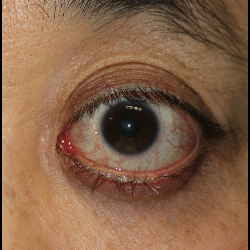

診断は right、確率は93.9%です。
img_height: 426, img_width: 640
x1: -2.0, y1: 72.0, x2: 290.0, y2: 374.0


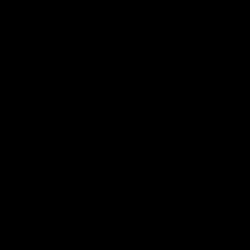

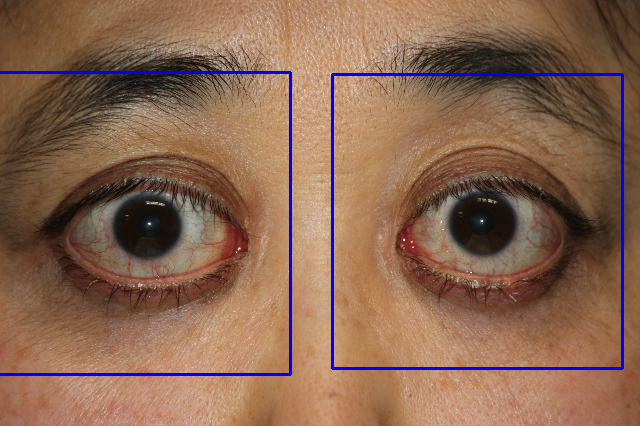

IndexError: ignored

In [17]:
###############################
## うまく左右眼を検出できなかった例の確認 ##
###############################
"""
Letterbox & 250px正方形にリサイズ
"""
import cv2
from google.colab.patches import cv2_imshow
import glob

image_path = ["/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_orig/92.JPG"]
#image_path = incorrect_paths
start_index = 0
end_index = len(image_path)

class_names = {0: "right", 1: "left"}

for i in range(start_index, end_index + 1):
    img = image_path[i]
    pred = inference(img, weight)  # Ensure this function is defined

    img_cv2 = cv2.imread(img)
    # Assume the inference function requires a certain image size; resize if needed.
    # Replace (640, 640) with the input size expected by your network.
    img_cv2_resized = cv2.resize(img_cv2, (640, int(img_cv2.shape[0] * 640 / img_cv2.shape[1])))  # 横幅を640pxにリサイズ

    for bbox in pred[0]:
        x1, y1, x2, y2, prob, class_num = torch.round(bbox[:6])

        prob = bbox[4].item()
        class_name = class_names[bbox[5].item()]

        print(f"診断は {class_name}、確率は{prob * 100:.1f}%です。")

        # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
        img_height, img_width, _ = img_cv2_resized.shape[:3]
        print(f"img_height: {img_height}, img_width: {img_width}")
        padding_x = (img_height - min(img_width, img_height)) / 2
        padding_y = (img_width - min(img_width, img_height)) / 2
        x1 = x1 - padding_x
        y1 = y1 - padding_y
        x2 = x2 - padding_x
        y2 = y2 - padding_y
        print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

        # Draw bounding box
        cv2.rectangle(img_cv2_resized, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

        # Crop and save the image
        mag = 640 / img_cv2.shape[1]

        cropped_img = img_cv2[int(y1/mag):int(y2/mag), int(x1/mag):int(x2/mag)] #バウンディングボックスで切り抜き
        letterbox_img = make_letterbox_image(cropped_img)
        cv2_imshow(letterbox_img)

    # After all boxes are drawn, show and save the final image
    cv2_imshow(img_cv2_resized)


In [ ]:
# Define the path to the folder
%cd "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5"
folder_path = "dataset_yolo_cropped"

# Zip the folder
!zip -r /content/cropped_images.zip "$folder_path"

# Download the zipped folder
from google.colab import files
files.download('/content/cropped_images.zip')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-ba55fb376283>", line 2, in <cell line: 2>
    get_ipython().run_line_magic('cd', '"/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5"')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/l

In [ ]:
'''
To do

・Group 5-fold split
・MobileNetV3でcross validation --> 精度プロット作成
https://github.com/ykitaguchi77/GravCont_classification_colab/blob/master/Olympia_Hertel_estimation_crossvalidation_noTestset.ipynb
https://github.com/ykitaguchi77/GravCont_classification_colab/blob/master/Olympia_Hertel_ensemble_quick.ipynb
・当院データセットでtestする
'''

#**Train MobileNetV3 using cropped images**

・dataset_uni_for_YOLOv5/dataset_yolo_cropped/cropped_images
の画像を手動で確認、不適切な画像を削除

・https://tcd-theme.com/2019/12/mac-zip-compression.htmlを参考にして圧縮

・dataset_uni_for_YOLOv5/dataset_cropped_for_MobileNet_training/cropped_images.zipとしてアップロード

### YOLOv5で抜き出した画像を規定のフォルダに移動

In [ ]:
# # YOLOv5で抜き出した画像を規定のフォルダに移動

# import os
# import zipfile

# parent_folder = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training'

# # zipファイルのパス
# zip_path = f'{parent_folder}/cropped_images.zip'

# # 展開するディレクトリのパス
# extract_folder = f'{parent_folder}/cropped_images'
# '/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training/cropped_images'

# # フォルダがない場合は新規作成
# if os.path.exists(extract_folder):
#     shutil.rmtree(extract_folder)
# os.makedirs(extract_folder)

# # zipファイルを解凍
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(parent_folder)


###ここから

In [ ]:
from __future__ import print_function, division
!pip install torch_optimizer --q

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torchvision.io import read_image
import matplotlib.pyplot as plt
import re
import time
import os
import copy
import statistics
import math
import shutil
import codecs
from scipy import stats
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
!pip install pingouin --q
import pingouin as pg

import glob
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()

!pip install timm --q
import timm
from PIL import Image

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

random_seed = 3 #shuffleのシード

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00
Random Seed:  1234


In [ ]:
# path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training"
# os.chdir(path)

# contains train, val
#DATASET_PATH = r"/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training/cropped_images"
DATASET_PATH = r"/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_250px_uni_periocular"
MODEL_PATH = "./RepVGG-A2-train.pth"
CSV_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel_unilateral.csv"
LOG_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training/log_multi.txt"
ROC_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_uni_for_YOLOv5/dataset_cropped_250px_MobileNet_training/roc_multi.png"
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 8

# transforms param
PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
ROTATION_DEGREES = 3
TRAIN_CROP_SCALE =(0.75,1.0)

VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                #transforms.RandomRotation(ROTATION_DEGREES),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])])

#**5-Foldに分割**

In [ ]:

def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_ids(path_list):
    #id_list = [re.split('[-_]',os.path.basename(name))[0] for name in path_list]
    #id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    id_list = [os.path.basename(name).split(".")[0] for name in path_list]
    return(id_list)

def extract_patient_number(path_list):
    patient_list = [os.path.basename(name).split("_")[0] for name in path_list]
    return(patient_list)


path_list = make_path_list(DATASET_PATH)

#それぞれの項目（path, classes, ID）をリスト化
id = extract_ids(path_list)
patient = extract_patient_number(id)

print("patiend num: {}".format(len(id)))

patiend num: 1959


In [ ]:
# #testsetなし。Group K-foldを用いてデータセット分け
# from sklearn.model_selection import GroupKFold
# from sklearn.model_selection import GroupShuffleSplit

# #fold数だけ空のリストを作成
# num_folds = 5
# train_set, val_set =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]

# X = np.ones(len(id))
# y = np.ones(len(id))
# gkf = GroupKFold(n_splits=num_folds)
# i=0
# for train_idxs, val_idxs in gkf.split(X, y, groups=patient):
#     for idx in train_idxs:
#         train_set[i].append(path_list[idx])
#     for idx in val_idxs:
#         val_set[i].append(path_list[idx])
#     i+=1

# print("train_dataset: {}".format(len(train_set[0])))
# print("val_dataset: {}".format(len(val_set[0])))

# print("extracted_id (example): {}".format(extract_ids(train_set[0])[0]))

In [ ]:
#Group Shuffle Split ＋　Group K-foldを用いてデータセット分け
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

#fold数だけ空のリストを作成
num_folds = 5
train_set, val_set =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]
test_set, remain_set = [], []

#remain:test = 1:9で分割
X = np.ones(len(id))
y = np.ones(len(id))
groups = patient
gss = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=random_seed)
for remain_idxs, test_idxs in gss.split(X, y, groups):
    pass

test_set = [path_list[idxs] for idxs in test_idxs]

remain_patients = [patient[idxs] for idxs in remain_idxs]
remain_set = [path_list[idxs] for idxs in remain_idxs]

X = np.ones(len(remain_idxs))
y = np.ones(len(remain_idxs))
gkf = GroupKFold(n_splits=num_folds)
i=0
for train_idxs, val_idxs in gkf.split(X, y, groups=remain_patients):
    for idx in train_idxs:
        train_set[i].append(remain_set[idx])
    for idx in val_idxs:
        val_set[i].append(remain_set[idx])
    i+=1

print("train_dataset: {}".format(len(train_set[0])))
print("val_dataset: {}".format(len(val_set[0])))
print("test_dataset: {}".format(len(test_set)))
print("")
print("extracted_id (example): {}".format(extract_ids(test_set)[0]))

In [ ]:
#シンプルなK-fold (group_K_Foldではない)

num_folds = 5 #number of folds

#fold数だけ空のリストを作成
train_set, val_set =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]

kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

#まず全体の1割をテストセットとしてよけておく
remain_set, test_set = train_test_split(path_list, test_size=0.1, shuffle=True, random_state=random_seed)

i=0
for train_idxs, val_idxs in kf.split(remain_set):
    for idx in train_idxs:
        train_set[i].append(remain_set[idx])
    for idx in val_idxs:
        val_set[i].append(remain_set[idx])
    i+=1

print("train_dataset: {}".format(len(train_set[0])))
print("val_dataset: {}".format(len(val_set[0])))
print("test_dataset: {}".format(len(test_set)))
print("")
print("extracted_id (example): {}".format(extract_ids(test_set)[0]))

train_dataset: 1410
val_dataset: 353
test_dataset: 196

extracted_id (example): 603_R


#**Create Datasets**

In [ ]:
class Create_Datasets(Dataset):

    def __init__(self, img_list, csv_path, transform):
        self.transform = transform
        self.img_list = img_list
        self.item_paths = []
        self.item_dict = {}
        self.df = pd.read_csv(csv_path)
        df = self.df

        k=0
        for image_path in img_list:
            base_name = os.path.splitext(os.path.basename(image_path))[0] #フォルダより画像番号を抜き出す
            hertel = df[df['number']==str(base_name)].iloc[0,1] #CSV上で一致した番号の画像についてHertel値を抜き出す
            self.item_paths.append([image_path, hertel]) #[path, hertel]の組み合わせをリストに追加する
            item_paths = self.item_paths

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, index):
        image_path = self.item_paths[index][0]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image).float()
        hertel = self.item_paths[index][1]
        target= torch.tensor([hertel]).float()
        return  tensor_image, target



train_dataset = Create_Datasets(train_set[0], CSV_PATH, train_data_transforms)
val_dataset = Create_Datasets(val_set[0], CSV_PATH, val_data_transforms)
test_dataset = Create_Datasets(test_set, CSV_PATH, val_data_transforms)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = 1)


print('train_dataset_size: ' +str(len(train_dataset)))
print('val_dataset_size: ' +str(len(val_dataset)))

train_dataset_size: 1410
val_dataset_size: 353


#**Test with early-stopping**

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size,optimizer, patience, n_epochs, device,  alpha=0):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)

            #l2_normalization
            l2 = torch.tensor(0., requires_grad=True)
            for w in model.parameters():
                l2 = l2 + torch.norm(w)**2
            loss = loss + alpha*l2

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################
        # validate the model #
        ######################

        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )

        print(print_msg)


        #Scheduler step for SGD
        #scheduler.step() #val_lossが下がらなければ減衰


        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

#**ConvNetの調整**

###オリジナルRepVGG-A2使用


In [ ]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
        self.fc1 = nn.Linear(in_features=1408, out_features=512) #out_featuresを1に
        self.fc2 = nn.Linear(in_features=512, out_features=1) #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/Deep_learning/666mai_dataset/RepVGG-A2-train.pth"))
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# !pip install ranger_adabelief
# from ranger_adabelief import RangerAdaBelief
# optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

# Observe that all parameters are being optimized
# optimizer_ft =  optim.AdaBound(
#     model_ft.parameters(),
#     lr= 1e-3,
#     betas= (0.9, 0.999),
#     final_lr = 0.1,
#     gamma=1e-3,
#     eps= 1e-8,
#     weight_decay=5e-4,
#     amsbound=False,
# )

##Timm使用の場合

In [ ]:
timm.list_models()

In [ ]:
# class mod_CNNModel(nn.Module):
#     def __init__(self):
#         super(mod_CNNModel, self).__init__()
#         CNNModel = model_ft
#         self.CNNModel = nn.Sequential(*list(model_ft.children())[:-1])
#         self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
#         self.fc = nn.Linear(in_features=1280, out_features=1) #モデルに応じてin_featuresを調整、out_featuresを1に

#     def forward(self, x):
#         x = self.CNNModel(x)
#         x = torch.flatten(x, 1)
#         x = self.dropout(x) #dropoutを1層追加
#         x = self.fc(x)
#         return x


# # fc layer 2つのバージョン
# class mod_CNNModel(nn.Module):
#     def __init__(self):
#         super(mod_CNNModel, self).__init__()
#         CNNModel = model_ft
#         self.CNNModel = nn.Sequential(*list(model_ft.children())[:-1])
#         self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
#         self.fc1 = nn.Linear(in_features=1280, out_features=512) #モデルに応じてin_featuresを調整
#         self.fc2 = nn.Linear(in_features=512, out_features=1) #out_featuresを1に

#     def forward(self, x):
#         x = self.CNNModel(x)
#         x = torch.flatten(x, 1)
#         x = self.dropout(x)
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


# # Batch_norm plus dropout (for RepVGG_A2: イマイチ)
# class mod_CNNModel(nn.Module):
#     def __init__(self):
#         super(mod_CNNModel, self).__init__()
#         CNNModel = model_ft
#         self.CNNModel = nn.Sequential(*list(model_ft.children())[:-1])
#         self.bn = nn.BatchNorm2d(1408)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#         self.dropout = nn.Dropout(0.25)
#         self.fc = nn.Linear(in_features=12672, out_features=1)

#     def forward(self, x):
#         x = self.CNNModel(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = torch.flatten(x, 1)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x


#model_ft = timm.create_model(model_name = 'efficientnetv2_rw_m', pretrained=True, num_classes=1)
#model_ft = timm.create_model(model_name = 'repvgg_a2', pretrained=True, num_classes=1)
model_ft = timm.create_model(model_name = 'mobilenetv3_large_100', pretrained=True, num_classes=1)
#model_ft = mod_CNNModel()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# !pip install ranger_adabelief
# from ranger_adabelief import RangerAdaBelief
# optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

# Observe that all parameters are being optimized
# optimizer_ft =  optim.AdaBound(
#     model_ft.parameters(),
#     lr= 1e-3,
#     betas= (0.9, 0.999),
#     final_lr = 0.1,
#     gamma=1e-3,
#     eps= 1e-8,
#     weight_decay=5e-4,
#     amsbound=False,
# )

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

In [ ]:
model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)

Epoch: [  1/100] 
train_loss: 22.16470 
valid_loss: 14.08580 
Validation loss decreased (inf --> 14.085800).  Saving model ...

Epoch: [  2/100] 
train_loss: 8.58286 
valid_loss: 8.59595 
Validation loss decreased (14.085800 --> 8.595950).  Saving model ...

Epoch: [  3/100] 
train_loss: 6.40771 
valid_loss: 11.25487 
EarlyStopping counter: 1 out of 20

Epoch: [  4/100] 
train_loss: 4.66660 
valid_loss: 8.21818 
Validation loss decreased (8.595950 --> 8.218180).  Saving model ...

Epoch: [  5/100] 
train_loss: 3.31930 
valid_loss: 6.54032 
Validation loss decreased (8.218180 --> 6.540324).  Saving model ...

Epoch: [  6/100] 
train_loss: 3.45639 
valid_loss: 6.01430 
Validation loss decreased (6.540324 --> 6.014298).  Saving model ...



#**Draw Learning Curves**

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss', color="#377eb8")
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss', color="#ff7f00")

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 10.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Evaluation using testset**

In [ ]:
#evaluation using validation dataset
val_dataset = Create_Datasets(val_set[0], CSV_PATH, val_data_transforms)
val_loader = DataLoader(val_dataset, batch_size = 1)

def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in val_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)


      outputs.append(output[0].item())
      targets.append(target[0].item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append(output[0].item()-target[0].item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))
print('')


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))
print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError)))
print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError)))

# Calculate the probabilities
abs_error_np = np.array(AbsError)
prob_less_than_1 = np.sum(abs_error_np <= 1) / len(AbsError)
prob_less_than_2 = np.sum(abs_error_np <= 2) / len(AbsError)

print('Probability of AbsError <= 1:', prob_less_than_1)
print('Probability of AbsError <= 2:', prob_less_than_2)

In [ ]:
#evaluation using test dataset

def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p



model_ft.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)


      outputs.append(output[0].item())
      targets.append(target[0].item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append(output[0].item()-target[0].item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))
print('')


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveError: '+str(statistics.mean(corrected_error))) #平均誤差
print('Corrected_StdError: '+str(statistics.stdev(corrected_error))) #誤差標準偏差
print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError))) #平均絶対誤差
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError))) #絶対誤差標準偏差
print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError))) #平均絶対誤差(四捨五入)
print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError))) #絶対誤差標準偏差(四捨五入)
print('')


# Calculate the probabilities
abs_error_np = np.array(AbsError)
prob_less_than_1 = np.sum(abs_error_np <= 1) / len(AbsError)
prob_less_than_2 = np.sum(abs_error_np <= 2) / len(AbsError)

print('Probability of AbsError <= 1:', prob_less_than_1)
print('Probability of AbsError <= 2:', prob_less_than_2)


In [ ]:
#Draw Graphs（もともとの散布図
df = pd.DataFrame({'estimate':outputs, 'target':targets})

sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

In [ ]:
#Bland-Altman-Plot

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

In [ ]:
#線形近似式算出
from sklearn import linear_model

estimate = df.loc[:,'estimate']
target = df.loc[:,'target']
clf = linear_model.LinearRegression()

# 説明変数xに "x1"のデータを使用
x = np.array([estimate]).T

# 目的変数yに "x2"のデータを使用
y = target.values

# 予測モデルを作成（単回帰）
clf.fit(x, y)

# パラメータ（回帰係数、切片）を抽出
[a] = clf.coef_
b = clf.intercept_

# パラメータの表示
print("回帰係数:", a)
print("切片:", b)
print("決定係数:", clf.score(x, y))

#平均値により補正した値
df['Corrected_estimate_1']=0
for i in range(len(df)):
    df.iloc[i,2] = corrected_output[i]

#回帰直線により補正した値
df['Corrected_estimate_2']=0
for i in range(len(df)):
    df.iloc[i,3] = df.iloc[i,0]*a+b

#残差
df['Residual_error_1']=0
for i in range(len(df)):
    df.iloc[i,4] = df.iloc[i,2]-df.iloc[i,1]

#残差
df['Residual_error_2']=0
for i in range(len(df)):
    df.iloc[i,5] = df.iloc[i,3]-df.iloc[i,1]

In [ ]:
df.head()

In [ ]:
#平均近似バージョン
#Draw histogram
sns.distplot(
    df['Residual_error_1'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示


#Draw Graphs
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='Corrected_estimate_1', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

corrected_AbsError = [abs(i) for i in df['Residual_error_1']]
print('AveError: '+str(statistics.mean(df['Residual_error_1'])))
print('StdError: '+str(statistics.stdev(df['Residual_error_1'])))
print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]
print('Round_Corrected_AveAbsError: '+str(statistics.mean(round_corrected_AbsError)))
print('Round_Corrected_StdAbsError: '+str(statistics.stdev(round_corrected_AbsError)))


# print("")
# print('Error<-1 and Error>-1: ' + str(sum((-1 < i < 1 for i in df['Residual_error_2']))))
# print('Error<-2 and Error>2: ' + str(sum((-2 < i < 2 for i in df['Residual_error_2']))))
# print('Error<=-2: ' +  str(sum((i <= -2 for i in df['Residual_error_2']))))
# print('Error>=2: ' +  str(sum((i >= 2 for i in df['Residual_error_2']))))

total_errors = len(df['Residual_error_2'])

error_minus1_to_1_count = sum((-1 < i < 1 for i in df['Residual_error_2']))
error_minus1_to_1_percentage = (error_minus1_to_1_count / total_errors) * 100

error_minus2_to_2_count = sum((-2 < i < 2 for i in df['Residual_error_2']))
error_minus2_to_2_percentage = (error_minus2_to_2_count / total_errors) * 100

error_less_equal_minus2_count = sum((i <= -2 for i in df['Residual_error_2']))
error_less_equal_minus2_percentage = (error_less_equal_minus2_count / total_errors) * 100

error_greater_equal_2_count = sum((i >= 2 for i in df['Residual_error_2']))
error_greater_equal_2_percentage = (error_greater_equal_2_count / total_errors) * 100

print("")
print(f'Error<-1 and Error>-1: {error_minus1_to_1_count}/{total_errors} ({error_minus1_to_1_percentage:.2f}%)')
print(f'Error<-2 and Error>2: {error_minus2_to_2_count}/{total_errors} ({error_minus2_to_2_percentage:.2f}%)')
print(f'Error<=-2: {error_less_equal_minus2_count}/{total_errors} ({error_less_equal_minus2_percentage:.2f}%)')
print(f'Error>=2: {error_greater_equal_2_count}/{total_errors} ({error_greater_equal_2_percentage:.2f}%)')





TP, FP, TN, FN = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=18 and df.iloc[i,2]>= 18:
        TP += 1
    if df.iloc[i,1]<18 and df.iloc[i,2]>= 18:
        FP += 1
    if df.iloc[i,1]>=18 and df.iloc[i,2]< 18:
        FN += 1
    if df.iloc[i,1]<18 and df.iloc[i,2]< 18:
        TN += 1

print('')
print('Hertel 18mm以上の検出精度')
print('TP: '+str(TP))
print('FP: '+str(FP))
print('FN: '+str(FN))
print('TN: '+str(TN))
print('Sensitivity: '+str(TP/(TP+FN)))
print('Specificity: '+str(TN/(FP+TN)))
print('Positive predictive value: '+str(TP/(TP+FP)))
print('Negative predictive value: '+str(TN/(TN+FN)))


okpositive, minogashi, oknegative, kajyou = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=16 and df.iloc[i,2]> 18:
        okpositive += 1
    if df.iloc[i,1]<16 and df.iloc[i,2]>= 18:
        kajyou += 1
    if df.iloc[i,1]>=18 and df.iloc[i,2]<= 16:
        minogashi += 1
    if df.iloc[i,1]<18 and df.iloc[i,2]<= 16:
        oknegative += 1

print('')
print('推測18mm以上だが実は16mm未満(過剰): '+str(kajyou)+'例')
print('推測16mm未満だが実は18mm以上（見逃がし）: '+str(minogashi)+'例')

#**以前のデータセットに差し替えるときはこちら**

In [ ]:
##############################################
# 以前のデータセットに差し替えるときはこちら #
##############################################
path = '/content/drive/MyDrive/Deep_learning/Olympia_dataset'
os.chdir(path)

# grav or cont, age, and sex
#NUM_CLASSES = 3

# contains train, val
#DATASET_PATH = r"./dataset_500px"
AREA = ["half", "periocular", "eye"]
DATASET_PATH_0 = f"/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_250px_uni_{AREA[0]}"
DATASET_PATH_1 = f"/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_250px_uni_{AREA[1]}"
DATASET_PATH_2 = f"/content/drive/MyDrive/Deep_learning/Olympia_dataset/dataset_250px_uni_{AREA[2]}"
PARENT_PATHS = [DATASET_PATH_0, DATASET_PATH_1, DATASET_PATH_2]

DATASET_PATH = DATASET_PATH_0

MODEL_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/RepVGG-A2-train.pth"
CSV_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/Hertel_unilateral.csv"

LOG_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/log_multi.txt"
ROC_PATH = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/roc_multi.png"
#CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 16

# transforms param　　左右分けているのでflipはしない
PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
ROTATION_DEGREES = 3
TRAIN_CROP_SCALE =(0.75,1.0)

VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


from __future__ import print_function, division
!pip install torch_optimizer
import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import re
import time
import os
import copy
import statistics
import math
import shutil
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import glob
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

random_seed = 1 #shuffleのシード

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def torch_fix_seed(seed):
    print("Random Seed: ", seed)
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed(seed=1)


train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                #transforms.RandomRotation(ROTATION_DEGREES),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])])

'''
5-Foldに分割
'''

def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_ids(path_list):
    #id_list = [re.split('[-_]',os.path.basename(name))[0] for name in path_list]
    #id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    id_list = [os.path.basename(name).split(".")[0] for name in path_list]
    return(id_list)

def extract_patient_number(path_list):
    patient_list = [os.path.basename(name).split("_")[0] for name in path_list]
    return(patient_list)


path_list = make_path_list(PARENT_PATHS[1])

#それぞれの項目（path, classes, ID）をリスト化
id = extract_ids(path_list)
patient = extract_patient_number(id)

print("id_num: {}".format(len(id)))
print("patient_num: {}".format(len(patient)))

print(len(path_list))


id_list_0 = extract_ids(make_path_list(DATASET_PATH_0))
id_list_1 = extract_ids(make_path_list(DATASET_PATH_1))
id_list_2 = extract_ids(make_path_list(DATASET_PATH_2))
common_id = set(id_list_0) & set(id_list_1) & set(id_list_2)
common_patient = list([id.split("_")[0] for id in common_id])

path_list_0 = [f"{DATASET_PATH_0}/{id}.JPG" for id in common_id]
path_list_1 = [f"{DATASET_PATH_1}/{id}.JPG" for id in common_id]
path_list_2 = [f"{DATASET_PATH_2}/{id}.JPG" for id in common_id]
path_list_list = [path_list_0, path_list_1, path_list_2]

print(f"common_ids: {len(common_id)}")
print(f"common_patients: {len(common_patient)}")
print(f"{path_list_0[20]}")
print(f"{path_list_1[20]}")
print(f"{path_list_2[20]}")


'''
Create Dataset
'''
def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_ids(path_list):
    #id_list = [re.split('[-_]',os.path.basename(name))[0] for name in path_list]
    #id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    id_list = [os.path.basename(name).split(".")[0] for name in path_list]
    return(id_list)


path_list = make_path_list(DATASET_PATH)

#それぞれの項目（path, classes, ID）をリスト化
id = extract_ids(path_list)

print("patiend num: {}".format(len(id)))


num_folds = 5 #number of folds

#fold数だけ空のリストを作成
train_set, val_set =  [[] for i in range(0, num_folds)], [[] for i in range(0, num_folds)]

kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

#まず全体の1割をテストセットとしてよけておく
remain_set, test_set = train_test_split(path_list, test_size=0.1, shuffle=True, random_state=random_seed)

i=0
for train_idxs, val_idxs in kf.split(remain_set):
    for idx in train_idxs:
        train_set[i].append(remain_set[idx])
    for idx in val_idxs:
        val_set[i].append(remain_set[idx])
    i+=1

print("train_dataset: {}".format(len(train_set[0])))
print("val_dataset: {}".format(len(val_set[0])))
print("test_dataset: {}".format(len(test_set)))
print("")
print("extracted_id (example): {}".format(extract_ids(test_set)[0]))


class Create_Datasets(Dataset):

    def __init__(self, img_list, csv_path, transform):
        self.transform = transform
        self.img_list = img_list
        self.item_paths = []
        self.item_dict = {}
        self.df = pd.read_csv(csv_path)
        df = self.df

        k=0
        for image_path in img_list:
            base_name = os.path.splitext(os.path.basename(image_path))[0] #フォルダより画像番号を抜き出す
            hertel = df[df['number']==str(base_name)].iloc[0,1] #CSV上で一致した番号の画像についてHertel値を抜き出す
            self.item_paths.append([image_path, hertel]) #[path, hertel]の組み合わせをリストに追加する
            item_paths = self.item_paths

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, index):
        image_path = self.item_paths[index][0]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image).float()
        hertel = self.item_paths[index][1]
        target= torch.tensor([hertel]).float()
        return  tensor_image, target



train_dataset = Create_Datasets(train_set[0], CSV_PATH, train_data_transforms)
val_dataset = Create_Datasets(val_set[0], CSV_PATH, val_data_transforms)
test_dataset = Create_Datasets(test_set, CSV_PATH, val_data_transforms)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = 1)

print('train_dataset_size: ' +str(len(train_dataset)))
print('val_dataset_size: ' +str(len(val_dataset)))
print('test_dataset_size: ' +str(len(test_dataset)))



"""
Test with early stopping
"""
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################
        # validate the model #
        ######################

        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

"""
area_num
1: half
2: periocular
3: eye
データセットからそれぞれの画像を読みこんでトレーニング
"""

!pip install timm --q
import timm

model_ft = timm.create_model(model_name = 'mobilenetv3_large_100', pretrained=True, num_classes=1)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)


#**Export coreML including non-max supression**

In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt"

In [ ]:
#!python export.py --weights /content/drive/MyDrive/Deep_learning/GO_extended_dataset/super_extend_for_YOLO_training/yolov5n-iFish_120epoch.pt --nms --include coreml
!python export.py --weights $weight_path --nms --include "coreml"


In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/hietalajulius/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements-export.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

In [ ]:
!python export-nms.py --include coreml --weights $weight_path


#**Interference and crop Extended dataset**

In [ ]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

In [ ]:
# パスを指定する
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"
input_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images"
output_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train"

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
from tqdm import tqdm
import os

# image_path = glob.glob(f"{dataset_grav}/*")
# img = image_path[100]

class_names = {0:"cont", 1:"grav"}

device = 'cpu' # device = None or 'cpu' or 0 or '0' or '0,1,2,3'
device = select_device(device)
model = DetectMultiBackend(weight, device=device, dnn=False)

os.makedirs(output_folder, exist_ok=True)

for img in tqdm(glob.glob(f"{input_folder}/*")):

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

    img_cv2 = cv2.imread(img)

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height))/2
    padding_y = (img_width - min(img_width, img_height))/2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    #cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    #cv2_imshow(img_cv2)

    # バウンディングボックスで画像を切り抜く」

    if x1 < 0: #負の場合のエラー回避
        x1 = 0

    cropped_image = img_cv2[int(y1):int(y2), int(x1):int(x2)]

    # 切り抜いた画像を保存する
    save_path = f"{output_folder}/{os.path.basename(img)}"
    print(save_path)
    #cv2_imshow(cropped_image)
    cv2.imwrite(save_path, cropped_image)

In [ ]:
#rewrite csv file (bootcamp用csvのimage_pathを改変)
import pandas as pd

csv_1_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train_list.csv"
csv_2_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid_list.csv"
csv_1 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train_list.csv"
csv_2 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/valid_list.csv"

def rewrite_csv(df):
    path_list = []
    for path in df["image_path"]:
        path = path.replace("periocular_for_YOLO_training", "periocular_cropped_using_YOLO")
        path = path.replace("images/", "")
        path_list.append(path)
    df["image_path"] = path_list
    return(df)

df = pd.read_csv(csv_1_orig)
df = rewrite_csv(df)
print(df)
df.to_csv(csv_1, index=False)

df = pd.read_csv(csv_2_orig)
df = rewrite_csv(df)
df.to_csv(csv_2,  index=False)

#**YOLOv5-EigenCAM**

https://jacobgil.github.io/pytorch-gradcam-book/EigenCAM%20for%20YOLO5.html

In [ ]:
%cd /content
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

In [ ]:
%cd /content/pytorch-grad-cam

In [ ]:
!pip install pytorch-gradcam

In [ ]:
!pip install ttach

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "https://www.thesprucepets.com/thmb/3ABKoAPm0Hu4PcWsDH1giawq7ck=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

# **To do Next**

・外部のデータセット（Treated）を洗い出し

・内部のデータセットをさらに水増し

・内部および外部データセットより、test用各100枚（grav50枚、cont50枚）を抜き出しておき、合体する

・既存のYOLOv5を用いてbounding boxを抜き出し、新たにトレーニングする